The ultimate objective of this portion of the hack it to create Metric Analysis Framework metrics to determine the value of a given opsim run for the intermediate mass MACHO science. 

Note that to run this notebook you will need to have installed MAF. Follow the directions at:

https://github.com/wadawson/sims_maf_contrib/blob/master/tutorials/Index.ipynb

To run this notebook you should have,

> setup sims_maf

within the terminal where you ran ipython, i.e.

>ipython notebook IntroductionNotebook.ipynb

In this directory you should have downloaded the survey simulation database 

>wget http://ops2.lsst.org/runs/reference_run/minion_1016/minion_1016_sqlite.db.gz
> gzip -d minion_1016_sqlite.db.gz

It may also be helpful to look at 

https://github.com/wadawson/sims_maf_contrib/blob/master/tutorials/Introduction%20Notebook.ipynb

before getting started on this notebook, since this notebook will skip some of the pedantic expositions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# import lsst sims maf modules
import lsst.sims.maf
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as lsst_metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

# import macho modules
import metrics

# make it so that autoreload of modules works
from IPython import get_ipython
ipython = get_ipython()
if '__IPYTHON__' in globals():
    ipython.magic('load_ext autoreload')
    ipython.magic('autoreload 2')

%matplotlib inline

## General Input
### Catalog

In [2]:
#dir = '/data/des40.a/data/marcelle/lsst-gw/OperationsSimulatorBenchmarkSurveys/'
dir = '/users/dagoret/DATA/Cadence/'
#opsdb = db.OpsimDatabase(dir+'minion_1016_sqlite.db')
opsdb = db.OpsimDatabase(dir+'baseline2018a.db')
outDir = 'notebook_output'

### SQL Query

In [3]:
# Initially let's just look at the number of observations in r-band after 2 years with default kwargs
sql = ''

In [4]:
sql

''

### Metrics

In [5]:
# Calculate the median gap between consecutive observations within a night, in hours.
metric_intranightgap = lsst_metrics.IntraNightGapsMetric(reduceFunc=np.median)

# Calculate the median gap between consecutive observations between nights, in days.
metric_internightgap = lsst_metrics.InterNightGapsMetric(reduceFunc=np.median)

# Uniformity of time between consecutive visits on short time scales:
'''
timeCol : str, optional
    The column containing the 'time' value. Default expMJD.
minNvisits : int, optional
    The minimum number of visits required within the time interval (dTmin to dTmax).
    Default 100.
dTmin : float, optional
    The minimum dTime to consider (in days). Default 40 seconds.
dTmax : float, optional
    The maximum dTime to consider (in days). Default 30 minutes.
'''
#metric_rapidrevisit = lsst_metrics.RapidRevisitMetric(timeCol='expMJD', minNvisits=10,dTmin=40.0 / 60.0 / 60.0 / 24.0, dTmax=30.0 / 60.0 / 24.0)
metric_rapidrevisit = lsst_metrics.RapidRevisitMetric(mjdCol='observationStartMJD', minN1=10,dTmin=40.0 / 60.0 / 60.0 / 24.0, dTmax=30.0 / 60.0 / 24.0)
# Number of revisits with time spacing less than 24 hours
metric_nrevisit24hr = lsst_metrics.NRevisitsMetric(dT=24*60)

# Use the custom metric in the macho metrics file, which asks whether the light curve
# allows a detection of a mass solar_mass lens

detectable = metrics.massMetric(mass=30.)

### Slicer
Let's look at the MAF results in the galactic coordinate system since this correlates nicely with stellar number density. (More stars, more expected number of microlensing events.)

In [42]:
# Let's look at the metric results in the galactic coordinate fram
slicer = slicers.HealpixSlicer(latCol='galb', lonCol='gall', nside=64)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


### Plot functions and customization

In [43]:
#plotFuncs = [plots.HealpixSkyMap()] # only plot the sky maps for now
# Customize the plot format
plotDict_intranightgap = {'colorMin':0, 'colorMax': 1., 'cbarFormat': '%0.2f'}  # Set the max on the color bar
plotDict_internightgap = {'colorMin':0,'colorMax': 10.}  # Set the max on the color bar
plotDict_rapidrevisit = {'cbarFormat': '%0.2f'}
plotDict_nrevisit24hr = {'colorMin':0,'colorMax': 300.}
plotDict_detectable = {'colorMin':0,'colorMax': 1.}

### Bundles

In [44]:
# Create the MAF bundles for each plot
bundle_intranightgap = metricBundles.MetricBundle(metric_intranightgap, slicer, sql, plotDict=plotDict_intranightgap)#, plotFuncs=plotFuncs)
bundle_internightgap = metricBundles.MetricBundle(metric_internightgap, slicer, sql, plotDict=plotDict_internightgap)#, plotFuncs=plotFuncs)
bundle_rapidrevisit = metricBundles.MetricBundle(metric_rapidrevisit, slicer, sql, plotDict=plotDict_rapidrevisit)#, plotFuncs=plotFuncs)
bundle_nrevisit24hr = metricBundles.MetricBundle(metric_nrevisit24hr, slicer, sql, plotDict=plotDict_nrevisit24hr)#, plotFuncs=plotFuncs)
bundle_detectable = metricBundles.MetricBundle(detectable, slicer, sql, plotDict=plotDict_detectable)#, plotFuncs=plotFuncs)


# Create the query bundle dictonary to run all of the queries in the same run
bdict = {'intragap':bundle_intranightgap, 'intergap':bundle_internightgap,
         'rapidrevisit':bundle_rapidrevisit, 'nrevisit24hr':bundle_nrevisit24hr,
        'detectable':bundle_detectable}

#bdict = {
         #'intragap':bundle_intranightgap, 'intergap':bundle_internightgap,
         #'rapidrevisit':bundle_rapidrevisit, 
         #'nrevisit24hr':bundle_nrevisit24hr,
#        'detectable':bundle_detectable}


bg = metricBundles.MetricBundleGroup(bdict, opsdb, outDir=outDir)

In [45]:
# Run the queries
bg.runAll()

Querying database SummaryAllProps with no constraint for columns ['observationStartMJD', 'fieldDec', 'night', 'fieldRA'].
Found 2372700 visits
Running:  ['intragap', 'intergap', 'rapidrevisit', 'nrevisit24hr', 'detectable']
nvisits 1897 > 30 True
years 164.23104786168784 173.7522227926078
year min 164.23104786168784 year max 165.23104786168784
nvisits in a year 163 > 10
year min 165.23104786168784 year max 166.23104786168784
nvisits in a year 163 > 10
year min 166.23104786168784 year max 167.23104786168784
nvisits in a year 233 > 10
year min 167.23104786168784 year max 168.23104786168784
nvisits in a year 222 > 10
year min 168.23104786168784 year max 169.23104786168784
nvisits in a year 204 > 10
year min 169.23104786168784 year max 170.23104786168784
nvisits in a year 142 > 10
year min 170.23104786168784 year max 171.23104786168784
nvisits in a year 259 > 10
year min 171.23104786168784 year max 172.23104786168784
nvisits in a year 192 > 10
year min 172.23104786168784 year max 173.23104

nvisits 126755 > 30 True
years 163.87956812305117 173.77678470479378
year min 163.87956812305117 year max 164.87956812305117
nvisits in a year 11564 > 10
year min 164.87956812305117 year max 165.87956812305117
nvisits in a year 10493 > 10
year min 165.87956812305117 year max 166.87956812305117
nvisits in a year 14593 > 10
year min 166.87956812305117 year max 167.87956812305117
nvisits in a year 14029 > 10
year min 167.87956812305117 year max 168.87956812305117
nvisits in a year 13698 > 10
year min 168.87956812305117 year max 169.87956812305117
nvisits in a year 11388 > 10
year min 169.87956812305117 year max 170.87956812305117
nvisits in a year 14894 > 10
year min 170.87956812305117 year max 171.87956812305117
nvisits in a year 13078 > 10
year min 171.87956812305117 year max 172.87956812305117
nvisits in a year 10769 > 10
year min 172.87956812305117 year max 173.87956812305117
nvisits in a year 12249 > 10
	 True
	 True
nvisits 219289 > 30 True
years 163.86863189849672 173.8536210611706

nvisits 373289 > 30 True
years 163.86862914163308 173.85689295130175
year min 163.86862914163308 year max 164.86862914163308
nvisits in a year 34871 > 10
year min 164.86862914163308 year max 165.86862914163308
nvisits in a year 37739 > 10
year min 165.86862914163308 year max 166.86862914163308
nvisits in a year 39745 > 10
year min 166.86862914163308 year max 167.86862914163308
nvisits in a year 40200 > 10
year min 167.86862914163308 year max 168.86862914163308
nvisits in a year 39370 > 10
year min 168.86862914163308 year max 169.86862914163308
nvisits in a year 32764 > 10
year min 169.86862914163308 year max 170.86862914163308
nvisits in a year 43944 > 10
year min 170.86862914163308 year max 171.86862914163308
nvisits in a year 35505 > 10
year min 171.86862914163308 year max 172.86862914163308
nvisits in a year 32973 > 10
year min 172.86862914163308 year max 173.86862914163308
nvisits in a year 36178 > 10
	 True
	 True
nvisits 612570 > 30 True
years 163.86863189849672 173.8573521116941

nvisits 1680174 > 30 True
years 163.8686374439121 173.85735211169418
year min 163.8686374439121 year max 164.8686374439121
nvisits in a year 166971 > 10
year min 164.8686374439121 year max 165.8686374439121
nvisits in a year 157642 > 10
year min 165.8686374439121 year max 166.8686374439121
nvisits in a year 171462 > 10
year min 166.8686374439121 year max 167.8686374439121
nvisits in a year 171202 > 10
year min 167.8686374439121 year max 168.8686374439121
nvisits in a year 172578 > 10
year min 168.8686374439121 year max 169.8686374439121
nvisits in a year 160646 > 10
year min 169.8686374439121 year max 170.8686374439121
nvisits in a year 173382 > 10
year min 170.8686374439121 year max 171.8686374439121
nvisits in a year 173731 > 10
year min 171.8686374439121 year max 172.8686374439121
nvisits in a year 150295 > 10
year min 172.8686374439121 year max 173.8686374439121
nvisits in a year 182265 > 10
	 True
	 True
nvisits 892844 > 30 True
years 163.8686374439121 173.85677595888154
year min 

nvisits 437882 > 30 True
years 163.8686374439121 173.85677595888154
year min 163.8686374439121 year max 164.8686374439121
nvisits in a year 44670 > 10
year min 164.8686374439121 year max 165.8686374439121
nvisits in a year 44796 > 10
year min 165.8686374439121 year max 166.8686374439121
nvisits in a year 47826 > 10
year min 166.8686374439121 year max 167.8686374439121
nvisits in a year 45603 > 10
year min 167.8686374439121 year max 168.8686374439121
nvisits in a year 45747 > 10
year min 168.8686374439121 year max 169.8686374439121
nvisits in a year 36325 > 10
year min 169.8686374439121 year max 170.8686374439121
nvisits in a year 49215 > 10
year min 170.8686374439121 year max 171.8686374439121
nvisits in a year 42482 > 10
year min 171.8686374439121 year max 172.8686374439121
nvisits in a year 36736 > 10
year min 172.8686374439121 year max 173.8686374439121
nvisits in a year 44482 > 10
	 True
	 True
nvisits 114078 > 30 True
years 163.86862914163308 173.85670878013536
year min 163.868629

nvisits 362053 > 30 True
years 163.86862914163308 173.85670878013536
year min 163.86862914163308 year max 164.86862914163308
nvisits in a year 31103 > 10
year min 164.86862914163308 year max 165.86862914163308
nvisits in a year 35331 > 10
year min 165.86862914163308 year max 166.86862914163308
nvisits in a year 37380 > 10
year min 166.86862914163308 year max 167.86862914163308
nvisits in a year 38255 > 10
year min 167.86862914163308 year max 168.86862914163308
nvisits in a year 37428 > 10
year min 168.86862914163308 year max 169.86862914163308
nvisits in a year 33496 > 10
year min 169.86862914163308 year max 170.86862914163308
nvisits in a year 42967 > 10
year min 170.86862914163308 year max 171.86862914163308
nvisits in a year 35279 > 10
year min 171.86862914163308 year max 172.86862914163308
nvisits in a year 33499 > 10
year min 172.86862914163308 year max 173.86862914163308
nvisits in a year 37315 > 10
	 True
	 True
nvisits 415413 > 30 True
years 163.86862914163308 173.8571475333992

nvisits 304257 > 30 True
years 163.86919756255227 173.85734659796688
year min 163.86919756255227 year max 164.86919756255227
nvisits in a year 25835 > 10
year min 164.86919756255227 year max 165.86919756255227
nvisits in a year 28394 > 10
year min 165.86919756255227 year max 166.86919756255227
nvisits in a year 30301 > 10
year min 166.86919756255227 year max 167.86919756255227
nvisits in a year 30446 > 10
year min 167.86919756255227 year max 168.86919756255227
nvisits in a year 30370 > 10
year min 168.86919756255227 year max 169.86919756255227
nvisits in a year 29896 > 10
year min 169.86919756255227 year max 170.86919756255227
nvisits in a year 31489 > 10
year min 170.86919756255227 year max 171.86919756255227
nvisits in a year 31538 > 10
year min 171.86919756255227 year max 172.86919756255227
nvisits in a year 30173 > 10
year min 172.86919756255227 year max 173.86919756255227
nvisits in a year 35815 > 10
	 True
	 True
nvisits 266943 > 30 True
years 163.8688735518544 173.85734659796688

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with "" constraint now.


/cvmfs/sw.lsst.eu/darwin-x86_64/lsst_sims/sims_w_2020_31/stack/miniconda3-py37_4.8.2-1a1d771/DarwinX86/sims_maf/2.13.0.sims-59-g0a27faef/python/lsst/sims/maf/utils/mafUtils.py:56: RuntimeWarning: divide by zero encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/cvmfs/sw.lsst.eu/darwin-x86_64/lsst_sims/sims_w_2020_31/stack/miniconda3-py37_4.8.2-1a1d771/DarwinX86/sims_maf/2.13.0.sims-59-g0a27faef/python/lsst/sims/maf/utils/mafUtils.py:58: UserWarning: Optimal bin calculation tried to make inf bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 0.0443501  dipole: lon: -174.767, lat: -2.84423, amp: 0.0335881
monopole: 74.2604  dipole: lon: -176.796, lat: 0.770735, amp: 73.5051


/cvmfs/sw.lsst.eu/darwin-x86_64/lsst_sims/sims_w_2020_31/stack/miniconda3-py37_4.8.2-1a1d771/DarwinX86/sims_maf/2.13.0.sims-59-g0a27faef/python/lsst/sims/maf/plots/spatialPlotters.py:332: UserWarning: Histogram range was single-valued; expanding default range.
  warnings.warn('Histogram range was single-valued; expanding default range.')
/cvmfs/sw.lsst.eu/darwin-x86_64/lsst_sims/sims_w_2020_31/stack/miniconda3-py37_4.8.2-1a1d771/DarwinX86/sims_maf/2.13.0.sims-59-g0a27faef/python/lsst/sims/maf/utils/mafUtils.py:56: RuntimeWarning: invalid value encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/cvmfs/sw.lsst.eu/darwin-x86_64/lsst_sims/sims_w_2020_31/stack/miniconda3-py37_4.8.2-1a1d771/DarwinX86/sims_maf/2.13.0.sims-59-g0a27faef/python/lsst/sims/maf/utils/mafUtils.py:64: UserWarning: Optimal bin calculation calculated NaN: returning 200
  warnings.warn('Optimal bin calculation calculated NaN: returning %i' %(nbinMax))
/cvmfs/sw.lsst.eu/darwin-x86_64/lsst_sims/sims_w_20

monopole: 1  dipole: lon: 0, lat: nan, amp: 0
monopole: -3.42091e+08  dipole: lon: 3.01267, lat: -0.198455, amp: 3.42938e+08


/cvmfs/sw.lsst.eu/darwin-x86_64/lsst_sims/sims_w_2020_31/stack/miniconda3-py37_4.8.2-1a1d771/DarwinX86/sims_maf/2.13.0.sims-59-g0a27faef/python/lsst/sims/maf/plots/spatialPlotters.py:332: UserWarning: Histogram range was single-valued; expanding default range.
  warnings.warn('Histogram range was single-valued; expanding default range.')
/cvmfs/sw.lsst.eu/darwin-x86_64/lsst_sims/sims_w_2020_31/stack/miniconda3-py37_4.8.2-1a1d771/DarwinX86/sims_maf/2.13.0.sims-59-g0a27faef/python/lsst/sims/maf/utils/mafUtils.py:56: RuntimeWarning: invalid value encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/cvmfs/sw.lsst.eu/darwin-x86_64/lsst_sims/sims_w_2020_31/stack/miniconda3-py37_4.8.2-1a1d771/DarwinX86/sims_maf/2.13.0.sims-59-g0a27faef/python/lsst/sims/maf/utils/mafUtils.py:64: UserWarning: Optimal bin calculation calculated NaN: returning 200
  warnings.warn('Optimal bin calculation calculated NaN: returning %i' %(nbinMax))
/cvmfs/sw.lsst.eu/darwin-x86_64/lsst_sims/sims_w_20

monopole: 1  dipole: lon: 0, lat: nan, amp: 0
Plotting complete.


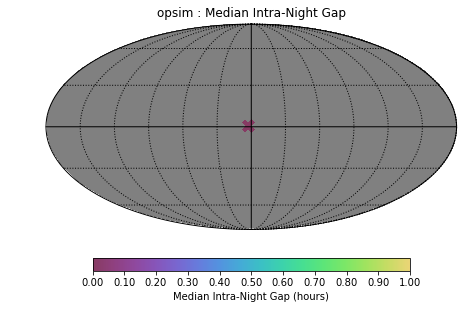

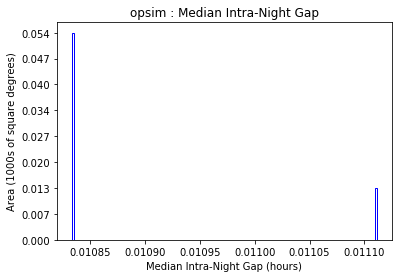

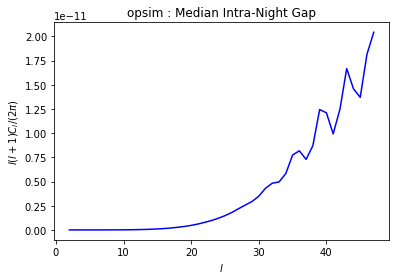

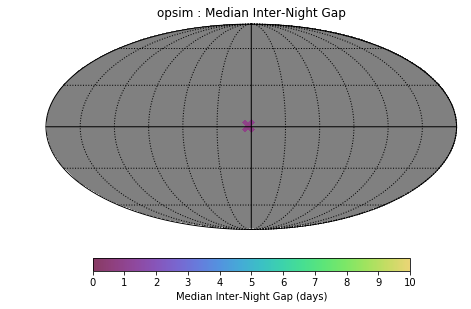

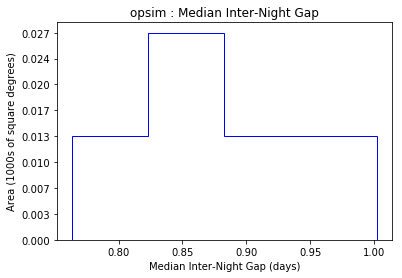

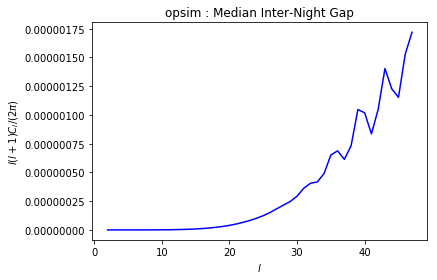

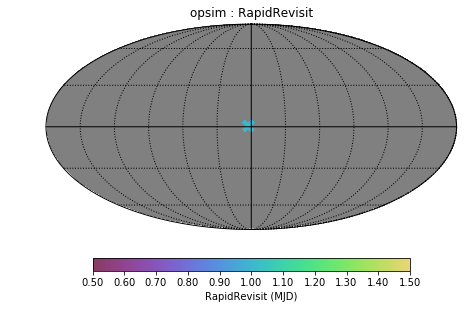

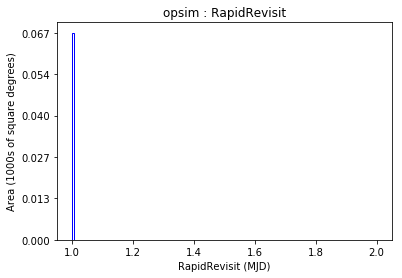

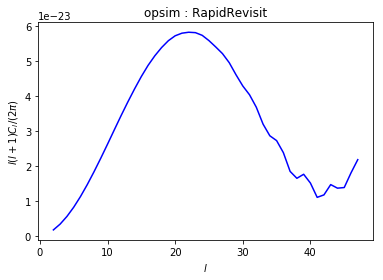

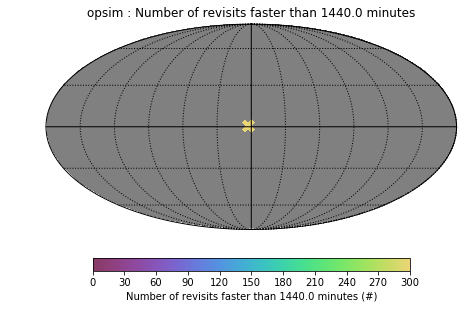

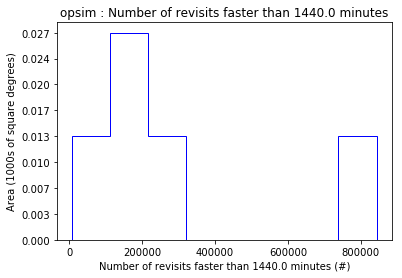

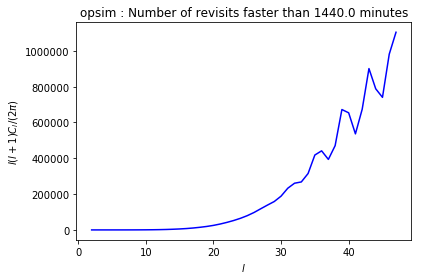

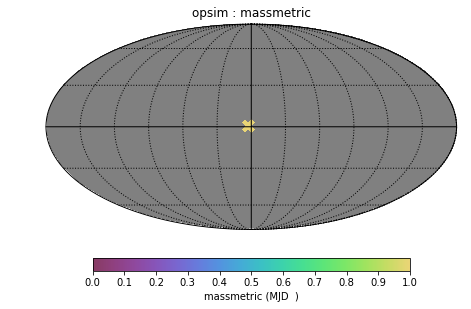

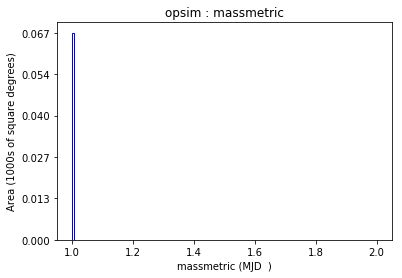

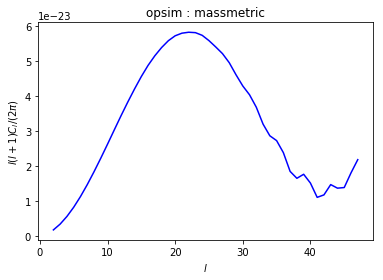

In [10]:
# Create the plots
bg.plotAll(closefigs=False)

## Plot a light curve
This is largely based on:
http://localhost:8888/notebooks/Git/sims_maf_contrib/tutorials/PullLightCurves.ipynb

In [47]:
outDir ='LightCurve'
resultsDb = db.ResultsDb(outDir=outDir)

In [48]:
filters = ['u','g','r','i','z','y']
colors={'u':'cyan','g':'g','r':'y','i':'r','z':'m', 'y':'k'}

In [49]:
# Set RA, Dec for a single point in the sky. in radians. Galactic Center.
ra = np.radians(266.4168)
dec = np.radians(-29.00)
# SNR limit (Don't use points below this limit)
snrLimit = 5.
# Demand this many points above SNR limit before plotting LC
nPtsLimit = 6

In [50]:
# The pass metric just passes data straight through.
#metric = metrics.PassMetric(cols=['filter','fiveSigmaDepth','expMJD'])
metric= lsst_metrics.simpleMetrics.PassMetric(cols=['filter','fiveSigmaDepth','observationStartMJD'])
#slicer = slicers.UserPointsSlicer(ra,dec,lonCol='ditheredRA',latCol='ditheredDec')
slicer = slicers.UserPointsSlicer(ra,dec)
sql = ''
bundle = metricBundles.MetricBundle(metric,slicer,sql)
bg =  metricBundles.MetricBundleGroup({'mybd':bundle}, opsdb,
                                      outDir=outDir, resultsDb=resultsDb)

In [51]:
bg.runAll()

Querying database SummaryAllProps with no constraint for columns ['observationStartMJD', 'filter', 'fieldDec', 'fieldRA', 'fiveSigmaDepth'].
Found 2372700 visits
Running:  ['mybd']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [52]:
bg.plotAll(closefigs=False)

Plotting figures with "" constraint now.
Plotting complete.


In [53]:
bundle.dbCols

{'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth', 'observationStartMJD'}

In [54]:
bundle.metricValues.data[0]['filter']

array(['z', 'z', 'z', 'z', 'r', 'i', 'r', 'r', 'y', 'z', 'r', 'z', 'y',
       'r', 'z', 'i', 'r', 'i', 'r', 'y', 'z', 'r', 'z', 'y', 'r', 'y',
       'u', 'y', 'i', 'r', 'z', 'y', 'i', 'y', 'z', 'i', 'z', 'i', 'y',
       'r', 'i', 'i', 'r', 'r', 'y', 'u', 'y', 'r', 'y', 'i', 'z', 'i',
       'r', 'y', 'y', 'r', 'y', 'i', 'r', 'y', 'i', 'z', 'r', 'r', 'i',
       'r', 'z', 'g', 'y', 'y', 'r', 'z', 'y', 'i', 'r', 'i', 'u', 'z',
       'r', 'u', 'i', 'r', 'i', 'z', 'z', 'r', 'i', 'g', 'z', 'z', 'u',
       'y', 'r', 'r', 'z', 'r', 'i', 'u', 'g', 'r', 'i', 'r', 'i', 'r',
       'i', 'u', 'z', 'y', 'u', 'r', 'r', 'i', 'i', 'g', 'r', 'y', 'y',
       'r', 'r', 'z', 'i', 'g', 'y', 'i', 'i', 'y', 'g', 'r', 'z', 'y',
       'i', 'u', 'r', 'i', 'u', 'z', 'i', 'i', 'i', 'i', 'y', 'g', 'y',
       'i', 'y', 'g', 'r', 'g', 'y', 'y', 'i', 'i', 'i', 'y', 'i', 'z',
       'r', 'r', 'z', 'y', 'z', 'z', 'i', 'z', 'i', 'r', 'u', 'u', 'u',
       'i', 'i', 'r', 'y', 'u', 'i', 'z', 'i', 'i', 'i', 'r', 'r

In [55]:
bundle.metricValues.data[0]['observationStartMJD']

array([60280.0237037 , 60650.02864583, 60630.03888889, 61225.42818287,
       63487.14335648, 63428.34576389, 62323.42729167, 60989.07008102,
       60101.43325231, 60268.05430556, 61005.04028935, 61634.26979167,
       59878.09960648, 62802.0527662 , 60630.02053241, 62705.3508912 ,
       63118.17559028, 63428.32923611, 61941.43380787, 62012.23666667,
       60539.26677083, 62451.01878472, 60650.04194444, 59895.05365741,
       63487.16677083, 63463.21174769, 62030.22284722, 61932.39883102,
       61359.05263889, 60989.0909375 , 60268.03893519, 60511.29265046,
       61327.19876157, 59868.1512037 , 61279.3334375 , 61327.16612269,
       61634.25476852, 61006.06074074, 62340.26616898, 60534.3615625 ,
       62705.33960648, 60609.08402778, 60642.05466435, 62323.39229167,
       61576.36568287, 62801.10996528, 62378.2631713 , 63118.19024306,
       60842.42813657, 62747.25469907, 61931.42383102, 62747.23390046,
       63148.09461806, 60623.07369213, 60566.20344907, 62032.17451389,
      

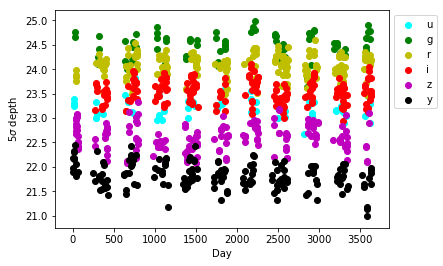

In [56]:
dayZero = bundle.metricValues.data[0]['observationStartMJD'].min()
for fname in filters:
    good = np.where(bundle.metricValues.data[0]['filter'] == fname)
    plt.scatter(bundle.metricValues.data[0]['observationStartMJD'][good]- dayZero, 
                bundle.metricValues.data[0]['fiveSigmaDepth'][good],
                c = colors[fname], label=fname)
plt.xlabel('Day')
plt.ylabel('5$\sigma$ depth')
plt.legend(scatterpoints=1, loc="upper left", bbox_to_anchor=(1,1))

Note that something doesn't seem right about the light curve above since there is >mag extinction towards the center of the Milky Way for bluer bands, yet these are the same 5sigma magnitude depths as towards the LMC (see below).

Note that we could take the 5 sigma depth and translate that into a photometric unertainty for a given magnitude magnification event.

### LMC Example

In [64]:
# Set RA, Dec for a single point in the sky. in radians. LMC.
ra = np.radians(80.8942)
dec = np.radians(-69.756)
# SNR limit (Don't use points below this limit)
snrLimit = 5.
# Demand this many points above SNR limit before plotting LC
nPtsLimit = 2
# The pass metric just passes data straight through.
metric =  lsst_metrics.PassMetric(cols=['filter','fiveSigmaDepth','observationStartMJD'])
#metric= lsst_metrics.simpleMetrics.PassMetric(cols=['filter','fiveSigmaDepth','observationStartMJD'])
slicer = slicers.UserPointsSlicer(ra,dec,lonCol='ditheredRA',latCol='ditheredDec')
sql = ''
bundle = metricBundles.MetricBundle(metric,slicer,sql)
bg =  metricBundles.MetricBundleGroup({0:bundle}, opsdb,outDir=outDir, resultsDb=resultsDb)
bg.runAll()

print(bundle.dbCols)

Querying database SummaryAllProps with no constraint for columns ['observationStartMJD', 'filter', 'ditheredRA', 'ditheredDec', 'fiveSigmaDepth'].
{'observationStartMJD', 'filter', 'ditheredRA', 'ditheredDec', 'fiveSigmaDepth'}


In [65]:
bg.plotAll(closefigs=False)

Plotting figures with "" constraint now.
Plotting complete.


In [58]:
bundle.metricValues

In [59]:
#bundle.metricValues.data[0]['filter']
dayZero = bundle.metricValues.data[0]['observationStartMJD'].min()
for fname in filters:
    good = np.where(bundle.metricValues.data[0]['filter'] == fname)
    plt.scatter(bundle.metricValues.data[0]['observationStartMJD'][good]- dayZero, 
                bundle.metricValues.data[0]['fiveSigmaDepth'][good],
                c = colors[fname], label=fname)
plt.xlabel('Day')
plt.ylabel('5$\sigma$ depth')
plt.legend(scatterpoints=1, loc="upper left", bbox_to_anchor=(1,1))

AttributeError: 'NoneType' object has no attribute 'data'

## Mass metric example


We wish to build metric appropriate for detecting high mass
microlensing events in the LSST data set. Let us consider 
high mass as 10-200 M_sol. These have time scales of 1.2 to 5.5 years,
and one would like much better than nyquist sampling of the events.

Our proposal is to evaluate the cadence in one healpy map per integral M_sol mass.
The astrophysics of microlensing would then be in other maps: the distances to the
stars and the projected dark matter mass density are the primary determinants of
the rate per pixel. Another component is the length of time needed to measure
an event versus the time available: microlensing events are independent and there
are 5 chances in a 5 year window for a single star to undergo a 1 year lensing event.
This can be thought of as a cumulative effective search time, which is then a mass
dependent quantity.

The basic plan is to construct maps that can be multiplied together to form the
macho detection efficiency. 

The very first map that we need is a detection probability map from the cadence; 
actually this is likely to be a heaviside step function map. 
The timescale of a microlensing event is proportional to sqrt(M_sol): time = 1.2 sqrt(M_sol/10.) yrs.
Let us invent a demand for 30 visits per time scale. Furthermore, parallax can effect
the shape of the lightcurve over a year scale, so let us invent a demand of 
at least 10 visits per year.

M_sol time_scale (yrs)  N_min   10*round(time_scale)   N_visits_required
10      1.2              30        10              30
30      2.1              30        20              30
50      2.8              30        30              30
70      3.3              30        30              30
100     3.9              30        40              40
150     4.8              30        50              50
200     5.5              30        60              60

Microlensing is achromatic, so we can use any filter. Initially we'll start with i.

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# import lsst sims maf modules
import lsst.sims.maf
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as lsst_metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

# import macho modules
import metrics

# make it so that autoreload of modules works
from IPython import get_ipython
ipython = get_ipython()
if '__IPYTHON__' in globals():
    ipython.magic('load_ext autoreload')
    ipython.magic('autoreload 2')

%matplotlib inline

In [67]:
#dir = '/data/des40.a/data/marcelle/lsst-gw/OperationsSimulatorBenchmarkSurveys/'
dir = '/users/dagoret/DATA/Cadence/'
#opsdb = db.OpsimDatabase(dir+'minion_1016_sqlite.db')
outDir = 'notebook_output'

In [68]:
# Initially let's just look at the number of observations in r-band after 2 years with default kwargs
nyears = 10.
mass = 10.
sql = 'filter="i" and night < %i' % int(365.25*nyears)

In [69]:
# Use the custom metric in the macho metrics file, which asks whether the light curve
# allows a detection of a mass solar_mass lens

detectable = metrics.massMetric(mass=mass)

# Let's look at the metric results in the galactic coordinate fram
#slicer = slicers.HealpixSlicer(latCol='galb', lonCol='gall', nside=32)
slicer = slicers.HealpixSlicer(nside=32)

plotDict_detectable = {'colorMin':0,'colorMax': 1.}
bundle_detectable = metricBundles.MetricBundle(detectable, slicer, sql, plotDict=plotDict_detectable)
# Create the query bundle dictonary to run all of the queries in the same run
bdict = {'detectable':bundle_detectable}
bg = metricBundles.MetricBundleGroup(bdict, opsdb, outDir=outDir)

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes


Querying database SummaryAllProps with constraint filter="i" and night < 3652 for columns ['observationStartMJD', 'fieldDec', 'fieldRA']
Found 514481 visits
Running:  ['detectable']
nvisits 22 > 30 False
years 167.48636376023526 173.76895324739525
year min 167.48636376023526 year max 168.48636376023526
nvisits in a year 3 > 10
year min 168.48636376023526 year max 169.48636376023526
nvisits in a year 0 > 10
year min 169.48636376023526 year max 170.48636376023526
nvisits in a year 3 > 10
year min 170.48636376023526 year max 171.48636376023526
nvisits in a year 7 > 10
year min 171.48636376023526 year max 172.48636376023526
nvisits in a year 2 > 10
year min 172.48636376023526 year max 173.48636376023526
nvisits in a year 5 > 10
year min 173.48636376023526 year max 174.48636376023526
nvisits in a year 2 > 10
	 False
	 False
nvisits 25 > 30 False
years 164.86791387811493 173.76890729966792
year min 164.86791387811493 year max 165.86791387811493
nvisits in a year 1 > 10
year min 165.867913878

years 164.15347865490403 173.16387184069765
year min 164.15347865490403 year max 165.15347865490403
nvisits in a year 10 > 10
year min 165.15347865490403 year max 166.15347865490403
nvisits in a year 14 > 10
year min 166.15347865490403 year max 167.15347865490403
nvisits in a year 25 > 10
year min 167.15347865490403 year max 168.15347865490403
nvisits in a year 9 > 10
year min 168.15347865490403 year max 169.15347865490403
nvisits in a year 18 > 10
year min 169.15347865490403 year max 170.15347865490403
nvisits in a year 10 > 10
year min 170.15347865490403 year max 171.15347865490403
nvisits in a year 15 > 10
year min 171.15347865490403 year max 172.15347865490403
nvisits in a year 14 > 10
year min 172.15347865490403 year max 173.15347865490403
nvisits in a year 20 > 10
year min 173.15347865490403 year max 174.15347865490403
nvisits in a year 2 > 10
	 False
	 False
nvisits 138 > 30 True
years 164.83062641011992 173.16387184069765
year min 164.83062641011992 year max 165.83062641011992


nvisits 70 > 30 True
years 164.24651424696427 173.20755485208
year min 164.24651424696427 year max 165.24651424696427
nvisits in a year 8 > 10
year min 165.24651424696427 year max 166.24651424696427
nvisits in a year 7 > 10
year min 166.24651424696427 year max 167.24651424696427
nvisits in a year 8 > 10
year min 167.24651424696427 year max 168.24651424696427
nvisits in a year 8 > 10
year min 168.24651424696427 year max 169.24651424696427
nvisits in a year 6 > 10
year min 169.24651424696427 year max 170.24651424696427
nvisits in a year 10 > 10
year min 170.24651424696427 year max 171.24651424696427
nvisits in a year 8 > 10
year min 171.24651424696427 year max 172.24651424696427
nvisits in a year 6 > 10
year min 172.24651424696427 year max 173.24651424696427
nvisits in a year 9 > 10
	 False
	 False
nvisits 69 > 30 True
years 164.24649951200345 173.16396025046265
year min 164.24649951200345 year max 165.24649951200345
nvisits in a year 5 > 10
year min 165.24649951200345 year max 166.24649

nvisits in a year 10 > 10
year min 165.76226531802166 year max 166.76226531802166
nvisits in a year 4 > 10
year min 166.76226531802166 year max 167.76226531802166
nvisits in a year 9 > 10
year min 167.76226531802166 year max 168.76226531802166
nvisits in a year 9 > 10
year min 168.76226531802166 year max 169.76226531802166
nvisits in a year 6 > 10
year min 169.76226531802166 year max 170.76226531802166
nvisits in a year 7 > 10
year min 170.76226531802166 year max 171.76226531802166
nvisits in a year 8 > 10
year min 171.76226531802166 year max 172.76226531802166
nvisits in a year 8 > 10
year min 172.76226531802166 year max 173.76226531802166
nvisits in a year 6 > 10
year min 173.76226531802166 year max 174.76226531802166
nvisits in a year 3 > 10
	 False
	 False
nvisits 139 > 30 True
years 164.76226655385707 173.82164895302557
year min 164.76226655385707 year max 165.76226655385707
nvisits in a year 14 > 10
year min 165.76226655385707 year max 166.76226655385707
nvisits in a year 12 > 10

years 164.0802155423733 173.45655765964457
year min 164.0802155423733 year max 165.0802155423733
nvisits in a year 4 > 10
year min 165.0802155423733 year max 166.0802155423733
nvisits in a year 9 > 10
year min 166.0802155423733 year max 167.0802155423733
nvisits in a year 4 > 10
year min 167.0802155423733 year max 168.0802155423733
nvisits in a year 9 > 10
year min 168.0802155423733 year max 169.0802155423733
nvisits in a year 8 > 10
year min 169.0802155423733 year max 170.0802155423733
nvisits in a year 10 > 10
year min 170.0802155423733 year max 171.0802155423733
nvisits in a year 6 > 10
year min 171.0802155423733 year max 172.0802155423733
nvisits in a year 10 > 10
year min 172.0802155423733 year max 173.0802155423733
nvisits in a year 3 > 10
year min 173.0802155423733 year max 174.0802155423733
nvisits in a year 9 > 10
	 False
	 False
nvisits 56 > 30 True
years 164.86790896646133 173.76891468299237
year min 164.86790896646133 year max 165.86790896646133
nvisits in a year 2 > 10
yea

year min 173.0145063946561 year max 174.0145063946561
nvisits in a year 5 > 10
	 False
	 False
nvisits 71 > 30 True
years 164.32310483053212 173.24330950389128
year min 164.32310483053212 year max 165.32310483053212
nvisits in a year 8 > 10
year min 165.32310483053212 year max 166.32310483053212
nvisits in a year 6 > 10
year min 166.32310483053212 year max 167.32310483053212
nvisits in a year 8 > 10
year min 167.32310483053212 year max 168.32310483053212
nvisits in a year 10 > 10
year min 168.32310483053212 year max 169.32310483053212
nvisits in a year 6 > 10
year min 169.32310483053212 year max 170.32310483053212
nvisits in a year 8 > 10
year min 170.32310483053212 year max 171.32310483053212
nvisits in a year 11 > 10
year min 171.32310483053212 year max 172.32310483053212
nvisits in a year 5 > 10
year min 172.32310483053212 year max 173.32310483053212
nvisits in a year 9 > 10
	 False
	 False
nvisits 143 > 30 True
years 164.32309500722488 173.37448262859024
year min 164.32309500722488

year min 168.15347374325043 year max 169.15347374325043
nvisits in a year 9 > 10
year min 169.15347374325043 year max 170.15347374325043
nvisits in a year 7 > 10
year min 170.15347374325043 year max 171.15347374325043
nvisits in a year 8 > 10
year min 171.15347374325043 year max 172.15347374325043
nvisits in a year 7 > 10
year min 172.15347374325043 year max 173.15347374325043
nvisits in a year 8 > 10
year min 173.15347374325043 year max 174.15347374325043
nvisits in a year 3 > 10
	 False
	 False
nvisits 68 > 30 True
years 164.1534811265749 173.16387313990924
year min 164.1534811265749 year max 165.1534811265749
nvisits in a year 8 > 10
year min 165.1534811265749 year max 166.1534811265749
nvisits in a year 5 > 10
year min 166.1534811265749 year max 167.1534811265749
nvisits in a year 13 > 10
year min 167.1534811265749 year max 168.1534811265749
nvisits in a year 4 > 10
year min 168.1534811265749 year max 169.1534811265749
nvisits in a year 8 > 10
year min 169.1534811265749 year max 17

nvisits in a year 13 > 10
year min 167.32316554490833 year max 168.32316554490833
nvisits in a year 8 > 10
year min 168.32316554490833 year max 169.32316554490833
nvisits in a year 8 > 10
year min 169.32316554490833 year max 170.32316554490833
nvisits in a year 9 > 10
year min 170.32316554490833 year max 171.32316554490833
nvisits in a year 6 > 10
year min 171.32316554490833 year max 172.32316554490833
nvisits in a year 6 > 10
year min 172.32316554490833 year max 173.32316554490833
nvisits in a year 9 > 10
	 False
	 False
nvisits 72 > 30 True
years 164.0802057190661 173.24339556873778
year min 164.0802057190661 year max 165.0802057190661
nvisits in a year 4 > 10
year min 165.0802057190661 year max 166.0802057190661
nvisits in a year 7 > 10
year min 166.0802057190661 year max 167.0802057190661
nvisits in a year 9 > 10
year min 167.0802057190661 year max 168.0802057190661
nvisits in a year 8 > 10
year min 168.0802057190661 year max 169.0802057190661
nvisits in a year 8 > 10
year min 169.

year min 168.86933033564023 year max 169.86933033564023
nvisits in a year 4 > 10
year min 169.86933033564023 year max 170.86933033564023
nvisits in a year 7 > 10
year min 170.86933033564023 year max 171.86933033564023
nvisits in a year 8 > 10
year min 171.86933033564023 year max 172.86933033564023
nvisits in a year 6 > 10
year min 172.86933033564023 year max 173.86933033564023
nvisits in a year 10 > 10
	 False
	 False
nvisits 71 > 30 True
years 164.77038051055848 173.8133503181484
year min 164.77038051055848 year max 165.77038051055848
nvisits in a year 12 > 10
year min 165.77038051055848 year max 166.77038051055848
nvisits in a year 8 > 10
year min 166.77038051055848 year max 167.77038051055848
nvisits in a year 4 > 10
year min 167.77038051055848 year max 168.77038051055848
nvisits in a year 8 > 10
year min 168.77038051055848 year max 169.77038051055848
nvisits in a year 8 > 10
year min 169.77038051055848 year max 170.77038051055848
nvisits in a year 5 > 10
year min 170.77038051055848

nvisits in a year 8 > 10
year min 170.2464970403326 year max 171.2464970403326
nvisits in a year 10 > 10
year min 171.2464970403326 year max 172.2464970403326
nvisits in a year 6 > 10
year min 172.2464970403326 year max 173.2464970403326
nvisits in a year 8 > 10
	 False
	 False
nvisits 70 > 30 True
years 164.2465019519862 173.2076622430096
year min 164.2465019519862 year max 165.2465019519862
nvisits in a year 5 > 10
year min 165.2465019519862 year max 166.2465019519862
nvisits in a year 10 > 10
year min 166.2465019519862 year max 167.2465019519862
nvisits in a year 9 > 10
year min 167.2465019519862 year max 168.2465019519862
nvisits in a year 7 > 10
year min 168.2465019519862 year max 169.2465019519862
nvisits in a year 6 > 10
year min 169.2465019519862 year max 170.2465019519862
nvisits in a year 8 > 10
year min 170.2465019519862 year max 171.2465019519862
nvisits in a year 8 > 10
year min 171.2465019519862 year max 172.2465019519862
nvisits in a year 9 > 10
year min 172.246501951986

nvisits 71 > 30 True
years 164.77037803888763 173.81335278981925
year min 164.77037803888763 year max 165.77037803888763
nvisits in a year 12 > 10
year min 165.77037803888763 year max 166.77037803888763
nvisits in a year 9 > 10
year min 166.77037803888763 year max 167.77037803888763
nvisits in a year 1 > 10
year min 167.77037803888763 year max 168.77037803888763
nvisits in a year 11 > 10
year min 168.77037803888763 year max 169.77037803888763
nvisits in a year 6 > 10
year min 169.77037803888763 year max 170.77037803888763
nvisits in a year 6 > 10
year min 170.77037803888763 year max 171.77037803888763
nvisits in a year 9 > 10
year min 171.77037803888763 year max 172.77037803888763
nvisits in a year 8 > 10
year min 172.77037803888763 year max 173.77037803888763
nvisits in a year 6 > 10
year min 173.77037803888763 year max 174.77037803888763
nvisits in a year 3 > 10
	 False
	 False
nvisits 71 > 30 True
years 164.76225305473164 173.82157781326845
year min 164.76225305473164 year max 165.7

nvisits 143 > 30 True
years 164.32309621137222 173.37448015691942
year min 164.32309621137222 year max 165.32309621137222
nvisits in a year 16 > 10
year min 165.32309621137222 year max 166.32309621137222
nvisits in a year 9 > 10
year min 166.32309621137222 year max 167.32309621137222
nvisits in a year 20 > 10
year min 167.32309621137222 year max 168.32309621137222
nvisits in a year 22 > 10
year min 168.32309621137222 year max 169.32309621137222
nvisits in a year 11 > 10
year min 169.32309621137222 year max 170.32309621137222
nvisits in a year 16 > 10
year min 170.32309621137222 year max 171.32309621137222
nvisits in a year 20 > 10
year min 171.32309621137222 year max 172.32309621137222
nvisits in a year 11 > 10
year min 172.32309621137222 year max 173.32309621137222
nvisits in a year 14 > 10
year min 173.32309621137222 year max 174.32309621137222
nvisits in a year 4 > 10
	 False
	 False
nvisits 143 > 30 True
years 164.32309868304307 173.37447768524856
year min 164.32309868304307 year m

year min 165.8679176173093 year max 166.8679176173093
nvisits in a year 3 > 10
year min 166.8679176173093 year max 167.8679176173093
nvisits in a year 2 > 10
year min 167.8679176173093 year max 168.8679176173093
nvisits in a year 5 > 10
year min 168.8679176173093 year max 169.8679176173093
nvisits in a year 6 > 10
year min 169.8679176173093 year max 170.8679176173093
nvisits in a year 3 > 10
year min 170.8679176173093 year max 171.8679176173093
nvisits in a year 2 > 10
year min 171.8679176173093 year max 172.8679176173093
nvisits in a year 3 > 10
year min 172.8679176173093 year max 173.8679176173093
nvisits in a year 3 > 10
	 False
	 False
nvisits 142 > 30 True
years 164.7702158909423 173.81323345248055
year min 164.7702158909423 year max 165.7702158909423
nvisits in a year 18 > 10
year min 165.7702158909423 year max 166.7702158909423
nvisits in a year 18 > 10
year min 166.7702158909423 year max 167.7702158909423
nvisits in a year 13 > 10
year min 167.7702158909423 year max 168.7702158

nvisits in a year 13 > 10
year min 173.01450268714984 year max 174.01450268714984
nvisits in a year 11 > 10
	 False
	 False
nvisits 142 > 30 True
years 164.01450759880345 173.37448516363727
year min 164.01450759880345 year max 165.01450759880345
nvisits in a year 11 > 10
year min 165.01450759880345 year max 166.01450759880345
nvisits in a year 14 > 10
year min 166.01450759880345 year max 167.01450759880345
nvisits in a year 6 > 10
year min 167.01450759880345 year max 168.01450759880345
nvisits in a year 22 > 10
year min 168.01450759880345 year max 169.01450759880345
nvisits in a year 15 > 10
year min 169.01450759880345 year max 170.01450759880345
nvisits in a year 15 > 10
year min 170.01450759880345 year max 171.01450759880345
nvisits in a year 20 > 10
year min 171.01450759880345 year max 172.01450759880345
nvisits in a year 13 > 10
year min 172.01450759880345 year max 173.01450759880345
nvisits in a year 16 > 10
year min 173.01450759880345 year max 174.01450759880345
nvisits in a year

nvisits in a year 8 > 10
year min 169.77037436306944 year max 170.77037436306944
nvisits in a year 15 > 10
year min 170.77037436306944 year max 171.77037436306944
nvisits in a year 18 > 10
year min 171.77037436306944 year max 172.77037436306944
nvisits in a year 15 > 10
year min 172.77037436306944 year max 173.77037436306944
nvisits in a year 15 > 10
year min 173.77037436306944 year max 174.77037436306944
nvisits in a year 9 > 10
	 False
	 False
nvisits 143 > 30 True
years 164.76225429056709 173.85714008669862
year min 164.76225429056709 year max 165.76225429056709
nvisits in a year 23 > 10
year min 165.76225429056709 year max 166.76225429056709
nvisits in a year 12 > 10
year min 166.76225429056709 year max 167.76225429056709
nvisits in a year 12 > 10
year min 167.76225429056709 year max 168.76225429056709
nvisits in a year 18 > 10
year min 168.76225429056709 year max 169.76225429056709
nvisits in a year 10 > 10
year min 169.76225429056709 year max 170.76225429056709
nvisits in a year 

nvisits 70 > 30 True
years 164.01450883463886 173.20773823104417
year min 164.01450883463886 year max 165.01450883463886
nvisits in a year 4 > 10
year min 165.01450883463886 year max 166.01450883463886
nvisits in a year 10 > 10
year min 166.01450883463886 year max 167.01450883463886
nvisits in a year 4 > 10
year min 167.01450883463886 year max 168.01450883463886
nvisits in a year 8 > 10
year min 168.01450883463886 year max 169.01450883463886
nvisits in a year 8 > 10
year min 169.01450883463886 year max 170.01450883463886
nvisits in a year 6 > 10
year min 170.01450883463886 year max 171.01450883463886
nvisits in a year 11 > 10
year min 171.01450883463886 year max 172.01450883463886
nvisits in a year 8 > 10
year min 172.01450883463886 year max 173.01450883463886
nvisits in a year 7 > 10
year min 173.01450883463886 year max 174.01450883463886
nvisits in a year 4 > 10
	 False
	 False
nvisits 71 > 30 True
years 164.99206400359978 173.20773949856772
year min 164.99206400359978 year max 165.9

nvisits in a year 6 > 10
year min 172.50376964661444 year max 173.50376964661444
nvisits in a year 8 > 10
year min 173.50376964661444 year max 174.50376964661444
nvisits in a year 1 > 10
	 False
	 False
nvisits 28 > 30 False
years 164.4802327806931 173.76892941795322
year min 164.4802327806931 year max 165.4802327806931
nvisits in a year 2 > 10
year min 165.4802327806931 year max 166.4802327806931
nvisits in a year 1 > 10
year min 166.4802327806931 year max 167.4802327806931
nvisits in a year 4 > 10
year min 167.4802327806931 year max 168.4802327806931
nvisits in a year 2 > 10
year min 168.4802327806931 year max 169.4802327806931
nvisits in a year 2 > 10
year min 169.4802327806931 year max 170.4802327806931
nvisits in a year 6 > 10
year min 170.4802327806931 year max 171.4802327806931
nvisits in a year 3 > 10
year min 171.4802327806931 year max 172.4802327806931
nvisits in a year 2 > 10
year min 172.4802327806931 year max 173.4802327806931
nvisits in a year 4 > 10
year min 173.48023278

nvisits 70 > 30 True
years 164.24650439196898 173.1722043184526
year min 164.24650439196898 year max 165.24650439196898
nvisits in a year 4 > 10
year min 165.24650439196898 year max 166.24650439196898
nvisits in a year 13 > 10
year min 166.24650439196898 year max 167.24650439196898
nvisits in a year 6 > 10
year min 167.24650439196898 year max 168.24650439196898
nvisits in a year 8 > 10
year min 168.24650439196898 year max 169.24650439196898
nvisits in a year 8 > 10
year min 169.24650439196898 year max 170.24650439196898
nvisits in a year 7 > 10
year min 170.24650439196898 year max 171.24650439196898
nvisits in a year 7 > 10
year min 171.24650439196898 year max 172.24650439196898
nvisits in a year 8 > 10
year min 172.24650439196898 year max 173.24650439196898
nvisits in a year 9 > 10
	 False
	 False
nvisits 142 > 30 True
years 164.3230912997186 173.24330703222043
year min 164.3230912997186 year max 165.3230912997186
nvisits in a year 18 > 10
year min 165.3230912997186 year max 166.32309

nvisits 74 > 30 True
years 164.66918884832813 173.8568917154663
year min 164.66918884832813 year max 165.66918884832813
nvisits in a year 12 > 10
year min 165.66918884832813 year max 166.66918884832813
nvisits in a year 6 > 10
year min 166.66918884832813 year max 167.66918884832813
nvisits in a year 8 > 10
year min 167.66918884832813 year max 168.66918884832813
nvisits in a year 6 > 10
year min 168.66918884832813 year max 169.66918884832813
nvisits in a year 6 > 10
year min 169.66918884832813 year max 170.66918884832813
nvisits in a year 8 > 10
year min 170.66918884832813 year max 171.66918884832813
nvisits in a year 6 > 10
year min 171.66918884832813 year max 172.66918884832813
nvisits in a year 7 > 10
year min 172.66918884832813 year max 173.66918884832813
nvisits in a year 11 > 10
year min 173.66918884832813 year max 174.66918884832813
nvisits in a year 4 > 10
	 False
	 False
nvisits 148 > 30 True
years 164.66919619996452 173.8568904796309
year min 164.66919619996452 year max 165.66

nvisits 70 > 30 True
years 163.86961556011863 173.16391858062718
year min 163.86961556011863 year max 164.86961556011863
nvisits in a year 3 > 10
year min 164.86961556011863 year max 165.86961556011863
nvisits in a year 5 > 10
year min 165.86961556011863 year max 166.86961556011863
nvisits in a year 11 > 10
year min 166.86961556011863 year max 167.86961556011863
nvisits in a year 8 > 10
year min 167.86961556011863 year max 168.86961556011863
nvisits in a year 3 > 10
year min 168.86961556011863 year max 169.86961556011863
nvisits in a year 8 > 10
year min 169.86961556011863 year max 170.86961556011863
nvisits in a year 8 > 10
year min 170.86961556011863 year max 171.86961556011863
nvisits in a year 8 > 10
year min 171.86961556011863 year max 172.86961556011863
nvisits in a year 7 > 10
year min 172.86961556011863 year max 173.86961556011863
nvisits in a year 9 > 10
	 False
	 False
nvisits 70 > 30 True
years 164.15360458336502 173.83272099272443
year min 164.15360458336502 year max 165.15

nvisits in a year 13 > 10
year min 168.19762336172587 year max 169.19762336172587
nvisits in a year 21 > 10
year min 169.19762336172587 year max 170.19762336172587
nvisits in a year 19 > 10
year min 170.19762336172587 year max 171.19762336172587
nvisits in a year 13 > 10
year min 171.19762336172587 year max 172.19762336172587
nvisits in a year 12 > 10
year min 172.19762336172587 year max 173.19762336172587
nvisits in a year 19 > 10
year min 173.19762336172587 year max 174.19762336172587
nvisits in a year 4 > 10
	 False
	 False
nvisits 148 > 30 True
years 164.1976295092149 173.40734590082897
year min 164.1976295092149 year max 165.1976295092149
nvisits in a year 16 > 10
year min 165.1976295092149 year max 166.1976295092149
nvisits in a year 10 > 10
year min 166.1976295092149 year max 167.1976295092149
nvisits in a year 18 > 10
year min 167.1976295092149 year max 168.1976295092149
nvisits in a year 12 > 10
year min 168.1976295092149 year max 169.1976295092149
nvisits in a year 24 > 10
ye

year min 169.93990718559078 year max 170.93990718559078
nvisits in a year 12 > 10
year min 170.93990718559078 year max 171.93990718559078
nvisits in a year 8 > 10
year min 171.93990718559078 year max 172.93990718559078
nvisits in a year 9 > 10
year min 172.93990718559078 year max 173.93990718559078
nvisits in a year 8 > 10
	 False
	 False
nvisits 74 > 30 True
years 163.93990842142622 173.81314583491772
year min 163.93990842142622 year max 164.93990842142622
nvisits in a year 12 > 10
year min 164.93990842142622 year max 165.93990842142622
nvisits in a year 6 > 10
year min 165.93990842142622 year max 166.93990842142622
nvisits in a year 4 > 10
year min 166.93990842142622 year max 167.93990842142622
nvisits in a year 7 > 10
year min 167.93990842142622 year max 168.93990842142622
nvisits in a year 8 > 10
year min 168.93990842142622 year max 169.93990842142622
nvisits in a year 3 > 10
year min 169.93990842142622 year max 170.93990842142622
nvisits in a year 13 > 10
year min 170.939908421426

years 164.1976245975613 173.32262415392807
year min 164.1976245975613 year max 165.1976245975613
nvisits in a year 7 > 10
year min 165.1976245975613 year max 166.1976245975613
nvisits in a year 5 > 10
year min 166.1976245975613 year max 167.1976245975613
nvisits in a year 10 > 10
year min 167.1976245975613 year max 168.1976245975613
nvisits in a year 6 > 10
year min 168.1976245975613 year max 169.1976245975613
nvisits in a year 10 > 10
year min 169.1976245975613 year max 170.1976245975613
nvisits in a year 10 > 10
year min 170.1976245975613 year max 171.1976245975613
nvisits in a year 7 > 10
year min 171.1976245975613 year max 172.1976245975613
nvisits in a year 5 > 10
year min 172.1976245975613 year max 173.1976245975613
nvisits in a year 10 > 10
year min 173.1976245975613 year max 174.1976245975613
nvisits in a year 2 > 10
	 False
	 False
nvisits 74 > 30 True
years 164.1976295092149 173.40734590082897
year min 164.1976295092149 year max 165.1976295092149
nvisits in a year 8 > 10
year

nvisits 148 > 30 True
years 163.90742816310492 173.85689295130175
year min 163.90742816310492 year max 164.90742816310492
nvisits in a year 11 > 10
year min 164.90742816310492 year max 165.90742816310492
nvisits in a year 25 > 10
year min 165.90742816310492 year max 166.90742816310492
nvisits in a year 8 > 10
year min 166.90742816310492 year max 167.90742816310492
nvisits in a year 14 > 10
year min 167.90742816310492 year max 168.90742816310492
nvisits in a year 12 > 10
year min 168.90742816310492 year max 169.90742816310492
nvisits in a year 11 > 10
year min 169.90742816310492 year max 170.90742816310492
nvisits in a year 21 > 10
year min 170.90742816310492 year max 171.90742816310492
nvisits in a year 12 > 10
year min 171.90742816310492 year max 172.90742816310492
nvisits in a year 18 > 10
year min 172.90742816310492 year max 173.90742816310492
nvisits in a year 16 > 10
	 False
	 False
nvisits 72 > 30 True
years 164.66919008416355 173.81315705250083
year min 164.66919008416355 year m

nvisits in a year 19 > 10
	 False
	 False
nvisits 71 > 30 True
years 164.15360581920044 173.2048902641519
year min 164.15360581920044 year max 165.15360581920044
nvisits in a year 10 > 10
year min 165.15360581920044 year max 166.15360581920044
nvisits in a year 7 > 10
year min 166.15360581920044 year max 167.15360581920044
nvisits in a year 9 > 10
year min 167.15360581920044 year max 168.15360581920044
nvisits in a year 6 > 10
year min 168.15360581920044 year max 169.15360581920044
nvisits in a year 5 > 10
year min 169.15360581920044 year max 170.15360581920044
nvisits in a year 8 > 10
year min 170.15360581920044 year max 171.15360581920044
nvisits in a year 7 > 10
year min 171.15360581920044 year max 172.15360581920044
nvisits in a year 8 > 10
year min 172.15360581920044 year max 173.15360581920044
nvisits in a year 8 > 10
year min 173.15360581920044 year max 174.15360581920044
nvisits in a year 3 > 10
	 False
	 False
nvisits 70 > 30 True
years 164.24649089284358 173.2048852891221
yea

nvisits in a year 15 > 10
	 True
	 True
nvisits 152 > 30 True
years 165.13169433036734 173.54405667731388
year min 165.13169433036734 year max 166.13169433036734
nvisits in a year 15 > 10
year min 166.13169433036734 year max 167.13169433036734
nvisits in a year 20 > 10
year min 167.13169433036734 year max 168.13169433036734
nvisits in a year 21 > 10
year min 168.13169433036734 year max 169.13169433036734
nvisits in a year 16 > 10
year min 169.13169433036734 year max 170.13169433036734
nvisits in a year 16 > 10
year min 170.13169433036734 year max 171.13169433036734
nvisits in a year 19 > 10
year min 171.13169433036734 year max 172.13169433036734
nvisits in a year 12 > 10
year min 172.13169433036734 year max 173.13169433036734
nvisits in a year 18 > 10
year min 173.13169433036734 year max 174.13169433036734
nvisits in a year 15 > 10
	 True
	 True
nvisits 76 > 30 True
years 164.48186516084874 173.54405544147843
year min 164.48186516084874 year max 165.48186516084874
nvisits in a year 6 >

nvisits in a year 14 > 10
year min 168.66919496412908 year max 169.66919496412908
nvisits in a year 16 > 10
year min 169.66919496412908 year max 170.66919496412908
nvisits in a year 7 > 10
year min 170.66919496412908 year max 171.66919496412908
nvisits in a year 20 > 10
year min 171.66919496412908 year max 172.66919496412908
nvisits in a year 13 > 10
year min 172.66919496412908 year max 173.66919496412908
nvisits in a year 20 > 10
year min 173.66919496412908 year max 174.66919496412908
nvisits in a year 5 > 10
	 False
	 False
nvisits 73 > 30 True
years 164.76225673054984 173.857135175045
year min 164.76225673054984 year max 165.76225673054984
nvisits in a year 12 > 10
year min 165.76225673054984 year max 166.76225673054984
nvisits in a year 6 > 10
year min 166.76225673054984 year max 167.76225673054984
nvisits in a year 6 > 10
year min 167.76225673054984 year max 168.76225673054984
nvisits in a year 10 > 10
year min 168.76225673054984 year max 169.76225673054984
nvisits in a year 7 > 1

year min 173.1976258333967 year max 174.1976258333967
nvisits in a year 4 > 10
	 False
	 False
nvisits 74 > 30 True
years 164.19762827337948 173.40734713666438
year min 164.19762827337948 year max 165.19762827337948
nvisits in a year 7 > 10
year min 165.19762827337948 year max 166.19762827337948
nvisits in a year 6 > 10
year min 166.19762827337948 year max 167.19762827337948
nvisits in a year 11 > 10
year min 167.19762827337948 year max 168.19762827337948
nvisits in a year 4 > 10
year min 168.19762827337948 year max 169.19762827337948
nvisits in a year 12 > 10
year min 169.19762827337948 year max 170.19762827337948
nvisits in a year 9 > 10
year min 170.19762827337948 year max 171.19762827337948
nvisits in a year 5 > 10
year min 171.19762827337948 year max 172.19762827337948
nvisits in a year 8 > 10
year min 172.19762827337948 year max 173.19762827337948
nvisits in a year 8 > 10
year min 173.19762827337948 year max 174.19762827337948
nvisits in a year 4 > 10
	 False
	 False
nvisits 73 >

year min 164.66920234745353 year max 165.66920234745353
nvisits in a year 11 > 10
year min 165.66920234745353 year max 166.66920234745353
nvisits in a year 6 > 10
year min 166.66920234745353 year max 167.66920234745353
nvisits in a year 8 > 10
year min 167.66920234745353 year max 168.66920234745353
nvisits in a year 8 > 10
year min 168.66920234745353 year max 169.66920234745353
nvisits in a year 7 > 10
year min 169.66920234745353 year max 170.66920234745353
nvisits in a year 3 > 10
year min 170.66920234745353 year max 171.66920234745353
nvisits in a year 10 > 10
year min 171.66920234745353 year max 172.66920234745353
nvisits in a year 8 > 10
year min 172.66920234745353 year max 173.66920234745353
nvisits in a year 9 > 10
year min 173.66920234745353 year max 174.66920234745353
nvisits in a year 2 > 10
	 False
	 False
nvisits 73 > 30 True
years 163.86933524729383 173.85687808958855
year min 163.86933524729383 year max 164.86933524729383
nvisits in a year 7 > 10
year min 164.8693352472938

year min 169.15360705503588 year max 170.15360705503588
nvisits in a year 6 > 10
year min 170.15360705503588 year max 171.15360705503588
nvisits in a year 8 > 10
year min 171.15360705503588 year max 172.15360705503588
nvisits in a year 8 > 10
year min 172.15360705503588 year max 173.15360705503588
nvisits in a year 7 > 10
year min 173.15360705503588 year max 174.15360705503588
nvisits in a year 2 > 10
	 False
	 False
nvisits 71 > 30 True
years 164.19180393946306 173.20489149998733
year min 164.19180393946306 year max 165.19180393946306
nvisits in a year 10 > 10
year min 165.19180393946306 year max 166.19180393946306
nvisits in a year 7 > 10
year min 166.19180393946306 year max 167.19180393946306
nvisits in a year 7 > 10
year min 167.19180393946306 year max 168.19180393946306
nvisits in a year 6 > 10
year min 168.19180393946306 year max 169.19180393946306
nvisits in a year 10 > 10
year min 169.19180393946306 year max 170.19180393946306
nvisits in a year 6 > 10
year min 170.1918039394630

year min 173.08027841153955 year max 174.08027841153955
nvisits in a year 14 > 10
	 True
	 True
nvisits 74 > 30 True
years 164.08029194235303 173.45673552488148
year min 164.08029194235303 year max 165.08029194235303
nvisits in a year 4 > 10
year min 165.08029194235303 year max 166.08029194235303
nvisits in a year 7 > 10
year min 166.08029194235303 year max 167.08029194235303
nvisits in a year 9 > 10
year min 167.08029194235303 year max 168.08029194235303
nvisits in a year 4 > 10
year min 168.08029194235303 year max 169.08029194235303
nvisits in a year 13 > 10
year min 169.08029194235303 year max 170.08029194235303
nvisits in a year 9 > 10
year min 170.08029194235303 year max 171.08029194235303
nvisits in a year 6 > 10
year min 171.08029194235303 year max 172.08029194235303
nvisits in a year 8 > 10
year min 172.08029194235303 year max 173.08029194235303
nvisits in a year 6 > 10
year min 173.08029194235303 year max 174.08029194235303
nvisits in a year 8 > 10
	 False
	 False
nvisits 75 >

year min 171.48022292569777 year max 172.48022292569777
nvisits in a year 4 > 10
year min 172.48022292569777 year max 173.48022292569777
nvisits in a year 8 > 10
year min 173.48022292569777 year max 174.48022292569777
nvisits in a year 4 > 10
	 False
	 False
nvisits 28 > 30 False
years 164.4802291048749 173.77157388394556
year min 164.4802291048749 year max 165.4802291048749
nvisits in a year 2 > 10
year min 165.4802291048749 year max 166.4802291048749
nvisits in a year 1 > 10
year min 166.4802291048749 year max 167.4802291048749
nvisits in a year 3 > 10
year min 167.4802291048749 year max 168.4802291048749
nvisits in a year 3 > 10
year min 168.4802291048749 year max 169.4802291048749
nvisits in a year 2 > 10
year min 169.4802291048749 year max 170.4802291048749
nvisits in a year 6 > 10
year min 170.4802291048749 year max 171.4802291048749
nvisits in a year 3 > 10
year min 171.4802291048749 year max 172.4802291048749
nvisits in a year 3 > 10
year min 172.4802291048749 year max 173.4802

year min 166.83061043932364 year max 167.83061043932364
nvisits in a year 14 > 10
year min 167.83061043932364 year max 168.83061043932364
nvisits in a year 5 > 10
year min 168.83061043932364 year max 169.83061043932364
nvisits in a year 7 > 10
year min 169.83061043932364 year max 170.83061043932364
nvisits in a year 7 > 10
year min 170.83061043932364 year max 171.83061043932364
nvisits in a year 7 > 10
year min 171.83061043932364 year max 172.83061043932364
nvisits in a year 8 > 10
year min 172.83061043932364 year max 173.83061043932364
nvisits in a year 10 > 10
	 False
	 False
nvisits 69 > 30 True
years 164.15353176413922 173.08736101604686
year min 164.15353176413922 year max 165.15353176413922
nvisits in a year 8 > 10
year min 165.15353176413922 year max 166.15353176413922
nvisits in a year 9 > 10
year min 166.15353176413922 year max 167.15353176413922
nvisits in a year 8 > 10
year min 167.15353176413922 year max 168.15353176413922
nvisits in a year 7 > 10
year min 168.1535317641392

nvisits in a year 3 > 10
	 False
	 False
nvisits 156 > 30 True
years 164.4054753530053 173.54432022714022
year min 164.4054753530053 year max 165.4054753530053
nvisits in a year 18 > 10
year min 165.4054753530053 year max 166.4054753530053
nvisits in a year 11 > 10
year min 166.4054753530053 year max 167.4054753530053
nvisits in a year 16 > 10
year min 167.4054753530053 year max 168.4054753530053
nvisits in a year 18 > 10
year min 168.4054753530053 year max 169.4054753530053
nvisits in a year 23 > 10
year min 169.4054753530053 year max 170.4054753530053
nvisits in a year 17 > 10
year min 170.4054753530053 year max 171.4054753530053
nvisits in a year 13 > 10
year min 171.4054753530053 year max 172.4054753530053
nvisits in a year 18 > 10
year min 172.4054753530053 year max 173.4054753530053
nvisits in a year 10 > 10
year min 173.4054753530053 year max 174.4054753530053
nvisits in a year 12 > 10
	 True
	 True
nvisits 78 > 30 True
years 164.40547782467615 173.54430634775775
year min 164.40

nvisits 73 > 30 True
years 163.86932418815118 173.85714623418767
year min 163.86932418815118 year max 164.86932418815118
nvisits in a year 6 > 10
year min 164.86932418815118 year max 165.86932418815118
nvisits in a year 8 > 10
year min 165.86932418815118 year max 166.86932418815118
nvisits in a year 7 > 10
year min 166.86932418815118 year max 167.86932418815118
nvisits in a year 5 > 10
year min 167.86932418815118 year max 168.86932418815118
nvisits in a year 10 > 10
year min 168.86932418815118 year max 169.86932418815118
nvisits in a year 6 > 10
year min 169.86932418815118 year max 170.86932418815118
nvisits in a year 7 > 10
year min 170.86932418815118 year max 171.86932418815118
nvisits in a year 6 > 10
year min 171.86932418815118 year max 172.86932418815118
nvisits in a year 6 > 10
year min 172.86932418815118 year max 173.86932418815118
nvisits in a year 12 > 10
	 False
	 False
nvisits 147 > 30 True
years 164.77030639212109 173.85714499835223
year min 164.77030639212109 year max 165.

year min 166.1536082908713 year max 167.1536082908713
nvisits in a year 11 > 10
year min 167.1536082908713 year max 168.1536082908713
nvisits in a year 15 > 10
year min 168.1536082908713 year max 169.1536082908713
nvisits in a year 15 > 10
year min 169.1536082908713 year max 170.1536082908713
nvisits in a year 13 > 10
year min 170.1536082908713 year max 171.1536082908713
nvisits in a year 16 > 10
year min 171.1536082908713 year max 172.1536082908713
nvisits in a year 16 > 10
year min 172.1536082908713 year max 173.1536082908713
nvisits in a year 14 > 10
year min 173.1536082908713 year max 174.1536082908713
nvisits in a year 5 > 10
	 False
	 False
nvisits 71 > 30 True
years 164.1918051752985 173.20489270413466
year min 164.1918051752985 year max 165.1918051752985
nvisits in a year 10 > 10
year min 165.1918051752985 year max 166.1918051752985
nvisits in a year 9 > 10
year min 166.1918051752985 year max 167.1918051752985
nvisits in a year 4 > 10
year min 167.1918051752985 year max 168.191

nvisits in a year 19 > 10
year min 168.13169185869648 year max 169.13169185869648
nvisits in a year 19 > 10
year min 169.13169185869648 year max 170.13169185869648
nvisits in a year 13 > 10
year min 170.13169185869648 year max 171.13169185869648
nvisits in a year 19 > 10
year min 171.13169185869648 year max 172.13169185869648
nvisits in a year 14 > 10
year min 172.13169185869648 year max 173.13169185869648
nvisits in a year 16 > 10
year min 173.13169185869648 year max 174.13169185869648
nvisits in a year 14 > 10
	 True
	 True
nvisits 76 > 30 True
years 165.1316968020382 173.54405420564302
year min 165.1316968020382 year max 166.1316968020382
nvisits in a year 9 > 10
year min 166.1316968020382 year max 167.1316968020382
nvisits in a year 10 > 10
year min 167.1316968020382 year max 168.1316968020382
nvisits in a year 8 > 10
year min 168.1316968020382 year max 169.1316968020382
nvisits in a year 9 > 10
year min 169.1316968020382 year max 170.1316968020382
nvisits in a year 9 > 10
year min

nvisits 28 > 30 False
years 164.48022045402692 173.77154482596902
year min 164.48022045402692 year max 165.48022045402692
nvisits in a year 3 > 10
year min 165.48022045402692 year max 166.48022045402692
nvisits in a year 0 > 10
year min 166.48022045402692 year max 167.48022045402692
nvisits in a year 5 > 10
year min 167.48022045402692 year max 168.48022045402692
nvisits in a year 3 > 10
year min 168.48022045402692 year max 169.48022045402692
nvisits in a year 1 > 10
year min 169.48022045402692 year max 170.48022045402692
nvisits in a year 6 > 10
year min 170.48022045402692 year max 171.48022045402692
nvisits in a year 2 > 10
year min 171.48022045402692 year max 172.48022045402692
nvisits in a year 2 > 10
year min 172.48022045402692 year max 173.48022045402692
nvisits in a year 4 > 10
year min 173.48022045402692 year max 174.48022045402692
nvisits in a year 2 > 10
	 False
	 False
nvisits 28 > 30 False
years 164.48022539736863 173.7715588637919
year min 164.48022539736863 year max 165.48

year min 166.86961923593682 year max 167.86961923593682
nvisits in a year 6 > 10
year min 167.86961923593682 year max 168.86961923593682
nvisits in a year 8 > 10
year min 168.86961923593682 year max 169.86961923593682
nvisits in a year 10 > 10
year min 169.86961923593682 year max 170.86961923593682
nvisits in a year 4 > 10
year min 170.86961923593682 year max 171.86961923593682
nvisits in a year 9 > 10
year min 171.86961923593682 year max 172.86961923593682
nvisits in a year 6 > 10
year min 172.86961923593682 year max 173.86961923593682
nvisits in a year 9 > 10
	 False
	 False
nvisits 139 > 30 True
years 164.01441354855882 173.20488284913935
year min 164.01441354855882 year max 165.01441354855882
nvisits in a year 16 > 10
year min 165.01441354855882 year max 166.01441354855882
nvisits in a year 14 > 10
year min 166.01441354855882 year max 167.01441354855882
nvisits in a year 8 > 10
year min 167.01441354855882 year max 168.01441354855882
nvisits in a year 15 > 10
year min 168.0144135485

year min 173.40547414885796 year max 174.40547414885796
nvisits in a year 15 > 10
	 False
	 False
nvisits 156 > 30 True
years 164.40547782467615 173.54430634775775
year min 164.40547782467615 year max 165.40547782467615
nvisits in a year 16 > 10
year min 165.40547782467615 year max 166.40547782467615
nvisits in a year 17 > 10
year min 166.40547782467615 year max 167.40547782467615
nvisits in a year 14 > 10
year min 167.40547782467615 year max 168.40547782467615
nvisits in a year 20 > 10
year min 168.40547782467615 year max 169.40547782467615
nvisits in a year 19 > 10
year min 169.40547782467615 year max 170.40547782467615
nvisits in a year 19 > 10
year min 170.40547782467615 year max 171.40547782467615
nvisits in a year 11 > 10
year min 171.40547782467615 year max 172.40547782467615
nvisits in a year 20 > 10
year min 172.40547782467615 year max 173.40547782467615
nvisits in a year 7 > 10
year min 173.40547782467615 year max 174.40547782467615
nvisits in a year 13 > 10
	 False
	 False
n

year min 166.77030886379194 year max 167.77030886379194
nvisits in a year 6 > 10
year min 167.77030886379194 year max 168.77030886379194
nvisits in a year 6 > 10
year min 168.77030886379194 year max 169.77030886379194
nvisits in a year 9 > 10
year min 169.77030886379194 year max 170.77030886379194
nvisits in a year 6 > 10
year min 170.77030886379194 year max 171.77030886379194
nvisits in a year 8 > 10
year min 171.77030886379194 year max 172.77030886379194
nvisits in a year 7 > 10
year min 172.77030886379194 year max 173.77030886379194
nvisits in a year 9 > 10
year min 173.77030886379194 year max 174.77030886379194
nvisits in a year 4 > 10
	 False
	 False
nvisits 73 > 30 True
years 164.77035462139074 173.8571216442315
year min 164.77035462139074 year max 165.77035462139074
nvisits in a year 12 > 10
year min 165.77035462139074 year max 166.77035462139074
nvisits in a year 8 > 10
year min 166.77035462139074 year max 167.77035462139074
nvisits in a year 5 > 10
year min 167.77035462139074 

nvisits 141 > 30 True
years 164.01444061018583 173.17224196390092
year min 164.01444061018583 year max 165.01444061018583
nvisits in a year 15 > 10
year min 165.01444061018583 year max 166.01444061018583
nvisits in a year 16 > 10
year min 166.01444061018583 year max 167.01444061018583
nvisits in a year 8 > 10
year min 167.01444061018583 year max 168.01444061018583
nvisits in a year 13 > 10
year min 168.01444061018583 year max 169.01444061018583
nvisits in a year 18 > 10
year min 169.01444061018583 year max 170.01444061018583
nvisits in a year 13 > 10
year min 170.01444061018583 year max 171.01444061018583
nvisits in a year 19 > 10
year min 171.01444061018583 year max 172.01444061018583
nvisits in a year 14 > 10
year min 172.01444061018583 year max 173.01444061018583
nvisits in a year 18 > 10
year min 173.01444061018583 year max 174.01444061018583
nvisits in a year 7 > 10
	 False
	 False
nvisits 144 > 30 True
years 164.01449409967805 173.20775306106927
year min 164.01449409967805 year m

year min 172.40799576013384 year max 173.40799576013384
nvisits in a year 12 > 10
year min 173.40799576013384 year max 174.40799576013384
nvisits in a year 10 > 10
	 True
	 True
nvisits 153 > 30 True
years 164.48186145334245 173.54425010140187
year min 164.48186145334245 year max 165.48186145334245
nvisits in a year 20 > 10
year min 165.48186145334245 year max 166.48186145334245
nvisits in a year 13 > 10
year min 166.48186145334245 year max 167.48186145334245
nvisits in a year 17 > 10
year min 167.48186145334245 year max 168.48186145334245
nvisits in a year 23 > 10
year min 168.48186145334245 year max 169.48186145334245
nvisits in a year 14 > 10
year min 169.48186145334245 year max 170.48186145334245
nvisits in a year 16 > 10
year min 170.48186145334245 year max 171.48186145334245
nvisits in a year 18 > 10
year min 171.48186145334245 year max 172.48186145334245
nvisits in a year 11 > 10
year min 172.48186145334245 year max 173.48186145334245
nvisits in a year 17 > 10
year min 173.48186

nvisits in a year 2 > 10
year min 172.6056592389789 year max 173.6056592389789
nvisits in a year 3 > 10
year min 173.6056592389789 year max 174.6056592389789
nvisits in a year 2 > 10
	 False
	 False
nvisits 56 > 30 True
years 164.48021924987958 173.7715576279565
year min 164.48021924987958 year max 165.48021924987958
nvisits in a year 6 > 10
year min 165.48021924987958 year max 166.48021924987958
nvisits in a year 0 > 10
year min 166.48021924987958 year max 167.48021924987958
nvisits in a year 8 > 10
year min 167.48021924987958 year max 168.48021924987958
nvisits in a year 8 > 10
year min 168.48021924987958 year max 169.48021924987958
nvisits in a year 2 > 10
year min 169.48021924987958 year max 170.48021924987958
nvisits in a year 12 > 10
year min 170.48021924987958 year max 171.48021924987958
nvisits in a year 4 > 10
year min 171.48021924987958 year max 172.48021924987958
nvisits in a year 5 > 10
year min 172.48021924987958 year max 173.48021924987958
nvisits in a year 7 > 10
year mi

year min 168.76228017973483 year max 169.76228017973483
nvisits in a year 8 > 10
year min 169.76228017973483 year max 170.76228017973483
nvisits in a year 7 > 10
year min 170.76228017973483 year max 171.76228017973483
nvisits in a year 7 > 10
year min 171.76228017973483 year max 172.76228017973483
nvisits in a year 8 > 10
year min 172.76228017973483 year max 173.76228017973483
nvisits in a year 8 > 10
year min 173.76228017973483 year max 174.76228017973483
nvisits in a year 4 > 10
	 False
	 False
nvisits 73 > 30 True
years 164.1534504525059 173.85725384693387
year min 164.1534504525059 year max 165.1534504525059
nvisits in a year 7 > 10
year min 165.1534504525059 year max 166.1534504525059
nvisits in a year 8 > 10
year min 166.1534504525059 year max 167.1534504525059
nvisits in a year 9 > 10
year min 167.1534504525059 year max 168.1534504525059
nvisits in a year 7 > 10
year min 168.1534504525059 year max 169.1534504525059
nvisits in a year 7 > 10
year min 169.1534504525059 year max 170

nvisits in a year 7 > 10
year min 166.00849243922224 year max 167.00849243922224
nvisits in a year 11 > 10
year min 167.00849243922224 year max 168.00849243922224
nvisits in a year 8 > 10
year min 168.00849243922224 year max 169.00849243922224
nvisits in a year 7 > 10
year min 169.00849243922224 year max 170.00849243922224
nvisits in a year 10 > 10
year min 170.00849243922224 year max 171.00849243922224
nvisits in a year 7 > 10
year min 171.00849243922224 year max 172.00849243922224
nvisits in a year 9 > 10
year min 172.00849243922224 year max 173.00849243922224
nvisits in a year 7 > 10
year min 173.00849243922224 year max 174.00849243922224
nvisits in a year 7 > 10
	 False
	 False
nvisits 72 > 30 True
years 164.323176604051 173.37445423606357
year min 164.323176604051 year max 165.323176604051
nvisits in a year 9 > 10
year min 165.323176604051 year max 166.323176604051
nvisits in a year 8 > 10
year min 166.323176604051 year max 167.323176604051
nvisits in a year 8 > 10
year min 167.32

nvisits 161 > 30 True
years 164.19264554338733 173.62635342991862
year min 164.19264554338733 year max 165.19264554338733
nvisits in a year 19 > 10
year min 165.19264554338733 year max 166.19264554338733
nvisits in a year 20 > 10
year min 166.19264554338733 year max 167.19264554338733
nvisits in a year 11 > 10
year min 167.19264554338733 year max 168.19264554338733
nvisits in a year 22 > 10
year min 168.19264554338733 year max 169.19264554338733
nvisits in a year 8 > 10
year min 169.19264554338733 year max 170.19264554338733
nvisits in a year 20 > 10
year min 170.19264554338733 year max 171.19264554338733
nvisits in a year 16 > 10
year min 171.19264554338733 year max 172.19264554338733
nvisits in a year 10 > 10
year min 172.19264554338733 year max 173.19264554338733
nvisits in a year 19 > 10
year min 173.19264554338733 year max 174.19264554338733
nvisits in a year 16 > 10
	 False
	 False
nvisits 161 > 30 True
years 164.19815404213247 173.62635342991862
year min 164.19815404213247 year 

nvisits in a year 11 > 10
year min 170.86932295231577 year max 171.86932295231577
nvisits in a year 18 > 10
year min 171.86932295231577 year max 172.86932295231577
nvisits in a year 14 > 10
year min 172.86932295231577 year max 173.86932295231577
nvisits in a year 20 > 10
	 True
	 True
nvisits 145 > 30 True
years 164.14536545871675 173.85731880751388
year min 164.14536545871675 year max 165.14536545871675
nvisits in a year 15 > 10
year min 165.14536545871675 year max 166.14536545871675
nvisits in a year 16 > 10
year min 166.14536545871675 year max 167.14536545871675
nvisits in a year 17 > 10
year min 167.14536545871675 year max 168.14536545871675
nvisits in a year 15 > 10
year min 168.14536545871675 year max 169.14536545871675
nvisits in a year 14 > 10
year min 169.14536545871675 year max 170.14536545871675
nvisits in a year 13 > 10
year min 170.14536545871675 year max 171.14536545871675
nvisits in a year 16 > 10
year min 171.14536545871675 year max 172.14536545871675
nvisits in a year 

nvisits in a year 9 > 10
year min 168.99755745050322 year max 169.99755745050322
nvisits in a year 10 > 10
year min 169.99755745050322 year max 170.99755745050322
nvisits in a year 7 > 10
year min 170.99755745050322 year max 171.99755745050322
nvisits in a year 6 > 10
year min 171.99755745050322 year max 172.99755745050322
nvisits in a year 8 > 10
year min 172.99755745050322 year max 173.99755745050322
nvisits in a year 7 > 10
	 False
	 False
nvisits 146 > 30 True
years 164.3969398813598 173.40727007123482
year min 164.3969398813598 year max 165.3969398813598
nvisits in a year 17 > 10
year min 165.3969398813598 year max 166.3969398813598
nvisits in a year 18 > 10
year min 166.3969398813598 year max 167.3969398813598
nvisits in a year 15 > 10
year min 167.3969398813598 year max 168.3969398813598
nvisits in a year 18 > 10
year min 168.3969398813598 year max 169.3969398813598
nvisits in a year 19 > 10
year min 169.3969398813598 year max 170.3969398813598
nvisits in a year 12 > 10
year min

year min 172.19264430755192 year max 173.19264430755192
nvisits in a year 17 > 10
year min 173.19264430755192 year max 174.19264430755192
nvisits in a year 18 > 10
	 False
	 False
nvisits 161 > 30 True
years 164.1981552462798 173.62635463406596
year min 164.1981552462798 year max 165.1981552462798
nvisits in a year 11 > 10
year min 165.1981552462798 year max 166.1981552462798
nvisits in a year 28 > 10
year min 166.1981552462798 year max 167.1981552462798
nvisits in a year 12 > 10
year min 167.1981552462798 year max 168.1981552462798
nvisits in a year 20 > 10
year min 168.1981552462798 year max 169.1981552462798
nvisits in a year 9 > 10
year min 169.1981552462798 year max 170.1981552462798
nvisits in a year 19 > 10
year min 170.1981552462798 year max 171.1981552462798
nvisits in a year 20 > 10
year min 171.1981552462798 year max 172.1981552462798
nvisits in a year 9 > 10
year min 172.1981552462798 year max 173.1981552462798
nvisits in a year 20 > 10
year min 173.1981552462798 year max 1

year min 163.90742325145132 year max 164.90742325145132
nvisits in a year 9 > 10
year min 164.90742325145132 year max 165.90742325145132
nvisits in a year 10 > 10
year min 165.90742325145132 year max 166.90742325145132
nvisits in a year 4 > 10
year min 166.90742325145132 year max 167.90742325145132
nvisits in a year 6 > 10
year min 167.90742325145132 year max 168.90742325145132
nvisits in a year 7 > 10
year min 168.90742325145132 year max 169.90742325145132
nvisits in a year 6 > 10
year min 169.90742325145132 year max 170.90742325145132
nvisits in a year 9 > 10
year min 170.90742325145132 year max 171.90742325145132
nvisits in a year 8 > 10
year min 171.90742325145132 year max 172.90742325145132
nvisits in a year 7 > 10
year min 172.90742325145132 year max 173.90742325145132
nvisits in a year 7 > 10
	 False
	 False
nvisits 74 > 30 True
years 163.90746061170685 173.8569083834005
year min 163.90746061170685 year max 164.90746061170685
nvisits in a year 9 > 10
year min 164.90746061170685 

nvisits in a year 7 > 10
year min 168.0144916596953 year max 169.0144916596953
nvisits in a year 9 > 10
year min 169.0144916596953 year max 170.0144916596953
nvisits in a year 7 > 10
year min 170.0144916596953 year max 171.0144916596953
nvisits in a year 7 > 10
year min 171.0144916596953 year max 172.0144916596953
nvisits in a year 9 > 10
year min 172.0144916596953 year max 173.0144916596953
nvisits in a year 8 > 10
year min 173.0144916596953 year max 174.0144916596953
nvisits in a year 5 > 10
	 False
	 False
nvisits 71 > 30 True
years 164.01451621796335 173.2077542969047
year min 164.01451621796335 year max 165.01451621796335
nvisits in a year 8 > 10
year min 165.01451621796335 year max 166.01451621796335
nvisits in a year 6 > 10
year min 166.01451621796335 year max 167.01451621796335
nvisits in a year 5 > 10
year min 167.01451621796335 year max 168.01451621796335
nvisits in a year 7 > 10
year min 168.01451621796335 year max 169.01451621796335
nvisits in a year 10 > 10
year min 169.01

years 164.198092155297 173.6153886860851
year min 164.198092155297 year max 165.198092155297
nvisits in a year 11 > 10
year min 165.198092155297 year max 166.198092155297
nvisits in a year 7 > 10
year min 166.198092155297 year max 167.198092155297
nvisits in a year 3 > 10
year min 167.198092155297 year max 168.198092155297
nvisits in a year 9 > 10
year min 168.198092155297 year max 169.198092155297
nvisits in a year 9 > 10
year min 169.198092155297 year max 170.198092155297
nvisits in a year 6 > 10
year min 170.198092155297 year max 171.198092155297
nvisits in a year 12 > 10
year min 171.198092155297 year max 172.198092155297
nvisits in a year 8 > 10
year min 172.198092155297 year max 173.198092155297
nvisits in a year 7 > 10
year min 173.198092155297 year max 174.198092155297
nvisits in a year 9 > 10
	 False
	 False
nvisits 80 > 30 True
years 164.19809088777347 173.6153874502497
year min 164.19809088777347 year max 165.19809088777347
nvisits in a year 10 > 10
year min 165.198090887773

year min 166.90743554642938 year max 167.90743554642938
nvisits in a year 2 > 10
year min 167.90743554642938 year max 168.90743554642938
nvisits in a year 9 > 10
year min 168.90743554642938 year max 169.90743554642938
nvisits in a year 3 > 10
year min 169.90743554642938 year max 170.90743554642938
nvisits in a year 11 > 10
year min 170.90743554642938 year max 171.90743554642938
nvisits in a year 7 > 10
year min 171.90743554642938 year max 172.90743554642938
nvisits in a year 7 > 10
year min 172.90743554642938 year max 173.90743554642938
nvisits in a year 8 > 10
	 False
	 False
nvisits 73 > 30 True
years 163.90741833979772 173.81318439932062
year min 163.90741833979772 year max 164.90741833979772
nvisits in a year 8 > 10
year min 164.90741833979772 year max 165.90741833979772
nvisits in a year 11 > 10
year min 165.90741833979772 year max 166.90741833979772
nvisits in a year 4 > 10
year min 166.90741833979772 year max 167.90741833979772
nvisits in a year 5 > 10
year min 167.9074183397977

nvisits in a year 10 > 10
year min 171.01440492939895 year max 172.01440492939895
nvisits in a year 8 > 10
year min 172.01440492939895 year max 173.01440492939895
nvisits in a year 7 > 10
year min 173.01440492939895 year max 174.01440492939895
nvisits in a year 4 > 10
	 False
	 False
nvisits 69 > 30 True
years 164.014411076888 173.16391116561462
year min 164.014411076888 year max 165.014411076888
nvisits in a year 8 > 10
year min 165.014411076888 year max 166.014411076888
nvisits in a year 6 > 10
year min 166.014411076888 year max 167.014411076888
nvisits in a year 6 > 10
year min 167.014411076888 year max 168.014411076888
nvisits in a year 7 > 10
year min 168.014411076888 year max 169.014411076888
nvisits in a year 11 > 10
year min 169.014411076888 year max 170.014411076888
nvisits in a year 5 > 10
year min 170.014411076888 year max 171.014411076888
nvisits in a year 7 > 10
year min 171.014411076888 year max 172.014411076888
nvisits in a year 9 > 10
year min 172.014411076888 year max 

year min 166.12684557761048 year max 167.12684557761048
nvisits in a year 277 > 10
year min 167.12684557761048 year max 168.12684557761048
nvisits in a year 236 > 10
year min 168.12684557761048 year max 169.12684557761048
nvisits in a year 338 > 10
year min 169.12684557761048 year max 170.12684557761048
nvisits in a year 197 > 10
year min 170.12684557761048 year max 171.12684557761048
nvisits in a year 217 > 10
year min 171.12684557761048 year max 172.12684557761048
nvisits in a year 314 > 10
year min 172.12684557761048 year max 173.12684557761048
nvisits in a year 336 > 10
year min 173.12684557761048 year max 174.12684557761048
nvisits in a year 318 > 10
	 True
	 True
nvisits 2715 > 30 True
years 164.12684557761048 173.5443216214161
year min 164.12684557761048 year max 165.12684557761048
nvisits in a year 229 > 10
year min 165.12684557761048 year max 166.12684557761048
nvisits in a year 255 > 10
year min 166.12684557761048 year max 167.12684557761048
nvisits in a year 274 > 10
year mi

year min 172.2748481189951 year max 173.2748481189951
nvisits in a year 18 > 10
year min 173.2748481189951 year max 174.2748481189951
nvisits in a year 20 > 10
	 False
	 False
nvisits 205 > 30 True
years 164.27485920982585 173.68649409334043
year min 164.27485920982585 year max 165.27485920982585
nvisits in a year 7 > 10
year min 165.27485920982585 year max 166.27485920982585
nvisits in a year 17 > 10
year min 166.27485920982585 year max 167.27485920982585
nvisits in a year 27 > 10
year min 167.27485920982585 year max 168.27485920982585
nvisits in a year 21 > 10
year min 168.27485920982585 year max 169.27485920982585
nvisits in a year 23 > 10
year min 169.27485920982585 year max 170.27485920982585
nvisits in a year 21 > 10
year min 170.27485920982585 year max 171.27485920982585
nvisits in a year 24 > 10
year min 171.27485920982585 year max 172.27485920982585
nvisits in a year 29 > 10
year min 172.27485920982585 year max 173.27485920982585
nvisits in a year 21 > 10
year min 173.27485920

year min 164.87419166856796 year max 165.87419166856796
nvisits in a year 8 > 10
year min 165.87419166856796 year max 166.87419166856796
nvisits in a year 14 > 10
year min 166.87419166856796 year max 167.87419166856796
nvisits in a year 17 > 10
year min 167.87419166856796 year max 168.87419166856796
nvisits in a year 16 > 10
year min 168.87419166856796 year max 169.87419166856796
nvisits in a year 8 > 10
year min 169.87419166856796 year max 170.87419166856796
nvisits in a year 21 > 10
year min 170.87419166856796 year max 171.87419166856796
nvisits in a year 13 > 10
year min 171.87419166856796 year max 172.87419166856796
nvisits in a year 18 > 10
year min 172.87419166856796 year max 173.87419166856796
nvisits in a year 20 > 10
	 False
	 False
nvisits 78 > 30 True
years 163.87419661190967 173.76894202981217
year min 163.87419661190967 year max 164.87419661190967
nvisits in a year 16 > 10
year min 164.87419661190967 year max 165.87419661190967
nvisits in a year 4 > 10
year min 165.8741966

nvisits in a year 22 > 10
year min 168.8694263505463 year max 169.8694263505463
nvisits in a year 18 > 10
year min 169.8694263505463 year max 170.8694263505463
nvisits in a year 18 > 10
year min 170.8694263505463 year max 171.8694263505463
nvisits in a year 24 > 10
year min 171.8694263505463 year max 172.8694263505463
nvisits in a year 21 > 10
year min 172.8694263505463 year max 173.8694263505463
nvisits in a year 24 > 10
	 False
	 False
nvisits 182 > 30 True
years 164.14526484903794 173.85725013942758
year min 164.14526484903794 year max 165.14526484903794
nvisits in a year 17 > 10
year min 165.14526484903794 year max 166.14526484903794
nvisits in a year 15 > 10
year min 166.14526484903794 year max 167.14526484903794
nvisits in a year 17 > 10
year min 167.14526484903794 year max 168.14526484903794
nvisits in a year 21 > 10
year min 168.14526484903794 year max 169.14526484903794
nvisits in a year 21 > 10
year min 169.14526484903794 year max 170.14526484903794
nvisits in a year 19 > 10


year min 172.19219522397142 year max 173.19219522397142
nvisits in a year 24 > 10
year min 173.19219522397142 year max 174.19219522397142
nvisits in a year 8 > 10
	 False
	 False
nvisits 188 > 30 True
years 164.192196523183 173.44556857935964
year min 164.192196523183 year max 165.192196523183
nvisits in a year 17 > 10
year min 165.192196523183 year max 166.192196523183
nvisits in a year 21 > 10
year min 166.192196523183 year max 167.192196523183
nvisits in a year 17 > 10
year min 167.192196523183 year max 168.192196523183
nvisits in a year 18 > 10
year min 168.192196523183 year max 169.192196523183
nvisits in a year 25 > 10
year min 169.192196523183 year max 170.192196523183
nvisits in a year 17 > 10
year min 170.192196523183 year max 171.192196523183
nvisits in a year 22 > 10
year min 171.192196523183 year max 172.192196523183
nvisits in a year 16 > 10
year min 172.192196523183 year max 173.192196523183
nvisits in a year 24 > 10
year min 173.192196523183 year max 174.192196523183
nvi

year min 173.19264307171647 year max 174.19264307171647
nvisits in a year 46 > 10
	 True
	 True
nvisits 200 > 30 True
years 164.2772641455624 173.62623317362537
year min 164.2772641455624 year max 165.2772641455624
nvisits in a year 10 > 10
year min 165.2772641455624 year max 166.2772641455624
nvisits in a year 26 > 10
year min 166.2772641455624 year max 167.2772641455624
nvisits in a year 13 > 10
year min 167.2772641455624 year max 168.2772641455624
nvisits in a year 19 > 10
year min 168.2772641455624 year max 169.2772641455624
nvisits in a year 23 > 10
year min 169.2772641455624 year max 170.2772641455624
nvisits in a year 25 > 10
year min 170.2772641455624 year max 171.2772641455624
nvisits in a year 21 > 10
year min 171.2772641455624 year max 172.2772641455624
nvisits in a year 25 > 10
year min 172.2772641455624 year max 173.2772641455624
nvisits in a year 18 > 10
year min 173.2772641455624 year max 174.2772641455624
nvisits in a year 20 > 10
	 True
	 True
nvisits 200 > 30 True
yea

nvisits 423 > 30 True
years 164.35699983522193 173.7905744099678
year min 164.35699983522193 year max 165.35699983522193
nvisits in a year 36 > 10
year min 165.35699983522193 year max 166.35699983522193
nvisits in a year 41 > 10
year min 166.35699983522193 year max 167.35699983522193
nvisits in a year 40 > 10
year min 167.35699983522193 year max 168.35699983522193
nvisits in a year 50 > 10
year min 168.35699983522193 year max 169.35699983522193
nvisits in a year 53 > 10
year min 169.35699983522193 year max 170.35699983522193
nvisits in a year 39 > 10
year min 170.35699983522193 year max 171.35699983522193
nvisits in a year 45 > 10
year min 171.35699983522193 year max 172.35699983522193
nvisits in a year 36 > 10
year min 172.35699983522193 year max 173.35699983522193
nvisits in a year 39 > 10
year min 173.35699983522193 year max 174.35699983522193
nvisits in a year 44 > 10
	 True
	 True
nvisits 212 > 30 True
years 164.40071713311534 173.7905744099678
year min 164.40071713311534 year max

year min 165.93986513549828 year max 166.93986513549828
nvisits in a year 20 > 10
year min 166.93986513549828 year max 167.93986513549828
nvisits in a year 21 > 10
year min 167.93986513549828 year max 168.93986513549828
nvisits in a year 18 > 10
year min 168.93986513549828 year max 169.93986513549828
nvisits in a year 19 > 10
year min 169.93986513549828 year max 170.93986513549828
nvisits in a year 27 > 10
year min 170.93986513549828 year max 171.93986513549828
nvisits in a year 24 > 10
year min 171.93986513549828 year max 172.93986513549828
nvisits in a year 23 > 10
year min 172.93986513549828 year max 173.93986513549828
nvisits in a year 11 > 10
	 True
	 True
nvisits 188 > 30 True
years 163.93986884300455 173.8210560372145
year min 163.93986884300455 year max 164.93986884300455
nvisits in a year 8 > 10
year min 164.93986884300455 year max 165.93986884300455
nvisits in a year 17 > 10
year min 165.93986884300455 year max 166.93986884300455
nvisits in a year 25 > 10
year min 166.9398688

nvisits 181 > 30 True
years 164.07173729941442 173.85728772149972
year min 164.07173729941442 year max 165.07173729941442
nvisits in a year 11 > 10
year min 165.07173729941442 year max 166.07173729941442
nvisits in a year 22 > 10
year min 166.07173729941442 year max 167.07173729941442
nvisits in a year 17 > 10
year min 167.07173729941442 year max 168.07173729941442
nvisits in a year 18 > 10
year min 168.07173729941442 year max 169.07173729941442
nvisits in a year 20 > 10
year min 169.07173729941442 year max 170.07173729941442
nvisits in a year 21 > 10
year min 170.07173729941442 year max 171.07173729941442
nvisits in a year 24 > 10
year min 171.07173729941442 year max 172.07173729941442
nvisits in a year 16 > 10
year min 172.07173729941442 year max 173.07173729941442
nvisits in a year 21 > 10
year min 173.07173729941442 year max 174.07173729941442
nvisits in a year 11 > 10
	 True
	 True
nvisits 181 > 30 True
years 163.86962421096663 173.83268524856135
year min 163.86962421096663 year m

nvisits 187 > 30 True
years 164.17040373792682 173.4701182916318
year min 164.17040373792682 year max 165.17040373792682
nvisits in a year 19 > 10
year min 165.17040373792682 year max 166.17040373792682
nvisits in a year 12 > 10
year min 166.17040373792682 year max 167.17040373792682
nvisits in a year 20 > 10
year min 167.17040373792682 year max 168.17040373792682
nvisits in a year 18 > 10
year min 168.17040373792682 year max 169.17040373792682
nvisits in a year 28 > 10
year min 169.17040373792682 year max 170.17040373792682
nvisits in a year 15 > 10
year min 170.17040373792682 year max 171.17040373792682
nvisits in a year 23 > 10
year min 171.17040373792682 year max 172.17040373792682
nvisits in a year 14 > 10
year min 172.17040373792682 year max 173.17040373792682
nvisits in a year 26 > 10
year min 173.17040373792682 year max 174.17040373792682
nvisits in a year 12 > 10
	 True
	 True
nvisits 189 > 30 True
years 164.17041238877482 173.52490785104064
year min 164.17041238877482 year ma

nvisits 397 > 30 True
years 164.18713634750424 173.62623947955484
year min 164.18713634750424 year max 165.18713634750424
nvisits in a year 28 > 10
year min 165.18713634750424 year max 166.18713634750424
nvisits in a year 24 > 10
year min 166.18713634750424 year max 167.18713634750424
nvisits in a year 38 > 10
year min 167.18713634750424 year max 168.18713634750424
nvisits in a year 47 > 10
year min 168.18713634750424 year max 169.18713634750424
nvisits in a year 54 > 10
year min 169.18713634750424 year max 170.18713634750424
nvisits in a year 33 > 10
year min 170.18713634750424 year max 171.18713634750424
nvisits in a year 47 > 10
year min 171.18713634750424 year max 172.18713634750424
nvisits in a year 45 > 10
year min 172.18713634750424 year max 173.18713634750424
nvisits in a year 40 > 10
year min 173.18713634750424 year max 174.18713634750424
nvisits in a year 41 > 10
	 True
	 True
nvisits 402 > 30 True
years 164.27726290972697 173.62625329556113
year min 164.27726290972697 year m

nvisits 416 > 30 True
years 164.40073715998682 173.7303952772074
year min 164.40073715998682 year max 165.40073715998682
nvisits in a year 32 > 10
year min 165.40073715998682 year max 166.40073715998682
nvisits in a year 41 > 10
year min 166.40073715998682 year max 167.40073715998682
nvisits in a year 46 > 10
year min 167.40073715998682 year max 168.40073715998682
nvisits in a year 33 > 10
year min 168.40073715998682 year max 169.40073715998682
nvisits in a year 60 > 10
year min 169.40073715998682 year max 170.40073715998682
nvisits in a year 42 > 10
year min 170.40073715998682 year max 171.40073715998682
nvisits in a year 52 > 10
year min 171.40073715998682 year max 172.40073715998682
nvisits in a year 45 > 10
year min 172.40073715998682 year max 173.40073715998682
nvisits in a year 31 > 10
year min 173.40073715998682 year max 174.40073715998682
nvisits in a year 34 > 10
	 True
	 True
nvisits 420 > 30 True
years 164.400726037468 173.73040269221994
year min 164.400726037468 year max 16

nvisits 391 > 30 True
years 163.87431442822015 173.81260384186376
year min 163.87431442822015 year max 164.87431442822015
nvisits in a year 24 > 10
year min 164.87431442822015 year max 165.87431442822015
nvisits in a year 33 > 10
year min 165.87431442822015 year max 166.87431442822015
nvisits in a year 36 > 10
year min 166.87431442822015 year max 167.87431442822015
nvisits in a year 49 > 10
year min 167.87431442822015 year max 168.87431442822015
nvisits in a year 37 > 10
year min 168.87431442822015 year max 169.87431442822015
nvisits in a year 32 > 10
year min 169.87431442822015 year max 170.87431442822015
nvisits in a year 59 > 10
year min 170.87431442822015 year max 171.87431442822015
nvisits in a year 39 > 10
year min 171.87431442822015 year max 172.87431442822015
nvisits in a year 36 > 10
year min 172.87431442822015 year max 173.87431442822015
nvisits in a year 46 > 10
	 True
	 True
nvisits 388 > 30 True
years 163.87431813572644 173.8210708672396
year min 163.87431813572644 year ma

year min 165.67745411564886 year max 166.67745411564886
nvisits in a year 22 > 10
year min 166.67745411564886 year max 167.67745411564886
nvisits in a year 17 > 10
year min 167.67745411564886 year max 168.67745411564886
nvisits in a year 14 > 10
year min 168.67745411564886 year max 169.67745411564886
nvisits in a year 24 > 10
year min 169.67745411564886 year max 170.67745411564886
nvisits in a year 19 > 10
year min 170.67745411564886 year max 171.67745411564886
nvisits in a year 23 > 10
year min 171.67745411564886 year max 172.67745411564886
nvisits in a year 21 > 10
year min 172.67745411564886 year max 173.67745411564886
nvisits in a year 21 > 10
year min 173.67745411564886 year max 174.67745411564886
nvisits in a year 7 > 10
	 False
	 False
nvisits 182 > 30 True
years 163.8693589499835 173.82155566329504
year min 163.8693589499835 year max 164.8693589499835
nvisits in a year 4 > 10
year min 164.8693589499835 year max 165.8693589499835
nvisits in a year 10 > 10
year min 165.8693589499

nvisits in a year 13 > 10
year min 170.07467212335538 year max 171.07467212335538
nvisits in a year 17 > 10
year min 171.07467212335538 year max 172.07467212335538
nvisits in a year 21 > 10
year min 172.07467212335538 year max 173.07467212335538
nvisits in a year 22 > 10
year min 173.07467212335538 year max 174.07467212335538
nvisits in a year 14 > 10
	 True
	 True
nvisits 372 > 30 True
years 164.07473343980533 173.40723210890562
year min 164.07473343980533 year max 165.07473343980533
nvisits in a year 20 > 10
year min 165.07473343980533 year max 166.07473343980533
nvisits in a year 50 > 10
year min 166.07473343980533 year max 167.07473343980533
nvisits in a year 37 > 10
year min 167.07473343980533 year max 168.07473343980533
nvisits in a year 25 > 10
year min 168.07473343980533 year max 169.07473343980533
nvisits in a year 54 > 10
year min 169.07473343980533 year max 170.07473343980533
nvisits in a year 36 > 10
year min 170.07473343980533 year max 171.07473343980533
nvisits in a year 

year min 171.17070711967958 year max 172.17070711967958
nvisits in a year 21 > 10
year min 172.17070711967958 year max 173.17070711967958
nvisits in a year 18 > 10
year min 173.17070711967958 year max 174.17070711967958
nvisits in a year 21 > 10
	 True
	 True
nvisits 198 > 30 True
years 164.18713507998072 173.62624074707836
year min 164.18713507998072 year max 165.18713507998072
nvisits in a year 14 > 10
year min 165.18713507998072 year max 166.18713507998072
nvisits in a year 15 > 10
year min 166.18713507998072 year max 167.18713507998072
nvisits in a year 19 > 10
year min 167.18713507998072 year max 168.18713507998072
nvisits in a year 24 > 10
year min 168.18713507998072 year max 169.18713507998072
nvisits in a year 24 > 10
year min 169.18713507998072 year max 170.18713507998072
nvisits in a year 19 > 10
year min 170.18713507998072 year max 171.18713507998072
nvisits in a year 21 > 10
year min 171.18713507998072 year max 172.18713507998072
nvisits in a year 23 > 10
year min 172.18713

nvisits in a year 32 > 10
year min 173.39795640352878 year max 174.39795640352878
nvisits in a year 28 > 10
	 True
	 True
nvisits 204 > 30 True
years 164.36511211245468 173.68667385986262
year min 164.36511211245468 year max 165.36511211245468
nvisits in a year 16 > 10
year min 165.36511211245468 year max 166.36511211245468
nvisits in a year 16 > 10
year min 166.36511211245468 year max 167.36511211245468
nvisits in a year 29 > 10
year min 167.36511211245468 year max 168.36511211245468
nvisits in a year 17 > 10
year min 168.36511211245468 year max 169.36511211245468
nvisits in a year 26 > 10
year min 169.36511211245468 year max 170.36511211245468
nvisits in a year 20 > 10
year min 170.36511211245468 year max 171.36511211245468
nvisits in a year 32 > 10
year min 171.36511211245468 year max 172.36511211245468
nvisits in a year 21 > 10
year min 172.36511211245468 year max 173.36511211245468
nvisits in a year 15 > 10
year min 173.36511211245468 year max 174.36511211245468
nvisits in a year 

nvisits 200 > 30 True
years 164.60583057646969 173.81251540041066
year min 164.60583057646969 year max 165.60583057646969
nvisits in a year 16 > 10
year min 165.60583057646969 year max 166.60583057646969
nvisits in a year 21 > 10
year min 166.60583057646969 year max 167.60583057646969
nvisits in a year 27 > 10
year min 167.60583057646969 year max 168.60583057646969
nvisits in a year 21 > 10
year min 168.60583057646969 year max 169.60583057646969
nvisits in a year 18 > 10
year min 169.60583057646969 year max 170.60583057646969
nvisits in a year 28 > 10
year min 170.60583057646969 year max 171.60583057646969
nvisits in a year 18 > 10
year min 171.60583057646969 year max 172.60583057646969
nvisits in a year 20 > 10
year min 172.60583057646969 year max 173.60583057646969
nvisits in a year 20 > 10
year min 173.60583057646969 year max 174.60583057646969
nvisits in a year 11 > 10
	 True
	 True
nvisits 199 > 30 True
years 164.50495123203285 173.81251790376962
year min 164.50495123203285 year m

nvisits 190 > 30 True
years 164.6663706365503 173.82393055872436
year min 164.6663706365503 year max 165.6663706365503
nvisits in a year 16 > 10
year min 165.6663706365503 year max 166.6663706365503
nvisits in a year 20 > 10
year min 166.6663706365503 year max 167.6663706365503
nvisits in a year 12 > 10
year min 167.6663706365503 year max 168.6663706365503
nvisits in a year 31 > 10
year min 168.6663706365503 year max 169.6663706365503
nvisits in a year 15 > 10
year min 169.6663706365503 year max 170.6663706365503
nvisits in a year 21 > 10
year min 170.6663706365503 year max 171.6663706365503
nvisits in a year 24 > 10
year min 171.6663706365503 year max 172.6663706365503
nvisits in a year 18 > 10
year min 172.6663706365503 year max 173.6663706365503
nvisits in a year 21 > 10
year min 173.6663706365503 year max 174.6663706365503
nvisits in a year 12 > 10
	 True
	 True
nvisits 189 > 30 True
years 164.6663581514437 173.82383983572896
year min 164.6663581514437 year max 165.6663581514437
nv

nvisits 183 > 30 True
years 163.86944130732374 173.85724890359216
year min 163.86944130732374 year max 164.86944130732374
nvisits in a year 6 > 10
year min 164.86944130732374 year max 165.86944130732374
nvisits in a year 15 > 10
year min 165.86944130732374 year max 166.86944130732374
nvisits in a year 16 > 10
year min 166.86944130732374 year max 167.86944130732374
nvisits in a year 20 > 10
year min 167.86944130732374 year max 168.86944130732374
nvisits in a year 18 > 10
year min 168.86944130732374 year max 169.86944130732374
nvisits in a year 21 > 10
year min 169.86944130732374 year max 170.86944130732374
nvisits in a year 16 > 10
year min 170.86944130732374 year max 171.86944130732374
nvisits in a year 24 > 10
year min 171.86944130732374 year max 172.86944130732374
nvisits in a year 21 > 10
year min 172.86944130732374 year max 173.86944130732374
nvisits in a year 26 > 10
	 False
	 False
nvisits 181 > 30 True
years 163.8695189114508 173.8572451643978
year min 163.8695189114508 year max

nvisits in a year 22 > 10
year min 169.08029808984207 year max 170.08029808984207
nvisits in a year 22 > 10
year min 170.08029808984207 year max 171.08029808984207
nvisits in a year 17 > 10
year min 171.08029808984207 year max 172.08029808984207
nvisits in a year 20 > 10
year min 172.08029808984207 year max 173.08029808984207
nvisits in a year 17 > 10
year min 173.08029808984207 year max 174.08029808984207
nvisits in a year 24 > 10
	 True
	 True
nvisits 192 > 30 True
years 164.08030182903644 173.52496419246077
year min 164.08030182903644 year max 165.08030182903644
nvisits in a year 15 > 10
year min 165.08030182903644 year max 166.08030182903644
nvisits in a year 15 > 10
year min 166.08030182903644 year max 167.08030182903644
nvisits in a year 13 > 10
year min 167.08030182903644 year max 168.08030182903644
nvisits in a year 22 > 10
year min 168.08030182903644 year max 169.08030182903644
nvisits in a year 27 > 10
year min 169.08030182903644 year max 170.08030182903644
nvisits in a year 

year min 172.32101864527087 year max 173.32101864527087
nvisits in a year 16 > 10
year min 173.32101864527087 year max 174.32101864527087
nvisits in a year 19 > 10
	 True
	 True
nvisits 205 > 30 True
years 164.27737011052807 173.64540985372778
year min 164.27737011052807 year max 165.27737011052807
nvisits in a year 9 > 10
year min 165.27737011052807 year max 166.27737011052807
nvisits in a year 28 > 10
year min 166.27737011052807 year max 167.27737011052807
nvisits in a year 12 > 10
year min 167.27737011052807 year max 168.27737011052807
nvisits in a year 26 > 10
year min 168.27737011052807 year max 169.27737011052807
nvisits in a year 23 > 10
year min 169.27737011052807 year max 170.27737011052807
nvisits in a year 26 > 10
year min 170.27737011052807 year max 171.27737011052807
nvisits in a year 16 > 10
year min 171.27737011052807 year max 172.27737011052807
nvisits in a year 24 > 10
year min 172.27737011052807 year max 173.27737011052807
nvisits in a year 22 > 10
year min 173.277370

year min 164.48000453139656 year max 165.48000453139656
nvisits in a year 3 > 10
year min 165.48000453139656 year max 166.48000453139656
nvisits in a year 2 > 10
year min 166.48000453139656 year max 167.48000453139656
nvisits in a year 3 > 10
year min 167.48000453139656 year max 168.48000453139656
nvisits in a year 2 > 10
year min 168.48000453139656 year max 169.48000453139656
nvisits in a year 3 > 10
year min 169.48000453139656 year max 170.48000453139656
nvisits in a year 4 > 10
year min 170.48000453139656 year max 171.48000453139656
nvisits in a year 3 > 10
year min 171.48000453139656 year max 172.48000453139656
nvisits in a year 3 > 10
year min 172.48000453139656 year max 173.48000453139656
nvisits in a year 3 > 10
year min 173.48000453139656 year max 174.48000453139656
nvisits in a year 1 > 10
	 False
	 False
nvisits 27 > 30 False
years 164.4800106788856 173.7715560752402
year min 164.4800106788856 year max 165.4800106788856
nvisits in a year 3 > 10
year min 165.4800106788856 year

nvisits in a year 22 > 10
year min 167.93987131467537 year max 168.93987131467537
nvisits in a year 16 > 10
year min 168.93987131467537 year max 169.93987131467537
nvisits in a year 19 > 10
year min 169.93987131467537 year max 170.93987131467537
nvisits in a year 19 > 10
year min 170.93987131467537 year max 171.93987131467537
nvisits in a year 29 > 10
year min 171.93987131467537 year max 172.93987131467537
nvisits in a year 20 > 10
year min 172.93987131467537 year max 173.93987131467537
nvisits in a year 13 > 10
	 False
	 False
nvisits 377 > 30 True
years 163.93987131467537 173.82120367201563
year min 163.93987131467537 year max 164.93987131467537
nvisits in a year 18 > 10
year min 164.93987131467537 year max 165.93987131467537
nvisits in a year 36 > 10
year min 165.93987131467537 year max 166.93987131467537
nvisits in a year 45 > 10
year min 166.93987131467537 year max 167.93987131467537
nvisits in a year 38 > 10
year min 167.93987131467537 year max 168.93987131467537
nvisits in a yea

nvisits in a year 22 > 10
year min 170.86941399219205 year max 171.86941399219205
nvisits in a year 20 > 10
year min 171.86941399219205 year max 172.86941399219205
nvisits in a year 21 > 10
year min 172.86941399219205 year max 173.86941399219205
nvisits in a year 21 > 10
	 False
	 False
nvisits 181 > 30 True
years 163.86941769969832 173.82977384211728
year min 163.86941769969832 year max 164.86941769969832
nvisits in a year 2 > 10
year min 164.86941769969832 year max 165.86941769969832
nvisits in a year 17 > 10
year min 165.86941769969832 year max 166.86941769969832
nvisits in a year 23 > 10
year min 166.86941769969832 year max 167.86941769969832
nvisits in a year 19 > 10
year min 167.86941769969832 year max 168.86941769969832
nvisits in a year 20 > 10
year min 168.86941769969832 year max 169.86941769969832
nvisits in a year 15 > 10
year min 169.86941769969832 year max 170.86941769969832
nvisits in a year 22 > 10
year min 170.86941769969832 year max 171.86941769969832
nvisits in a year

	 True
nvisits 184 > 30 True
years 164.07467335919083 173.3142286802545
year min 164.07467335919083 year max 165.07467335919083
nvisits in a year 10 > 10
year min 165.07467335919083 year max 166.07467335919083
nvisits in a year 29 > 10
year min 166.07467335919083 year max 167.07467335919083
nvisits in a year 16 > 10
year min 167.07467335919083 year max 168.07467335919083
nvisits in a year 15 > 10
year min 168.07467335919083 year max 169.07467335919083
nvisits in a year 27 > 10
year min 169.07467335919083 year max 170.07467335919083
nvisits in a year 13 > 10
year min 170.07467335919083 year max 171.07467335919083
nvisits in a year 21 > 10
year min 171.07467335919083 year max 172.07467335919083
nvisits in a year 20 > 10
year min 172.07467335919083 year max 173.07467335919083
nvisits in a year 17 > 10
year min 173.07467335919083 year max 174.07467335919083
nvisits in a year 16 > 10
	 True
	 True
nvisits 187 > 30 True
years 164.07473467564074 173.40722836971125
year min 164.07473467564074 

year min 166.19815654549143 year max 167.19815654549143
nvisits in a year 18 > 10
year min 167.19815654549143 year max 168.19815654549143
nvisits in a year 22 > 10
year min 168.19815654549143 year max 169.19815654549143
nvisits in a year 22 > 10
year min 169.19815654549143 year max 170.19815654549143
nvisits in a year 19 > 10
year min 170.19815654549143 year max 171.19815654549143
nvisits in a year 19 > 10
year min 171.19815654549143 year max 172.19815654549143
nvisits in a year 26 > 10
year min 172.19815654549143 year max 173.19815654549143
nvisits in a year 19 > 10
year min 173.19815654549143 year max 174.19815654549143
nvisits in a year 23 > 10
	 True
	 True
nvisits 202 > 30 True
years 164.27464759677542 173.62623561360812
year min 164.27464759677542 year max 165.27464759677542
nvisits in a year 14 > 10
year min 165.27464759677542 year max 166.27464759677542
nvisits in a year 24 > 10
year min 166.27464759677542 year max 167.27464759677542
nvisits in a year 15 > 10
year min 167.27464

nvisits in a year 19 > 10
year min 170.35700107105737 year max 171.35700107105737
nvisits in a year 21 > 10
year min 171.35700107105737 year max 172.35700107105737
nvisits in a year 21 > 10
year min 172.35700107105737 year max 173.35700107105737
nvisits in a year 19 > 10
year min 173.35700107105737 year max 174.35700107105737
nvisits in a year 20 > 10
	 True
	 True
nvisits 422 > 30 True
years 164.35700107105737 173.79056940324992
year min 164.35700107105737 year max 165.35700107105737
nvisits in a year 38 > 10
year min 165.35700107105737 year max 166.35700107105737
nvisits in a year 45 > 10
year min 166.35700107105737 year max 167.35700107105737
nvisits in a year 39 > 10
year min 167.35700107105737 year max 168.35700107105737
nvisits in a year 49 > 10
year min 168.35700107105737 year max 169.35700107105737
nvisits in a year 50 > 10
year min 169.35700107105737 year max 170.35700107105737
nvisits in a year 37 > 10
year min 170.35700107105737 year max 171.35700107105737
nvisits in a year 

nvisits 394 > 30 True
years 164.60593093264382 173.81252170634014
year min 164.60593093264382 year max 165.60593093264382
nvisits in a year 35 > 10
year min 165.60593093264382 year max 166.60593093264382
nvisits in a year 44 > 10
year min 166.60593093264382 year max 167.60593093264382
nvisits in a year 46 > 10
year min 167.60593093264382 year max 168.60593093264382
nvisits in a year 37 > 10
year min 168.60593093264382 year max 169.60593093264382
nvisits in a year 35 > 10
year min 169.60593093264382 year max 170.60593093264382
nvisits in a year 48 > 10
year min 170.60593093264382 year max 171.60593093264382
nvisits in a year 45 > 10
year min 171.60593093264382 year max 172.60593093264382
nvisits in a year 43 > 10
year min 172.60593093264382 year max 173.60593093264382
nvisits in a year 40 > 10
year min 173.60593093264382 year max 174.60593093264382
nvisits in a year 21 > 10
	 True
	 True
nvisits 197 > 30 True
years 164.60593593936167 173.81252170634014
year min 164.60593593936167 year m

nvisits in a year 17 > 10
year min 172.61722149339622 year max 173.61722149339622
nvisits in a year 24 > 10
year min 173.61722149339622 year max 174.61722149339622
nvisits in a year 16 > 10
	 True
	 True
nvisits 189 > 30 True
years 164.06034077369634 173.8513940540472
year min 164.06034077369634 year max 165.06034077369634
nvisits in a year 17 > 10
year min 165.06034077369634 year max 166.06034077369634
nvisits in a year 18 > 10
year min 166.06034077369634 year max 167.06034077369634
nvisits in a year 26 > 10
year min 167.06034077369634 year max 168.06034077369634
nvisits in a year 14 > 10
year min 168.06034077369634 year max 169.06034077369634
nvisits in a year 17 > 10
year min 169.06034077369634 year max 170.06034077369634
nvisits in a year 18 > 10
year min 170.06034077369634 year max 171.06034077369634
nvisits in a year 21 > 10
year min 171.06034077369634 year max 172.06034077369634
nvisits in a year 18 > 10
year min 172.06034077369634 year max 173.06034077369634
nvisits in a year 2

year min 171.86951767561538 year max 172.86951767561538
nvisits in a year 18 > 10
year min 172.86951767561538 year max 173.86951767561538
nvisits in a year 25 > 10
	 False
	 False
nvisits 180 > 30 True
years 163.86952141480975 173.85731503663143
year min 163.86952141480975 year max 164.86952141480975
nvisits in a year 10 > 10
year min 164.86952141480975 year max 165.86952141480975
nvisits in a year 12 > 10
year min 165.86952141480975 year max 166.86952141480975
nvisits in a year 21 > 10
year min 166.86952141480975 year max 167.86952141480975
nvisits in a year 17 > 10
year min 167.86952141480975 year max 168.86952141480975
nvisits in a year 24 > 10
year min 168.86952141480975 year max 169.86952141480975
nvisits in a year 15 > 10
year min 169.86952141480975 year max 170.86952141480975
nvisits in a year 18 > 10
year min 170.86952141480975 year max 171.86952141480975
nvisits in a year 22 > 10
year min 171.86952141480975 year max 172.86952141480975
nvisits in a year 18 > 10
year min 172.869

nvisits in a year 40 > 10
	 True
	 True
nvisits 190 > 30 True
years 164.17038754531396 173.445559675007
year min 164.17038754531396 year max 165.17038754531396
nvisits in a year 21 > 10
year min 165.17038754531396 year max 166.17038754531396
nvisits in a year 17 > 10
year min 166.17038754531396 year max 167.17038754531396
nvisits in a year 18 > 10
year min 167.17038754531396 year max 168.17038754531396
nvisits in a year 17 > 10
year min 168.17038754531396 year max 169.17038754531396
nvisits in a year 28 > 10
year min 169.17038754531396 year max 170.17038754531396
nvisits in a year 15 > 10
year min 170.17038754531396 year max 171.17038754531396
nvisits in a year 20 > 10
year min 171.17038754531396 year max 172.17038754531396
nvisits in a year 18 > 10
year min 172.17038754531396 year max 173.17038754531396
nvisits in a year 23 > 10
year min 173.17038754531396 year max 174.17038754531396
nvisits in a year 13 > 10
	 True
	 True
nvisits 189 > 30 True
years 164.17039999873248 173.47011952746

year min 167.17069970466702 year max 168.17069970466702
nvisits in a year 51 > 10
year min 168.17069970466702 year max 169.17069970466702
nvisits in a year 44 > 10
year min 169.17069970466702 year max 170.17069970466702
nvisits in a year 36 > 10
year min 170.17069970466702 year max 171.17069970466702
nvisits in a year 51 > 10
year min 171.17069970466702 year max 172.17069970466702
nvisits in a year 37 > 10
year min 172.17069970466702 year max 173.17069970466702
nvisits in a year 39 > 10
year min 173.17069970466702 year max 174.17069970466702
nvisits in a year 39 > 10
	 True
	 True
nvisits 403 > 30 True
years 164.2772815423226 173.62627325905646
year min 164.2772815423226 year max 165.2772815423226
nvisits in a year 29 > 10
year min 165.2772815423226 year max 166.2772815423226
nvisits in a year 48 > 10
year min 166.2772815423226 year max 167.2772815423226
nvisits in a year 22 > 10
year min 167.2772815423226 year max 168.2772815423226
nvisits in a year 48 > 10
year min 168.2772815423226 

year min 172.3650972824296 year max 173.3650972824296
nvisits in a year 15 > 10
year min 173.3650972824296 year max 174.3650972824296
nvisits in a year 14 > 10
	 True
	 True
nvisits 207 > 30 True
years 164.36511087661924 173.68390913757702
year min 164.36511087661924 year max 165.36511087661924
nvisits in a year 18 > 10
year min 165.36511087661924 year max 166.36511087661924
nvisits in a year 15 > 10
year min 166.36511087661924 year max 167.36511087661924
nvisits in a year 30 > 10
year min 167.36511087661924 year max 168.36511087661924
nvisits in a year 14 > 10
year min 168.36511087661924 year max 169.36511087661924
nvisits in a year 30 > 10
year min 169.36511087661924 year max 170.36511087661924
nvisits in a year 19 > 10
year min 170.36511087661924 year max 171.36511087661924
nvisits in a year 29 > 10
year min 171.36511087661924 year max 172.36511087661924
nvisits in a year 21 > 10
year min 172.36511087661924 year max 173.36511087661924
nvisits in a year 18 > 10
year min 173.365110876

nvisits 56 > 30 True
years 164.48002195984486 173.771553476817
year min 164.48002195984486 year max 165.48002195984486
nvisits in a year 6 > 10
year min 165.48002195984486 year max 166.48002195984486
nvisits in a year 2 > 10
year min 166.48002195984486 year max 167.48002195984486
nvisits in a year 5 > 10
year min 167.48002195984486 year max 168.48002195984486
nvisits in a year 7 > 10
year min 168.48002195984486 year max 169.48002195984486
nvisits in a year 4 > 10
year min 169.48002195984486 year max 170.48002195984486
nvisits in a year 10 > 10
year min 170.48002195984486 year max 171.48002195984486
nvisits in a year 6 > 10
year min 171.48002195984486 year max 172.48002195984486
nvisits in a year 6 > 10
year min 172.48002195984486 year max 173.48002195984486
nvisits in a year 4 > 10
year min 173.48002195984486 year max 174.48002195984486
nvisits in a year 6 > 10
	 False
	 False
nvisits 56 > 30 True
years 164.48021180317895 173.77156380713362
year min 164.48021180317895 year max 165.4802

nvisits 189 > 30 True
years 163.93988500392933 173.82112400816285
year min 163.93988500392933 year max 164.93988500392933
nvisits in a year 10 > 10
year min 164.93988500392933 year max 165.93988500392933
nvisits in a year 19 > 10
year min 165.93988500392933 year max 166.93988500392933
nvisits in a year 22 > 10
year min 166.93988500392933 year max 167.93988500392933
nvisits in a year 17 > 10
year min 167.93988500392933 year max 168.93988500392933
nvisits in a year 21 > 10
year min 168.93988500392933 year max 169.93988500392933
nvisits in a year 20 > 10
year min 169.93988500392933 year max 170.93988500392933
nvisits in a year 19 > 10
year min 170.93988500392933 year max 171.93988500392933
nvisits in a year 26 > 10
year min 171.93988500392933 year max 172.93988500392933
nvisits in a year 21 > 10
year min 172.93988500392933 year max 173.93988500392933
nvisits in a year 14 > 10
	 True
	 True
nvisits 187 > 30 True
years 163.93999876416459 173.82112771566912
year min 163.93999876416459 year m

year min 163.86935768246 year max 164.86935768246
nvisits in a year 346 > 10
year min 164.86935768246 year max 165.86935768246
nvisits in a year 451 > 10
year min 165.86935768246 year max 166.86935768246
nvisits in a year 406 > 10
year min 166.86935768246 year max 167.86935768246
nvisits in a year 415 > 10
year min 167.86935768246 year max 168.86935768246
nvisits in a year 438 > 10
year min 168.86935768246 year max 169.86935768246
nvisits in a year 421 > 10
year min 169.86935768246 year max 170.86935768246
nvisits in a year 419 > 10
year min 170.86935768246 year max 171.86935768246
nvisits in a year 424 > 10
year min 171.86935768246 year max 172.86935768246
nvisits in a year 385 > 10
year min 172.86935768246 year max 173.86935768246
nvisits in a year 541 > 10
	 True
	 True
nvisits 183 > 30 True
years 164.77036203640327 173.8571102048318
year min 164.77036203640327 year max 165.77036203640327
nvisits in a year 16 > 10
year min 165.77036203640327 year max 166.77036203640327
nvisits in a 

years 163.9161512282303 173.2814348683043
year min 163.9161512282303 year max 164.9161512282303
nvisits in a year 24 > 10
year min 164.9161512282303 year max 165.9161512282303
nvisits in a year 29 > 10
year min 165.9161512282303 year max 166.9161512282303
nvisits in a year 49 > 10
year min 166.9161512282303 year max 167.9161512282303
nvisits in a year 33 > 10
year min 167.9161512282303 year max 168.9161512282303
nvisits in a year 46 > 10
year min 168.9161512282303 year max 169.9161512282303
nvisits in a year 28 > 10
year min 169.9161512282303 year max 170.9161512282303
nvisits in a year 40 > 10
year min 170.9161512282303 year max 171.9161512282303
nvisits in a year 46 > 10
year min 171.9161512282303 year max 172.9161512282303
nvisits in a year 30 > 10
year min 172.9161512282303 year max 173.9161512282303
nvisits in a year 40 > 10
	 True
	 True
nvisits 183 > 30 True
years 164.0745530395214 173.28143112910993
year min 164.0745530395214 year max 165.0745530395214
nvisits in a year 18 > 10

nvisits 191 > 30 True
years 164.080300593201 173.52496666413163
year min 164.080300593201 year max 165.080300593201
nvisits in a year 13 > 10
year min 165.080300593201 year max 166.080300593201
nvisits in a year 16 > 10
year min 166.080300593201 year max 167.080300593201
nvisits in a year 16 > 10
year min 167.080300593201 year max 168.080300593201
nvisits in a year 24 > 10
year min 168.080300593201 year max 169.080300593201
nvisits in a year 23 > 10
year min 169.080300593201 year max 170.080300593201
nvisits in a year 19 > 10
year min 170.080300593201 year max 171.080300593201
nvisits in a year 22 > 10
year min 171.080300593201 year max 172.080300593201
nvisits in a year 17 > 10
year min 172.080300593201 year max 173.080300593201
nvisits in a year 18 > 10
year min 173.080300593201 year max 174.080300593201
nvisits in a year 23 > 10
	 True
	 True
nvisits 193 > 30 True
years 164.08030674069002 173.52496542829618
year min 164.08030674069002 year max 165.08030674069002
nvisits in a year 15

year min 173.19815778132684 year max 174.19815778132684
nvisits in a year 22 > 10
	 True
	 True
nvisits 202 > 30 True
years 164.27464883261084 173.62625459477275
year min 164.27464883261084 year max 165.27464883261084
nvisits in a year 14 > 10
year min 165.27464883261084 year max 166.27464883261084
nvisits in a year 24 > 10
year min 166.27464883261084 year max 167.27464883261084
nvisits in a year 14 > 10
year min 167.27464883261084 year max 168.27464883261084
nvisits in a year 19 > 10
year min 168.27464883261084 year max 169.27464883261084
nvisits in a year 25 > 10
year min 169.27464883261084 year max 170.27464883261084
nvisits in a year 21 > 10
year min 170.27464883261084 year max 171.27464883261084
nvisits in a year 25 > 10
year min 171.27464883261084 year max 172.27464883261084
nvisits in a year 22 > 10
year min 172.27464883261084 year max 173.27464883261084
nvisits in a year 16 > 10
year min 173.27464883261084 year max 174.27464883261084
nvisits in a year 22 > 10
	 True
	 True
nvis

nvisits in a year 18 > 10
year min 173.36510964078383 year max 174.36510964078383
nvisits in a year 13 > 10
	 True
	 True
nvisits 206 > 30 True
years 164.40606231145586 173.6839041942353
year min 164.40606231145586 year max 165.40606231145586
nvisits in a year 20 > 10
year min 165.40606231145586 year max 166.40606231145586
nvisits in a year 20 > 10
year min 166.40606231145586 year max 167.40606231145586
nvisits in a year 26 > 10
year min 167.40606231145586 year max 168.40606231145586
nvisits in a year 17 > 10
year min 168.40606231145586 year max 169.40606231145586
nvisits in a year 28 > 10
year min 169.40606231145586 year max 170.40606231145586
nvisits in a year 16 > 10
year min 170.40606231145586 year max 171.40606231145586
nvisits in a year 27 > 10
year min 171.40606231145586 year max 172.40606231145586
nvisits in a year 22 > 10
year min 172.40606231145586 year max 173.40606231145586
nvisits in a year 16 > 10
year min 173.40606231145586 year max 174.40606231145586
nvisits in a year 1

year min 167.48021180317895 year max 168.48021180317895
nvisits in a year 5 > 10
year min 168.48021180317895 year max 169.48021180317895
nvisits in a year 1 > 10
year min 169.48021180317895 year max 170.48021180317895
nvisits in a year 4 > 10
year min 170.48021180317895 year max 171.48021180317895
nvisits in a year 4 > 10
year min 171.48021180317895 year max 172.48021180317895
nvisits in a year 2 > 10
year min 172.48021180317895 year max 173.48021180317895
nvisits in a year 3 > 10
year min 173.48021180317895 year max 174.48021180317895
nvisits in a year 3 > 10
	 False
	 False
nvisits 407 > 30 True
years 164.44462598549953 173.81262158719295
year min 164.44462598549953 year max 165.44462598549953
nvisits in a year 32 > 10
year min 165.44462598549953 year max 166.44462598549953
nvisits in a year 52 > 10
year min 166.44462598549953 year max 167.44462598549953
nvisits in a year 47 > 10
year min 167.44462598549953 year max 168.44462598549953
nvisits in a year 35 > 10
year min 168.4446259854

year min 170.8742263670241 year max 171.8742263670241
nvisits in a year 41 > 10
year min 171.8742263670241 year max 172.8742263670241
nvisits in a year 36 > 10
year min 172.8742263670241 year max 173.8742263670241
nvisits in a year 46 > 10
	 True
	 True
nvisits 384 > 30 True
years 163.9398663713337 173.82110363272238
year min 163.9398663713337 year max 164.9398663713337
nvisits in a year 18 > 10
year min 164.9398663713337 year max 165.9398663713337
nvisits in a year 39 > 10
year min 165.9398663713337 year max 166.9398663713337
nvisits in a year 45 > 10
year min 166.9398663713337 year max 167.9398663713337
nvisits in a year 46 > 10
year min 167.9398663713337 year max 168.9398663713337
nvisits in a year 27 > 10
year min 168.9398663713337 year max 169.9398663713337
nvisits in a year 43 > 10
year min 169.9398663713337 year max 170.9398663713337
nvisits in a year 49 > 10
year min 170.9398663713337 year max 171.9398663713337
nvisits in a year 46 > 10
year min 171.9398663713337 year max 172.9

year min 163.86935647831265 year max 164.86935647831265
nvisits in a year 11 > 10
year min 164.86935647831265 year max 165.86935647831265
nvisits in a year 24 > 10
year min 165.86935647831265 year max 166.86935647831265
nvisits in a year 51 > 10
year min 166.86935647831265 year max 167.86935647831265
nvisits in a year 33 > 10
year min 167.86935647831265 year max 168.86935647831265
nvisits in a year 40 > 10
year min 168.86935647831265 year max 169.86935647831265
nvisits in a year 37 > 10
year min 169.86935647831265 year max 170.86935647831265
nvisits in a year 36 > 10
year min 170.86935647831265 year max 171.86935647831265
nvisits in a year 51 > 10
year min 171.86935647831265 year max 172.86935647831265
nvisits in a year 40 > 10
year min 172.86935647831265 year max 173.86935647831265
nvisits in a year 43 > 10
	 True
	 True
nvisits 365 > 30 True
years 163.8693439298299 173.8570181192486
year min 163.8693439298299 year max 164.8693439298299
nvisits in a year 8 > 10
year min 164.8693439298

nvisits 368 > 30 True
years 164.0145236012878 173.3142539673486
year min 164.0145236012878 year max 165.0145236012878
nvisits in a year 30 > 10
year min 165.0145236012878 year max 166.0145236012878
nvisits in a year 32 > 10
year min 166.0145236012878 year max 167.0145236012878
nvisits in a year 44 > 10
year min 167.0145236012878 year max 168.0145236012878
nvisits in a year 28 > 10
year min 168.0145236012878 year max 169.0145236012878
nvisits in a year 49 > 10
year min 169.0145236012878 year max 170.0145236012878
nvisits in a year 33 > 10
year min 170.0145236012878 year max 171.0145236012878
nvisits in a year 38 > 10
year min 171.0145236012878 year max 172.0145236012878
nvisits in a year 45 > 10
year min 172.0145236012878 year max 173.0145236012878
nvisits in a year 40 > 10
year min 173.0145236012878 year max 174.0145236012878
nvisits in a year 29 > 10
	 True
	 True
nvisits 373 > 30 True
years 164.01459312495246 173.3142500380257
year min 164.01459312495246 year max 165.01459312495246
n

year min 166.1569650733896 year max 167.1569650733896
nvisits in a year 22 > 10
year min 167.1569650733896 year max 168.1569650733896
nvisits in a year 24 > 10
year min 168.1569650733896 year max 169.1569650733896
nvisits in a year 20 > 10
year min 169.1569650733896 year max 170.1569650733896
nvisits in a year 19 > 10
year min 170.1569650733896 year max 171.1569650733896
nvisits in a year 26 > 10
year min 171.1569650733896 year max 172.1569650733896
nvisits in a year 19 > 10
year min 172.1569650733896 year max 173.1569650733896
nvisits in a year 14 > 10
year min 173.1569650733896 year max 174.1569650733896
nvisits in a year 24 > 10
	 True
	 True
nvisits 196 > 30 True
years 164.19250465814892 173.5440380764063
year min 164.19250465814892 year max 165.19250465814892
nvisits in a year 9 > 10
year min 165.19250465814892 year max 166.19250465814892
nvisits in a year 18 > 10
year min 166.19250465814892 year max 167.19250465814892
nvisits in a year 20 > 10
year min 167.19250465814892 year max

year min 165.27739020077573 year max 166.27739020077573
nvisits in a year 41 > 10
year min 166.27739020077573 year max 167.27739020077573
nvisits in a year 41 > 10
year min 167.27739020077573 year max 168.27739020077573
nvisits in a year 47 > 10
year min 168.27739020077573 year max 169.27739020077573
nvisits in a year 41 > 10
year min 169.27739020077573 year max 170.27739020077573
nvisits in a year 49 > 10
year min 170.27739020077573 year max 171.27739020077573
nvisits in a year 37 > 10
year min 171.27739020077573 year max 172.27739020077573
nvisits in a year 51 > 10
year min 172.27739020077573 year max 173.27739020077573
nvisits in a year 47 > 10
year min 173.27739020077573 year max 174.27739020077573
nvisits in a year 35 > 10
	 True
	 True
nvisits 413 > 30 True
years 164.277393908282 173.68097348974572
year min 164.277393908282 year max 165.277393908282
nvisits in a year 25 > 10
year min 165.277393908282 year max 166.277393908282
nvisits in a year 34 > 10
year min 166.277393908282 ye

nvisits in a year 46 > 10
year min 166.35699612771566 year max 167.35699612771566
nvisits in a year 49 > 10
year min 167.35699612771566 year max 168.35699612771566
nvisits in a year 43 > 10
year min 168.35699612771566 year max 169.35699612771566
nvisits in a year 50 > 10
year min 169.35699612771566 year max 170.35699612771566
nvisits in a year 36 > 10
year min 170.35699612771566 year max 171.35699612771566
nvisits in a year 45 > 10
year min 171.35699612771566 year max 172.35699612771566
nvisits in a year 40 > 10
year min 172.35699612771566 year max 173.35699612771566
nvisits in a year 43 > 10
year min 173.35699612771566 year max 174.35699612771566
nvisits in a year 36 > 10
	 True
	 True
nvisits 423 > 30 True
years 164.35700230689278 173.79057063908536
year min 164.35700230689278 year max 165.35700230689278
nvisits in a year 38 > 10
year min 165.35700230689278 year max 166.35700230689278
nvisits in a year 44 > 10
year min 166.35700230689278 year max 167.35700230689278
nvisits in a year 

nvisits in a year 20 > 10
year min 173.44466084239613 year max 174.44466084239613
nvisits in a year 17 > 10
	 True
	 True
nvisits 200 > 30 True
years 164.48288155626537 173.76615889674753
year min 164.48288155626537 year max 165.48288155626537
nvisits in a year 15 > 10
year min 165.48288155626537 year max 166.48288155626537
nvisits in a year 24 > 10
year min 166.48288155626537 year max 167.48288155626537
nvisits in a year 14 > 10
year min 167.48288155626537 year max 168.48288155626537
nvisits in a year 25 > 10
year min 168.48288155626537 year max 169.48288155626537
nvisits in a year 24 > 10
year min 169.48288155626537 year max 170.48288155626537
nvisits in a year 16 > 10
year min 170.48288155626537 year max 171.48288155626537
nvisits in a year 26 > 10
year min 171.48288155626537 year max 172.48288155626537
nvisits in a year 21 > 10
year min 172.48288155626537 year max 173.48288155626537
nvisits in a year 20 > 10
year min 173.48288155626537 year max 174.48288155626537
nvisits in a year 

year min 172.9398837680939 year max 173.9398837680939
nvisits in a year 13 > 10
	 False
	 False
nvisits 374 > 30 True
years 163.93999131746395 173.82112891981646
year min 163.93999131746395 year max 164.93999131746395
nvisits in a year 19 > 10
year min 164.93999131746395 year max 165.93999131746395
nvisits in a year 34 > 10
year min 165.93999131746395 year max 166.93999131746395
nvisits in a year 49 > 10
year min 166.93999131746395 year max 167.93999131746395
nvisits in a year 29 > 10
year min 167.93999131746395 year max 168.93999131746395
nvisits in a year 43 > 10
year min 168.93999131746395 year max 169.93999131746395
nvisits in a year 40 > 10
year min 169.93999131746395 year max 170.93999131746395
nvisits in a year 39 > 10
year min 170.93999131746395 year max 171.93999131746395
nvisits in a year 53 > 10
year min 171.93999131746395 year max 172.93999131746395
nvisits in a year 42 > 10
year min 172.93999131746395 year max 173.93999131746395
nvisits in a year 26 > 10
	 True
	 True
nvis

nvisits in a year 15 > 10
year min 169.90750171115673 year max 170.90750171115673
nvisits in a year 19 > 10
year min 170.90750171115673 year max 171.90750171115673
nvisits in a year 22 > 10
year min 171.90750171115673 year max 172.90750171115673
nvisits in a year 23 > 10
year min 172.90750171115673 year max 173.90750171115673
nvisits in a year 17 > 10
	 True
	 True
nvisits 185 > 30 True
years 163.90752040712854 173.85710218774557
year min 163.90752040712854 year max 164.90752040712854
nvisits in a year 11 > 10
year min 164.90752040712854 year max 165.90752040712854
nvisits in a year 13 > 10
year min 165.90752040712854 year max 166.90752040712854
nvisits in a year 22 > 10
year min 166.90752040712854 year max 167.90752040712854
nvisits in a year 19 > 10
year min 167.90752040712854 year max 168.90752040712854
nvisits in a year 20 > 10
year min 168.90752040712854 year max 169.90752040712854
nvisits in a year 16 > 10
year min 169.90752040712854 year max 170.90752040712854
nvisits in a year 

nvisits 183 > 30 True
years 164.07172497274823 173.8326801784673
year min 164.07172497274823 year max 165.07172497274823
nvisits in a year 15 > 10
year min 165.07172497274823 year max 166.07172497274823
nvisits in a year 21 > 10
year min 166.07172497274823 year max 167.07172497274823
nvisits in a year 21 > 10
year min 167.07172497274823 year max 168.07172497274823
nvisits in a year 13 > 10
year min 168.07172497274823 year max 169.07172497274823
nvisits in a year 21 > 10
year min 169.07172497274823 year max 170.07172497274823
nvisits in a year 20 > 10
year min 170.07172497274823 year max 171.07172497274823
nvisits in a year 19 > 10
year min 171.07172497274823 year max 172.07172497274823
nvisits in a year 18 > 10
year min 172.07172497274823 year max 173.07172497274823
nvisits in a year 26 > 10
year min 173.07172497274823 year max 174.07172497274823
nvisits in a year 9 > 10
	 False
	 False
nvisits 363 > 30 True
years 163.86964034020332 173.2075712031333
year min 163.86964034020332 year ma

nvisits in a year 18 > 10
year min 167.07467583086168 year max 168.07467583086168
nvisits in a year 9 > 10
year min 168.07467583086168 year max 169.07467583086168
nvisits in a year 32 > 10
year min 169.07467583086168 year max 170.07467583086168
nvisits in a year 16 > 10
year min 170.07467583086168 year max 171.07467583086168
nvisits in a year 20 > 10
year min 171.07467583086168 year max 172.07467583086168
nvisits in a year 18 > 10
year min 172.07467583086168 year max 173.07467583086168
nvisits in a year 14 > 10
year min 173.07467583086168 year max 174.07467583086168
nvisits in a year 22 > 10
	 False
	 False
nvisits 187 > 30 True
years 164.07473714731157 173.44557989200698
year min 164.07473714731157 year max 165.07473714731157
nvisits in a year 12 > 10
year min 165.07473714731157 year max 166.07473714731157
nvisits in a year 21 > 10
year min 166.07473714731157 year max 167.07473714731157
nvisits in a year 20 > 10
year min 167.07473714731157 year max 168.07473714731157
nvisits in a year

year min 165.17069599716075 year max 166.17069599716075
nvisits in a year 15 > 10
year min 166.17069599716075 year max 167.17069599716075
nvisits in a year 21 > 10
year min 167.17069599716075 year max 168.17069599716075
nvisits in a year 28 > 10
year min 168.17069599716075 year max 169.17069599716075
nvisits in a year 19 > 10
year min 169.17069599716075 year max 170.17069599716075
nvisits in a year 20 > 10
year min 170.17069599716075 year max 171.17069599716075
nvisits in a year 24 > 10
year min 171.17069599716075 year max 172.17069599716075
nvisits in a year 19 > 10
year min 172.17069599716075 year max 173.17069599716075
nvisits in a year 20 > 10
year min 173.17069599716075 year max 174.17069599716075
nvisits in a year 18 > 10
	 True
	 True
nvisits 198 > 30 True
years 164.1707021446498 173.61535981823712
year min 164.1707021446498 year max 165.1707021446498
nvisits in a year 12 > 10
year min 165.1707021446498 year max 166.1707021446498
nvisits in a year 17 > 10
year min 166.1707021446

nvisits in a year 22 > 10
year min 167.27483826399978 year max 168.27483826399978
nvisits in a year 22 > 10
year min 168.27483826399978 year max 169.27483826399978
nvisits in a year 23 > 10
year min 169.27483826399978 year max 170.27483826399978
nvisits in a year 20 > 10
year min 170.27483826399978 year max 171.27483826399978
nvisits in a year 21 > 10
year min 171.27483826399978 year max 172.27483826399978
nvisits in a year 30 > 10
year min 172.27483826399978 year max 173.27483826399978
nvisits in a year 20 > 10
year min 173.27483826399978 year max 174.27483826399978
nvisits in a year 19 > 10
	 True
	 True
nvisits 412 > 30 True
years 164.27484441148883 173.68096227216265
year min 164.27484441148883 year max 165.27484441148883
nvisits in a year 19 > 10
year min 165.27484441148883 year max 166.27484441148883
nvisits in a year 38 > 10
year min 166.27484441148883 year max 167.27484441148883
nvisits in a year 50 > 10
year min 167.27484441148883 year max 168.27484441148883
nvisits in a year 

nvisits in a year 4 > 10
year min 165.40632031586685 year max 166.40632031586685
nvisits in a year 4 > 10
year min 166.40632031586685 year max 167.40632031586685
nvisits in a year 5 > 10
year min 167.40632031586685 year max 168.40632031586685
nvisits in a year 6 > 10
year min 168.40632031586685 year max 169.40632031586685
nvisits in a year 8 > 10
year min 169.40632031586685 year max 170.40632031586685
nvisits in a year 5 > 10
year min 170.40632031586685 year max 171.40632031586685
nvisits in a year 8 > 10
year min 171.40632031586685 year max 172.40632031586685
nvisits in a year 4 > 10
year min 172.40632031586685 year max 173.40632031586685
nvisits in a year 5 > 10
year min 173.40632031586685 year max 174.40632031586685
nvisits in a year 6 > 10
	 False
	 False
nvisits 28 > 30 False
years 164.4800207556975 173.68986710015972
year min 164.4800207556975 year max 165.4800207556975
nvisits in a year 3 > 10
year min 165.4800207556975 year max 166.4800207556975
nvisits in a year 1 > 10
year mi

year min 167.87430701320758 year max 168.87430701320758
nvisits in a year 18 > 10
year min 168.87430701320758 year max 169.87430701320758
nvisits in a year 14 > 10
year min 169.87430701320758 year max 170.87430701320758
nvisits in a year 27 > 10
year min 170.87430701320758 year max 171.87430701320758
nvisits in a year 23 > 10
year min 171.87430701320758 year max 172.87430701320758
nvisits in a year 15 > 10
year min 172.87430701320758 year max 173.87430701320758
nvisits in a year 22 > 10
	 True
	 True
nvisits 195 > 30 True
years 163.8742362537075 173.76909400588133
year min 163.8742362537075 year max 164.8742362537075
nvisits in a year 16 > 10
year min 164.8742362537075 year max 165.8742362537075
nvisits in a year 13 > 10
year min 165.8742362537075 year max 166.8742362537075
nvisits in a year 15 > 10
year min 166.8742362537075 year max 167.8742362537075
nvisits in a year 28 > 10
year min 167.8742362537075 year max 168.8742362537075
nvisits in a year 21 > 10
year min 168.8742362537075 ye

years 164.06034321367912 173.85145739853476
year min 164.06034321367912 year max 165.06034321367912
nvisits in a year 18 > 10
year min 165.06034321367912 year max 166.06034321367912
nvisits in a year 20 > 10
year min 166.06034321367912 year max 167.06034321367912
nvisits in a year 22 > 10
year min 167.06034321367912 year max 168.06034321367912
nvisits in a year 13 > 10
year min 168.06034321367912 year max 169.06034321367912
nvisits in a year 22 > 10
year min 169.06034321367912 year max 170.06034321367912
nvisits in a year 14 > 10
year min 170.06034321367912 year max 171.06034321367912
nvisits in a year 19 > 10
year min 171.06034321367912 year max 172.06034321367912
nvisits in a year 19 > 10
year min 172.06034321367912 year max 173.06034321367912
nvisits in a year 25 > 10
year min 173.06034321367912 year max 174.06034321367912
nvisits in a year 16 > 10
	 True
	 True
nvisits 187 > 30 True
years 164.06033459451922 173.85145993358176
year min 164.06033459451922 year max 165.06033459451922


year min 169.0798286625092 year max 170.0798286625092
nvisits in a year 42 > 10
year min 170.0798286625092 year max 171.0798286625092
nvisits in a year 45 > 10
year min 171.0798286625092 year max 172.0798286625092
nvisits in a year 33 > 10
year min 172.0798286625092 year max 173.0798286625092
nvisits in a year 46 > 10
year min 173.0798286625092 year max 174.0798286625092
nvisits in a year 23 > 10
	 True
	 True
nvisits 182 > 30 True
years 164.0798210890562 173.8573041993054
year min 164.0798210890562 year max 165.0798210890562
nvisits in a year 10 > 10
year min 165.0798210890562 year max 166.0798210890562
nvisits in a year 22 > 10
year min 166.0798210890562 year max 167.0798210890562
nvisits in a year 21 > 10
year min 167.0798210890562 year max 168.0798210890562
nvisits in a year 16 > 10
year min 168.0798210890562 year max 169.0798210890562
nvisits in a year 22 > 10
year min 169.0798210890562 year max 170.0798210890562
nvisits in a year 17 > 10
year min 170.0798210890562 year max 171.07

year min 164.01459188911704 year max 165.01459188911704
nvisits in a year 25 > 10
year min 165.01459188911704 year max 166.01459188911704
nvisits in a year 38 > 10
year min 166.01459188911704 year max 167.01459188911704
nvisits in a year 41 > 10
year min 167.01459188911704 year max 168.01459188911704
nvisits in a year 30 > 10
year min 168.01459188911704 year max 169.01459188911704
nvisits in a year 51 > 10
year min 169.01459188911704 year max 170.01459188911704
nvisits in a year 34 > 10
year min 170.01459188911704 year max 171.01459188911704
nvisits in a year 36 > 10
year min 171.01459188911704 year max 172.01459188911704
nvisits in a year 44 > 10
year min 172.01459188911704 year max 173.01459188911704
nvisits in a year 36 > 10
year min 173.01459188911704 year max 174.01459188911704
nvisits in a year 34 > 10
	 True
	 True
nvisits 372 > 30 True
years 164.01460053996502 173.44558974700232
year min 164.01460053996502 year max 165.01460053996502
nvisits in a year 25 > 10
year min 165.01460

year min 165.17069599716075 year max 166.17069599716075
nvisits in a year 32 > 10
year min 166.17069599716075 year max 167.17069599716075
nvisits in a year 40 > 10
year min 167.17069599716075 year max 168.17069599716075
nvisits in a year 56 > 10
year min 168.17069599716075 year max 169.17069599716075
nvisits in a year 41 > 10
year min 169.17069599716075 year max 170.17069599716075
nvisits in a year 38 > 10
year min 170.17069599716075 year max 171.17069599716075
nvisits in a year 46 > 10
year min 171.17069599716075 year max 172.17069599716075
nvisits in a year 39 > 10
year min 172.17069599716075 year max 173.17069599716075
nvisits in a year 38 > 10
year min 173.17069599716075 year max 174.17069599716075
nvisits in a year 40 > 10
	 True
	 True
nvisits 403 > 30 True
years 164.19815901716225 173.62625583060816
year min 164.19815901716225 year max 165.19815901716225
nvisits in a year 28 > 10
year min 165.19815901716225 year max 166.19815901716225
nvisits in a year 39 > 10
year min 166.19815

year min 171.36509601490607 year max 172.36509601490607
nvisits in a year 23 > 10
year min 172.36509601490607 year max 173.36509601490607
nvisits in a year 19 > 10
year min 173.36509601490607 year max 174.36509601490607
nvisits in a year 11 > 10
	 True
	 True
nvisits 205 > 30 True
years 164.36509975410044 173.68666768068547
year min 164.36509975410044 year max 165.36509975410044
nvisits in a year 13 > 10
year min 165.36509975410044 year max 166.36509975410044
nvisits in a year 19 > 10
year min 166.36509975410044 year max 167.36509975410044
nvisits in a year 33 > 10
year min 167.36509975410044 year max 168.36509975410044
nvisits in a year 16 > 10
year min 168.36509975410044 year max 169.36509975410044
nvisits in a year 28 > 10
year min 169.36509975410044 year max 170.36509975410044
nvisits in a year 18 > 10
year min 170.36509975410044 year max 171.36509975410044
nvisits in a year 28 > 10
year min 171.36509975410044 year max 172.36509975410044
nvisits in a year 23 > 10
year min 172.36509

nvisits in a year 26 > 10
year min 171.44462474966411 year max 172.44462474966411
nvisits in a year 22 > 10
year min 172.44462474966411 year max 173.44462474966411
nvisits in a year 17 > 10
year min 173.44462474966411 year max 174.44462474966411
nvisits in a year 14 > 10
	 True
	 True
nvisits 408 > 30 True
years 164.44463720308264 173.8426341356757
year min 164.44463720308264 year max 165.44463720308264
nvisits in a year 24 > 10
year min 165.44463720308264 year max 166.44463720308264
nvisits in a year 63 > 10
year min 166.44463720308264 year max 167.44463720308264
nvisits in a year 42 > 10
year min 167.44463720308264 year max 168.44463720308264
nvisits in a year 38 > 10
year min 168.44463720308264 year max 169.44463720308264
nvisits in a year 47 > 10
year min 169.44463720308264 year max 170.44463720308264
nvisits in a year 37 > 10
year min 170.44463720308264 year max 171.44463720308264
nvisits in a year 54 > 10
year min 171.44463720308264 year max 172.44463720308264
nvisits in a year 3

nvisits 390 > 30 True
years 163.8742362537075 173.76909524171674
year min 163.8742362537075 year max 164.8742362537075
nvisits in a year 30 > 10
year min 164.8742362537075 year max 165.8742362537075
nvisits in a year 30 > 10
year min 165.8742362537075 year max 166.8742362537075
nvisits in a year 31 > 10
year min 166.8742362537075 year max 167.8742362537075
nvisits in a year 54 > 10
year min 167.8742362537075 year max 168.8742362537075
nvisits in a year 42 > 10
year min 168.8742362537075 year max 169.8742362537075
nvisits in a year 31 > 10
year min 169.8742362537075 year max 170.8742362537075
nvisits in a year 49 > 10
year min 170.8742362537075 year max 171.8742362537075
nvisits in a year 45 > 10
year min 171.8742362537075 year max 172.8742362537075
nvisits in a year 30 > 10
year min 172.8742362537075 year max 173.8742362537075
nvisits in a year 48 > 10
	 True
	 True
nvisits 387 > 30 True
years 163.87429316551322 173.82107333891042
year min 163.87429316551322 year max 164.87429316551322

nvisits in a year 46 > 10
year min 173.06033459451922 year max 174.06033459451922
nvisits in a year 32 > 10
	 True
	 True
nvisits 373 > 30 True
years 163.90749176109716 173.85698506857304
year min 163.90749176109716 year max 164.90749176109716
nvisits in a year 23 > 10
year min 164.90749176109716 year max 165.90749176109716
nvisits in a year 24 > 10
year min 165.90749176109716 year max 166.90749176109716
nvisits in a year 36 > 10
year min 166.90749176109716 year max 167.90749176109716
nvisits in a year 42 > 10
year min 167.90749176109716 year max 168.90749176109716
nvisits in a year 40 > 10
year min 168.90749176109716 year max 169.90749176109716
nvisits in a year 31 > 10
year min 169.90749176109716 year max 170.90749176109716
nvisits in a year 41 > 10
year min 170.90749176109716 year max 171.90749176109716
nvisits in a year 51 > 10
year min 171.90749176109716 year max 172.90749176109716
nvisits in a year 42 > 10
year min 172.90749176109716 year max 173.90749176109716
nvisits in a year 

nvisits in a year 22 > 10
	 True
	 True
nvisits 184 > 30 True
years 164.07174103860876 173.85729269652953
year min 164.07174103860876 year max 165.07174103860876
nvisits in a year 14 > 10
year min 165.07174103860876 year max 166.07174103860876
nvisits in a year 17 > 10
year min 166.07174103860876 year max 167.07174103860876
nvisits in a year 22 > 10
year min 167.07174103860876 year max 168.07174103860876
nvisits in a year 16 > 10
year min 168.07174103860876 year max 169.07174103860876
nvisits in a year 23 > 10
year min 169.07174103860876 year max 170.07174103860876
nvisits in a year 18 > 10
year min 170.07174103860876 year max 171.07174103860876
nvisits in a year 18 > 10
year min 171.07174103860876 year max 172.07174103860876
nvisits in a year 20 > 10
year min 172.07174103860876 year max 173.07174103860876
nvisits in a year 26 > 10
year min 173.07174103860876 year max 174.07174103860876
nvisits in a year 10 > 10
	 True
	 True
nvisits 183 > 30 True
years 163.86963042183183 173.857296404

nvisits 191 > 30 True
years 164.08310264405404 173.4701133482901
year min 164.08310264405404 year max 165.08310264405404
nvisits in a year 14 > 10
year min 165.08310264405404 year max 166.08310264405404
nvisits in a year 17 > 10
year min 166.08310264405404 year max 167.08310264405404
nvisits in a year 17 > 10
year min 167.08310264405404 year max 168.08310264405404
nvisits in a year 20 > 10
year min 168.08310264405404 year max 169.08310264405404
nvisits in a year 25 > 10
year min 169.08310264405404 year max 170.08310264405404
nvisits in a year 20 > 10
year min 170.08310264405404 year max 171.08310264405404
nvisits in a year 18 > 10
year min 171.08310264405404 year max 172.08310264405404
nvisits in a year 22 > 10
year min 172.08310264405404 year max 173.08310264405404
nvisits in a year 14 > 10
year min 173.08310264405404 year max 174.08310264405404
nvisits in a year 24 > 10
	 True
	 True
nvisits 192 > 30 True
years 164.08030921236087 173.44567457601337
year min 164.08030921236087 year ma

year min 164.2773889966284 year max 165.2773889966284
nvisits in a year 23 > 10
year min 165.2773889966284 year max 166.2773889966284
nvisits in a year 43 > 10
year min 166.2773889966284 year max 167.2773889966284
nvisits in a year 38 > 10
year min 167.2773889966284 year max 168.2773889966284
nvisits in a year 53 > 10
year min 168.2773889966284 year max 169.2773889966284
nvisits in a year 41 > 10
year min 169.2773889966284 year max 170.2773889966284
nvisits in a year 45 > 10
year min 170.2773889966284 year max 171.2773889966284
nvisits in a year 40 > 10
year min 171.2773889966284 year max 172.2773889966284
nvisits in a year 48 > 10
year min 172.2773889966284 year max 173.2773889966284
nvisits in a year 47 > 10
year min 173.2773889966284 year max 174.2773889966284
nvisits in a year 34 > 10
	 True
	 True
nvisits 208 > 30 True
years 164.27740633001244 173.68098223565798
year min 164.27740633001244 year max 165.27740633001244
nvisits in a year 14 > 10
year min 165.27740633001244 year max 1

nvisits in a year 43 > 10
year min 168.40065315486603 year max 169.40065315486603
nvisits in a year 47 > 10
year min 169.40065315486603 year max 170.40065315486603
nvisits in a year 43 > 10
year min 170.40065315486603 year max 171.40065315486603
nvisits in a year 47 > 10
year min 171.40065315486603 year max 172.40065315486603
nvisits in a year 30 > 10
year min 172.40065315486603 year max 173.40065315486603
nvisits in a year 37 > 10
year min 173.40065315486603 year max 174.40065315486603
nvisits in a year 40 > 10
	 True
	 True
nvisits 28 > 30 False
years 164.4800119780972 173.68986342434152
year min 164.4800119780972 year max 165.4800119780972
nvisits in a year 2 > 10
year min 165.4800119780972 year max 166.4800119780972
nvisits in a year 2 > 10
year min 166.4800119780972 year max 167.4800119780972
nvisits in a year 3 > 10
year min 167.4800119780972 year max 168.4800119780972
nvisits in a year 3 > 10
year min 168.4800119780972 year max 169.4800119780972
nvisits in a year 4 > 10
year min

nvisits 388 > 30 True
years 163.87422883869496 173.82107460643394
year min 163.87422883869496 year max 164.87422883869496
nvisits in a year 27 > 10
year min 164.87422883869496 year max 165.87422883869496
nvisits in a year 30 > 10
year min 165.87422883869496 year max 166.87422883869496
nvisits in a year 36 > 10
year min 166.87422883869496 year max 167.87422883869496
nvisits in a year 54 > 10
year min 167.87422883869496 year max 168.87422883869496
nvisits in a year 28 > 10
year min 168.87422883869496 year max 169.87422883869496
nvisits in a year 39 > 10
year min 169.87422883869496 year max 170.87422883869496
nvisits in a year 47 > 10
year min 170.87422883869496 year max 171.87422883869496
nvisits in a year 42 > 10
year min 171.87422883869496 year max 172.87422883869496
nvisits in a year 39 > 10
year min 172.87422883869496 year max 173.87422883869496
nvisits in a year 46 > 10
	 True
	 True
nvisits 386 > 30 True
years 163.93977441250286 173.82110236519887
year min 163.93977441250286 year m

year min 169.06035192790327 year max 170.06035192790327
nvisits in a year 37 > 10
year min 170.06035192790327 year max 171.06035192790327
nvisits in a year 46 > 10
year min 171.06035192790327 year max 172.06035192790327
nvisits in a year 35 > 10
year min 172.06035192790327 year max 173.06035192790327
nvisits in a year 50 > 10
year min 173.06035192790327 year max 174.06035192790327
nvisits in a year 30 > 10
	 True
	 True
nvisits 377 > 30 True
years 164.06034321367912 173.85145860268207
year min 164.06034321367912 year max 165.06034321367912
nvisits in a year 31 > 10
year min 165.06034321367912 year max 166.06034321367912
nvisits in a year 47 > 10
year min 166.06034321367912 year max 167.06034321367912
nvisits in a year 42 > 10
year min 167.06034321367912 year max 168.06034321367912
nvisits in a year 22 > 10
year min 168.06034321367912 year max 169.06034321367912
nvisits in a year 47 > 10
year min 169.06034321367912 year max 170.06034321367912
nvisits in a year 26 > 10
year min 170.06034

nvisits 184 > 30 True
years 163.869652856998 173.28144120592185
year min 163.869652856998 year max 164.869652856998
nvisits in a year 9 > 10
year min 164.869652856998 year max 165.869652856998
nvisits in a year 18 > 10
year min 165.869652856998 year max 166.869652856998
nvisits in a year 21 > 10
year min 166.869652856998 year max 167.869652856998
nvisits in a year 18 > 10
year min 167.869652856998 year max 168.869652856998
nvisits in a year 25 > 10
year min 168.869652856998 year max 169.869652856998
nvisits in a year 16 > 10
year min 169.869652856998 year max 170.869652856998
nvisits in a year 17 > 10
year min 170.869652856998 year max 171.869652856998
nvisits in a year 23 > 10
year min 171.869652856998 year max 172.869652856998
nvisits in a year 16 > 10
year min 172.869652856998 year max 173.869652856998
nvisits in a year 21 > 10
	 False
	 False
nvisits 184 > 30 True
years 163.91614996070678 173.3142633470226
year min 163.91614996070678 year max 164.91614996070678
nvisits in a year 13

nvisits in a year 21 > 10
year min 167.1706947613253 year max 168.1706947613253
nvisits in a year 27 > 10
year min 168.1706947613253 year max 169.1706947613253
nvisits in a year 21 > 10
year min 169.1706947613253 year max 170.1706947613253
nvisits in a year 20 > 10
year min 170.1706947613253 year max 171.1706947613253
nvisits in a year 23 > 10
year min 171.1706947613253 year max 172.1706947613253
nvisits in a year 19 > 10
year min 172.1706947613253 year max 173.1706947613253
nvisits in a year 18 > 10
year min 173.1706947613253 year max 174.1706947613253
nvisits in a year 21 > 10
	 True
	 True
nvisits 401 > 30 True
years 164.18713013663904 173.57158690774963
year min 164.18713013663904 year max 165.18713013663904
nvisits in a year 31 > 10
year min 165.18713013663904 year max 166.18713013663904
nvisits in a year 33 > 10
year min 166.18713013663904 year max 167.18713013663904
nvisits in a year 31 > 10
year min 167.18713013663904 year max 168.18713013663904
nvisits in a year 48 > 10
year m

year min 165.36510098993585 year max 166.36510098993585
nvisits in a year 41 > 10
year min 166.36510098993585 year max 167.36510098993585
nvisits in a year 52 > 10
year min 167.36510098993585 year max 168.36510098993585
nvisits in a year 31 > 10
year min 168.36510098993585 year max 169.36510098993585
nvisits in a year 54 > 10
year min 169.36510098993585 year max 170.36510098993585
nvisits in a year 40 > 10
year min 170.36510098993585 year max 171.36510098993585
nvisits in a year 60 > 10
year min 171.36510098993585 year max 172.36510098993585
nvisits in a year 34 > 10
year min 172.36510098993585 year max 173.36510098993585
nvisits in a year 36 > 10
year min 173.36510098993585 year max 174.36510098993585
nvisits in a year 30 > 10
	 True
	 True
nvisits 422 > 30 True
years 164.35694292341623 173.79056186148503
year min 164.35694292341623 year max 165.35694292341623
nvisits in a year 34 > 10
year min 165.35694292341623 year max 166.35694292341623
nvisits in a year 43 > 10
year min 166.35694

nvisits 392 > 30 True
years 163.87430327401324 173.76910668111643
year min 163.87430327401324 year max 164.87430327401324
nvisits in a year 20 > 10
year min 164.87430327401324 year max 165.87430327401324
nvisits in a year 45 > 10
year min 165.87430327401324 year max 166.87430327401324
nvisits in a year 36 > 10
year min 166.87430327401324 year max 167.87430327401324
nvisits in a year 41 > 10
year min 167.87430327401324 year max 168.87430327401324
nvisits in a year 41 > 10
year min 168.87430327401324 year max 169.87430327401324
nvisits in a year 35 > 10
year min 169.87430327401324 year max 170.87430327401324
nvisits in a year 49 > 10
year min 170.87430327401324 year max 171.87430327401324
nvisits in a year 49 > 10
year min 171.87430327401324 year max 172.87430327401324
nvisits in a year 29 > 10
year min 172.87430327401324 year max 173.87430327401324
nvisits in a year 47 > 10
	 True
	 True
nvisits 195 > 30 True
years 163.87423007453037 173.82107460643394
year min 163.87423007453037 year m

nvisits 380 > 30 True
years 164.6664091692651 173.8239450401805
year min 164.6664091692651 year max 165.6664091692651
nvisits in a year 34 > 10
year min 165.6664091692651 year max 166.6664091692651
nvisits in a year 34 > 10
year min 166.6664091692651 year max 167.6664091692651
nvisits in a year 28 > 10
year min 167.6664091692651 year max 168.6664091692651
nvisits in a year 58 > 10
year min 168.6664091692651 year max 169.6664091692651
nvisits in a year 31 > 10
year min 169.6664091692651 year max 170.6664091692651
nvisits in a year 35 > 10
year min 170.6664091692651 year max 171.6664091692651
nvisits in a year 50 > 10
year min 171.6664091692651 year max 172.6664091692651
nvisits in a year 43 > 10
year min 172.6664091692651 year max 173.6664091692651
nvisits in a year 43 > 10
year min 173.6664091692651 year max 174.6664091692651
nvisits in a year 24 > 10
	 True
	 True
nvisits 190 > 30 True
years 164.6664091692651 173.8239450401805
year min 164.6664091692651 year max 165.6664091692651
nvis

nvisits 366 > 30 True
years 163.86940017618576 173.85703079448373
year min 163.86940017618576 year max 164.86940017618576
nvisits in a year 10 > 10
year min 164.86940017618576 year max 165.86940017618576
nvisits in a year 30 > 10
year min 165.86940017618576 year max 166.86940017618576
nvisits in a year 45 > 10
year min 166.86940017618576 year max 167.86940017618576
nvisits in a year 38 > 10
year min 167.86940017618576 year max 168.86940017618576
nvisits in a year 31 > 10
year min 168.86940017618576 year max 169.86940017618576
nvisits in a year 42 > 10
year min 169.86940017618576 year max 170.86940017618576
nvisits in a year 40 > 10
year min 170.86940017618576 year max 171.86940017618576
nvisits in a year 46 > 10
year min 171.86940017618576 year max 172.86940017618576
nvisits in a year 34 > 10
year min 172.86940017618576 year max 173.86940017618576
nvisits in a year 50 > 10
	 True
	 True
nvisits 364 > 30 True
years 163.86941025299768 173.85700557076584
year min 163.86941025299768 year m

nvisits in a year 19 > 10
	 True
	 True
nvisits 187 > 30 True
years 164.0747433581768 173.44558483534868
year min 164.0747433581768 year max 165.0747433581768
nvisits in a year 12 > 10
year min 165.0747433581768 year max 166.0747433581768
nvisits in a year 23 > 10
year min 166.0747433581768 year max 167.0747433581768
nvisits in a year 19 > 10
year min 167.0747433581768 year max 168.0747433581768
nvisits in a year 15 > 10
year min 168.0747433581768 year max 169.0747433581768
nvisits in a year 23 > 10
year min 169.0747433581768 year max 170.0747433581768
nvisits in a year 17 > 10
year min 170.0747433581768 year max 171.0747433581768
nvisits in a year 26 > 10
year min 171.0747433581768 year max 172.0747433581768
nvisits in a year 16 > 10
year min 172.0747433581768 year max 173.0747433581768
nvisits in a year 17 > 10
year min 173.0747433581768 year max 174.0747433581768
nvisits in a year 19 > 10
	 True
	 True
nvisits 187 > 30 True
years 164.07473961898242 173.40721949704667
year min 164.07

nvisits in a year 20 > 10
year min 166.19263556163966 year max 167.19263556163966
nvisits in a year 17 > 10
year min 167.19263556163966 year max 168.19263556163966
nvisits in a year 19 > 10
year min 168.19263556163966 year max 169.19263556163966
nvisits in a year 20 > 10
year min 169.19263556163966 year max 170.19263556163966
nvisits in a year 20 > 10
year min 170.19263556163966 year max 171.19263556163966
nvisits in a year 21 > 10
year min 171.19263556163966 year max 172.19263556163966
nvisits in a year 25 > 10
year min 172.19263556163966 year max 173.19263556163966
nvisits in a year 20 > 10
year min 173.19263556163966 year max 174.19263556163966
nvisits in a year 25 > 10
	 True
	 True
nvisits 200 > 30 True
years 164.18172839506173 173.5441936649175
year min 164.18172839506173 year max 165.18172839506173
nvisits in a year 13 > 10
year min 165.18172839506173 year max 166.18172839506173
nvisits in a year 20 > 10
year min 166.18172839506173 year max 167.18172839506173
nvisits in a year 1

year min 173.3650823573402 year max 174.3650823573402
nvisits in a year 11 > 10
	 True
	 True
nvisits 207 > 30 True
years 164.36510596496564 173.7714073630441
year min 164.36510596496564 year max 165.36510596496564
nvisits in a year 17 > 10
year min 165.36510596496564 year max 166.36510596496564
nvisits in a year 22 > 10
year min 166.36510596496564 year max 167.36510596496564
nvisits in a year 21 > 10
year min 167.36510596496564 year max 168.36510596496564
nvisits in a year 19 > 10
year min 168.36510596496564 year max 169.36510596496564
nvisits in a year 27 > 10
year min 169.36510596496564 year max 170.36510596496564
nvisits in a year 17 > 10
year min 170.36510596496564 year max 171.36510596496564
nvisits in a year 34 > 10
year min 171.36510596496564 year max 172.36510596496564
nvisits in a year 16 > 10
year min 172.36510596496564 year max 173.36510596496564
nvisits in a year 20 > 10
year min 173.36510596496564 year max 174.36510596496564
nvisits in a year 14 > 10
	 True
	 True
nvisits

year min 167.50494261287298 year max 168.50494261287298
nvisits in a year 37 > 10
year min 168.50494261287298 year max 169.50494261287298
nvisits in a year 46 > 10
year min 169.50494261287298 year max 170.50494261287298
nvisits in a year 36 > 10
year min 170.50494261287298 year max 171.50494261287298
nvisits in a year 49 > 10
year min 171.50494261287298 year max 172.50494261287298
nvisits in a year 39 > 10
year min 172.50494261287298 year max 173.50494261287298
nvisits in a year 50 > 10
year min 173.50494261287298 year max 174.50494261287298
nvisits in a year 25 > 10
	 True
	 True
nvisits 197 > 30 True
years 164.60594218191497 173.76910798032804
year min 164.60594218191497 year max 165.60594218191497
nvisits in a year 19 > 10
year min 165.60594218191497 year max 166.60594218191497
nvisits in a year 21 > 10
year min 166.60594218191497 year max 167.60594218191497
nvisits in a year 21 > 10
year min 167.60594218191497 year max 168.60594218191497
nvisits in a year 19 > 10
year min 168.60594

nvisits in a year 29 > 10
year min 171.66899998732475 year max 172.66899998732475
nvisits in a year 16 > 10
year min 172.66899998732475 year max 173.66899998732475
nvisits in a year 23 > 10
year min 173.66899998732475 year max 174.66899998732475
nvisits in a year 12 > 10
	 True
	 True
nvisits 188 > 30 True
years 163.9400124851066 173.82383492407533
year min 163.9400124851066 year max 164.9400124851066
nvisits in a year 10 > 10
year min 164.9400124851066 year max 165.9400124851066
nvisits in a year 19 > 10
year min 165.9400124851066 year max 166.9400124851066
nvisits in a year 22 > 10
year min 166.9400124851066 year max 167.9400124851066
nvisits in a year 13 > 10
year min 167.9400124851066 year max 168.9400124851066
nvisits in a year 21 > 10
year min 168.9400124851066 year max 169.9400124851066
nvisits in a year 18 > 10
year min 169.9400124851066 year max 170.9400124851066
nvisits in a year 22 > 10
year min 170.9400124851066 year max 171.9400124851066
nvisits in a year 26 > 10
year min 

	 False
nvisits 362 > 30 True
years 163.86951390473294 173.85726759956395
year min 163.86951390473294 year max 164.86951390473294
nvisits in a year 8 > 10
year min 164.86951390473294 year max 165.86951390473294
nvisits in a year 28 > 10
year min 165.86951390473294 year max 166.86951390473294
nvisits in a year 42 > 10
year min 166.86951390473294 year max 167.86951390473294
nvisits in a year 34 > 10
year min 167.86951390473294 year max 168.86951390473294
nvisits in a year 43 > 10
year min 168.86951390473294 year max 169.86951390473294
nvisits in a year 46 > 10
year min 169.86951390473294 year max 170.86951390473294
nvisits in a year 28 > 10
year min 170.86951390473294 year max 171.86951390473294
nvisits in a year 47 > 10
year min 171.86951390473294 year max 172.86951390473294
nvisits in a year 40 > 10
year min 172.86951390473294 year max 173.86951390473294
nvisits in a year 46 > 10
	 False
	 False
nvisits 365 > 30 True
years 163.86951517225646 173.85727260628187
year min 163.869515172256

year min 166.18705196212642 year max 167.18705196212642
nvisits in a year 15 > 10
year min 167.18705196212642 year max 168.18705196212642
nvisits in a year 25 > 10
year min 168.18705196212642 year max 169.18705196212642
nvisits in a year 24 > 10
year min 169.18705196212642 year max 170.18705196212642
nvisits in a year 19 > 10
year min 170.18705196212642 year max 171.18705196212642
nvisits in a year 28 > 10
year min 171.18705196212642 year max 172.18705196212642
nvisits in a year 19 > 10
year min 172.18705196212642 year max 173.18705196212642
nvisits in a year 17 > 10
year min 173.18705196212642 year max 174.18705196212642
nvisits in a year 20 > 10
	 True
	 True
nvisits 197 > 30 True
years 164.17068851877204 173.54403436890004
year min 164.17068851877204 year max 165.17068851877204
nvisits in a year 11 > 10
year min 165.17068851877204 year max 166.17068851877204
nvisits in a year 15 > 10
year min 166.17068851877204 year max 167.17068851877204
nvisits in a year 16 > 10
year min 167.17068

nvisits in a year 19 > 10
year min 170.4063040598778 year max 171.4063040598778
nvisits in a year 25 > 10
year min 171.4063040598778 year max 172.4063040598778
nvisits in a year 14 > 10
year min 172.4063040598778 year max 173.4063040598778
nvisits in a year 19 > 10
year min 173.4063040598778 year max 174.4063040598778
nvisits in a year 22 > 10
	 True
	 True
nvisits 28 > 30 False
years 164.60559507060105 173.68683052576876
year min 164.60559507060105 year max 165.60559507060105
nvisits in a year 2 > 10
year min 165.60559507060105 year max 166.60559507060105
nvisits in a year 5 > 10
year min 166.60559507060105 year max 167.60559507060105
nvisits in a year 1 > 10
year min 167.60559507060105 year max 168.60559507060105
nvisits in a year 3 > 10
year min 168.60559507060105 year max 169.60559507060105
nvisits in a year 3 > 10
year min 169.60559507060105 year max 170.60559507060105
nvisits in a year 3 > 10
year min 170.60559507060105 year max 171.60559507060105
nvisits in a year 4 > 10
year mi

year min 172.93997750145766 year max 173.93997750145766
nvisits in a year 16 > 10
	 False
	 False
nvisits 190 > 30 True
years 163.93998006819277 173.82380760894364
year min 163.93998006819277 year max 164.93998006819277
nvisits in a year 9 > 10
year min 164.93998006819277 year max 165.93998006819277
nvisits in a year 19 > 10
year min 165.93998006819277 year max 166.93998006819277
nvisits in a year 22 > 10
year min 166.93998006819277 year max 167.93998006819277
nvisits in a year 14 > 10
year min 167.93998006819277 year max 168.93998006819277
nvisits in a year 15 > 10
year min 168.93998006819277 year max 169.93998006819277
nvisits in a year 26 > 10
year min 169.93998006819277 year max 170.93998006819277
nvisits in a year 23 > 10
year min 170.93998006819277 year max 171.93998006819277
nvisits in a year 28 > 10
year min 171.93998006819277 year max 172.93998006819277
nvisits in a year 17 > 10
year min 172.93998006819277 year max 173.93998006819277
nvisits in a year 17 > 10
	 False
	 False
n

year min 172.86934896823584 year max 173.86934896823584
nvisits in a year 26 > 10
	 False
	 False
nvisits 183 > 30 True
years 163.86940518290365 173.85700813750094
year min 163.86940518290365 year max 164.86940518290365
nvisits in a year 7 > 10
year min 164.86940518290365 year max 165.86940518290365
nvisits in a year 13 > 10
year min 165.86940518290365 year max 166.86940518290365
nvisits in a year 20 > 10
year min 166.86940518290365 year max 167.86940518290365
nvisits in a year 21 > 10
year min 167.86940518290365 year max 168.86940518290365
nvisits in a year 18 > 10
year min 168.86940518290365 year max 169.86940518290365
nvisits in a year 17 > 10
year min 169.86940518290365 year max 170.86940518290365
nvisits in a year 21 > 10
year min 170.86940518290365 year max 171.86940518290365
nvisits in a year 25 > 10
year min 171.86940518290365 year max 172.86940518290365
nvisits in a year 19 > 10
year min 172.86940518290365 year max 173.86940518290365
nvisits in a year 22 > 10
	 False
	 False
n

nvisits 182 > 30 True
years 163.86964791365628 173.20762874870078
year min 163.86964791365628 year max 164.86964791365628
nvisits in a year 10 > 10
year min 164.86964791365628 year max 165.86964791365628
nvisits in a year 16 > 10
year min 165.86964791365628 year max 166.86964791365628
nvisits in a year 25 > 10
year min 166.86964791365628 year max 167.86964791365628
nvisits in a year 15 > 10
year min 167.86964791365628 year max 168.86964791365628
nvisits in a year 23 > 10
year min 168.86964791365628 year max 169.86964791365628
nvisits in a year 14 > 10
year min 169.86964791365628 year max 170.86964791365628
nvisits in a year 16 > 10
year min 170.86964791365628 year max 171.86964791365628
nvisits in a year 25 > 10
year min 171.86964791365628 year max 172.86964791365628
nvisits in a year 15 > 10
year min 172.86964791365628 year max 173.86964791365628
nvisits in a year 23 > 10
	 True
	 True
nvisits 183 > 30 True
years 163.86965409283343 173.20490186199203
year min 163.86965409283343 year m

nvisits in a year 12 > 10
year min 166.1568909866403 year max 167.1568909866403
nvisits in a year 23 > 10
year min 167.1568909866403 year max 168.1568909866403
nvisits in a year 23 > 10
year min 168.1568909866403 year max 169.1568909866403
nvisits in a year 22 > 10
year min 169.1568909866403 year max 170.1568909866403
nvisits in a year 20 > 10
year min 170.1568909866403 year max 171.1568909866403
nvisits in a year 21 > 10
year min 171.1568909866403 year max 172.1568909866403
nvisits in a year 22 > 10
year min 172.1568909866403 year max 173.1568909866403
nvisits in a year 18 > 10
year min 173.1568909866403 year max 174.1568909866403
nvisits in a year 19 > 10
	 True
	 True
nvisits 193 > 30 True
years 164.15686750576722 173.5222245988288
year min 164.15686750576722 year max 165.15686750576722
nvisits in a year 13 > 10
year min 165.15686750576722 year max 166.15686750576722
nvisits in a year 12 > 10
year min 166.15686750576722 year max 167.15686750576722
nvisits in a year 26 > 10
year min 

year min 165.1981615205212 year max 166.1981615205212
nvisits in a year 43 > 10
year min 166.1981615205212 year max 167.1981615205212
nvisits in a year 34 > 10
year min 167.1981615205212 year max 168.1981615205212
nvisits in a year 41 > 10
year min 168.1981615205212 year max 169.1981615205212
nvisits in a year 46 > 10
year min 169.1981615205212 year max 170.1981615205212
nvisits in a year 32 > 10
year min 170.1981615205212 year max 171.1981615205212
nvisits in a year 51 > 10
year min 171.1981615205212 year max 172.1981615205212
nvisits in a year 53 > 10
year min 172.1981615205212 year max 173.1981615205212
nvisits in a year 33 > 10
year min 173.1981615205212 year max 174.1981615205212
nvisits in a year 45 > 10
	 True
	 True
nvisits 412 > 30 True
years 164.27738652495754 173.64541726874032
year min 164.27738652495754 year max 165.27738652495754
nvisits in a year 25 > 10
year min 165.27738652495754 year max 166.27738652495754
nvisits in a year 45 > 10
year min 166.27738652495754 year max

nvisits 209 > 30 True
years 164.40074847263418 173.7714085988795
year min 164.40074847263418 year max 165.40074847263418
nvisits in a year 18 > 10
year min 165.40074847263418 year max 166.40074847263418
nvisits in a year 18 > 10
year min 166.40074847263418 year max 167.40074847263418
nvisits in a year 25 > 10
year min 167.40074847263418 year max 168.40074847263418
nvisits in a year 23 > 10
year min 168.40074847263418 year max 169.40074847263418
nvisits in a year 30 > 10
year min 169.40074847263418 year max 170.40074847263418
nvisits in a year 17 > 10
year min 170.40074847263418 year max 171.40074847263418
nvisits in a year 26 > 10
year min 171.40074847263418 year max 172.40074847263418
nvisits in a year 20 > 10
year min 172.40074847263418 year max 173.40074847263418
nvisits in a year 14 > 10
year min 173.40074847263418 year max 174.40074847263418
nvisits in a year 18 > 10
	 True
	 True
nvisits 210 > 30 True
years 164.35694168758081 173.6867076710523
year min 164.35694168758081 year max

year min 168.48286514183587 year max 169.48286514183587
nvisits in a year 24 > 10
year min 169.48286514183587 year max 170.48286514183587
nvisits in a year 20 > 10
year min 170.48286514183587 year max 171.48286514183587
nvisits in a year 23 > 10
year min 171.48286514183587 year max 172.48286514183587
nvisits in a year 19 > 10
year min 172.48286514183587 year max 173.48286514183587
nvisits in a year 19 > 10
year min 173.48286514183587 year max 174.48286514183587
nvisits in a year 17 > 10
	 True
	 True
nvisits 203 > 30 True
years 164.44465713488987 173.8124568091363
year min 164.44465713488987 year max 165.44465713488987
nvisits in a year 8 > 10
year min 165.44465713488987 year max 166.44465713488987
nvisits in a year 27 > 10
year min 166.44465713488987 year max 167.44465713488987
nvisits in a year 21 > 10
year min 167.44465713488987 year max 168.44465713488987
nvisits in a year 20 > 10
year min 168.44465713488987 year max 169.44465713488987
nvisits in a year 31 > 10
year min 169.4446571

nvisits 380 > 30 True
years 163.93987625801708 173.82111900144497
year min 163.93987625801708 year max 164.93987625801708
nvisits in a year 14 > 10
year min 164.93987625801708 year max 165.93987625801708
nvisits in a year 38 > 10
year min 165.93987625801708 year max 166.93987625801708
nvisits in a year 46 > 10
year min 166.93987625801708 year max 167.93987625801708
nvisits in a year 41 > 10
year min 167.93987625801708 year max 168.93987625801708
nvisits in a year 33 > 10
year min 168.93987625801708 year max 169.93987625801708
nvisits in a year 42 > 10
year min 169.93987625801708 year max 170.93987625801708
nvisits in a year 49 > 10
year min 170.93987625801708 year max 171.93987625801708
nvisits in a year 50 > 10
year min 171.93987625801708 year max 172.93987625801708
nvisits in a year 37 > 10
year min 172.93987625801708 year max 173.93987625801708
nvisits in a year 30 > 10
	 True
	 True
nvisits 381 > 30 True
years 163.93987625801708 173.82113265901083
year min 163.93987625801708 year m

nvisits 367 > 30 True
years 163.86934896823584 173.85703348797122
year min 163.86934896823584 year max 164.86934896823584
nvisits in a year 13 > 10
year min 164.86934896823584 year max 165.86934896823584
nvisits in a year 26 > 10
year min 165.86934896823584 year max 166.86934896823584
nvisits in a year 48 > 10
year min 166.86934896823584 year max 167.86934896823584
nvisits in a year 34 > 10
year min 167.86934896823584 year max 168.86934896823584
nvisits in a year 36 > 10
year min 168.86934896823584 year max 169.86934896823584
nvisits in a year 44 > 10
year min 169.86934896823584 year max 170.86934896823584
nvisits in a year 32 > 10
year min 170.86934896823584 year max 171.86934896823584
nvisits in a year 51 > 10
year min 171.86934896823584 year max 172.86934896823584
nvisits in a year 31 > 10
year min 172.86934896823584 year max 173.86934896823584
nvisits in a year 52 > 10
	 True
	 True
nvisits 366 > 30 True
years 163.86934643318884 173.85700937333638
year min 163.86934643318884 year m

year min 168.01459062159353 year max 169.01459062159353
nvisits in a year 50 > 10
year min 169.01459062159353 year max 170.01459062159353
nvisits in a year 39 > 10
year min 170.01459062159353 year max 171.01459062159353
nvisits in a year 39 > 10
year min 171.01459062159353 year max 172.01459062159353
nvisits in a year 47 > 10
year min 172.01459062159353 year max 173.01459062159353
nvisits in a year 35 > 10
year min 173.01459062159353 year max 174.01459062159353
nvisits in a year 35 > 10
	 True
	 True
nvisits 188 > 30 True
years 164.07474212234138 173.44558607118412
year min 164.07474212234138 year max 165.07474212234138
nvisits in a year 11 > 10
year min 165.07474212234138 year max 166.07474212234138
nvisits in a year 26 > 10
year min 166.07474212234138 year max 167.07474212234138
nvisits in a year 17 > 10
year min 167.07474212234138 year max 168.07474212234138
nvisits in a year 19 > 10
year min 168.07474212234138 year max 169.07474212234138
nvisits in a year 19 > 10
year min 169.07474

nvisits 197 > 30 True
years 164.1706934938018 173.62617087484472
year min 164.1706934938018 year max 165.1706934938018
nvisits in a year 16 > 10
year min 165.1706934938018 year max 166.1706934938018
nvisits in a year 12 > 10
year min 166.1706934938018 year max 167.1706934938018
nvisits in a year 21 > 10
year min 167.1706934938018 year max 168.1706934938018
nvisits in a year 25 > 10
year min 168.1706934938018 year max 169.1706934938018
nvisits in a year 18 > 10
year min 169.1706934938018 year max 170.1706934938018
nvisits in a year 22 > 10
year min 170.1706934938018 year max 171.1706934938018
nvisits in a year 21 > 10
year min 171.1706934938018 year max 172.1706934938018
nvisits in a year 22 > 10
year min 172.1706934938018 year max 173.1706934938018
nvisits in a year 20 > 10
year min 173.1706934938018 year max 174.1706934938018
nvisits in a year 20 > 10
	 True
	 True
nvisits 403 > 30 True
years 164.19261930565062 173.57157936598475
year min 164.19261930565062 year max 165.19261930565062

nvisits in a year 27 > 10
year min 171.36510342991863 year max 172.36510342991863
nvisits in a year 16 > 10
year min 172.36510342991863 year max 173.36510342991863
nvisits in a year 18 > 10
year min 173.36510342991863 year max 174.36510342991863
nvisits in a year 17 > 10
	 True
	 True
nvisits 207 > 30 True
years 164.365175013309 173.73310071108068
year min 164.365175013309 year max 165.365175013309
nvisits in a year 17 > 10
year min 165.365175013309 year max 166.365175013309
nvisits in a year 19 > 10
year min 166.365175013309 year max 167.365175013309
nvisits in a year 26 > 10
year min 167.365175013309 year max 168.365175013309
nvisits in a year 20 > 10
year min 168.365175013309 year max 169.365175013309
nvisits in a year 24 > 10
year min 169.365175013309 year max 170.365175013309
nvisits in a year 21 > 10
year min 170.365175013309 year max 171.365175013309
nvisits in a year 28 > 10
year min 171.365175013309 year max 172.365175013309
nvisits in a year 16 > 10
year min 172.365175013309 

nvisits in a year 36 > 10
year min 168.60594595279744 year max 169.60594595279744
nvisits in a year 34 > 10
year min 169.60594595279744 year max 170.60594595279744
nvisits in a year 41 > 10
year min 170.60594595279744 year max 171.60594595279744
nvisits in a year 48 > 10
year min 171.60594595279744 year max 172.60594595279744
nvisits in a year 50 > 10
year min 172.60594595279744 year max 173.60594595279744
nvisits in a year 39 > 10
year min 173.60594595279744 year max 174.60594595279744
nvisits in a year 20 > 10
	 True
	 True
nvisits 194 > 30 True
years 163.87429443303674 173.82110762542146
year min 163.87429443303674 year max 164.87429443303674
nvisits in a year 13 > 10
year min 164.87429443303674 year max 165.87429443303674
nvisits in a year 14 > 10
year min 165.87429443303674 year max 166.87429443303674
nvisits in a year 13 > 10
year min 166.87429443303674 year max 167.87429443303674
nvisits in a year 25 > 10
year min 167.87429443303674 year max 168.87429443303674
nvisits in a year 

year min 173.06034945623242 year max 174.06034945623242
nvisits in a year 16 > 10
	 True
	 True
nvisits 187 > 30 True
years 164.0603321228484 173.85141804192966
year min 164.0603321228484 year max 165.0603321228484
nvisits in a year 16 > 10
year min 165.0603321228484 year max 166.0603321228484
nvisits in a year 21 > 10
year min 166.0603321228484 year max 167.0603321228484
nvisits in a year 18 > 10
year min 167.0603321228484 year max 168.0603321228484
nvisits in a year 14 > 10
year min 168.0603321228484 year max 169.0603321228484
nvisits in a year 22 > 10
year min 169.0603321228484 year max 170.0603321228484
nvisits in a year 12 > 10
year min 170.0603321228484 year max 171.0603321228484
nvisits in a year 26 > 10
year min 171.0603321228484 year max 172.0603321228484
nvisits in a year 19 > 10
year min 172.0603321228484 year max 173.0603321228484
nvisits in a year 24 > 10
year min 173.0603321228484 year max 174.0603321228484
nvisits in a year 15 > 10
	 True
	 True
nvisits 183 > 30 True
yea

year min 164.8696606522676 year max 165.8696606522676
nvisits in a year 12 > 10
year min 165.8696606522676 year max 166.8696606522676
nvisits in a year 21 > 10
year min 166.8696606522676 year max 167.8696606522676
nvisits in a year 21 > 10
year min 167.8696606522676 year max 168.8696606522676
nvisits in a year 22 > 10
year min 168.8696606522676 year max 169.8696606522676
nvisits in a year 17 > 10
year min 169.8696606522676 year max 170.8696606522676
nvisits in a year 16 > 10
year min 170.8696606522676 year max 171.8696606522676
nvisits in a year 23 > 10
year min 171.8696606522676 year max 172.8696606522676
nvisits in a year 20 > 10
year min 172.8696606522676 year max 173.8696606522676
nvisits in a year 19 > 10
	 True
	 True
nvisits 182 > 30 True
years 163.8696466461328 173.20763251958323
year min 163.8696466461328 year max 164.8696466461328
nvisits in a year 12 > 10
year min 164.8696466461328 year max 165.8696466461328
nvisits in a year 13 > 10
year min 165.8696466461328 year max 166.8

nvisits in a year 53 > 10
year min 169.08310010900703 year max 170.08310010900703
nvisits in a year 38 > 10
year min 170.08310010900703 year max 171.08310010900703
nvisits in a year 36 > 10
year min 171.08310010900703 year max 172.08310010900703
nvisits in a year 40 > 10
year min 172.08310010900703 year max 173.08310010900703
nvisits in a year 42 > 10
year min 173.08310010900703 year max 174.08310010900703
nvisits in a year 39 > 10
	 True
	 True
nvisits 385 > 30 True
years 164.08035994498948 173.47010964078385
year min 164.08035994498948 year max 165.08035994498948
nvisits in a year 23 > 10
year min 165.08035994498948 year max 166.08035994498948
nvisits in a year 40 > 10
year min 166.08035994498948 year max 167.08035994498948
nvisits in a year 34 > 10
year min 167.08035994498948 year max 168.08035994498948
nvisits in a year 38 > 10
year min 168.08035994498948 year max 169.08035994498948
nvisits in a year 55 > 10
year min 169.08035994498948 year max 170.08035994498948
nvisits in a year 

nvisits in a year 23 > 10
year min 172.18719357619085 year max 173.18719357619085
nvisits in a year 19 > 10
year min 173.18719357619085 year max 174.18719357619085
nvisits in a year 23 > 10
	 True
	 True
nvisits 203 > 30 True
years 164.18172966258524 173.57159441782645
year min 164.18172966258524 year max 165.18172966258524
nvisits in a year 14 > 10
year min 165.18172966258524 year max 166.18172966258524
nvisits in a year 22 > 10
year min 166.18172966258524 year max 167.18172966258524
nvisits in a year 15 > 10
year min 167.18172966258524 year max 168.18172966258524
nvisits in a year 22 > 10
year min 168.18172966258524 year max 169.18172966258524
nvisits in a year 23 > 10
year min 169.18172966258524 year max 170.18172966258524
nvisits in a year 22 > 10
year min 170.18172966258524 year max 171.18172966258524
nvisits in a year 18 > 10
year min 171.18172966258524 year max 172.18172966258524
nvisits in a year 24 > 10
year min 172.18172966258524 year max 173.18172966258524
nvisits in a year 

nvisits in a year 41 > 10
year min 171.27486928663777 year max 172.27486928663777
nvisits in a year 45 > 10
year min 172.27486928663777 year max 173.27486928663777
nvisits in a year 40 > 10
year min 173.27486928663777 year max 174.27486928663777
nvisits in a year 42 > 10
	 True
	 True
nvisits 207 > 30 True
years 164.27486928663777 173.6865753415976
year min 164.27486928663777 year max 165.27486928663777
nvisits in a year 10 > 10
year min 165.27486928663777 year max 166.27486928663777
nvisits in a year 15 > 10
year min 166.27486928663777 year max 167.27486928663777
nvisits in a year 30 > 10
year min 167.27486928663777 year max 168.27486928663777
nvisits in a year 20 > 10
year min 168.27486928663777 year max 169.27486928663777
nvisits in a year 27 > 10
year min 169.27486928663777 year max 170.27486928663777
nvisits in a year 22 > 10
year min 170.27486928663777 year max 171.27486928663777
nvisits in a year 23 > 10
year min 171.27486928663777 year max 172.27486928663777
nvisits in a year 2

nvisits 205 > 30 True
years 164.44461594037568 173.7687261071818
year min 164.44461594037568 year max 165.44461594037568
nvisits in a year 15 > 10
year min 165.44461594037568 year max 166.44461594037568
nvisits in a year 26 > 10
year min 166.44461594037568 year max 167.44461594037568
nvisits in a year 24 > 10
year min 167.44461594037568 year max 168.44461594037568
nvisits in a year 17 > 10
year min 168.44461594037568 year max 169.44461594037568
nvisits in a year 26 > 10
year min 169.44461594037568 year max 170.44461594037568
nvisits in a year 18 > 10
year min 170.44461594037568 year max 171.44461594037568
nvisits in a year 27 > 10
year min 171.44461594037568 year max 172.44461594037568
nvisits in a year 23 > 10
year min 172.44461594037568 year max 173.44461594037568
nvisits in a year 16 > 10
year min 173.44461594037568 year max 174.44461594037568
nvisits in a year 13 > 10
	 True
	 True
nvisits 206 > 30 True
years 164.4501120173904 173.84264433924
year min 164.4501120173904 year max 165

year min 166.93997626562222 year max 167.93997626562222
nvisits in a year 17 > 10
year min 167.93997626562222 year max 168.93997626562222
nvisits in a year 9 > 10
year min 168.93997626562222 year max 169.93997626562222
nvisits in a year 29 > 10
year min 169.93997626562222 year max 170.93997626562222
nvisits in a year 20 > 10
year min 170.93997626562222 year max 171.93997626562222
nvisits in a year 23 > 10
year min 171.93997626562222 year max 172.93997626562222
nvisits in a year 20 > 10
year min 172.93997626562222 year max 173.93997626562222
nvisits in a year 16 > 10
	 False
	 False
nvisits 193 > 30 True
years 163.9399813040282 173.82382731893426
year min 163.9399813040282 year max 164.9399813040282
nvisits in a year 7 > 10
year min 164.9399813040282 year max 165.9399813040282
nvisits in a year 24 > 10
year min 165.9399813040282 year max 166.9399813040282
nvisits in a year 20 > 10
year min 166.9399813040282 year max 167.9399813040282
nvisits in a year 16 > 10
year min 167.9399813040282 

year min 169.8695074720511 year max 170.8695074720511
nvisits in a year 37 > 10
year min 170.8695074720511 year max 171.8695074720511
nvisits in a year 37 > 10
year min 171.8695074720511 year max 172.8695074720511
nvisits in a year 40 > 10
year min 172.8695074720511 year max 173.8695074720511
nvisits in a year 48 > 10
	 True
	 True
nvisits 363 > 30 True
years 163.90773388977615 173.85730955459223
year min 163.90773388977615 year max 164.90773388977615
nvisits in a year 16 > 10
year min 164.90773388977615 year max 165.90773388977615
nvisits in a year 33 > 10
year min 165.90773388977615 year max 166.90773388977615
nvisits in a year 38 > 10
year min 166.90773388977615 year max 167.90773388977615
nvisits in a year 29 > 10
year min 167.90773388977615 year max 168.90773388977615
nvisits in a year 48 > 10
year min 168.90773388977615 year max 169.90773388977615
nvisits in a year 38 > 10
year min 169.90773388977615 year max 170.90773388977615
nvisits in a year 36 > 10
year min 170.9077338897761

nvisits in a year 47 > 10
	 True
	 True
nvisits 200 > 30 True
years 164.15703938195554 173.54403310137653
year min 164.15703938195554 year max 165.15703938195554
nvisits in a year 13 > 10
year min 165.15703938195554 year max 166.15703938195554
nvisits in a year 16 > 10
year min 166.15703938195554 year max 167.15703938195554
nvisits in a year 17 > 10
year min 167.15703938195554 year max 168.15703938195554
nvisits in a year 22 > 10
year min 168.15703938195554 year max 169.15703938195554
nvisits in a year 30 > 10
year min 169.15703938195554 year max 170.15703938195554
nvisits in a year 16 > 10
year min 170.15703938195554 year max 171.15703938195554
nvisits in a year 23 > 10
year min 171.15703938195554 year max 172.15703938195554
nvisits in a year 18 > 10
year min 172.15703938195554 year max 173.15703938195554
nvisits in a year 21 > 10
year min 173.15703938195554 year max 174.15703938195554
nvisits in a year 24 > 10
	 True
	 True
nvisits 198 > 30 True
years 164.17068607878926 173.626169575

nvisits in a year 26 > 10
year min 166.40898908662254 year max 167.40898908662254
nvisits in a year 23 > 10
year min 167.40898908662254 year max 168.40898908662254
nvisits in a year 27 > 10
year min 168.40898908662254 year max 169.40898908662254
nvisits in a year 18 > 10
year min 169.40898908662254 year max 170.40898908662254
nvisits in a year 16 > 10
year min 170.40898908662254 year max 171.40898908662254
nvisits in a year 26 > 10
year min 171.40898908662254 year max 172.40898908662254
nvisits in a year 17 > 10
year min 172.40898908662254 year max 173.40898908662254
nvisits in a year 20 > 10
year min 173.40898908662254 year max 174.40898908662254
nvisits in a year 22 > 10
	 True
	 True
nvisits 27 > 30 False
years 165.42199261033792 173.6267073858595
year min 165.42199261033792 year max 166.42199261033792
nvisits in a year 3 > 10
year min 166.42199261033792 year max 167.42199261033792
nvisits in a year 5 > 10
year min 167.42199261033792 year max 168.42199261033792
nvisits in a year 3 >

year min 170.9399711955282 year max 171.9399711955282
nvisits in a year 23 > 10
year min 171.9399711955282 year max 172.9399711955282
nvisits in a year 20 > 10
year min 172.9399711955282 year max 173.9399711955282
nvisits in a year 15 > 10
	 True
	 True
nvisits 381 > 30 True
years 163.9399750297868 173.82382855476968
year min 163.9399750297868 year max 164.9399750297868
nvisits in a year 21 > 10
year min 164.9399750297868 year max 165.9399750297868
nvisits in a year 38 > 10
year min 165.9399750297868 year max 166.9399750297868
nvisits in a year 50 > 10
year min 166.9399750297868 year max 167.9399750297868
nvisits in a year 32 > 10
year min 167.9399750297868 year max 168.9399750297868
nvisits in a year 29 > 10
year min 168.9399750297868 year max 169.9399750297868
nvisits in a year 49 > 10
year min 169.9399750297868 year max 170.9399750297868
nvisits in a year 41 > 10
year min 170.9399750297868 year max 171.9399750297868
nvisits in a year 48 > 10
year min 171.9399750297868 year max 172.9

nvisits 181 > 30 True
years 163.8695074720511 173.83264747636068
year min 163.8695074720511 year max 164.8695074720511
nvisits in a year 7 > 10
year min 164.8695074720511 year max 165.8695074720511
nvisits in a year 14 > 10
year min 165.8695074720511 year max 166.8695074720511
nvisits in a year 17 > 10
year min 166.8695074720511 year max 167.8695074720511
nvisits in a year 21 > 10
year min 167.8695074720511 year max 168.8695074720511
nvisits in a year 20 > 10
year min 168.8695074720511 year max 169.8695074720511
nvisits in a year 20 > 10
year min 169.8695074720511 year max 170.8695074720511
nvisits in a year 18 > 10
year min 170.8695074720511 year max 171.8695074720511
nvisits in a year 20 > 10
year min 171.8695074720511 year max 172.8695074720511
nvisits in a year 20 > 10
year min 172.8695074720511 year max 173.8695074720511
nvisits in a year 24 > 10
	 False
	 False
nvisits 181 > 30 True
years 163.8695101021624 173.8326435153497
year min 163.8695101021624 year max 164.8695101021624
nv

nvisits in a year 20 > 10
year min 167.07475093162978 year max 168.07475093162978
nvisits in a year 15 > 10
year min 168.07475093162978 year max 169.07475093162978
nvisits in a year 24 > 10
year min 169.07475093162978 year max 170.07475093162978
nvisits in a year 16 > 10
year min 170.07475093162978 year max 171.07475093162978
nvisits in a year 20 > 10
year min 171.07475093162978 year max 172.07475093162978
nvisits in a year 23 > 10
year min 172.07475093162978 year max 173.07475093162978
nvisits in a year 14 > 10
year min 173.07475093162978 year max 174.07475093162978
nvisits in a year 18 > 10
	 True
	 True
nvisits 188 > 30 True
years 164.07474709737116 173.41561794940046
year min 164.07474709737116 year max 165.07474709737116
nvisits in a year 13 > 10
year min 165.07474709737116 year max 166.07474709737116
nvisits in a year 25 > 10
year min 166.07474709737116 year max 167.07474709737116
nvisits in a year 17 > 10
year min 167.07474709737116 year max 168.07474709737116
nvisits in a year 

year min 170.1871150847973 year max 171.1871150847973
nvisits in a year 16 > 10
year min 171.1871150847973 year max 172.1871150847973
nvisits in a year 25 > 10
year min 172.1871150847973 year max 173.1871150847973
nvisits in a year 21 > 10
year min 173.1871150847973 year max 174.1871150847973
nvisits in a year 22 > 10
	 True
	 True
nvisits 201 > 30 True
years 164.1871226899384 173.57157315511952
year min 164.1871226899384 year max 165.1871226899384
nvisits in a year 15 > 10
year min 165.1871226899384 year max 166.1871226899384
nvisits in a year 15 > 10
year min 166.1871226899384 year max 167.1871226899384
nvisits in a year 16 > 10
year min 167.1871226899384 year max 168.1871226899384
nvisits in a year 26 > 10
year min 168.1871226899384 year max 169.1871226899384
nvisits in a year 16 > 10
year min 169.1871226899384 year max 170.1871226899384
nvisits in a year 29 > 10
year min 170.1871226899384 year max 171.1871226899384
nvisits in a year 21 > 10
year min 171.1871226899384 year max 172.1

nvisits in a year 20 > 10
	 True
	 True
nvisits 211 > 30 True
years 164.39782698937816 173.6564585076178
year min 164.39782698937816 year max 165.39782698937816
nvisits in a year 13 > 10
year min 165.39782698937816 year max 166.39782698937816
nvisits in a year 16 > 10
year min 166.39782698937816 year max 167.39782698937816
nvisits in a year 37 > 10
year min 167.39782698937816 year max 168.39782698937816
nvisits in a year 16 > 10
year min 168.39782698937816 year max 169.39782698937816
nvisits in a year 29 > 10
year min 169.39782698937816 year max 170.39782698937816
nvisits in a year 15 > 10
year min 170.39782698937816 year max 171.39782698937816
nvisits in a year 29 > 10
year min 171.39782698937816 year max 172.39782698937816
nvisits in a year 21 > 10
year min 172.39782698937816 year max 173.39782698937816
nvisits in a year 15 > 10
year min 173.39782698937816 year max 174.39782698937816
nvisits in a year 20 > 10
	 True
	 True
nvisits 206 > 30 True
years 164.36507465713487 173.6865741057

year min 172.44461204274089 year max 173.44461204274089
nvisits in a year 16 > 10
year min 173.44461204274089 year max 174.44461204274089
nvisits in a year 14 > 10
	 True
	 True
nvisits 410 > 30 True
years 164.44461594037568 173.81243507110807
year min 164.44461594037568 year max 165.44461594037568
nvisits in a year 28 > 10
year min 165.44461594037568 year max 166.44461594037568
nvisits in a year 51 > 10
year min 166.44461594037568 year max 167.44461594037568
nvisits in a year 50 > 10
year min 167.44461594037568 year max 168.44461594037568
nvisits in a year 33 > 10
year min 168.44461594037568 year max 169.44461594037568
nvisits in a year 54 > 10
year min 169.44461594037568 year max 170.44461594037568
nvisits in a year 35 > 10
year min 170.44461594037568 year max 171.44461594037568
nvisits in a year 52 > 10
year min 171.44461594037568 year max 172.44461594037568
nvisits in a year 46 > 10
year min 172.44461594037568 year max 173.44461594037568
nvisits in a year 34 > 10
year min 173.44461

nvisits 382 > 30 True
years 163.87433337769667 173.82111516718635
year min 163.87433337769667 year max 164.87433337769667
nvisits in a year 17 > 10
year min 164.87433337769667 year max 165.87433337769667
nvisits in a year 37 > 10
year min 165.87433337769667 year max 166.87433337769667
nvisits in a year 26 > 10
year min 166.87433337769667 year max 167.87433337769667
nvisits in a year 48 > 10
year min 167.87433337769667 year max 168.87433337769667
nvisits in a year 37 > 10
year min 168.87433337769667 year max 169.87433337769667
nvisits in a year 33 > 10
year min 169.87433337769667 year max 170.87433337769667
nvisits in a year 59 > 10
year min 170.87433337769667 year max 171.87433337769667
nvisits in a year 41 > 10
year min 171.87433337769667 year max 172.87433337769667
nvisits in a year 45 > 10
year min 172.87433337769667 year max 173.87433337769667
nvisits in a year 39 > 10
	 True
	 True
nvisits 380 > 30 True
years 163.93987749385252 173.82380513727279
year min 163.93987749385252 year m

year min 167.86934766902428 year max 168.86934766902428
nvisits in a year 33 > 10
year min 168.86934766902428 year max 169.86934766902428
nvisits in a year 41 > 10
year min 169.86934766902428 year max 170.86934766902428
nvisits in a year 32 > 10
year min 170.86934766902428 year max 171.86934766902428
nvisits in a year 50 > 10
year min 171.86934766902428 year max 172.86934766902428
nvisits in a year 40 > 10
year min 172.86934766902428 year max 173.86934766902428
nvisits in a year 43 > 10
	 False
	 False
nvisits 182 > 30 True
years 163.90770090247673 173.8573335741628
year min 163.90770090247673 year max 164.90770090247673
nvisits in a year 8 > 10
year min 164.90770090247673 year max 165.90770090247673
nvisits in a year 16 > 10
year min 165.90770090247673 year max 166.90770090247673
nvisits in a year 20 > 10
year min 166.90770090247673 year max 167.90770090247673
nvisits in a year 18 > 10
year min 167.90770090247673 year max 168.90770090247673
nvisits in a year 18 > 10
year min 168.90770

year min 167.08299113367303 year max 168.08299113367303
nvisits in a year 31 > 10
year min 168.08299113367303 year max 169.08299113367303
nvisits in a year 34 > 10
year min 169.08299113367303 year max 170.08299113367303
nvisits in a year 46 > 10
year min 170.08299113367303 year max 171.08299113367303
nvisits in a year 59 > 10
year min 171.08299113367303 year max 172.08299113367303
nvisits in a year 24 > 10
year min 172.08299113367303 year max 173.08299113367303
nvisits in a year 38 > 10
year min 173.08299113367303 year max 174.08299113367303
nvisits in a year 35 > 10
	 True
	 True
nvisits 188 > 30 True
years 164.08299113367303 173.4156155094177
year min 164.08299113367303 year max 165.08299113367303
nvisits in a year 16 > 10
year min 165.08299113367303 year max 166.08299113367303
nvisits in a year 19 > 10
year min 166.08299113367303 year max 167.08299113367303
nvisits in a year 19 > 10
year min 167.08299113367303 year max 168.08299113367303
nvisits in a year 15 > 10
year min 168.082991

year min 165.26081973914367 year max 166.26081973914367
nvisits in a year 19 > 10
year min 166.26081973914367 year max 167.26081973914367
nvisits in a year 8 > 10
year min 167.26081973914367 year max 168.26081973914367
nvisits in a year 31 > 10
year min 168.26081973914367 year max 169.26081973914367
nvisits in a year 21 > 10
year min 169.26081973914367 year max 170.26081973914367
nvisits in a year 22 > 10
year min 170.26081973914367 year max 171.26081973914367
nvisits in a year 18 > 10
year min 171.26081973914367 year max 172.26081973914367
nvisits in a year 22 > 10
year min 172.26081973914367 year max 173.26081973914367
nvisits in a year 24 > 10
year min 173.26081973914367 year max 174.26081973914367
nvisits in a year 15 > 10
	 False
	 False
nvisits 403 > 30 True
years 164.19261417218038 173.5715719192841
year min 164.19261417218038 year max 165.19261417218038
nvisits in a year 29 > 10
year min 165.19261417218038 year max 166.19261417218038
nvisits in a year 37 > 10
year min 166.19261

nvisits 415 > 30 True
years 164.3650785230816 173.6865804750678
year min 164.3650785230816 year max 165.3650785230816
nvisits in a year 32 > 10
year min 165.3650785230816 year max 166.3650785230816
nvisits in a year 29 > 10
year min 166.3650785230816 year max 167.3650785230816
nvisits in a year 69 > 10
year min 167.3650785230816 year max 168.3650785230816
nvisits in a year 29 > 10
year min 168.3650785230816 year max 169.3650785230816
nvisits in a year 55 > 10
year min 169.3650785230816 year max 170.3650785230816
nvisits in a year 42 > 10
year min 170.3650785230816 year max 171.3650785230816
nvisits in a year 50 > 10
year min 171.3650785230816 year max 172.3650785230816
nvisits in a year 42 > 10
year min 172.3650785230816 year max 173.3650785230816
nvisits in a year 37 > 10
year min 173.3650785230816 year max 174.3650785230816
nvisits in a year 30 > 10
	 True
	 True
nvisits 207 > 30 True
years 164.36508726899382 173.77139677922275
year min 164.36508726899382 year max 165.36508726899382


nvisits 200 > 30 True
years 164.50492993763783 173.81270578244226
year min 164.50492993763783 year max 165.50492993763783
nvisits in a year 14 > 10
year min 165.50492993763783 year max 166.50492993763783
nvisits in a year 14 > 10
year min 166.50492993763783 year max 167.50492993763783
nvisits in a year 21 > 10
year min 167.50492993763783 year max 168.50492993763783
nvisits in a year 26 > 10
year min 168.50492993763783 year max 169.50492993763783
nvisits in a year 17 > 10
year min 169.50492993763783 year max 170.50492993763783
nvisits in a year 25 > 10
year min 170.50492993763783 year max 171.50492993763783
nvisits in a year 22 > 10
year min 171.50492993763783 year max 172.50492993763783
nvisits in a year 21 > 10
year min 172.50492993763783 year max 173.50492993763783
nvisits in a year 26 > 10
year min 173.50492993763783 year max 174.50492993763783
nvisits in a year 14 > 10
	 True
	 True
nvisits 393 > 30 True
years 164.6059446852739 173.76908256648161
year min 164.6059446852739 year max

year min 167.0603557304738 year max 168.0603557304738
nvisits in a year 18 > 10
year min 168.0603557304738 year max 169.0603557304738
nvisits in a year 17 > 10
year min 169.0603557304738 year max 170.0603557304738
nvisits in a year 17 > 10
year min 170.0603557304738 year max 171.0603557304738
nvisits in a year 23 > 10
year min 171.0603557304738 year max 172.0603557304738
nvisits in a year 21 > 10
year min 172.0603557304738 year max 173.0603557304738
nvisits in a year 22 > 10
year min 173.0603557304738 year max 174.0603557304738
nvisits in a year 17 > 10
	 True
	 True
nvisits 183 > 30 True
years 163.90755437675867 173.8514021661977
year min 163.90755437675867 year max 164.90755437675867
nvisits in a year 8 > 10
year min 164.90755437675867 year max 165.90755437675867
nvisits in a year 18 > 10
year min 165.90755437675867 year max 166.90755437675867
nvisits in a year 17 > 10
year min 166.90755437675867 year max 167.90755437675867
nvisits in a year 10 > 10
year min 167.90755437675867 year m

year min 165.0799017035516 year max 166.0799017035516
nvisits in a year 19 > 10
year min 166.0799017035516 year max 167.0799017035516
nvisits in a year 19 > 10
year min 167.0799017035516 year max 168.0799017035516
nvisits in a year 17 > 10
year min 168.0799017035516 year max 169.0799017035516
nvisits in a year 30 > 10
year min 169.0799017035516 year max 170.0799017035516
nvisits in a year 13 > 10
year min 170.0799017035516 year max 171.0799017035516
nvisits in a year 22 > 10
year min 171.0799017035516 year max 172.0799017035516
nvisits in a year 15 > 10
year min 172.0799017035516 year max 173.0799017035516
nvisits in a year 20 > 10
year min 173.0799017035516 year max 174.0799017035516
nvisits in a year 8 > 10
	 False
	 False
nvisits 363 > 30 True
years 164.0799043019748 173.20505184171165
year min 164.0799043019748 year max 165.0799043019748
nvisits in a year 27 > 10
year min 165.0799043019748 year max 166.0799043019748
nvisits in a year 43 > 10
year min 166.0799043019748 year max 167.

nvisits in a year 22 > 10
year min 169.17037487007883 year max 170.17037487007883
nvisits in a year 16 > 10
year min 170.17037487007883 year max 171.17037487007883
nvisits in a year 18 > 10
year min 171.17037487007883 year max 172.17037487007883
nvisits in a year 20 > 10
year min 172.17037487007883 year max 173.17037487007883
nvisits in a year 21 > 10
year min 173.17037487007883 year max 174.17037487007883
nvisits in a year 12 > 10
	 True
	 True
nvisits 190 > 30 True
years 164.08304871092858 173.4455507389662
year min 164.08304871092858 year max 165.08304871092858
nvisits in a year 16 > 10
year min 165.08304871092858 year max 166.08304871092858
nvisits in a year 13 > 10
year min 166.08304871092858 year max 167.08304871092858
nvisits in a year 16 > 10
year min 167.08304871092858 year max 168.08304871092858
nvisits in a year 17 > 10
year min 168.08304871092858 year max 169.08304871092858
nvisits in a year 24 > 10
year min 169.08304871092858 year max 170.08304871092858
nvisits in a year 2

nvisits 204 > 30 True
years 164.2746263340685 173.6261539850939
year min 164.2746263340685 year max 165.2746263340685
nvisits in a year 17 > 10
year min 165.2746263340685 year max 166.2746263340685
nvisits in a year 22 > 10
year min 166.2746263340685 year max 167.2746263340685
nvisits in a year 17 > 10
year min 167.2746263340685 year max 168.2746263340685
nvisits in a year 22 > 10
year min 168.2746263340685 year max 169.2746263340685
nvisits in a year 24 > 10
year min 169.2746263340685 year max 170.2746263340685
nvisits in a year 23 > 10
year min 170.2746263340685 year max 171.2746263340685
nvisits in a year 13 > 10
year min 171.2746263340685 year max 172.2746263340685
nvisits in a year 29 > 10
year min 172.2746263340685 year max 173.2746263340685
nvisits in a year 13 > 10
year min 173.2746263340685 year max 174.2746263340685
nvisits in a year 24 > 10
	 True
	 True
nvisits 205 > 30 True
years 164.27469557254037 173.6455094493878
year min 164.27469557254037 year max 165.27469557254037
n

nvisits in a year 25 > 10
year min 171.3650785230816 year max 172.3650785230816
nvisits in a year 22 > 10
year min 172.3650785230816 year max 173.3650785230816
nvisits in a year 17 > 10
year min 173.3650785230816 year max 174.3650785230816
nvisits in a year 15 > 10
	 True
	 True
nvisits 208 > 30 True
years 164.44984092579918 173.7713942758638
year min 164.44984092579918 year max 165.44984092579918
nvisits in a year 13 > 10
year min 165.44984092579918 year max 166.44984092579918
nvisits in a year 26 > 10
year min 166.44984092579918 year max 167.44984092579918
nvisits in a year 34 > 10
year min 167.44984092579918 year max 168.44984092579918
nvisits in a year 27 > 10
year min 168.44984092579918 year max 169.44984092579918
nvisits in a year 16 > 10
year min 169.44984092579918 year max 170.44984092579918
nvisits in a year 15 > 10
year min 170.44984092579918 year max 171.44984092579918
nvisits in a year 30 > 10
year min 171.44984092579918 year max 172.44984092579918
nvisits in a year 18 > 10

years 164.45011448906126 173.84264681091085
year min 164.45011448906126 year max 165.45011448906126
nvisits in a year 11 > 10
year min 165.45011448906126 year max 166.45011448906126
nvisits in a year 24 > 10
year min 166.45011448906126 year max 167.45011448906126
nvisits in a year 22 > 10
year min 167.45011448906126 year max 168.45011448906126
nvisits in a year 18 > 10
year min 168.45011448906126 year max 169.45011448906126
nvisits in a year 28 > 10
year min 169.45011448906126 year max 170.45011448906126
nvisits in a year 19 > 10
year min 170.45011448906126 year max 171.45011448906126
nvisits in a year 33 > 10
year min 171.45011448906126 year max 172.45011448906126
nvisits in a year 15 > 10
year min 172.45011448906126 year max 173.45011448906126
nvisits in a year 16 > 10
year min 173.45011448906126 year max 174.45011448906126
nvisits in a year 19 > 10
	 True
	 True
nvisits 201 > 30 True
years 164.48287037037036 173.73595162496514
year min 164.48287037037036 year max 165.48287037037036


year min 166.93998374401096 year max 167.93998374401096
nvisits in a year 17 > 10
year min 167.93998374401096 year max 168.93998374401096
nvisits in a year 25 > 10
year min 168.93998374401096 year max 169.93998374401096
nvisits in a year 17 > 10
year min 169.93998374401096 year max 170.93998374401096
nvisits in a year 16 > 10
year min 170.93998374401096 year max 171.93998374401096
nvisits in a year 24 > 10
year min 171.93998374401096 year max 172.93998374401096
nvisits in a year 24 > 10
year min 172.93998374401096 year max 173.93998374401096
nvisits in a year 18 > 10
	 False
	 False
nvisits 190 > 30 True
years 164.6062695198621 173.82404780464927
year min 164.6062695198621 year max 165.6062695198621
nvisits in a year 10 > 10
year min 165.6062695198621 year max 166.6062695198621
nvisits in a year 22 > 10
year min 166.6062695198621 year max 167.6062695198621
nvisits in a year 12 > 10
year min 167.6062695198621 year max 168.6062695198621
nvisits in a year 24 > 10
year min 168.606269519862

nvisits in a year 42 > 10
year min 171.07984235176312 year max 172.07984235176312
nvisits in a year 35 > 10
year min 172.07984235176312 year max 173.07984235176312
nvisits in a year 39 > 10
year min 173.07984235176312 year max 174.07984235176312
nvisits in a year 19 > 10
	 True
	 True
nvisits 182 > 30 True
years 164.0799043019748 173.20505184171165
year min 164.0799043019748 year max 165.0799043019748
nvisits in a year 13 > 10
year min 165.0799043019748 year max 166.0799043019748
nvisits in a year 24 > 10
year min 166.0799043019748 year max 167.0799043019748
nvisits in a year 14 > 10
year min 167.0799043019748 year max 168.0799043019748
nvisits in a year 16 > 10
year min 168.0799043019748 year max 169.0799043019748
nvisits in a year 24 > 10
year min 169.0799043019748 year max 170.0799043019748
nvisits in a year 15 > 10
year min 170.0799043019748 year max 171.0799043019748
nvisits in a year 20 > 10
year min 171.0799043019748 year max 172.0799043019748
nvisits in a year 21 > 10
year min 

	 True
	 True
nvisits 197 > 30 True
years 164.15693585697267 173.5222309047583
year min 164.15693585697267 year max 165.15693585697267
nvisits in a year 14 > 10
year min 165.15693585697267 year max 166.15693585697267
nvisits in a year 11 > 10
year min 166.15693585697267 year max 167.15693585697267
nvisits in a year 29 > 10
year min 167.15693585697267 year max 168.15693585697267
nvisits in a year 19 > 10
year min 168.15693585697267 year max 169.15693585697267
nvisits in a year 21 > 10
year min 169.15693585697267 year max 170.15693585697267
nvisits in a year 20 > 10
year min 170.15693585697267 year max 171.15693585697267
nvisits in a year 17 > 10
year min 171.15693585697267 year max 172.15693585697267
nvisits in a year 23 > 10
year min 172.15693585697267 year max 173.15693585697267
nvisits in a year 21 > 10
year min 173.15693585697267 year max 174.15693585697267
nvisits in a year 22 > 10
	 True
	 True
nvisits 393 > 30 True
years 164.15689466245848 173.52222966892285
year min 164.15689466

nvisits in a year 34 > 10
year min 166.2611221068776 year max 167.2611221068776
nvisits in a year 35 > 10
year min 167.2611221068776 year max 168.2611221068776
nvisits in a year 63 > 10
year min 168.2611221068776 year max 169.2611221068776
nvisits in a year 39 > 10
year min 169.2611221068776 year max 170.2611221068776
nvisits in a year 39 > 10
year min 170.2611221068776 year max 171.2611221068776
nvisits in a year 49 > 10
year min 171.2611221068776 year max 172.2611221068776
nvisits in a year 47 > 10
year min 172.2611221068776 year max 173.2611221068776
nvisits in a year 41 > 10
year min 173.2611221068776 year max 174.2611221068776
nvisits in a year 41 > 10
	 True
	 True
nvisits 209 > 30 True
years 164.2611322470657 173.6455031117702
year min 164.2611322470657 year max 165.2611322470657
nvisits in a year 15 > 10
year min 165.2611322470657 year max 166.2611322470657
nvisits in a year 19 > 10
year min 166.2611322470657 year max 167.2611322470657
nvisits in a year 16 > 10
year min 167.261

nvisits 28 > 30 False
years 164.68209188911703 173.68684842953837
year min 164.68209188911703 year max 165.68209188911703
nvisits in a year 3 > 10
year min 165.68209188911703 year max 166.68209188911703
nvisits in a year 3 > 10
year min 166.68209188911703 year max 167.68209188911703
nvisits in a year 3 > 10
year min 167.68209188911703 year max 168.68209188911703
nvisits in a year 2 > 10
year min 168.68209188911703 year max 169.68209188911703
nvisits in a year 4 > 10
year min 169.68209188911703 year max 170.68209188911703
nvisits in a year 3 > 10
year min 170.68209188911703 year max 171.68209188911703
nvisits in a year 3 > 10
year min 171.68209188911703 year max 172.68209188911703
nvisits in a year 4 > 10
year min 172.68209188911703 year max 173.68209188911703
nvisits in a year 2 > 10
year min 173.68209188911703 year max 174.68209188911703
nvisits in a year 1 > 10
	 False
	 False
nvisits 206 > 30 True
years 164.44461055340076 173.79058404314648
year min 164.44461055340076 year max 165.4

nvisits in a year 21 > 10
year min 168.60880085938095 year max 169.60880085938095
nvisits in a year 16 > 10
year min 169.60880085938095 year max 170.60880085938095
nvisits in a year 20 > 10
year min 170.60880085938095 year max 171.60880085938095
nvisits in a year 24 > 10
year min 171.60880085938095 year max 172.60880085938095
nvisits in a year 24 > 10
year min 172.60880085938095 year max 173.60880085938095
nvisits in a year 22 > 10
year min 173.60880085938095 year max 174.60880085938095
nvisits in a year 14 > 10
	 True
	 True
nvisits 191 > 30 True
years 163.93987876137604 173.81268401272595
year min 163.93987876137604 year max 164.93987876137604
nvisits in a year 11 > 10
year min 164.93987876137604 year max 165.93987876137604
nvisits in a year 16 > 10
year min 165.93987876137604 year max 166.93987876137604
nvisits in a year 24 > 10
year min 166.93987876137604 year max 167.93987876137604
nvisits in a year 19 > 10
year min 167.93987876137604 year max 168.93987876137604
nvisits in a year 

year min 168.90755437675867 year max 169.90755437675867
nvisits in a year 45 > 10
year min 169.90755437675867 year max 170.90755437675867
nvisits in a year 41 > 10
year min 170.90755437675867 year max 171.90755437675867
nvisits in a year 42 > 10
year min 171.90755437675867 year max 172.90755437675867
nvisits in a year 49 > 10
year min 172.90755437675867 year max 173.90755437675867
nvisits in a year 37 > 10
	 True
	 True
nvisits 367 > 30 True
years 163.9075518100236 173.8568610413973
year min 163.9075518100236 year max 164.9075518100236
nvisits in a year 11 > 10
year min 164.9075518100236 year max 165.9075518100236
nvisits in a year 37 > 10
year min 165.9075518100236 year max 166.9075518100236
nvisits in a year 36 > 10
year min 166.9075518100236 year max 167.9075518100236
nvisits in a year 29 > 10
year min 167.9075518100236 year max 168.9075518100236
nvisits in a year 41 > 10
year min 168.9075518100236 year max 169.9075518100236
nvisits in a year 50 > 10
year min 169.9075518100236 year 

year min 164.869659353056 year max 165.869659353056
nvisits in a year 13 > 10
year min 165.869659353056 year max 166.869659353056
nvisits in a year 20 > 10
year min 166.869659353056 year max 167.869659353056
nvisits in a year 19 > 10
year min 167.869659353056 year max 168.869659353056
nvisits in a year 23 > 10
year min 168.869659353056 year max 169.869659353056
nvisits in a year 17 > 10
year min 169.869659353056 year max 170.869659353056
nvisits in a year 14 > 10
year min 170.869659353056 year max 171.869659353056
nvisits in a year 27 > 10
year min 171.869659353056 year max 172.869659353056
nvisits in a year 15 > 10
year min 172.869659353056 year max 173.869659353056
nvisits in a year 21 > 10
	 True
	 True
nvisits 181 > 30 True
years 164.07174842193322 173.2076539090425
year min 164.07174842193322 year max 165.07174842193322
nvisits in a year 15 > 10
year min 165.07174842193322 year max 166.07174842193322
nvisits in a year 23 > 10
year min 166.07174842193322 year max 167.07174842193322

year min 171.17037610591427 year max 172.17037610591427
nvisits in a year 17 > 10
year min 172.17037610591427 year max 173.17037610591427
nvisits in a year 22 > 10
year min 173.17037610591427 year max 174.17037610591427
nvisits in a year 13 > 10
	 True
	 True
nvisits 192 > 30 True
years 164.08304738002892 173.44560359469668
year min 164.08304738002892 year max 165.08304738002892
nvisits in a year 17 > 10
year min 165.08304738002892 year max 166.08304738002892
nvisits in a year 15 > 10
year min 166.08304738002892 year max 167.08304738002892
nvisits in a year 13 > 10
year min 167.08304738002892 year max 168.08304738002892
nvisits in a year 19 > 10
year min 168.08304738002892 year max 169.08304738002892
nvisits in a year 24 > 10
year min 169.08304738002892 year max 170.08304738002892
nvisits in a year 25 > 10
year min 170.08304738002892 year max 171.08304738002892
nvisits in a year 15 > 10
year min 171.08304738002892 year max 172.08304738002892
nvisits in a year 23 > 10
year min 172.08304

year min 171.18711755646817 year max 172.18711755646817
nvisits in a year 24 > 10
year min 172.18711755646817 year max 173.18711755646817
nvisits in a year 21 > 10
year min 173.18711755646817 year max 174.18711755646817
nvisits in a year 24 > 10
	 True
	 True
nvisits 202 > 30 True
years 164.19261537632772 173.54417452531246
year min 164.19261537632772 year max 165.19261537632772
nvisits in a year 14 > 10
year min 165.19261537632772 year max 166.19261537632772
nvisits in a year 20 > 10
year min 166.19261537632772 year max 167.19261537632772
nvisits in a year 15 > 10
year min 167.19261537632772 year max 168.19261537632772
nvisits in a year 24 > 10
year min 168.19261537632772 year max 169.19261537632772
nvisits in a year 19 > 10
year min 169.19261537632772 year max 170.19261537632772
nvisits in a year 23 > 10
year min 170.19261537632772 year max 171.19261537632772
nvisits in a year 21 > 10
year min 171.19261537632772 year max 172.19261537632772
nvisits in a year 23 > 10
year min 172.19261

year min 168.32137992116003 year max 169.32137992116003
nvisits in a year 26 > 10
year min 169.32137992116003 year max 170.32137992116003
nvisits in a year 23 > 10
year min 170.32137992116003 year max 171.32137992116003
nvisits in a year 25 > 10
year min 171.32137992116003 year max 172.32137992116003
nvisits in a year 22 > 10
year min 172.32137992116003 year max 173.32137992116003
nvisits in a year 15 > 10
year min 173.32137992116003 year max 174.32137992116003
nvisits in a year 20 > 10
	 True
	 True
nvisits 209 > 30 True
years 164.32143366415698 173.65649364970722
year min 164.32143366415698 year max 165.32143366415698
nvisits in a year 13 > 10
year min 165.32143366415698 year max 166.32143366415698
nvisits in a year 16 > 10
year min 166.32143366415698 year max 167.32143366415698
nvisits in a year 26 > 10
year min 167.32143366415698 year max 168.32143366415698
nvisits in a year 23 > 10
year min 168.32143366415698 year max 169.32143366415698
nvisits in a year 27 > 10
year min 169.32143

year min 168.6848083504449 year max 169.6848083504449
nvisits in a year 3 > 10
year min 169.6848083504449 year max 170.6848083504449
nvisits in a year 3 > 10
year min 170.6848083504449 year max 171.6848083504449
nvisits in a year 4 > 10
year min 171.6848083504449 year max 172.6848083504449
nvisits in a year 2 > 10
year min 172.6848083504449 year max 173.6848083504449
nvisits in a year 2 > 10
year min 173.6848083504449 year max 174.6848083504449
nvisits in a year 1 > 10
	 False
	 False
nvisits 27 > 30 False
years 164.48001571729156 173.6868457994271
year min 164.48001571729156 year max 165.48001571729156
nvisits in a year 3 > 10
year min 165.48001571729156 year max 166.48001571729156
nvisits in a year 1 > 10
year min 166.48001571729156 year max 167.48001571729156
nvisits in a year 4 > 10
year min 167.48001571729156 year max 168.48001571729156
nvisits in a year 2 > 10
year min 168.48001571729156 year max 169.48001571729156
nvisits in a year 4 > 10
year min 169.48001571729156 year max 170

year min 172.93976164220345 year max 173.93976164220345
nvisits in a year 17 > 10
	 True
	 True
nvisits 194 > 30 True
years 163.93976572996678 173.81268654777296
year min 163.93976572996678 year max 164.93976572996678
nvisits in a year 9 > 10
year min 164.93976572996678 year max 165.93976572996678
nvisits in a year 18 > 10
year min 165.93976572996678 year max 166.93976572996678
nvisits in a year 20 > 10
year min 166.93976572996678 year max 167.93976572996678
nvisits in a year 23 > 10
year min 167.93976572996678 year max 168.93976572996678
nvisits in a year 19 > 10
year min 168.93976572996678 year max 169.93976572996678
nvisits in a year 21 > 10
year min 169.93976572996678 year max 170.93976572996678
nvisits in a year 25 > 10
year min 170.93976572996678 year max 171.93976572996678
nvisits in a year 21 > 10
year min 171.93976572996678 year max 172.93976572996678
nvisits in a year 18 > 10
year min 172.93976572996678 year max 173.93976572996678
nvisits in a year 20 > 10
	 False
	 False
nvi

nvisits 187 > 30 True
years 164.61722650011407 173.85143382259741
year min 164.61722650011407 year max 165.61722650011407
nvisits in a year 19 > 10
year min 165.61722650011407 year max 166.61722650011407
nvisits in a year 12 > 10
year min 166.61722650011407 year max 167.61722650011407
nvisits in a year 18 > 10
year min 167.61722650011407 year max 168.61722650011407
nvisits in a year 18 > 10
year min 168.61722650011407 year max 169.61722650011407
nvisits in a year 21 > 10
year min 169.61722650011407 year max 170.61722650011407
nvisits in a year 18 > 10
year min 170.61722650011407 year max 171.61722650011407
nvisits in a year 27 > 10
year min 171.61722650011407 year max 172.61722650011407
nvisits in a year 17 > 10
year min 172.61722650011407 year max 173.61722650011407
nvisits in a year 22 > 10
year min 173.61722650011407 year max 174.61722650011407
nvisits in a year 15 > 10
	 True
	 True
nvisits 186 > 30 True
years 164.61723695718305 173.85143116079803
year min 164.61723695718305 year m

nvisits 183 > 30 True
years 163.9076495360864 173.8296964914949
year min 163.9076495360864 year max 164.9076495360864
nvisits in a year 11 > 10
year min 164.9076495360864 year max 165.9076495360864
nvisits in a year 14 > 10
year min 165.9076495360864 year max 166.9076495360864
nvisits in a year 25 > 10
year min 166.9076495360864 year max 167.9076495360864
nvisits in a year 18 > 10
year min 167.9076495360864 year max 168.9076495360864
nvisits in a year 15 > 10
year min 168.9076495360864 year max 169.9076495360864
nvisits in a year 19 > 10
year min 169.9076495360864 year max 170.9076495360864
nvisits in a year 21 > 10
year min 170.9076495360864 year max 171.9076495360864
nvisits in a year 19 > 10
year min 171.9076495360864 year max 172.9076495360864
nvisits in a year 22 > 10
year min 172.9076495360864 year max 173.9076495360864
nvisits in a year 19 > 10
	 True
	 True
nvisits 183 > 30 True
years 163.90769690977768 173.82967709838516
year min 163.90769690977768 year max 164.90769690977768


nvisits in a year 41 > 10
year min 166.01458434735213 year max 167.01458434735213
nvisits in a year 37 > 10
year min 167.01458434735213 year max 168.01458434735213
nvisits in a year 35 > 10
year min 168.01458434735213 year max 169.01458434735213
nvisits in a year 44 > 10
year min 169.01458434735213 year max 170.01458434735213
nvisits in a year 38 > 10
year min 170.01458434735213 year max 171.01458434735213
nvisits in a year 39 > 10
year min 171.01458434735213 year max 172.01458434735213
nvisits in a year 45 > 10
year min 172.01458434735213 year max 173.01458434735213
nvisits in a year 38 > 10
year min 173.01458434735213 year max 174.01458434735213
nvisits in a year 31 > 10
	 True
	 True
nvisits 558 > 30 True
years 164.0146068458945 173.3333885339823
year min 164.0146068458945 year max 165.0146068458945
nvisits in a year 28 > 10
year min 165.0146068458945 year max 166.0146068458945
nvisits in a year 65 > 10
year min 166.0146068458945 year max 167.0146068458945
nvisits in a year 56 > 10


nvisits in a year 25 > 10
year min 170.19261249271173 year max 171.19261249271173
nvisits in a year 21 > 10
year min 171.19261249271173 year max 172.19261249271173
nvisits in a year 23 > 10
year min 172.19261249271173 year max 173.19261249271173
nvisits in a year 18 > 10
year min 173.19261249271173 year max 174.19261249271173
nvisits in a year 24 > 10
	 True
	 True
nvisits 204 > 30 True
years 164.19261661216316 173.62616453722717
year min 164.19261661216316 year max 165.19261661216316
nvisits in a year 14 > 10
year min 165.19261661216316 year max 166.19261661216316
nvisits in a year 22 > 10
year min 166.19261661216316 year max 167.19261661216316
nvisits in a year 18 > 10
year min 167.19261661216316 year max 168.19261661216316
nvisits in a year 19 > 10
year min 168.19261661216316 year max 169.19261661216316
nvisits in a year 17 > 10
year min 169.19261661216316 year max 170.19261661216316
nvisits in a year 29 > 10
year min 170.19261661216316 year max 171.19261661216316
nvisits in a year 

nvisits in a year 17 > 10
year min 168.35697606915608 year max 169.35697606915608
nvisits in a year 29 > 10
year min 169.35697606915608 year max 170.35697606915608
nvisits in a year 16 > 10
year min 170.35697606915608 year max 171.35697606915608
nvisits in a year 24 > 10
year min 171.35697606915608 year max 172.35697606915608
nvisits in a year 21 > 10
year min 172.35697606915608 year max 173.35697606915608
nvisits in a year 15 > 10
year min 173.35697606915608 year max 174.35697606915608
nvisits in a year 18 > 10
	 True
	 True
nvisits 207 > 30 True
years 164.36518768854413 173.77139807843434
year min 164.36518768854413 year max 165.36518768854413
nvisits in a year 17 > 10
year min 165.36518768854413 year max 166.36518768854413
nvisits in a year 19 > 10
year min 166.36518768854413 year max 167.36518768854413
nvisits in a year 32 > 10
year min 167.36518768854413 year max 168.36518768854413
nvisits in a year 16 > 10
year min 168.36518768854413 year max 169.36518768854413
nvisits in a year 

nvisits in a year 23 > 10
year min 167.4501045390017 year max 168.4501045390017
nvisits in a year 16 > 10
year min 168.4501045390017 year max 169.4501045390017
nvisits in a year 30 > 10
year min 169.4501045390017 year max 170.4501045390017
nvisits in a year 20 > 10
year min 170.4501045390017 year max 171.4501045390017
nvisits in a year 29 > 10
year min 171.4501045390017 year max 172.4501045390017
nvisits in a year 16 > 10
year min 172.4501045390017 year max 173.4501045390017
nvisits in a year 19 > 10
year min 173.4501045390017 year max 174.4501045390017
nvisits in a year 18 > 10
	 True
	 True
nvisits 205 > 30 True
years 164.44464097396505 173.84264814181054
year min 164.44464097396505 year max 165.44464097396505
nvisits in a year 13 > 10
year min 165.44464097396505 year max 166.44464097396505
nvisits in a year 21 > 10
year min 166.44464097396505 year max 167.44464097396505
nvisits in a year 23 > 10
year min 167.44464097396505 year max 168.44464097396505
nvisits in a year 21 > 10
year m

year min 169.9399672345172 year max 170.9399672345172
nvisits in a year 18 > 10
year min 170.9399672345172 year max 171.9399672345172
nvisits in a year 26 > 10
year min 171.9399672345172 year max 172.9399672345172
nvisits in a year 24 > 10
year min 172.9399672345172 year max 173.9399672345172
nvisits in a year 17 > 10
	 False
	 False
nvisits 189 > 30 True
years 163.93997258980406 173.8212778538292
year min 163.93997258980406 year max 164.93997258980406
nvisits in a year 4 > 10
year min 164.93997258980406 year max 165.93997258980406
nvisits in a year 25 > 10
year min 165.93997258980406 year max 166.93997258980406
nvisits in a year 24 > 10
year min 166.93997258980406 year max 167.93997258980406
nvisits in a year 13 > 10
year min 167.93997258980406 year max 168.93997258980406
nvisits in a year 24 > 10
year min 168.93997258980406 year max 169.93997258980406
nvisits in a year 14 > 10
year min 169.93997258980406 year max 170.93997258980406
nvisits in a year 19 > 10
year min 170.9399725898040

nvisits in a year 14 > 10
year min 168.9075980112556 year max 169.9075980112556
nvisits in a year 23 > 10
year min 169.9075980112556 year max 170.9075980112556
nvisits in a year 19 > 10
year min 170.9075980112556 year max 171.9075980112556
nvisits in a year 23 > 10
year min 171.9075980112556 year max 172.9075980112556
nvisits in a year 23 > 10
year min 172.9075980112556 year max 173.9075980112556
nvisits in a year 21 > 10
	 False
	 False
nvisits 183 > 30 True
years 163.907596712044 173.85148255887646
year min 163.907596712044 year max 164.907596712044
nvisits in a year 7 > 10
year min 164.907596712044 year max 165.907596712044
nvisits in a year 21 > 10
year min 165.907596712044 year max 166.907596712044
nvisits in a year 17 > 10
year min 166.907596712044 year max 167.907596712044
nvisits in a year 11 > 10
year min 167.907596712044 year max 168.907596712044
nvisits in a year 20 > 10
year min 168.907596712044 year max 169.907596712044
nvisits in a year 24 > 10
year min 169.907596712044 y

nvisits 186 > 30 True
years 164.0146203450199 173.2843631644992
year min 164.0146203450199 year max 165.0146203450199
nvisits in a year 11 > 10
year min 165.0146203450199 year max 166.0146203450199
nvisits in a year 22 > 10
year min 166.0146203450199 year max 167.0146203450199
nvisits in a year 12 > 10
year min 167.0146203450199 year max 168.0146203450199
nvisits in a year 18 > 10
year min 168.0146203450199 year max 169.0146203450199
nvisits in a year 23 > 10
year min 169.0146203450199 year max 170.0146203450199
nvisits in a year 21 > 10
year min 170.0146203450199 year max 171.0146203450199
nvisits in a year 20 > 10
year min 171.0146203450199 year max 172.0146203450199
nvisits in a year 23 > 10
year min 172.0146203450199 year max 173.0146203450199
nvisits in a year 16 > 10
year min 173.0146203450199 year max 174.0146203450199
nvisits in a year 20 > 10
	 True
	 True
nvisits 185 > 30 True
years 164.01465006844626 173.2515310733389
year min 164.01465006844626 year max 165.01465006844626
n

year min 173.19261661216316 year max 174.19261661216316
nvisits in a year 49 > 10
	 True
	 True
nvisits 407 > 30 True
years 164.26090567723782 173.62616330139176
year min 164.26090567723782 year max 165.26090567723782
nvisits in a year 25 > 10
year min 165.26090567723782 year max 166.26090567723782
nvisits in a year 39 > 10
year min 166.26090567723782 year max 167.26090567723782
nvisits in a year 44 > 10
year min 167.26090567723782 year max 168.26090567723782
nvisits in a year 49 > 10
year min 168.26090567723782 year max 169.26090567723782
nvisits in a year 37 > 10
year min 169.26090567723782 year max 170.26090567723782
nvisits in a year 51 > 10
year min 170.26090567723782 year max 171.26090567723782
nvisits in a year 34 > 10
year min 171.26090567723782 year max 172.26090567723782
nvisits in a year 53 > 10
year min 172.26090567723782 year max 173.26090567723782
nvisits in a year 37 > 10
year min 173.26090567723782 year max 174.26090567723782
nvisits in a year 38 > 10
	 True
	 True
nvis

nvisits in a year 18 > 10
year min 173.32137868532462 year max 174.32137868532462
nvisits in a year 19 > 10
	 True
	 True
nvisits 209 > 30 True
years 164.36507079118817 173.68657023981547
year min 164.36507079118817 year max 165.36507079118817
nvisits in a year 16 > 10
year min 165.36507079118817 year max 166.36507079118817
nvisits in a year 17 > 10
year min 166.36507079118817 year max 167.36507079118817
nvisits in a year 34 > 10
year min 167.36507079118817 year max 168.36507079118817
nvisits in a year 14 > 10
year min 168.36507079118817 year max 169.36507079118817
nvisits in a year 30 > 10
year min 169.36507079118817 year max 170.36507079118817
nvisits in a year 19 > 10
year min 170.36507079118817 year max 171.36507079118817
nvisits in a year 24 > 10
year min 171.36507079118817 year max 172.36507079118817
nvisits in a year 22 > 10
year min 172.36507079118817 year max 173.36507079118817
nvisits in a year 15 > 10
year min 173.36507079118817 year max 174.36507079118817
nvisits in a year 

nvisits in a year 26 > 10
year min 169.48019953988896 year max 170.48019953988896
nvisits in a year 17 > 10
year min 170.48019953988896 year max 171.48019953988896
nvisits in a year 29 > 10
year min 171.48019953988896 year max 172.48019953988896
nvisits in a year 19 > 10
year min 172.48019953988896 year max 173.48019953988896
nvisits in a year 23 > 10
year min 173.48019953988896 year max 174.48019953988896
nvisits in a year 14 > 10
	 True
	 True
nvisits 408 > 30 True
years 164.44464097396505 173.8426520394453
year min 164.44464097396505 year max 165.44464097396505
nvisits in a year 19 > 10
year min 165.44464097396505 year max 166.44464097396505
nvisits in a year 45 > 10
year min 166.44464097396505 year max 167.44464097396505
nvisits in a year 48 > 10
year min 167.44464097396505 year max 168.44464097396505
nvisits in a year 41 > 10
year min 168.44464097396505 year max 169.44464097396505
nvisits in a year 54 > 10
year min 169.44464097396505 year max 170.44464097396505
nvisits in a year 3

nvisits in a year 23 > 10
year min 171.93996596699367 year max 172.93996596699367
nvisits in a year 22 > 10
year min 172.93996596699367 year max 173.93996596699367
nvisits in a year 18 > 10
	 False
	 False
nvisits 188 > 30 True
years 163.94002554059878 173.85664049230613
year min 163.94002554059878 year max 164.94002554059878
nvisits in a year 4 > 10
year min 164.94002554059878 year max 165.94002554059878
nvisits in a year 20 > 10
year min 165.94002554059878 year max 166.94002554059878
nvisits in a year 23 > 10
year min 166.94002554059878 year max 167.94002554059878
nvisits in a year 19 > 10
year min 167.94002554059878 year max 168.94002554059878
nvisits in a year 19 > 10
year min 168.94002554059878 year max 169.94002554059878
nvisits in a year 18 > 10
year min 169.94002554059878 year max 170.94002554059878
nvisits in a year 21 > 10
year min 170.94002554059878 year max 171.94002554059878
nvisits in a year 26 > 10
year min 171.94002554059878 year max 172.94002554059878
nvisits in a year

year min 165.90775724389687 year max 166.90775724389687
nvisits in a year 20 > 10
year min 166.90775724389687 year max 167.90775724389687
nvisits in a year 16 > 10
year min 167.90775724389687 year max 168.90775724389687
nvisits in a year 15 > 10
year min 168.90775724389687 year max 169.90775724389687
nvisits in a year 25 > 10
year min 169.90775724389687 year max 170.90775724389687
nvisits in a year 19 > 10
year min 170.90775724389687 year max 171.90775724389687
nvisits in a year 17 > 10
year min 171.90775724389687 year max 172.90775724389687
nvisits in a year 17 > 10
year min 172.90775724389687 year max 173.90775724389687
nvisits in a year 25 > 10
	 True
	 True
nvisits 182 > 30 True
years 163.869499138084 173.85734228838695
year min 163.869499138084 year max 164.869499138084
nvisits in a year 7 > 10
year min 164.869499138084 year max 165.869499138084
nvisits in a year 10 > 10
year min 165.869499138084 year max 166.869499138084
nvisits in a year 22 > 10
year min 166.869499138084 year ma

nvisits in a year 27 > 10
	 True
	 True
nvisits 186 > 30 True
years 164.01461847542274 173.28434095114963
year min 164.01461847542274 year max 165.01461847542274
nvisits in a year 10 > 10
year min 165.01461847542274 year max 166.01461847542274
nvisits in a year 20 > 10
year min 166.01461847542274 year max 167.01461847542274
nvisits in a year 12 > 10
year min 167.01461847542274 year max 168.01461847542274
nvisits in a year 15 > 10
year min 168.01461847542274 year max 169.01461847542274
nvisits in a year 31 > 10
year min 169.01461847542274 year max 170.01461847542274
nvisits in a year 20 > 10
year min 170.01461847542274 year max 171.01461847542274
nvisits in a year 20 > 10
year min 171.01461847542274 year max 172.01461847542274
nvisits in a year 20 > 10
year min 172.01461847542274 year max 173.01461847542274
nvisits in a year 16 > 10
year min 173.01461847542274 year max 174.01461847542274
nvisits in a year 22 > 10
	 True
	 True
nvisits 372 > 30 True
years 164.01461847542274 173.284363164

nvisits in a year 36 > 10
year min 166.17055847085965 year max 167.17055847085965
nvisits in a year 38 > 10
year min 167.17055847085965 year max 168.17055847085965
nvisits in a year 49 > 10
year min 168.17055847085965 year max 169.17055847085965
nvisits in a year 47 > 10
year min 169.17055847085965 year max 170.17055847085965
nvisits in a year 42 > 10
year min 170.17055847085965 year max 171.17055847085965
nvisits in a year 40 > 10
year min 171.17055847085965 year max 172.17055847085965
nvisits in a year 38 > 10
year min 172.17055847085965 year max 173.17055847085965
nvisits in a year 39 > 10
year min 173.17055847085965 year max 174.17055847085965
nvisits in a year 46 > 10
	 True
	 True
nvisits 396 > 30 True
years 164.15703396329252 173.52227967272543
year min 164.15703396329252 year max 165.15703396329252
nvisits in a year 26 > 10
year min 165.15703396329252 year max 166.15703396329252
nvisits in a year 28 > 10
year min 166.15703396329252 year max 167.15703396329252
nvisits in a year 

nvisits in a year 24 > 10
year min 172.32137478768982 year max 173.32137478768982
nvisits in a year 18 > 10
year min 173.32137478768982 year max 174.32137478768982
nvisits in a year 19 > 10
	 True
	 True
nvisits 207 > 30 True
years 164.32137355185438 173.65649795928715
year min 164.32137355185438 year max 165.32137355185438
nvisits in a year 10 > 10
year min 165.32137355185438 year max 166.32137355185438
nvisits in a year 20 > 10
year min 166.32137355185438 year max 167.32137355185438
nvisits in a year 28 > 10
year min 167.32137355185438 year max 168.32137355185438
nvisits in a year 21 > 10
year min 168.32137355185438 year max 169.32137355185438
nvisits in a year 21 > 10
year min 169.32137355185438 year max 170.32137355185438
nvisits in a year 25 > 10
year min 170.32137355185438 year max 171.32137355185438
nvisits in a year 21 > 10
year min 171.32137355185438 year max 172.32137355185438
nvisits in a year 24 > 10
year min 172.32137355185438 year max 173.32137355185438
nvisits in a year 

year min 171.40076098942885 year max 172.40076098942885
nvisits in a year 3 > 10
year min 172.40076098942885 year max 173.40076098942885
nvisits in a year 3 > 10
year min 173.40076098942885 year max 174.40076098942885
nvisits in a year 2 > 10
	 False
	 False
nvisits 27 > 30 False
years 165.32618988769744 173.6869068940604
year min 165.32618988769744 year max 166.32618988769744
nvisits in a year 4 > 10
year min 166.32618988769744 year max 167.32618988769744
nvisits in a year 4 > 10
year min 167.32618988769744 year max 168.32618988769744
nvisits in a year 2 > 10
year min 168.32618988769744 year max 169.32618988769744
nvisits in a year 1 > 10
year min 169.32618988769744 year max 170.32618988769744
nvisits in a year 4 > 10
year min 170.32618988769744 year max 171.32618988769744
nvisits in a year 4 > 10
year min 171.32618988769744 year max 172.32618988769744
nvisits in a year 3 > 10
year min 172.32618988769744 year max 173.32618988769744
nvisits in a year 2 > 10
year min 173.32618988769744 

year min 167.50492306132278 year max 168.50492306132278
nvisits in a year 24 > 10
year min 168.50492306132278 year max 169.50492306132278
nvisits in a year 15 > 10
year min 169.50492306132278 year max 170.50492306132278
nvisits in a year 22 > 10
year min 170.50492306132278 year max 171.50492306132278
nvisits in a year 27 > 10
year min 171.50492306132278 year max 172.50492306132278
nvisits in a year 20 > 10
year min 172.50492306132278 year max 173.50492306132278
nvisits in a year 26 > 10
year min 173.50492306132278 year max 174.50492306132278
nvisits in a year 11 > 10
	 True
	 True
nvisits 197 > 30 True
years 164.50492448728673 173.81265485968515
year min 164.50492448728673 year max 165.50492448728673
nvisits in a year 12 > 10
year min 165.50492448728673 year max 166.50492448728673
nvisits in a year 18 > 10
year min 166.50492448728673 year max 167.50492448728673
nvisits in a year 24 > 10
year min 167.50492448728673 year max 168.50492448728673
nvisits in a year 22 > 10
year min 168.50492

year min 166.66374885922883 year max 167.66374885922883
nvisits in a year 20 > 10
year min 167.66374885922883 year max 168.66374885922883
nvisits in a year 20 > 10
year min 168.66374885922883 year max 169.66374885922883
nvisits in a year 16 > 10
year min 169.66374885922883 year max 170.66374885922883
nvisits in a year 21 > 10
year min 170.66374885922883 year max 171.66374885922883
nvisits in a year 21 > 10
year min 171.66374885922883 year max 172.66374885922883
nvisits in a year 20 > 10
year min 172.66374885922883 year max 173.66374885922883
nvisits in a year 22 > 10
year min 173.66374885922883 year max 174.66374885922883
nvisits in a year 12 > 10
	 True
	 True
nvisits 185 > 30 True
years 164.80848245747458 173.85671435723881
year min 164.80848245747458 year max 165.80848245747458
nvisits in a year 19 > 10
year min 165.80848245747458 year max 166.80848245747458
nvisits in a year 18 > 10
year min 166.80848245747458 year max 167.80848245747458
nvisits in a year 24 > 10
year min 167.80848

nvisits 363 > 30 True
years 163.90792677516666 173.20509550789666
year min 163.90792677516666 year max 164.90792677516666
nvisits in a year 15 > 10
year min 164.90792677516666 year max 165.90792677516666
nvisits in a year 33 > 10
year min 165.90792677516666 year max 166.90792677516666
nvisits in a year 41 > 10
year min 166.90792677516666 year max 167.90792677516666
nvisits in a year 40 > 10
year min 167.90792677516666 year max 168.90792677516666
nvisits in a year 31 > 10
year min 168.90792677516666 year max 169.90792677516666
nvisits in a year 52 > 10
year min 169.90792677516666 year max 170.90792677516666
nvisits in a year 31 > 10
year min 170.90792677516666 year max 171.90792677516666
nvisits in a year 45 > 10
year min 171.90792677516666 year max 172.90792677516666
nvisits in a year 35 > 10
year min 172.90792677516666 year max 173.90792677516666
nvisits in a year 40 > 10
	 True
	 True
nvisits 182 > 30 True
years 163.90793124318705 173.2049992077978
year min 163.90793124318705 year ma

year min 165.0803154232261 year max 166.0803154232261
nvisits in a year 29 > 10
year min 166.0803154232261 year max 167.0803154232261
nvisits in a year 40 > 10
year min 167.0803154232261 year max 168.0803154232261
nvisits in a year 37 > 10
year min 168.0803154232261 year max 169.0803154232261
nvisits in a year 44 > 10
year min 169.0803154232261 year max 170.0803154232261
nvisits in a year 43 > 10
year min 170.0803154232261 year max 171.0803154232261
nvisits in a year 38 > 10
year min 171.0803154232261 year max 172.0803154232261
nvisits in a year 38 > 10
year min 172.0803154232261 year max 173.0803154232261
nvisits in a year 42 > 10
year min 173.0803154232261 year max 174.0803154232261
nvisits in a year 41 > 10
	 True
	 True
nvisits 191 > 30 True
years 164.0803154232261 173.41564535959643
year min 164.0803154232261 year max 165.0803154232261
nvisits in a year 12 > 10
year min 165.0803154232261 year max 166.0803154232261
nvisits in a year 18 > 10
year min 166.0803154232261 year max 167.0

nvisits 404 > 30 True
years 164.19268762516796 173.57154660050193
year min 164.19268762516796 year max 165.19268762516796
nvisits in a year 20 > 10
year min 165.19268762516796 year max 166.19268762516796
nvisits in a year 46 > 10
year min 166.19268762516796 year max 167.19268762516796
nvisits in a year 40 > 10
year min 167.19268762516796 year max 168.19268762516796
nvisits in a year 50 > 10
year min 168.19268762516796 year max 169.19268762516796
nvisits in a year 32 > 10
year min 169.19268762516796 year max 170.19268762516796
nvisits in a year 49 > 10
year min 170.19268762516796 year max 171.19268762516796
nvisits in a year 30 > 10
year min 171.19268762516796 year max 172.19268762516796
nvisits in a year 51 > 10
year min 172.19268762516796 year max 173.19268762516796
nvisits in a year 38 > 10
year min 173.19268762516796 year max 174.19268762516796
nvisits in a year 48 > 10
	 True
	 True
nvisits 202 > 30 True
years 164.19268762516796 173.57154660050193
year min 164.19268762516796 year m

nvisits 207 > 30 True
years 164.3567727266966 173.68681151291605
year min 164.3567727266966 year max 165.3567727266966
nvisits in a year 16 > 10
year min 165.3567727266966 year max 166.3567727266966
nvisits in a year 15 > 10
year min 166.3567727266966 year max 167.3567727266966
nvisits in a year 37 > 10
year min 167.3567727266966 year max 168.3567727266966
nvisits in a year 14 > 10
year min 168.3567727266966 year max 169.3567727266966
nvisits in a year 32 > 10
year min 169.3567727266966 year max 170.3567727266966
nvisits in a year 20 > 10
year min 170.3567727266966 year max 171.3567727266966
nvisits in a year 20 > 10
year min 171.3567727266966 year max 172.3567727266966
nvisits in a year 20 > 10
year min 172.3567727266966 year max 173.3567727266966
nvisits in a year 20 > 10
year min 173.3567727266966 year max 174.3567727266966
nvisits in a year 13 > 10
	 True
	 True
nvisits 207 > 30 True
years 164.35697467488023 173.68394757522753
year min 164.35697467488023 year max 165.35697467488023

nvisits 200 > 30 True
years 164.48295931883285 173.73865097472557
year min 164.48295931883285 year max 165.48295931883285
nvisits in a year 9 > 10
year min 165.48295931883285 year max 166.48295931883285
nvisits in a year 25 > 10
year min 166.48295931883285 year max 167.48295931883285
nvisits in a year 18 > 10
year min 167.48295931883285 year max 168.48295931883285
nvisits in a year 31 > 10
year min 168.48295931883285 year max 169.48295931883285
nvisits in a year 18 > 10
year min 169.48295931883285 year max 170.48295931883285
nvisits in a year 18 > 10
year min 170.48295931883285 year max 171.48295931883285
nvisits in a year 30 > 10
year min 171.48295931883285 year max 172.48295931883285
nvisits in a year 15 > 10
year min 172.48295931883285 year max 173.48295931883285
nvisits in a year 24 > 10
year min 173.48295931883285 year max 174.48295931883285
nvisits in a year 12 > 10
	 False
	 False
nvisits 199 > 30 True
years 164.48297994777803 173.73864973889016
year min 164.48297994777803 year 

nvisits 376 > 30 True
years 163.9400285826552 173.85664223515096
year min 163.9400285826552 year max 164.9400285826552
nvisits in a year 12 > 10
year min 164.9400285826552 year max 165.9400285826552
nvisits in a year 46 > 10
year min 165.9400285826552 year max 166.9400285826552
nvisits in a year 33 > 10
year min 166.9400285826552 year max 167.9400285826552
nvisits in a year 48 > 10
year min 167.9400285826552 year max 168.9400285826552
nvisits in a year 28 > 10
year min 168.9400285826552 year max 169.9400285826552
nvisits in a year 41 > 10
year min 169.9400285826552 year max 170.9400285826552
nvisits in a year 43 > 10
year min 170.9400285826552 year max 171.9400285826552
nvisits in a year 44 > 10
year min 171.9400285826552 year max 172.9400285826552
nvisits in a year 41 > 10
year min 172.9400285826552 year max 173.9400285826552
nvisits in a year 40 > 10
	 True
	 True
nvisits 374 > 30 True
years 164.608997547342 173.85664347098637
year min 164.608997547342 year max 165.608997547342
nvisi

nvisits in a year 44 > 10
year min 171.9077655144878 year max 172.9077655144878
nvisits in a year 40 > 10
year min 172.9077655144878 year max 173.9077655144878
nvisits in a year 40 > 10
	 True
	 True
nvisits 182 > 30 True
years 163.90779967424646 173.82452578776585
year min 163.90779967424646 year max 164.90779967424646
nvisits in a year 11 > 10
year min 164.90779967424646 year max 165.90779967424646
nvisits in a year 18 > 10
year min 165.90779967424646 year max 166.90779967424646
nvisits in a year 15 > 10
year min 166.90779967424646 year max 167.90779967424646
nvisits in a year 25 > 10
year min 167.90779967424646 year max 168.90779967424646
nvisits in a year 14 > 10
year min 168.90779967424646 year max 169.90779967424646
nvisits in a year 19 > 10
year min 169.90779967424646 year max 170.90779967424646
nvisits in a year 17 > 10
year min 170.90779967424646 year max 171.90779967424646
nvisits in a year 23 > 10
year min 171.90779967424646 year max 172.90779967424646
nvisits in a year 21 >

nvisits in a year 21 > 10
year min 170.01465688138515 year max 171.01465688138515
nvisits in a year 20 > 10
year min 171.01465688138515 year max 172.01465688138515
nvisits in a year 22 > 10
year min 172.01465688138515 year max 173.01465688138515
nvisits in a year 18 > 10
year min 173.01465688138515 year max 174.01465688138515
nvisits in a year 19 > 10
	 True
	 True
nvisits 372 > 30 True
years 164.01465548710928 173.28437083301645
year min 164.01465548710928 year max 165.01465548710928
nvisits in a year 24 > 10
year min 165.01465548710928 year max 166.01465548710928
nvisits in a year 40 > 10
year min 166.01465548710928 year max 167.01465548710928
nvisits in a year 25 > 10
year min 167.01465548710928 year max 168.01465548710928
nvisits in a year 38 > 10
year min 168.01465548710928 year max 169.01465548710928
nvisits in a year 51 > 10
year min 169.01465548710928 year max 170.01465548710928
nvisits in a year 39 > 10
year min 170.01465548710928 year max 171.01465548710928
nvisits in a year 

nvisits 398 > 30 True
years 164.18709036808883 173.52228113037745
year min 164.18709036808883 year max 165.18709036808883
nvisits in a year 35 > 10
year min 165.18709036808883 year max 166.18709036808883
nvisits in a year 20 > 10
year min 166.18709036808883 year max 167.18709036808883
nvisits in a year 41 > 10
year min 167.18709036808883 year max 168.18709036808883
nvisits in a year 57 > 10
year min 168.18709036808883 year max 169.18709036808883
nvisits in a year 33 > 10
year min 169.18709036808883 year max 170.18709036808883
nvisits in a year 44 > 10
year min 170.18709036808883 year max 171.18709036808883
nvisits in a year 41 > 10
year min 171.18709036808883 year max 172.18709036808883
nvisits in a year 47 > 10
year min 172.18709036808883 year max 173.18709036808883
nvisits in a year 36 > 10
year min 173.18709036808883 year max 174.18709036808883
nvisits in a year 44 > 10
	 True
	 True
nvisits 199 > 30 True
years 164.18709166730042 173.52225254772227
year min 164.18709166730042 year m

nvisits in a year 21 > 10
year min 172.26108978502802 year max 173.26108978502802
nvisits in a year 19 > 10
year min 173.26108978502802 year max 174.26108978502802
nvisits in a year 21 > 10
	 True
	 True
nvisits 416 > 30 True
years 164.26108978502802 173.68100378355768
year min 164.26108978502802 year max 165.26108978502802
nvisits in a year 28 > 10
year min 165.26108978502802 year max 166.26108978502802
nvisits in a year 36 > 10
year min 166.26108978502802 year max 167.26108978502802
nvisits in a year 43 > 10
year min 167.26108978502802 year max 168.26108978502802
nvisits in a year 42 > 10
year min 168.26108978502802 year max 169.26108978502802
nvisits in a year 45 > 10
year min 169.26108978502802 year max 170.26108978502802
nvisits in a year 48 > 10
year min 170.26108978502802 year max 171.26108978502802
nvisits in a year 51 > 10
year min 171.26108978502802 year max 172.26108978502802
nvisits in a year 47 > 10
year min 172.26108978502802 year max 173.26108978502802
nvisits in a year 

year min 172.32619128197328 year max 173.32619128197328
nvisits in a year 3 > 10
year min 173.32619128197328 year max 174.32619128197328
nvisits in a year 2 > 10
	 False
	 False
nvisits 54 > 30 True
years 164.50448275534262 173.6869081298958
year min 164.50448275534262 year max 165.50448275534262
nvisits in a year 5 > 10
year min 165.50448275534262 year max 166.50448275534262
nvisits in a year 6 > 10
year min 166.50448275534262 year max 167.50448275534262
nvisits in a year 6 > 10
year min 167.50448275534262 year max 168.50448275534262
nvisits in a year 5 > 10
year min 168.50448275534262 year max 169.50448275534262
nvisits in a year 4 > 10
year min 169.50448275534262 year max 170.50448275534262
nvisits in a year 8 > 10
year min 170.50448275534262 year max 171.50448275534262
nvisits in a year 6 > 10
year min 171.50448275534262 year max 172.50448275534262
nvisits in a year 7 > 10
year min 172.50448275534262 year max 173.50448275534262
nvisits in a year 5 > 10
year min 173.50448275534262 y

nvisits in a year 22 > 10
year min 171.50481605065025 year max 172.50481605065025
nvisits in a year 25 > 10
year min 172.50481605065025 year max 173.50481605065025
nvisits in a year 21 > 10
year min 173.50481605065025 year max 174.50481605065025
nvisits in a year 11 > 10
	 True
	 True
nvisits 197 > 30 True
years 164.48572397774228 173.81265767992497
year min 164.48572397774228 year max 165.48572397774228
nvisits in a year 12 > 10
year min 165.48572397774228 year max 166.48572397774228
nvisits in a year 18 > 10
year min 166.48572397774228 year max 167.48572397774228
nvisits in a year 21 > 10
year min 167.48572397774228 year max 168.48572397774228
nvisits in a year 27 > 10
year min 168.48572397774228 year max 169.48572397774228
nvisits in a year 18 > 10
year min 169.48572397774228 year max 170.48572397774228
nvisits in a year 21 > 10
year min 170.48572397774228 year max 171.48572397774228
nvisits in a year 24 > 10
year min 171.48572397774228 year max 172.48572397774228
nvisits in a year 

nvisits 189 > 30 True
years 163.9400285826552 173.85664223515096
year min 163.9400285826552 year max 164.9400285826552
nvisits in a year 7 > 10
year min 164.9400285826552 year max 165.9400285826552
nvisits in a year 22 > 10
year min 165.9400285826552 year max 166.9400285826552
nvisits in a year 16 > 10
year min 166.9400285826552 year max 167.9400285826552
nvisits in a year 25 > 10
year min 167.9400285826552 year max 168.9400285826552
nvisits in a year 13 > 10
year min 168.9400285826552 year max 169.9400285826552
nvisits in a year 22 > 10
year min 169.9400285826552 year max 170.9400285826552
nvisits in a year 21 > 10
year min 170.9400285826552 year max 171.9400285826552
nvisits in a year 22 > 10
year min 171.9400285826552 year max 172.9400285826552
nvisits in a year 20 > 10
year min 172.9400285826552 year max 173.9400285826552
nvisits in a year 21 > 10
	 False
	 False
nvisits 189 > 30 True
years 164.608997547342 173.85664347098637
year min 164.608997547342 year max 165.608997547342
nvis

nvisits in a year 21 > 10
year min 168.90777128171976 year max 169.90777128171976
nvisits in a year 23 > 10
year min 169.90777128171976 year max 170.90777128171976
nvisits in a year 13 > 10
year min 170.90777128171976 year max 171.90777128171976
nvisits in a year 22 > 10
year min 171.90777128171976 year max 172.90777128171976
nvisits in a year 19 > 10
year min 172.90777128171976 year max 173.90777128171976
nvisits in a year 21 > 10
	 False
	 False
nvisits 182 > 30 True
years 163.90777761933734 173.82966958830835
year min 163.90777761933734 year max 164.90777761933734
nvisits in a year 10 > 10
year min 164.90777761933734 year max 165.90777761933734
nvisits in a year 18 > 10
year min 165.90777761933734 year max 166.90777761933734
nvisits in a year 23 > 10
year min 166.90777761933734 year max 167.90777761933734
nvisits in a year 13 > 10
year min 167.90777761933734 year max 168.90777761933734
nvisits in a year 21 > 10
year min 168.90777761933734 year max 169.90777761933734
nvisits in a yea

nvisits in a year 42 > 10
year min 167.01729342535555 year max 168.01729342535555
nvisits in a year 36 > 10
year min 168.01729342535555 year max 169.01729342535555
nvisits in a year 33 > 10
year min 169.01729342535555 year max 170.01729342535555
nvisits in a year 38 > 10
year min 170.01729342535555 year max 171.01729342535555
nvisits in a year 44 > 10
year min 171.01729342535555 year max 172.01729342535555
nvisits in a year 40 > 10
year min 172.01729342535555 year max 173.01729342535555
nvisits in a year 41 > 10
year min 173.01729342535555 year max 174.01729342535555
nvisits in a year 35 > 10
	 True
	 True
nvisits 188 > 30 True
years 164.01733186300606 173.28436956549294
year min 164.01733186300606 year max 165.01733186300606
nvisits in a year 13 > 10
year min 165.01733186300606 year max 166.01733186300606
nvisits in a year 19 > 10
year min 166.01733186300606 year max 167.01733186300606
nvisits in a year 22 > 10
year min 167.01733186300606 year max 168.01733186300606
nvisits in a year 

nvisits in a year 12 > 10
year min 166.17066833346007 year max 167.17066833346007
nvisits in a year 25 > 10
year min 167.17066833346007 year max 168.17066833346007
nvisits in a year 22 > 10
year min 168.17066833346007 year max 169.17066833346007
nvisits in a year 21 > 10
year min 169.17066833346007 year max 170.17066833346007
nvisits in a year 23 > 10
year min 170.17066833346007 year max 171.17066833346007
nvisits in a year 22 > 10
year min 171.17066833346007 year max 172.17066833346007
nvisits in a year 16 > 10
year min 172.17066833346007 year max 173.17066833346007
nvisits in a year 19 > 10
year min 173.17066833346007 year max 174.17066833346007
nvisits in a year 24 > 10
	 True
	 True
nvisits 199 > 30 True
years 164.18709036808883 173.52228113037745
year min 164.18709036808883 year max 165.18709036808883
nvisits in a year 20 > 10
year min 165.18709036808883 year max 166.18709036808883
nvisits in a year 8 > 10
year min 166.18709036808883 year max 167.18709036808883
nvisits in a year 1

nvisits in a year 25 > 10
year min 169.274709515299 year max 170.274709515299
nvisits in a year 23 > 10
year min 170.274709515299 year max 171.274709515299
nvisits in a year 17 > 10
year min 171.274709515299 year max 172.274709515299
nvisits in a year 22 > 10
year min 172.274709515299 year max 173.274709515299
nvisits in a year 18 > 10
year min 173.274709515299 year max 174.274709515299
nvisits in a year 20 > 10
	 False
	 False
nvisits 410 > 30 True
years 164.274709515299 173.64552557862447
year min 164.274709515299 year max 165.274709515299
nvisits in a year 27 > 10
year min 165.274709515299 year max 166.274709515299
nvisits in a year 50 > 10
year min 166.274709515299 year max 167.274709515299
nvisits in a year 21 > 10
year min 167.274709515299 year max 168.274709515299
nvisits in a year 58 > 10
year min 168.274709515299 year max 169.274709515299
nvisits in a year 48 > 10
year min 169.274709515299 year max 170.274709515299
nvisits in a year 49 > 10
year min 170.274709515299 year max 1

year min 171.3567687973737 year max 172.3567687973737
nvisits in a year 22 > 10
year min 172.3567687973737 year max 173.3567687973737
nvisits in a year 18 > 10
year min 173.3567687973737 year max 174.3567687973737
nvisits in a year 16 > 10
	 True
	 True
nvisits 417 > 30 True
years 164.3567687973737 173.68681281212767
year min 164.3567687973737 year max 165.3567687973737
nvisits in a year 33 > 10
year min 165.3567687973737 year max 166.3567687973737
nvisits in a year 33 > 10
year min 166.3567687973737 year max 167.3567687973737
nvisits in a year 65 > 10
year min 167.3567687973737 year max 168.3567687973737
nvisits in a year 39 > 10
year min 168.3567687973737 year max 169.3567687973737
nvisits in a year 51 > 10
year min 169.3567687973737 year max 170.3567687973737
nvisits in a year 47 > 10
year min 170.3567687973737 year max 171.3567687973737
nvisits in a year 40 > 10
year min 171.3567687973737 year max 172.3567687973737
nvisits in a year 44 > 10
year min 172.3567687973737 year max 173.3

nvisits in a year 36 > 10
year min 168.44470143483662 year max 169.44470143483662
nvisits in a year 47 > 10
year min 169.44470143483662 year max 170.44470143483662
nvisits in a year 36 > 10
year min 170.44470143483662 year max 171.44470143483662
nvisits in a year 57 > 10
year min 171.44470143483662 year max 172.44470143483662
nvisits in a year 34 > 10
year min 172.44470143483662 year max 173.44470143483662
nvisits in a year 42 > 10
year min 173.44470143483662 year max 174.44470143483662
nvisits in a year 30 > 10
	 True
	 True
nvisits 401 > 30 True
years 164.482947467488 173.76880165158312
year min 164.482947467488 year max 165.482947467488
nvisits in a year 19 > 10
year min 165.482947467488 year max 166.482947467488
nvisits in a year 57 > 10
year min 166.482947467488 year max 167.482947467488
nvisits in a year 38 > 10
year min 167.482947467488 year max 168.482947467488
nvisits in a year 54 > 10
year min 168.482947467488 year max 169.482947467488
nvisits in a year 35 > 10
year min 169.4

year min 172.6062843498872 year max 173.6062843498872
nvisits in a year 23 > 10
year min 173.6062843498872 year max 174.6062843498872
nvisits in a year 11 > 10
	 True
	 True
nvisits 189 > 30 True
years 163.94013258295942 173.82667810606637
year min 163.94013258295942 year max 164.94013258295942
nvisits in a year 13 > 10
year min 164.94013258295942 year max 165.94013258295942
nvisits in a year 18 > 10
year min 165.94013258295942 year max 166.94013258295942
nvisits in a year 26 > 10
year min 166.94013258295942 year max 167.94013258295942
nvisits in a year 14 > 10
year min 167.94013258295942 year max 168.94013258295942
nvisits in a year 16 > 10
year min 168.94013258295942 year max 169.94013258295942
nvisits in a year 20 > 10
year min 169.94013258295942 year max 170.94013258295942
nvisits in a year 17 > 10
year min 170.94013258295942 year max 171.94013258295942
nvisits in a year 24 > 10
year min 171.94013258295942 year max 172.94013258295942
nvisits in a year 20 > 10
year min 172.940132582

nvisits in a year 15 > 10
year min 169.90783120389383 year max 170.90783120389383
nvisits in a year 18 > 10
year min 170.90783120389383 year max 171.90783120389383
nvisits in a year 18 > 10
year min 171.90783120389383 year max 172.90783120389383
nvisits in a year 20 > 10
year min 172.90783120389383 year max 173.90783120389383
nvisits in a year 20 > 10
	 True
	 True
nvisits 361 > 30 True
years 163.90783120389383 173.82443769488174
year min 163.90783120389383 year max 164.90783120389383
nvisits in a year 24 > 10
year min 164.90783120389383 year max 165.90783120389383
nvisits in a year 39 > 10
year min 165.90783120389383 year max 166.90783120389383
nvisits in a year 33 > 10
year min 166.90783120389383 year max 167.90783120389383
nvisits in a year 49 > 10
year min 167.90783120389383 year max 168.90783120389383
nvisits in a year 32 > 10
year min 168.90783120389383 year max 169.90783120389383
nvisits in a year 32 > 10
year min 169.90783120389383 year max 170.90783120389383
nvisits in a year 

nvisits in a year 24 > 10
year min 173.07487562425533 year max 174.07487562425533
nvisits in a year 20 > 10
	 True
	 True
nvisits 195 > 30 True
years 164.0885338872411 173.41565410550865
year min 164.0885338872411 year max 165.0885338872411
nvisits in a year 15 > 10
year min 165.0885338872411 year max 166.0885338872411
nvisits in a year 16 > 10
year min 166.0885338872411 year max 167.0885338872411
nvisits in a year 25 > 10
year min 167.0885338872411 year max 168.0885338872411
nvisits in a year 15 > 10
year min 168.0885338872411 year max 169.0885338872411
nvisits in a year 19 > 10
year min 169.0885338872411 year max 170.0885338872411
nvisits in a year 24 > 10
year min 170.0885338872411 year max 171.0885338872411
nvisits in a year 21 > 10
year min 171.0885338872411 year max 172.0885338872411
nvisits in a year 17 > 10
year min 172.0885338872411 year max 173.0885338872411
nvisits in a year 21 > 10
year min 173.0885338872411 year max 174.0885338872411
nvisits in a year 22 > 10
	 True
	 True

year min 168.26099994929905 year max 169.26099994929905
nvisits in a year 21 > 10
year min 169.26099994929905 year max 170.26099994929905
nvisits in a year 21 > 10
year min 170.26099994929905 year max 171.26099994929905
nvisits in a year 20 > 10
year min 171.26099994929905 year max 172.26099994929905
nvisits in a year 21 > 10
year min 172.26099994929905 year max 173.26099994929905
nvisits in a year 18 > 10
year min 173.26099994929905 year max 174.26099994929905
nvisits in a year 20 > 10
	 True
	 True
nvisits 404 > 30 True
years 164.26100121682256 173.62638492787792
year min 164.26100121682256 year max 165.26100121682256
nvisits in a year 37 > 10
year min 165.26100121682256 year max 166.26100121682256
nvisits in a year 41 > 10
year min 166.26100121682256 year max 167.26100121682256
nvisits in a year 29 > 10
year min 167.26100121682256 year max 168.26100121682256
nvisits in a year 49 > 10
year min 168.26100121682256 year max 169.26100121682256
nvisits in a year 49 > 10
year min 169.26100

year min 164.40890425761148 year max 165.40890425761148
nvisits in a year 5 > 10
year min 165.40890425761148 year max 166.40890425761148
nvisits in a year 6 > 10
year min 166.40890425761148 year max 167.40890425761148
nvisits in a year 5 > 10
year min 167.40890425761148 year max 168.40890425761148
nvisits in a year 6 > 10
year min 168.40890425761148 year max 169.40890425761148
nvisits in a year 6 > 10
year min 169.40890425761148 year max 170.40890425761148
nvisits in a year 6 > 10
year min 170.40890425761148 year max 171.40890425761148
nvisits in a year 4 > 10
year min 171.40890425761148 year max 172.40890425761148
nvisits in a year 8 > 10
year min 172.40890425761148 year max 173.40890425761148
nvisits in a year 5 > 10
year min 173.40890425761148 year max 174.40890425761148
nvisits in a year 3 > 10
	 False
	 False
nvisits 27 > 30 False
years 164.40890276827133 173.65946333054478
year min 164.40890276827133 year max 165.40890276827133
nvisits in a year 2 > 10
year min 165.40890276827133

nvisits 197 > 30 True
years 164.48571982660278 173.77151098309125
year min 164.48571982660278 year max 165.48571982660278
nvisits in a year 15 > 10
year min 165.48571982660278 year max 166.48571982660278
nvisits in a year 18 > 10
year min 166.48571982660278 year max 167.48571982660278
nvisits in a year 20 > 10
year min 167.48571982660278 year max 168.48571982660278
nvisits in a year 24 > 10
year min 168.48571982660278 year max 169.48571982660278
nvisits in a year 20 > 10
year min 169.48571982660278 year max 170.48571982660278
nvisits in a year 23 > 10
year min 170.48571982660278 year max 171.48571982660278
nvisits in a year 22 > 10
year min 171.48571982660278 year max 172.48571982660278
nvisits in a year 20 > 10
year min 172.48571982660278 year max 173.48571982660278
nvisits in a year 22 > 10
year min 173.48571982660278 year max 174.48571982660278
nvisits in a year 13 > 10
	 True
	 True
nvisits 392 > 30 True
years 164.60601839176616 173.81267387253783
year min 164.60601839176616 year m

nvisits 367 > 30 True
years 163.90760567977284 173.82163912971836
year min 163.90760567977284 year max 164.90760567977284
nvisits in a year 17 > 10
year min 164.90760567977284 year max 165.90760567977284
nvisits in a year 32 > 10
year min 165.90760567977284 year max 166.90760567977284
nvisits in a year 32 > 10
year min 166.90760567977284 year max 167.90760567977284
nvisits in a year 47 > 10
year min 167.90760567977284 year max 168.90760567977284
nvisits in a year 28 > 10
year min 168.90760567977284 year max 169.90760567977284
nvisits in a year 46 > 10
year min 169.90760567977284 year max 170.90760567977284
nvisits in a year 44 > 10
year min 170.90760567977284 year max 171.90760567977284
nvisits in a year 43 > 10
year min 171.90760567977284 year max 172.90760567977284
nvisits in a year 39 > 10
year min 172.90760567977284 year max 173.90760567977284
nvisits in a year 39 > 10
	 True
	 True
nvisits 184 > 30 True
years 163.90760830988415 173.82163789388292
year min 163.90760830988415 year m

nvisits in a year 28 > 10
year min 168.90786200471518 year max 169.90786200471518
nvisits in a year 35 > 10
year min 169.90786200471518 year max 170.90786200471518
nvisits in a year 38 > 10
year min 170.90786200471518 year max 171.90786200471518
nvisits in a year 37 > 10
year min 171.90786200471518 year max 172.90786200471518
nvisits in a year 40 > 10
year min 172.90786200471518 year max 173.90786200471518
nvisits in a year 37 > 10
	 True
	 True
nvisits 183 > 30 True
years 163.90790934671838 173.20502157958782
year min 163.90790934671838 year max 164.90790934671838
nvisits in a year 15 > 10
year min 164.90790934671838 year max 165.90790934671838
nvisits in a year 17 > 10
year min 165.90790934671838 year max 166.90790934671838
nvisits in a year 14 > 10
year min 166.90790934671838 year max 167.90790934671838
nvisits in a year 26 > 10
year min 167.90790934671838 year max 168.90790934671838
nvisits in a year 16 > 10
year min 168.90790934671838 year max 169.90790934671838
nvisits in a year 

year min 167.0146634725074 year max 168.0146634725074
nvisits in a year 38 > 10
year min 168.0146634725074 year max 169.0146634725074
nvisits in a year 39 > 10
year min 169.0146634725074 year max 170.0146634725074
nvisits in a year 39 > 10
year min 170.0146634725074 year max 171.0146634725074
nvisits in a year 38 > 10
year min 171.0146634725074 year max 172.0146634725074
nvisits in a year 45 > 10
year min 172.0146634725074 year max 173.0146634725074
nvisits in a year 36 > 10
year min 173.0146634725074 year max 174.0146634725074
nvisits in a year 38 > 10
	 True
	 True
nvisits 375 > 30 True
years 164.01736380459857 173.41000266179935
year min 164.01736380459857 year max 165.01736380459857
nvisits in a year 28 > 10
year min 165.01736380459857 year max 166.01736380459857
nvisits in a year 35 > 10
year min 166.01736380459857 year max 167.01736380459857
nvisits in a year 38 > 10
year min 167.01736380459857 year max 168.01736380459857
nvisits in a year 34 > 10
year min 168.01736380459857 year

year min 165.1542175577357 year max 166.1542175577357
nvisits in a year 40 > 10
year min 166.1542175577357 year max 167.1542175577357
nvisits in a year 37 > 10
year min 167.1542175577357 year max 168.1542175577357
nvisits in a year 31 > 10
year min 168.1542175577357 year max 169.1542175577357
nvisits in a year 48 > 10
year min 169.1542175577357 year max 170.1542175577357
nvisits in a year 45 > 10
year min 170.1542175577357 year max 171.1542175577357
nvisits in a year 37 > 10
year min 171.1542175577357 year max 172.1542175577357
nvisits in a year 39 > 10
year min 172.1542175577357 year max 173.1542175577357
nvisits in a year 45 > 10
year min 173.1542175577357 year max 174.1542175577357
nvisits in a year 42 > 10
	 True
	 True
nvisits 399 > 30 True
years 164.17066681243188 173.5714970720207
year min 164.17066681243188 year max 165.17066681243188
nvisits in a year 42 > 10
year min 165.17066681243188 year max 166.17066681243188
nvisits in a year 26 > 10
year min 166.17066681243188 year max 

years 164.26104393236494 173.57726946916117
year min 164.26104393236494 year max 165.26104393236494
nvisits in a year 16 > 10
year min 165.26104393236494 year max 166.26104393236494
nvisits in a year 22 > 10
year min 166.26104393236494 year max 167.26104393236494
nvisits in a year 12 > 10
year min 167.26104393236494 year max 168.26104393236494
nvisits in a year 30 > 10
year min 168.26104393236494 year max 169.26104393236494
nvisits in a year 25 > 10
year min 169.26104393236494 year max 170.26104393236494
nvisits in a year 18 > 10
year min 170.26104393236494 year max 171.26104393236494
nvisits in a year 22 > 10
year min 171.26104393236494 year max 172.26104393236494
nvisits in a year 21 > 10
year min 172.26104393236494 year max 173.26104393236494
nvisits in a year 20 > 10
year min 173.26104393236494 year max 174.26104393236494
nvisits in a year 18 > 10
	 True
	 True
nvisits 410 > 30 True
years 164.26111827261897 173.64553562374832
year min 164.26111827261897 year max 165.26111827261897


nvisits 27 > 30 False
years 164.35682482191294 173.57736145968008
year min 164.35682482191294 year max 165.35682482191294
nvisits in a year 3 > 10
year min 165.35682482191294 year max 166.35682482191294
nvisits in a year 4 > 10
year min 166.35682482191294 year max 167.35682482191294
nvisits in a year 2 > 10
year min 167.35682482191294 year max 168.35682482191294
nvisits in a year 2 > 10
year min 168.35682482191294 year max 169.35682482191294
nvisits in a year 3 > 10
year min 169.35682482191294 year max 170.35682482191294
nvisits in a year 3 > 10
year min 170.35682482191294 year max 171.35682482191294
nvisits in a year 2 > 10
year min 171.35682482191294 year max 172.35682482191294
nvisits in a year 4 > 10
year min 172.35682482191294 year max 173.35682482191294
nvisits in a year 3 > 10
year min 173.35682482191294 year max 174.35682482191294
nvisits in a year 1 > 10
	 False
	 False
nvisits 54 > 30 True
years 164.35686912185972 173.57736542069105
year min 164.35686912185972 year max 165.35

year min 168.45005881309098 year max 169.45005881309098
nvisits in a year 25 > 10
year min 169.45005881309098 year max 170.45005881309098
nvisits in a year 14 > 10
year min 170.45005881309098 year max 171.45005881309098
nvisits in a year 26 > 10
year min 171.45005881309098 year max 172.45005881309098
nvisits in a year 19 > 10
year min 172.45005881309098 year max 173.45005881309098
nvisits in a year 17 > 10
year min 173.45005881309098 year max 174.45005881309098
nvisits in a year 17 > 10
	 True
	 True
nvisits 409 > 30 True
years 164.45005602453926 173.79059304256344
year min 164.45005602453926 year max 165.45005602453926
nvisits in a year 30 > 10
year min 165.45005602453926 year max 166.45005602453926
nvisits in a year 54 > 10
year min 166.45005602453926 year max 167.45005602453926
nvisits in a year 53 > 10
year min 167.45005602453926 year max 168.45005602453926
nvisits in a year 38 > 10
year min 168.45005602453926 year max 169.45005602453926
nvisits in a year 47 > 10
year min 169.45005

year min 164.6062843498872 year max 165.6062843498872
nvisits in a year 23 > 10
year min 165.6062843498872 year max 166.6062843498872
nvisits in a year 45 > 10
year min 166.6062843498872 year max 167.6062843498872
nvisits in a year 40 > 10
year min 167.6062843498872 year max 168.6062843498872
nvisits in a year 39 > 10
year min 168.6062843498872 year max 169.6062843498872
nvisits in a year 26 > 10
year min 169.6062843498872 year max 170.6062843498872
nvisits in a year 44 > 10
year min 170.6062843498872 year max 171.6062843498872
nvisits in a year 52 > 10
year min 171.6062843498872 year max 172.6062843498872
nvisits in a year 40 > 10
year min 172.6062843498872 year max 173.6062843498872
nvisits in a year 43 > 10
year min 173.6062843498872 year max 174.6062843498872
nvisits in a year 24 > 10
	 True
	 True
nvisits 377 > 30 True
years 164.60628602935586 173.85672389535327
year min 164.60628602935586 year max 165.60628602935586
nvisits in a year 25 > 10
year min 165.60628602935586 year max 1

nvisits 369 > 30 True
years 163.90777635181382 173.8515108246508
year min 163.90777635181382 year max 164.90777635181382
nvisits in a year 30 > 10
year min 164.90777635181382 year max 165.90777635181382
nvisits in a year 31 > 10
year min 165.90777635181382 year max 166.90777635181382
nvisits in a year 41 > 10
year min 166.90777635181382 year max 167.90777635181382
nvisits in a year 20 > 10
year min 167.90777635181382 year max 168.90777635181382
nvisits in a year 43 > 10
year min 168.90777635181382 year max 169.90777635181382
nvisits in a year 57 > 10
year min 169.90777635181382 year max 170.90777635181382
nvisits in a year 27 > 10
year min 170.90777635181382 year max 171.90777635181382
nvisits in a year 39 > 10
year min 171.90777635181382 year max 172.90777635181382
nvisits in a year 37 > 10
year min 172.90777635181382 year max 173.90777635181382
nvisits in a year 44 > 10
	 True
	 True
nvisits 361 > 30 True
years 163.90782993637032 173.85734659796688
year min 163.90782993637032 year ma

year min 168.0885326197176 year max 169.0885326197176
nvisits in a year 21 > 10
year min 169.0885326197176 year max 170.0885326197176
nvisits in a year 22 > 10
year min 170.0885326197176 year max 171.0885326197176
nvisits in a year 24 > 10
year min 171.0885326197176 year max 172.0885326197176
nvisits in a year 18 > 10
year min 172.0885326197176 year max 173.0885326197176
nvisits in a year 23 > 10
year min 173.0885326197176 year max 174.0885326197176
nvisits in a year 17 > 10
	 True
	 True
nvisits 194 > 30 True
years 164.088536739169 173.4157819035668
year min 164.088536739169 year max 165.088536739169
nvisits in a year 19 > 10
year min 165.088536739169 year max 166.088536739169
nvisits in a year 11 > 10
year min 166.088536739169 year max 167.088536739169
nvisits in a year 24 > 10
year min 167.088536739169 year max 168.088536739169
nvisits in a year 17 > 10
year min 168.088536739169 year max 169.088536739169
nvisits in a year 22 > 10
year min 169.088536739169 year max 170.088536739169
n

	 True
nvisits 202 > 30 True
years 164.26100410043858 173.52520483179964
year min 164.26100410043858 year max 165.26100410043858
nvisits in a year 20 > 10
year min 165.26100410043858 year max 166.26100410043858
nvisits in a year 19 > 10
year min 166.26100410043858 year max 167.26100410043858
nvisits in a year 17 > 10
year min 167.26100410043858 year max 168.26100410043858
nvisits in a year 23 > 10
year min 168.26100410043858 year max 169.26100410043858
nvisits in a year 25 > 10
year min 169.26100410043858 year max 170.26100410043858
nvisits in a year 18 > 10
year min 170.26100410043858 year max 171.26100410043858
nvisits in a year 27 > 10
year min 171.26100410043858 year max 172.26100410043858
nvisits in a year 16 > 10
year min 172.26100410043858 year max 173.26100410043858
nvisits in a year 16 > 10
year min 173.26100410043858 year max 174.26100410043858
nvisits in a year 21 > 10
	 True
	 True
nvisits 410 > 30 True
years 164.26104393236494 173.64553562374832
year min 164.26104393236494

year min 166.40895999695795 year max 167.40895999695795
nvisits in a year 7 > 10
year min 167.40895999695795 year max 168.40895999695795
nvisits in a year 3 > 10
year min 168.40895999695795 year max 169.40895999695795
nvisits in a year 7 > 10
year min 169.40895999695795 year max 170.40895999695795
nvisits in a year 5 > 10
year min 170.40895999695795 year max 171.40895999695795
nvisits in a year 9 > 10
year min 171.40895999695795 year max 172.40895999695795
nvisits in a year 6 > 10
year min 172.40895999695795 year max 173.40895999695795
nvisits in a year 4 > 10
year min 173.40895999695795 year max 174.40895999695795
nvisits in a year 5 > 10
	 False
	 False
nvisits 55 > 30 True
years 164.4089587611225 173.68693316348518
year min 164.4089587611225 year max 165.4089587611225
nvisits in a year 2 > 10
year min 165.4089587611225 year max 166.4089587611225
nvisits in a year 7 > 10
year min 166.4089587611225 year max 167.4089587611225
nvisits in a year 7 > 10
year min 167.4089587611225 year max

nvisits 194 > 30 True
years 164.6060763175907 173.8127239397166
year min 164.6060763175907 year max 165.6060763175907
nvisits in a year 20 > 10
year min 165.6060763175907 year max 166.6060763175907
nvisits in a year 16 > 10
year min 166.6060763175907 year max 167.6060763175907
nvisits in a year 24 > 10
year min 167.6060763175907 year max 168.6060763175907
nvisits in a year 16 > 10
year min 168.6060763175907 year max 169.6060763175907
nvisits in a year 23 > 10
year min 169.6060763175907 year max 170.6060763175907
nvisits in a year 18 > 10
year min 170.6060763175907 year max 171.6060763175907
nvisits in a year 24 > 10
year min 171.6060763175907 year max 172.6060763175907
nvisits in a year 19 > 10
year min 172.6060763175907 year max 173.6060763175907
nvisits in a year 24 > 10
year min 173.6060763175907 year max 174.6060763175907
nvisits in a year 10 > 10
	 True
	 True
nvisits 385 > 30 True
years 164.60615471391995 173.81266762998453
year min 164.60615471391995 year max 165.60615471391995


nvisits in a year 19 > 10
year min 166.94024643825892 year max 167.94024643825892
nvisits in a year 18 > 10
year min 167.94024643825892 year max 168.94024643825892
nvisits in a year 13 > 10
year min 168.94024643825892 year max 169.94024643825892
nvisits in a year 27 > 10
year min 169.94024643825892 year max 170.94024643825892
nvisits in a year 18 > 10
year min 170.94024643825892 year max 171.94024643825892
nvisits in a year 22 > 10
year min 171.94024643825892 year max 172.94024643825892
nvisits in a year 21 > 10
year min 172.94024643825892 year max 173.94024643825892
nvisits in a year 20 > 10
	 True
	 True
nvisits 373 > 30 True
years 163.94024643825892 173.82422643040027
year min 163.94024643825892 year max 164.94024643825892
nvisits in a year 23 > 10
year min 164.94024643825892 year max 165.94024643825892
nvisits in a year 33 > 10
year min 165.94024643825892 year max 166.94024643825892
nvisits in a year 40 > 10
year min 166.94024643825892 year max 167.94024643825892
nvisits in a year 

nvisits in a year 17 > 10
year min 171.90786080056785 year max 172.90786080056785
nvisits in a year 19 > 10
year min 172.90786080056785 year max 173.90786080056785
nvisits in a year 21 > 10
	 True
	 True
nvisits 365 > 30 True
years 163.90786200471518 173.20502779045302
year min 163.90786200471518 year max 164.90786200471518
nvisits in a year 31 > 10
year min 164.90786200471518 year max 165.90786200471518
nvisits in a year 27 > 10
year min 165.90786200471518 year max 166.90786200471518
nvisits in a year 36 > 10
year min 166.90786200471518 year max 167.90786200471518
nvisits in a year 50 > 10
year min 167.90786200471518 year max 168.90786200471518
nvisits in a year 34 > 10
year min 168.90786200471518 year max 169.90786200471518
nvisits in a year 35 > 10
year min 169.90786200471518 year max 170.90786200471518
nvisits in a year 37 > 10
year min 170.90786200471518 year max 171.90786200471518
nvisits in a year 39 > 10
year min 171.90786200471518 year max 172.90786200471518
nvisits in a year 

nvisits 190 > 30 True
years 164.04747423758462 173.4101230131569
year min 164.04747423758462 year max 165.04747423758462
nvisits in a year 14 > 10
year min 165.04747423758462 year max 166.04747423758462
nvisits in a year 11 > 10
year min 166.04747423758462 year max 167.04747423758462
nvisits in a year 22 > 10
year min 167.04747423758462 year max 168.04747423758462
nvisits in a year 19 > 10
year min 168.04747423758462 year max 169.04747423758462
nvisits in a year 27 > 10
year min 169.04747423758462 year max 170.04747423758462
nvisits in a year 20 > 10
year min 170.04747423758462 year max 171.04747423758462
nvisits in a year 19 > 10
year min 171.04747423758462 year max 172.04747423758462
nvisits in a year 17 > 10
year min 172.04747423758462 year max 173.04747423758462
nvisits in a year 25 > 10
year min 173.04747423758462 year max 174.04747423758462
nvisits in a year 16 > 10
	 True
	 True
nvisits 192 > 30 True
years 164.07487429335563 173.4101178163105
year min 164.07487429335563 year max

nvisits 405 > 30 True
years 164.19260057799073 173.57705097979567
year min 164.19260057799073 year max 165.19260057799073
nvisits in a year 30 > 10
year min 165.19260057799073 year max 166.19260057799073
nvisits in a year 38 > 10
year min 166.19260057799073 year max 167.19260057799073
nvisits in a year 32 > 10
year min 167.19260057799073 year max 168.19260057799073
nvisits in a year 58 > 10
year min 168.19260057799073 year max 169.19260057799073
nvisits in a year 36 > 10
year min 169.19260057799073 year max 170.19260057799073
nvisits in a year 46 > 10
year min 170.19260057799073 year max 171.19260057799073
nvisits in a year 38 > 10
year min 171.19260057799073 year max 172.19260057799073
nvisits in a year 43 > 10
year min 172.19260057799073 year max 173.19260057799073
nvisits in a year 36 > 10
year min 173.19260057799073 year max 174.19260057799073
nvisits in a year 48 > 10
	 True
	 True
nvisits 203 > 30 True
years 164.26091787715163 173.57700503206834
year min 164.26091787715163 year m

years 164.2776219040738 173.6865396608107
year min 164.2776219040738 year max 165.2776219040738
nvisits in a year 19 > 10
year min 165.2776219040738 year max 166.2776219040738
nvisits in a year 21 > 10
year min 166.2776219040738 year max 167.2776219040738
nvisits in a year 23 > 10
year min 167.2776219040738 year max 168.2776219040738
nvisits in a year 23 > 10
year min 168.2776219040738 year max 169.2776219040738
nvisits in a year 23 > 10
year min 169.2776219040738 year max 170.2776219040738
nvisits in a year 24 > 10
year min 170.2776219040738 year max 171.2776219040738
nvisits in a year 19 > 10
year min 171.2776219040738 year max 172.2776219040738
nvisits in a year 21 > 10
year min 172.2776219040738 year max 173.2776219040738
nvisits in a year 17 > 10
year min 173.2776219040738 year max 174.2776219040738
nvisits in a year 21 > 10
	 True
	 True
nvisits 239 > 30 True
years 164.35681826247875 173.73571390093036
year min 164.35681826247875 year max 165.35681826247875
nvisits in a year 23 >

nvisits 205 > 30 True
years 164.45006879483864 173.84266173600022
year min 164.45006879483864 year max 165.45006879483864
nvisits in a year 13 > 10
year min 165.45006879483864 year max 166.45006879483864
nvisits in a year 30 > 10
year min 166.45006879483864 year max 167.45006879483864
nvisits in a year 26 > 10
year min 167.45006879483864 year max 168.45006879483864
nvisits in a year 19 > 10
year min 168.45006879483864 year max 169.45006879483864
nvisits in a year 25 > 10
year min 169.45006879483864 year max 170.45006879483864
nvisits in a year 11 > 10
year min 170.45006879483864 year max 171.45006879483864
nvisits in a year 26 > 10
year min 171.45006879483864 year max 172.45006879483864
nvisits in a year 22 > 10
year min 172.45006879483864 year max 173.45006879483864
nvisits in a year 17 > 10
year min 173.45006879483864 year max 174.45006879483864
nvisits in a year 16 > 10
	 True
	 True
nvisits 407 > 30 True
years 164.4500733579233 173.84266316196417
year min 164.4500733579233 year max

year min 172.60615854817857 year max 173.60615854817857
nvisits in a year 23 > 10
year min 173.60615854817857 year max 174.60615854817857
nvisits in a year 9 > 10
	 False
	 False
nvisits 193 > 30 True
years 164.60616000583062 173.85670599158365
year min 164.60616000583062 year max 165.60616000583062
nvisits in a year 17 > 10
year min 165.60616000583062 year max 166.60616000583062
nvisits in a year 22 > 10
year min 166.60616000583062 year max 167.60616000583062
nvisits in a year 20 > 10
year min 167.60616000583062 year max 168.60616000583062
nvisits in a year 18 > 10
year min 168.60616000583062 year max 169.60616000583062
nvisits in a year 21 > 10
year min 169.60616000583062 year max 170.60616000583062
nvisits in a year 15 > 10
year min 170.60616000583062 year max 171.60616000583062
nvisits in a year 26 > 10
year min 171.60616000583062 year max 172.60616000583062
nvisits in a year 21 > 10
year min 172.60616000583062 year max 173.60616000583062
nvisits in a year 21 > 10
year min 173.6061

nvisits 184 > 30 True
years 163.9402618386696 173.8216442315005
year min 163.9402618386696 year max 164.9402618386696
nvisits in a year 9 > 10
year min 164.9402618386696 year max 165.9402618386696
nvisits in a year 22 > 10
year min 165.9402618386696 year max 166.9402618386696
nvisits in a year 19 > 10
year min 166.9402618386696 year max 167.9402618386696
nvisits in a year 18 > 10
year min 167.9402618386696 year max 168.9402618386696
nvisits in a year 14 > 10
year min 168.9402618386696 year max 169.9402618386696
nvisits in a year 29 > 10
year min 169.9402618386696 year max 170.9402618386696
nvisits in a year 22 > 10
year min 170.9402618386696 year max 171.9402618386696
nvisits in a year 17 > 10
year min 171.9402618386696 year max 172.9402618386696
nvisits in a year 18 > 10
year min 172.9402618386696 year max 173.9402618386696
nvisits in a year 16 > 10
	 False
	 False
nvisits 366 > 30 True
years 163.9402618386696 173.8216442315005
year min 163.9402618386696 year max 164.9402618386696
nvi

year min 164.9380440210916 year max 165.9380440210916
nvisits in a year 18 > 10
year min 165.9380440210916 year max 166.9380440210916
nvisits in a year 21 > 10
year min 166.9380440210916 year max 167.9380440210916
nvisits in a year 21 > 10
year min 167.9380440210916 year max 168.9380440210916
nvisits in a year 15 > 10
year min 168.9380440210916 year max 169.9380440210916
nvisits in a year 22 > 10
year min 169.9380440210916 year max 170.9380440210916
nvisits in a year 18 > 10
year min 170.9380440210916 year max 171.9380440210916
nvisits in a year 20 > 10
year min 171.9380440210916 year max 172.9380440210916
nvisits in a year 19 > 10
year min 172.9380440210916 year max 173.9380440210916
nvisits in a year 23 > 10
	 True
	 True
nvisits 372 > 30 True
years 164.0172657616549 173.2843441833346
year min 164.0172657616549 year max 165.0172657616549
nvisits in a year 36 > 10
year min 165.0172657616549 year max 166.0172657616549
nvisits in a year 35 > 10
year min 166.0172657616549 year max 167.01

nvisits 405 > 30 True
years 164.19260314472584 173.577196523183
year min 164.19260314472584 year max 165.19260314472584
nvisits in a year 26 > 10
year min 165.19260314472584 year max 166.19260314472584
nvisits in a year 40 > 10
year min 166.19260314472584 year max 167.19260314472584
nvisits in a year 40 > 10
year min 167.19260314472584 year max 168.19260314472584
nvisits in a year 54 > 10
year min 168.19260314472584 year max 169.19260314472584
nvisits in a year 35 > 10
year min 169.19260314472584 year max 170.19260314472584
nvisits in a year 40 > 10
year min 170.19260314472584 year max 171.19260314472584
nvisits in a year 44 > 10
year min 171.19260314472584 year max 172.19260314472584
nvisits in a year 43 > 10
year min 172.19260314472584 year max 173.19260314472584
nvisits in a year 32 > 10
year min 173.19260314472584 year max 174.19260314472584
nvisits in a year 51 > 10
	 True
	 True
nvisits 203 > 30 True
years 164.16528731589221 173.57700626790378
year min 164.16528731589221 year max

nvisits in a year 2 > 10
year min 166.50448712829873 year max 167.50448712829873
nvisits in a year 3 > 10
year min 167.50448712829873 year max 168.50448712829873
nvisits in a year 3 > 10
year min 168.50448712829873 year max 169.50448712829873
nvisits in a year 3 > 10
year min 169.50448712829873 year max 170.50448712829873
nvisits in a year 3 > 10
year min 170.50448712829873 year max 171.50448712829873
nvisits in a year 3 > 10
year min 171.50448712829873 year max 172.50448712829873
nvisits in a year 4 > 10
year min 172.50448712829873 year max 173.50448712829873
nvisits in a year 2 > 10
year min 173.50448712829873 year max 174.50448712829873
nvisits in a year 2 > 10
	 False
	 False
nvisits 237 > 30 True
years 164.40626711156742 173.7906386417218
year min 164.40626711156742 year max 165.40626711156742
nvisits in a year 17 > 10
year min 165.40626711156742 year max 166.40626711156742
nvisits in a year 29 > 10
year min 166.40626711156742 year max 167.40626711156742
nvisits in a year 25 > 10


nvisits in a year 37 > 10
year min 168.60606367404364 year max 169.60606367404364
nvisits in a year 40 > 10
year min 169.60606367404364 year max 170.60606367404364
nvisits in a year 47 > 10
year min 170.60606367404364 year max 171.60606367404364
nvisits in a year 47 > 10
year min 171.60606367404364 year max 172.60606367404364
nvisits in a year 33 > 10
year min 172.60606367404364 year max 173.60606367404364
nvisits in a year 43 > 10
year min 173.60606367404364 year max 174.60606367404364
nvisits in a year 17 > 10
	 True
	 True
nvisits 192 > 30 True
years 164.60606871244963 173.7688714287525
year min 164.60606871244963 year max 165.60606871244963
nvisits in a year 17 > 10
year min 165.60606871244963 year max 166.60606871244963
nvisits in a year 18 > 10
year min 166.60606871244963 year max 167.60606871244963
nvisits in a year 23 > 10
year min 167.60606871244963 year max 168.60606871244963
nvisits in a year 20 > 10
year min 168.60606871244963 year max 169.60606871244963
nvisits in a year 2

year min 170.9402842104596 year max 171.9402842104596
nvisits in a year 20 > 10
year min 171.9402842104596 year max 172.9402842104596
nvisits in a year 18 > 10
year min 172.9402842104596 year max 173.9402842104596
nvisits in a year 16 > 10
	 False
	 False
nvisits 183 > 30 True
years 163.94036286029356 173.8215144687809
year min 163.94036286029356 year max 164.94036286029356
nvisits in a year 11 > 10
year min 164.94036286029356 year max 165.94036286029356
nvisits in a year 24 > 10
year min 165.94036286029356 year max 166.94036286029356
nvisits in a year 20 > 10
year min 166.94036286029356 year max 167.94036286029356
nvisits in a year 15 > 10
year min 167.94036286029356 year max 168.94036286029356
nvisits in a year 15 > 10
year min 168.94036286029356 year max 169.94036286029356
nvisits in a year 23 > 10
year min 169.94036286029356 year max 170.94036286029356
nvisits in a year 21 > 10
year min 170.94036286029356 year max 171.94036286029356
nvisits in a year 17 > 10
year min 171.9403628602

nvisits 186 > 30 True
years 164.0172657616549 173.2843441833346
year min 164.0172657616549 year max 165.0172657616549
nvisits in a year 19 > 10
year min 165.0172657616549 year max 166.0172657616549
nvisits in a year 16 > 10
year min 166.0172657616549 year max 167.0172657616549
nvisits in a year 20 > 10
year min 167.0172657616549 year max 168.0172657616549
nvisits in a year 19 > 10
year min 168.0172657616549 year max 169.0172657616549
nvisits in a year 18 > 10
year min 169.0172657616549 year max 170.0172657616549
nvisits in a year 17 > 10
year min 170.0172657616549 year max 171.0172657616549
nvisits in a year 24 > 10
year min 171.0172657616549 year max 172.0172657616549
nvisits in a year 16 > 10
year min 172.0172657616549 year max 173.0172657616549
nvisits in a year 21 > 10
year min 173.0172657616549 year max 174.0172657616549
nvisits in a year 16 > 10
	 True
	 True
nvisits 373 > 30 True
years 164.0172695325373 173.40999752832914
year min 164.0172695325373 year max 165.0172695325373
nvi

nvisits in a year 21 > 10
year min 167.1542162585241 year max 168.1542162585241
nvisits in a year 15 > 10
year min 168.1542162585241 year max 169.1542162585241
nvisits in a year 24 > 10
year min 169.1542162585241 year max 170.1542162585241
nvisits in a year 21 > 10
year min 170.1542162585241 year max 171.1542162585241
nvisits in a year 19 > 10
year min 171.1542162585241 year max 172.1542162585241
nvisits in a year 21 > 10
year min 172.1542162585241 year max 173.1542162585241
nvisits in a year 23 > 10
year min 173.1542162585241 year max 174.1542162585241
nvisits in a year 20 > 10
	 True
	 True
nvisits 200 > 30 True
years 164.15428343727027 173.57719528734756
year min 164.15428343727027 year max 165.15428343727027
nvisits in a year 18 > 10
year min 165.15428343727027 year max 166.15428343727027
nvisits in a year 19 > 10
year min 166.15428343727027 year max 167.15428343727027
nvisits in a year 15 > 10
year min 167.15428343727027 year max 168.15428343727027
nvisits in a year 23 > 10
year m

year min 170.27762054148604 year max 171.27762054148604
nvisits in a year 21 > 10
year min 171.27762054148604 year max 172.27762054148604
nvisits in a year 22 > 10
year min 172.27762054148604 year max 173.27762054148604
nvisits in a year 16 > 10
year min 173.27762054148604 year max 174.27762054148604
nvisits in a year 21 > 10
	 True
	 True
nvisits 239 > 30 True
years 164.35684614799604 173.7357164042893
year min 164.35684614799604 year max 165.35684614799604
nvisits in a year 23 > 10
year min 165.35684614799604 year max 166.35684614799604
nvisits in a year 23 > 10
year min 166.35684614799604 year max 167.35684614799604
nvisits in a year 34 > 10
year min 167.35684614799604 year max 168.35684614799604
nvisits in a year 19 > 10
year min 168.35684614799604 year max 169.35684614799604
nvisits in a year 25 > 10
year min 169.35684614799604 year max 170.35684614799604
nvisits in a year 29 > 10
year min 170.35684614799604 year max 171.35684614799604
nvisits in a year 24 > 10
year min 171.356846

nvisits in a year 15 > 10
	 True
	 True
nvisits 202 > 30 True
years 164.45007709711766 173.7907107004335
year min 164.45007709711766 year max 165.45007709711766
nvisits in a year 9 > 10
year min 165.45007709711766 year max 166.45007709711766
nvisits in a year 35 > 10
year min 166.45007709711766 year max 167.45007709711766
nvisits in a year 22 > 10
year min 167.45007709711766 year max 168.45007709711766
nvisits in a year 17 > 10
year min 168.45007709711766 year max 169.45007709711766
nvisits in a year 25 > 10
year min 169.45007709711766 year max 170.45007709711766
nvisits in a year 13 > 10
year min 170.45007709711766 year max 171.45007709711766
nvisits in a year 26 > 10
year min 171.45007709711766 year max 172.45007709711766
nvisits in a year 23 > 10
year min 172.45007709711766 year max 173.45007709711766
nvisits in a year 18 > 10
year min 173.45007709711766 year max 174.45007709711766
nvisits in a year 14 > 10
	 False
	 False
nvisits 403 > 30 True
years 164.45007709711766 173.790710700

nvisits in a year 16 > 10
year min 165.9401630352118 year max 166.9401630352118
nvisits in a year 23 > 10
year min 166.9401630352118 year max 167.9401630352118
nvisits in a year 15 > 10
year min 167.9401630352118 year max 168.9401630352118
nvisits in a year 18 > 10
year min 168.9401630352118 year max 169.9401630352118
nvisits in a year 22 > 10
year min 169.9401630352118 year max 170.9401630352118
nvisits in a year 19 > 10
year min 170.9401630352118 year max 171.9401630352118
nvisits in a year 22 > 10
year min 171.9401630352118 year max 172.9401630352118
nvisits in a year 23 > 10
year min 172.9401630352118 year max 173.9401630352118
nvisits in a year 16 > 10
	 True
	 True
nvisits 187 > 30 True
years 163.9401791644485 173.82672202575608
year min 163.9401791644485 year max 164.9401791644485
nvisits in a year 12 > 10
year min 164.9401791644485 year max 165.9401791644485
nvisits in a year 16 > 10
year min 165.9401791644485 year max 166.9401791644485
nvisits in a year 21 > 10
year min 166.94

year min 169.01726452581946 year max 170.01726452581946
nvisits in a year 16 > 10
year min 170.01726452581946 year max 171.01726452581946
nvisits in a year 23 > 10
year min 171.01726452581946 year max 172.01726452581946
nvisits in a year 18 > 10
year min 172.01726452581946 year max 173.01726452581946
nvisits in a year 18 > 10
year min 173.01726452581946 year max 174.01726452581946
nvisits in a year 17 > 10
	 True
	 True
nvisits 374 > 30 True
years 164.01726452581946 173.40999752832914
year min 164.01726452581946 year max 165.01726452581946
nvisits in a year 43 > 10
year min 165.01726452581946 year max 166.01726452581946
nvisits in a year 27 > 10
year min 166.01726452581946 year max 167.01726452581946
nvisits in a year 43 > 10
year min 167.01726452581946 year max 168.01726452581946
nvisits in a year 36 > 10
year min 168.01726452581946 year max 169.01726452581946
nvisits in a year 36 > 10
year min 169.01726452581946 year max 170.01726452581946
nvisits in a year 34 > 10
year min 170.01726

year min 172.26100666717366 year max 173.26100666717366
nvisits in a year 17 > 10
year min 173.26100666717366 year max 174.26100666717366
nvisits in a year 20 > 10
	 True
	 True
nvisits 406 > 30 True
years 164.26104523157656 173.57169420361498
year min 164.26104523157656 year max 165.26104523157656
nvisits in a year 41 > 10
year min 165.26104523157656 year max 166.26104523157656
nvisits in a year 38 > 10
year min 166.26104523157656 year max 167.26104523157656
nvisits in a year 26 > 10
year min 167.26104523157656 year max 168.26104523157656
nvisits in a year 62 > 10
year min 168.26104523157656 year max 169.26104523157656
nvisits in a year 41 > 10
year min 169.26104523157656 year max 170.26104523157656
nvisits in a year 40 > 10
year min 170.26104523157656 year max 171.26104523157656
nvisits in a year 42 > 10
year min 171.26104523157656 year max 172.26104523157656
nvisits in a year 42 > 10
year min 172.26104523157656 year max 173.26104523157656
nvisits in a year 37 > 10
year min 173.26104

year min 164.45005342611606 year max 165.45005342611606
nvisits in a year 26 > 10
year min 165.45005342611606 year max 166.45005342611606
nvisits in a year 59 > 10
year min 166.45005342611606 year max 167.45005342611606
nvisits in a year 56 > 10
year min 167.45005342611606 year max 168.45005342611606
nvisits in a year 39 > 10
year min 168.45005342611606 year max 169.45005342611606
nvisits in a year 38 > 10
year min 169.45005342611606 year max 170.45005342611606
nvisits in a year 26 > 10
year min 170.45005342611606 year max 171.45005342611606
nvisits in a year 57 > 10
year min 171.45005342611606 year max 172.45005342611606
nvisits in a year 44 > 10
year min 172.45005342611606 year max 173.45005342611606
nvisits in a year 33 > 10
year min 173.45005342611606 year max 174.45005342611606
nvisits in a year 28 > 10
	 True
	 True
nvisits 402 > 30 True
years 164.45007833295307 173.79070930615762
year min 164.45007833295307 year max 165.45007833295307
nvisits in a year 17 > 10
year min 165.45007

year min 169.86911048368697 year max 170.86911048368697
nvisits in a year 547 > 10
year min 170.86911048368697 year max 171.86911048368697
nvisits in a year 444 > 10
year min 171.86911048368697 year max 172.86911048368697
nvisits in a year 478 > 10
year min 172.86911048368697 year max 173.86911048368697
nvisits in a year 588 > 10
	 True
	 True
nvisits 188 > 30 True
years 164.60900863817275 173.85666080437042
year min 164.60900863817275 year max 165.60900863817275
nvisits in a year 15 > 10
year min 165.60900863817275 year max 166.60900863817275
nvisits in a year 17 > 10
year min 166.60900863817275 year max 167.60900863817275
nvisits in a year 24 > 10
year min 167.60900863817275 year max 168.60900863817275
nvisits in a year 15 > 10
year min 168.60900863817275 year max 169.60900863817275
nvisits in a year 18 > 10
year min 169.60900863817275 year max 170.60900863817275
nvisits in a year 18 > 10
year min 170.60900863817275 year max 171.60900863817275
nvisits in a year 25 > 10
year min 171.6

nvisits 182 > 30 True
years 163.93787350749108 173.17479101706087
year min 163.93787350749108 year max 164.93787350749108
nvisits in a year 12 > 10
year min 164.93787350749108 year max 165.93787350749108
nvisits in a year 19 > 10
year min 165.93787350749108 year max 166.93787350749108
nvisits in a year 19 > 10
year min 166.93787350749108 year max 167.93787350749108
nvisits in a year 32 > 10
year min 167.93787350749108 year max 168.93787350749108
nvisits in a year 9 > 10
year min 168.93787350749108 year max 169.93787350749108
nvisits in a year 17 > 10
year min 169.93787350749108 year max 170.93787350749108
nvisits in a year 18 > 10
year min 170.93787350749108 year max 171.93787350749108
nvisits in a year 21 > 10
year min 171.93787350749108 year max 172.93787350749108
nvisits in a year 18 > 10
year min 172.93787350749108 year max 173.93787350749108
nvisits in a year 17 > 10
	 False
	 False
nvisits 364 > 30 True
years 163.93787350749108 173.17479757649505
year min 163.93787350749108 year 

nvisits in a year 22 > 10
year min 170.07211077521737 year max 171.07211077521737
nvisits in a year 23 > 10
year min 171.07211077521737 year max 172.07211077521737
nvisits in a year 16 > 10
year min 172.07211077521737 year max 173.07211077521737
nvisits in a year 23 > 10
year min 173.07211077521737 year max 174.07211077521737
nvisits in a year 18 > 10
	 True
	 True
nvisits 192 > 30 True
years 164.07213713970646 173.57702366466398
year min 164.07213713970646 year max 165.07213713970646
nvisits in a year 19 > 10
year min 165.07213713970646 year max 166.07213713970646
nvisits in a year 10 > 10
year min 166.07213713970646 year max 167.07213713970646
nvisits in a year 24 > 10
year min 167.07213713970646 year max 168.07213713970646
nvisits in a year 21 > 10
year min 168.07213713970646 year max 169.07213713970646
nvisits in a year 15 > 10
year min 169.07213713970646 year max 170.07213713970646
nvisits in a year 22 > 10
year min 170.07213713970646 year max 171.07213713970646
nvisits in a year 

year min 173.26102526808123 year max 174.26102526808123
nvisits in a year 20 > 10
	 True
	 True
nvisits 410 > 30 True
years 164.26102526808123 173.57717174309835
year min 164.26102526808123 year max 165.26102526808123
nvisits in a year 46 > 10
year min 165.26102526808123 year max 166.26102526808123
nvisits in a year 32 > 10
year min 166.26102526808123 year max 167.26102526808123
nvisits in a year 27 > 10
year min 167.26102526808123 year max 168.26102526808123
nvisits in a year 59 > 10
year min 168.26102526808123 year max 169.26102526808123
nvisits in a year 48 > 10
year min 169.26102526808123 year max 170.26102526808123
nvisits in a year 37 > 10
year min 170.26102526808123 year max 171.26102526808123
nvisits in a year 40 > 10
year min 171.26102526808123 year max 172.26102526808123
nvisits in a year 46 > 10
year min 172.26102526808123 year max 173.26102526808123
nvisits in a year 33 > 10
year min 173.26102526808123 year max 174.26102526808123
nvisits in a year 42 > 10
	 True
	 True
nvis

nvisits 207 > 30 True
years 164.4062819415925 173.7906285332218
year min 164.4062819415925 year max 165.4062819415925
nvisits in a year 18 > 10
year min 165.4062819415925 year max 166.4062819415925
nvisits in a year 29 > 10
year min 166.4062819415925 year max 167.4062819415925
nvisits in a year 22 > 10
year min 167.4062819415925 year max 168.4062819415925
nvisits in a year 23 > 10
year min 168.4062819415925 year max 169.4062819415925
nvisits in a year 24 > 10
year min 169.4062819415925 year max 170.4062819415925
nvisits in a year 14 > 10
year min 170.4062819415925 year max 171.4062819415925
nvisits in a year 27 > 10
year min 171.4062819415925 year max 172.4062819415925
nvisits in a year 18 > 10
year min 172.4062819415925 year max 173.4062819415925
nvisits in a year 13 > 10
year min 173.4062819415925 year max 174.4062819415925
nvisits in a year 19 > 10
	 True
	 True
nvisits 414 > 30 True
years 164.4062819415925 173.7906285332218
year min 164.4062819415925 year max 165.4062819415925
nvis

nvisits 191 > 30 True
years 164.6060775851142 173.7693923492281
year min 164.6060775851142 year max 165.6060775851142
nvisits in a year 21 > 10
year min 165.6060775851142 year max 166.6060775851142
nvisits in a year 20 > 10
year min 166.6060775851142 year max 167.6060775851142
nvisits in a year 19 > 10
year min 167.6060775851142 year max 168.6060775851142
nvisits in a year 18 > 10
year min 168.6060775851142 year max 169.6060775851142
nvisits in a year 20 > 10
year min 169.6060775851142 year max 170.6060775851142
nvisits in a year 21 > 10
year min 170.6060775851142 year max 171.6060775851142
nvisits in a year 25 > 10
year min 171.6060775851142 year max 172.6060775851142
nvisits in a year 18 > 10
year min 172.6060775851142 year max 173.6060775851142
nvisits in a year 21 > 10
year min 173.6060775851142 year max 174.6060775851142
nvisits in a year 8 > 10
	 False
	 False
nvisits 191 > 30 True
years 164.53234463330546 173.76939482089892
year min 164.53234463330546 year max 165.53234463330546

nvisits in a year 42 > 10
year min 171.90784831546125 year max 172.90784831546125
nvisits in a year 43 > 10
year min 172.90784831546125 year max 173.90784831546125
nvisits in a year 42 > 10
	 True
	 True
nvisits 181 > 30 True
years 163.90791432174817 173.284246900905
year min 163.90791432174817 year max 164.90791432174817
nvisits in a year 19 > 10
year min 164.90791432174817 year max 165.90791432174817
nvisits in a year 12 > 10
year min 165.90791432174817 year max 166.90791432174817
nvisits in a year 16 > 10
year min 166.90791432174817 year max 167.90791432174817
nvisits in a year 20 > 10
year min 167.90791432174817 year max 168.90791432174817
nvisits in a year 18 > 10
year min 168.90791432174817 year max 169.90791432174817
nvisits in a year 24 > 10
year min 169.90791432174817 year max 170.90791432174817
nvisits in a year 17 > 10
year min 170.90791432174817 year max 171.90791432174817
nvisits in a year 16 > 10
year min 171.90791432174817 year max 172.90791432174817
nvisits in a year 20

year min 170.04743792303597 year max 171.04743792303597
nvisits in a year 43 > 10
year min 171.04743792303597 year max 172.04743792303597
nvisits in a year 36 > 10
year min 172.04743792303597 year max 173.04743792303597
nvisits in a year 39 > 10
year min 173.04743792303597 year max 174.04743792303597
nvisits in a year 36 > 10
	 True
	 True
nvisits 189 > 30 True
years 164.0474565556316 173.4099685337288
year min 164.0474565556316 year max 165.0474565556316
nvisits in a year 15 > 10
year min 165.0474565556316 year max 166.0474565556316
nvisits in a year 15 > 10
year min 166.0474565556316 year max 167.0474565556316
nvisits in a year 22 > 10
year min 167.0474565556316 year max 168.0474565556316
nvisits in a year 18 > 10
year min 168.0474565556316 year max 169.0474565556316
nvisits in a year 25 > 10
year min 169.0474565556316 year max 170.0474565556316
nvisits in a year 16 > 10
year min 170.0474565556316 year max 171.0474565556316
nvisits in a year 22 > 10
year min 171.0474565556316 year ma

nvisits in a year 47 > 10
year min 169.15421499100057 year max 170.15421499100057
nvisits in a year 39 > 10
year min 170.15421499100057 year max 171.15421499100057
nvisits in a year 35 > 10
year min 171.15421499100057 year max 172.15421499100057
nvisits in a year 44 > 10
year min 172.15421499100057 year max 173.15421499100057
nvisits in a year 45 > 10
year min 173.15421499100057 year max 174.15421499100057
nvisits in a year 36 > 10
	 True
	 True
nvisits 398 > 30 True
years 164.1542809655994 173.57707867518442
year min 164.1542809655994 year max 165.1542809655994
nvisits in a year 39 > 10
year min 165.1542809655994 year max 166.1542809655994
nvisits in a year 33 > 10
year min 166.1542809655994 year max 167.1542809655994
nvisits in a year 39 > 10
year min 167.1542809655994 year max 168.1542809655994
nvisits in a year 43 > 10
year min 168.1542809655994 year max 169.1542809655994
nvisits in a year 35 > 10
year min 169.1542809655994 year max 170.1542809655994
nvisits in a year 48 > 10
year 

year min 167.26115211549674 year max 168.26115211549674
nvisits in a year 52 > 10
year min 168.26115211549674 year max 169.26115211549674
nvisits in a year 47 > 10
year min 169.26115211549674 year max 170.26115211549674
nvisits in a year 43 > 10
year min 170.26115211549674 year max 171.26115211549674
nvisits in a year 38 > 10
year min 171.26115211549674 year max 172.26115211549674
nvisits in a year 48 > 10
year min 172.26115211549674 year max 173.26115211549674
nvisits in a year 30 > 10
year min 173.26115211549674 year max 174.26115211549674
nvisits in a year 45 > 10
	 True
	 True
nvisits 417 > 30 True
years 164.26115211549674 173.68652574974016
year min 164.26115211549674 year max 165.26115211549674
nvisits in a year 43 > 10
year min 165.26115211549674 year max 166.26115211549674
nvisits in a year 34 > 10
year min 166.26115211549674 year max 167.26115211549674
nvisits in a year 33 > 10
year min 167.26115211549674 year max 168.26115211549674
nvisits in a year 56 > 10
year min 168.26115

nvisits in a year 24 > 10
year min 166.40626961492637 year max 167.40626961492637
nvisits in a year 25 > 10
year min 167.40626961492637 year max 168.40626961492637
nvisits in a year 22 > 10
year min 168.40626961492637 year max 169.40626961492637
nvisits in a year 29 > 10
year min 169.40626961492637 year max 170.40626961492637
nvisits in a year 11 > 10
year min 170.40626961492637 year max 171.40626961492637
nvisits in a year 29 > 10
year min 171.40626961492637 year max 172.40626961492637
nvisits in a year 16 > 10
year min 172.40626961492637 year max 173.40626961492637
nvisits in a year 13 > 10
year min 173.40626961492637 year max 174.40626961492637
nvisits in a year 21 > 10
	 True
	 True
nvisits 416 > 30 True
years 164.40626961492637 173.79062976905723
year min 164.40626961492637 year max 165.40626961492637
nvisits in a year 37 > 10
year min 165.40626961492637 year max 166.40626961492637
nvisits in a year 53 > 10
year min 166.40626961492637 year max 167.40626961492637
nvisits in a year 

year min 164.60607381423176 year max 165.60607381423176
nvisits in a year 42 > 10
year min 165.60607381423176 year max 166.60607381423176
nvisits in a year 43 > 10
year min 166.60607381423176 year max 167.60607381423176
nvisits in a year 41 > 10
year min 167.60607381423176 year max 168.60607381423176
nvisits in a year 35 > 10
year min 168.60607381423176 year max 169.60607381423176
nvisits in a year 39 > 10
year min 169.60607381423176 year max 170.60607381423176
nvisits in a year 41 > 10
year min 170.60607381423176 year max 171.60607381423176
nvisits in a year 47 > 10
year min 171.60607381423176 year max 172.60607381423176
nvisits in a year 37 > 10
year min 172.60607381423176 year max 173.60607381423176
nvisits in a year 42 > 10
year min 173.60607381423176 year max 174.60607381423176
nvisits in a year 16 > 10
	 True
	 True
nvisits 384 > 30 True
years 164.6060775851142 173.76939605673434
year min 164.6060775851142 year max 165.6060775851142
nvisits in a year 42 > 10
year min 165.60607758

year min 171.90785455801455 year max 172.90785455801455
nvisits in a year 22 > 10
year min 172.90785455801455 year max 173.90785455801455
nvisits in a year 21 > 10
	 True
	 True
nvisits 180 > 30 True
years 163.90785709306158 173.81351674398562
year min 163.90785709306158 year max 164.90785709306158
nvisits in a year 13 > 10
year min 164.90785709306158 year max 165.90785709306158
nvisits in a year 19 > 10
year min 165.90785709306158 year max 166.90785709306158
nvisits in a year 20 > 10
year min 166.90785709306158 year max 167.90785709306158
nvisits in a year 13 > 10
year min 167.90785709306158 year max 168.90785709306158
nvisits in a year 24 > 10
year min 168.90785709306158 year max 169.90785709306158
nvisits in a year 22 > 10
year min 169.90785709306158 year max 170.90785709306158
nvisits in a year 9 > 10
year min 170.90785709306158 year max 171.90785709306158
nvisits in a year 21 > 10
year min 171.90785709306158 year max 172.90785709306158
nvisits in a year 19 > 10
year min 172.907857

year min 169.1542809655994 year max 170.1542809655994
nvisits in a year 24 > 10
year min 170.1542809655994 year max 171.1542809655994
nvisits in a year 18 > 10
year min 171.1542809655994 year max 172.1542809655994
nvisits in a year 19 > 10
year min 172.1542809655994 year max 173.1542809655994
nvisits in a year 22 > 10
year min 173.1542809655994 year max 174.1542809655994
nvisits in a year 21 > 10
	 True
	 True
nvisits 403 > 30 True
years 164.15428470479378 173.57698456156362
year min 164.15428470479378 year max 165.15428470479378
nvisits in a year 38 > 10
year min 165.15428470479378 year max 166.15428470479378
nvisits in a year 40 > 10
year min 166.15428470479378 year max 167.15428470479378
nvisits in a year 30 > 10
year min 167.15428470479378 year max 168.15428470479378
nvisits in a year 45 > 10
year min 168.15428470479378 year max 169.15428470479378
nvisits in a year 40 > 10
year min 169.15428470479378 year max 170.15428470479378
nvisits in a year 42 > 10
year min 170.15428470479378 

year min 172.35691088675944 year max 173.35691088675944
nvisits in a year 2 > 10
year min 173.35691088675944 year max 174.35691088675944
nvisits in a year 2 > 10
	 False
	 False
nvisits 54 > 30 True
years 164.3569133584303 173.6565457132355
year min 164.3569133584303 year max 165.3569133584303
nvisits in a year 6 > 10
year min 165.3569133584303 year max 166.3569133584303
nvisits in a year 5 > 10
year min 166.3569133584303 year max 167.3569133584303
nvisits in a year 6 > 10
year min 167.3569133584303 year max 168.3569133584303
nvisits in a year 4 > 10
year min 168.3569133584303 year max 169.3569133584303
nvisits in a year 7 > 10
year min 169.3569133584303 year max 170.3569133584303
nvisits in a year 6 > 10
year min 170.3569133584303 year max 171.3569133584303
nvisits in a year 6 > 10
year min 171.3569133584303 year max 172.3569133584303
nvisits in a year 4 > 10
year min 172.3569133584303 year max 173.3569133584303
nvisits in a year 5 > 10
year min 173.3569133584303 year max 174.35691335

year min 171.48029219585774 year max 172.48029219585774
nvisits in a year 39 > 10
year min 172.48029219585774 year max 173.48029219585774
nvisits in a year 40 > 10
year min 173.48029219585774 year max 174.48029219585774
nvisits in a year 25 > 10
	 True
	 True
nvisits 198 > 30 True
years 164.4830354653079 173.7907068027987
year min 164.4830354653079 year max 165.4830354653079
nvisits in a year 15 > 10
year min 165.4830354653079 year max 166.4830354653079
nvisits in a year 26 > 10
year min 166.4830354653079 year max 167.4830354653079
nvisits in a year 20 > 10
year min 167.4830354653079 year max 168.4830354653079
nvisits in a year 19 > 10
year min 168.4830354653079 year max 169.4830354653079
nvisits in a year 19 > 10
year min 169.4830354653079 year max 170.4830354653079
nvisits in a year 18 > 10
year min 170.4830354653079 year max 171.4830354653079
nvisits in a year 28 > 10
year min 171.4830354653079 year max 172.4830354653079
nvisits in a year 20 > 10
year min 172.4830354653079 year max 

nvisits 374 > 30 True
years 163.9401543843638 173.85674465105078
year min 163.9401543843638 year max 164.9401543843638
nvisits in a year 24 > 10
year min 164.9401543843638 year max 165.9401543843638
nvisits in a year 30 > 10
year min 165.9401543843638 year max 166.9401543843638
nvisits in a year 54 > 10
year min 166.9401543843638 year max 167.9401543843638
nvisits in a year 25 > 10
year min 167.9401543843638 year max 168.9401543843638
nvisits in a year 40 > 10
year min 168.9401543843638 year max 169.9401543843638
nvisits in a year 40 > 10
year min 169.9401543843638 year max 170.9401543843638
nvisits in a year 31 > 10
year min 170.9401543843638 year max 171.9401543843638
nvisits in a year 50 > 10
year min 171.9401543843638 year max 172.9401543843638
nvisits in a year 47 > 10
year min 172.9401543843638 year max 173.9401543843638
nvisits in a year 33 > 10
	 True
	 True
nvisits 186 > 30 True
years 163.94016059522906 173.8567300428423
year min 163.94016059522906 year max 164.94016059522906


nvisits in a year 18 > 10
year min 166.9379462316526 year max 167.9379462316526
nvisits in a year 29 > 10
year min 167.9379462316526 year max 168.9379462316526
nvisits in a year 16 > 10
year min 168.9379462316526 year max 169.9379462316526
nvisits in a year 16 > 10
year min 169.9379462316526 year max 170.9379462316526
nvisits in a year 13 > 10
year min 170.9379462316526 year max 171.9379462316526
nvisits in a year 24 > 10
year min 171.9379462316526 year max 172.9379462316526
nvisits in a year 19 > 10
year min 172.9379462316526 year max 173.9379462316526
nvisits in a year 16 > 10
	 True
	 True
nvisits 366 > 30 True
years 163.9379462316526 173.17478841863766
year min 163.9379462316526 year max 164.9379462316526
nvisits in a year 24 > 10
year min 164.9379462316526 year max 165.9379462316526
nvisits in a year 35 > 10
year min 165.9379462316526 year max 166.9379462316526
nvisits in a year 44 > 10
year min 166.9379462316526 year max 167.9379462316526
nvisits in a year 51 > 10
year min 167.93

year min 172.15419623165258 year max 173.15419623165258
nvisits in a year 24 > 10
year min 173.15419623165258 year max 174.15419623165258
nvisits in a year 17 > 10
	 True
	 True
nvisits 197 > 30 True
years 164.15420383679367 173.57708117854335
year min 164.15420383679367 year max 165.15420383679367
nvisits in a year 22 > 10
year min 165.15420383679367 year max 166.15420383679367
nvisits in a year 19 > 10
year min 166.15420383679367 year max 167.15420383679367
nvisits in a year 16 > 10
year min 167.15420383679367 year max 168.15420383679367
nvisits in a year 14 > 10
year min 168.15420383679367 year max 169.15420383679367
nvisits in a year 29 > 10
year min 169.15420383679367 year max 170.15420383679367
nvisits in a year 20 > 10
year min 170.15420383679367 year max 171.15420383679367
nvisits in a year 17 > 10
year min 171.15420383679367 year max 172.15420383679367
nvisits in a year 19 > 10
year min 172.15420383679367 year max 173.15420383679367
nvisits in a year 23 > 10
year min 173.15420

year min 173.2775951910158 year max 174.2775951910158
nvisits in a year 19 > 10
	 True
	 True
nvisits 27 > 30 False
years 164.27760381017566 173.45203323446648
year min 164.27760381017566 year max 165.27760381017566
nvisits in a year 4 > 10
year min 165.27760381017566 year max 166.27760381017566
nvisits in a year 4 > 10
year min 166.27760381017566 year max 167.27760381017566
nvisits in a year 2 > 10
year min 167.27760381017566 year max 168.27760381017566
nvisits in a year 2 > 10
year min 168.27760381017566 year max 169.27760381017566
nvisits in a year 3 > 10
year min 169.27760381017566 year max 170.27760381017566
nvisits in a year 2 > 10
year min 170.27760381017566 year max 171.27760381017566
nvisits in a year 2 > 10
year min 171.27760381017566 year max 172.27760381017566
nvisits in a year 4 > 10
year min 172.27760381017566 year max 173.27760381017566
nvisits in a year 1 > 10
year min 173.27760381017566 year max 174.27760381017566
nvisits in a year 3 > 10
	 False
	 False
nvisits 27 > 3

year min 165.45006505564427 year max 166.45006505564427
nvisits in a year 28 > 10
year min 166.45006505564427 year max 167.45006505564427
nvisits in a year 22 > 10
year min 167.45006505564427 year max 168.45006505564427
nvisits in a year 20 > 10
year min 168.45006505564427 year max 169.45006505564427
nvisits in a year 23 > 10
year min 169.45006505564427 year max 170.45006505564427
nvisits in a year 17 > 10
year min 170.45006505564427 year max 171.45006505564427
nvisits in a year 27 > 10
year min 171.45006505564427 year max 172.45006505564427
nvisits in a year 17 > 10
year min 172.45006505564427 year max 173.45006505564427
nvisits in a year 18 > 10
year min 173.45006505564427 year max 174.45006505564427
nvisits in a year 14 > 10
	 True
	 True
nvisits 200 > 30 True
years 164.4501823649454 173.77151773265393
year min 164.4501823649454 year max 165.4501823649454
nvisits in a year 13 > 10
year min 165.4501823649454 year max 166.4501823649454
nvisits in a year 27 > 10
year min 166.4501823649

nvisits 373 > 30 True
years 163.94015935939362 173.85674341521533
year min 163.94015935939362 year max 164.94015935939362
nvisits in a year 26 > 10
year min 164.94015935939362 year max 165.94015935939362
nvisits in a year 23 > 10
year min 165.94015935939362 year max 166.94015935939362
nvisits in a year 58 > 10
year min 166.94015935939362 year max 167.94015935939362
nvisits in a year 24 > 10
year min 167.94015935939362 year max 168.94015935939362
nvisits in a year 46 > 10
year min 168.94015935939362 year max 169.94015935939362
nvisits in a year 36 > 10
year min 169.94015935939362 year max 170.94015935939362
nvisits in a year 33 > 10
year min 170.94015935939362 year max 171.94015935939362
nvisits in a year 47 > 10
year min 171.94015935939362 year max 172.94015935939362
nvisits in a year 47 > 10
year min 172.94015935939362 year max 173.94015935939362
nvisits in a year 33 > 10
	 True
	 True
nvisits 373 > 30 True
years 163.94016059522906 173.8567300428423
year min 163.94016059522906 year ma

year min 166.9378234720004 year max 167.9378234720004
nvisits in a year 26 > 10
year min 167.9378234720004 year max 168.9378234720004
nvisits in a year 12 > 10
year min 168.9378234720004 year max 169.9378234720004
nvisits in a year 13 > 10
year min 169.9378234720004 year max 170.9378234720004
nvisits in a year 20 > 10
year min 170.9378234720004 year max 171.9378234720004
nvisits in a year 24 > 10
year min 171.9378234720004 year max 172.9378234720004
nvisits in a year 17 > 10
year min 172.9378234720004 year max 173.9378234720004
nvisits in a year 15 > 10
	 True
	 True
nvisits 364 > 30 True
years 163.93787601085 173.17478841863766
year min 163.93787601085 year max 164.93787601085
nvisits in a year 30 > 10
year min 164.93787601085 year max 165.93787601085
nvisits in a year 36 > 10
year min 165.93787601085 year max 166.93787601085
nvisits in a year 34 > 10
year min 166.93787601085 year max 167.93787601085
nvisits in a year 60 > 10
year min 167.93787601085 year max 168.93787601085
nvisits i

year min 168.07211321520015 year max 169.07211321520015
nvisits in a year 16 > 10
year min 169.07211321520015 year max 170.07211321520015
nvisits in a year 21 > 10
year min 170.07211321520015 year max 171.07211321520015
nvisits in a year 21 > 10
year min 171.07211321520015 year max 172.07211321520015
nvisits in a year 18 > 10
year min 172.07211321520015 year max 173.07211321520015
nvisits in a year 23 > 10
year min 173.07211321520015 year max 174.07211321520015
nvisits in a year 18 > 10
	 True
	 True
nvisits 194 > 30 True
years 164.08852007123483 173.4101050776992
year min 164.08852007123483 year max 165.08852007123483
nvisits in a year 17 > 10
year min 165.08852007123483 year max 166.08852007123483
nvisits in a year 13 > 10
year min 166.08852007123483 year max 167.08852007123483
nvisits in a year 25 > 10
year min 167.08852007123483 year max 168.08852007123483
nvisits in a year 17 > 10
year min 168.08852007123483 year max 169.08852007123483
nvisits in a year 18 > 10
year min 169.088520

year min 169.3213335297995 year max 170.3213335297995
nvisits in a year 6 > 10
year min 170.3213335297995 year max 171.3213335297995
nvisits in a year 5 > 10
year min 171.3213335297995 year max 172.3213335297995
nvisits in a year 6 > 10
year min 172.3213335297995 year max 173.3213335297995
nvisits in a year 4 > 10
year min 173.3213335297995 year max 174.3213335297995
nvisits in a year 6 > 10
	 False
	 False
nvisits 53 > 30 True
years 164.3568538165133 173.45202271402135
year min 164.3568538165133 year max 165.3568538165133
nvisits in a year 8 > 10
year min 165.3568538165133 year max 166.3568538165133
nvisits in a year 7 > 10
year min 166.3568538165133 year max 167.3568538165133
nvisits in a year 3 > 10
year min 167.3568538165133 year max 168.3568538165133
nvisits in a year 4 > 10
year min 168.3568538165133 year max 169.3568538165133
nvisits in a year 7 > 10
year min 169.3568538165133 year max 170.3568538165133
nvisits in a year 5 > 10
year min 170.3568538165133 year max 171.35685381651

nvisits 192 > 30 True
years 164.5323471049763 173.76940229928766
year min 164.5323471049763 year max 165.5323471049763
nvisits in a year 15 > 10
year min 165.5323471049763 year max 166.5323471049763
nvisits in a year 17 > 10
year min 166.5323471049763 year max 167.5323471049763
nvisits in a year 29 > 10
year min 167.5323471049763 year max 168.5323471049763
nvisits in a year 16 > 10
year min 168.5323471049763 year max 169.5323471049763
nvisits in a year 22 > 10
year min 169.5323471049763 year max 170.5323471049763
nvisits in a year 14 > 10
year min 170.5323471049763 year max 171.5323471049763
nvisits in a year 26 > 10
year min 171.5323471049763 year max 172.5323471049763
nvisits in a year 21 > 10
year min 172.5323471049763 year max 173.5323471049763
nvisits in a year 20 > 10
year min 173.5323471049763 year max 174.5323471049763
nvisits in a year 12 > 10
	 True
	 True
nvisits 387 > 30 True
years 164.60608997515652 173.85669569295513
year min 164.60608997515652 year max 165.60608997515652

year min 171.9376805270363 year max 172.9376805270363
nvisits in a year 16 > 10
year min 172.9376805270363 year max 173.9376805270363
nvisits in a year 20 > 10
	 True
	 True
nvisits 182 > 30 True
years 163.9376919030598 173.82440128526883
year min 163.9376919030598 year max 164.9376919030598
nvisits in a year 14 > 10
year min 164.9376919030598 year max 165.9376919030598
nvisits in a year 19 > 10
year min 165.9376919030598 year max 166.9376919030598
nvisits in a year 17 > 10
year min 166.9376919030598 year max 167.9376919030598
nvisits in a year 15 > 10
year min 167.9376919030598 year max 168.9376919030598
nvisits in a year 19 > 10
year min 168.9376919030598 year max 169.9376919030598
nvisits in a year 24 > 10
year min 169.9376919030598 year max 170.9376919030598
nvisits in a year 16 > 10
year min 170.9376919030598 year max 171.9376919030598
nvisits in a year 23 > 10
year min 171.9376919030598 year max 172.9376919030598
nvisits in a year 19 > 10
year min 172.9376919030598 year max 173.9

nvisits 190 > 30 True
years 164.04745902730247 173.40997103708776
year min 164.04745902730247 year max 165.04745902730247
nvisits in a year 12 > 10
year min 165.04745902730247 year max 166.04745902730247
nvisits in a year 11 > 10
year min 166.04745902730247 year max 167.04745902730247
nvisits in a year 25 > 10
year min 167.04745902730247 year max 168.04745902730247
nvisits in a year 22 > 10
year min 168.04745902730247 year max 169.04745902730247
nvisits in a year 20 > 10
year min 169.04745902730247 year max 170.04745902730247
nvisits in a year 21 > 10
year min 170.04745902730247 year max 171.04745902730247
nvisits in a year 21 > 10
year min 171.04745902730247 year max 172.04745902730247
nvisits in a year 16 > 10
year min 172.04745902730247 year max 173.04745902730247
nvisits in a year 23 > 10
year min 173.04745902730247 year max 174.04745902730247
nvisits in a year 19 > 10
	 True
	 True
nvisits 189 > 30 True
years 164.02561202372803 173.40997718457677
year min 164.02561202372803 year m

year min 172.15428714477653 year max 173.15428714477653
nvisits in a year 35 > 10
year min 173.15428714477653 year max 174.15428714477653
nvisits in a year 48 > 10
	 True
	 True
nvisits 401 > 30 True
years 164.15429823560726 173.57703301264988
year min 164.15429823560726 year max 165.15429823560726
nvisits in a year 29 > 10
year min 165.15429823560726 year max 166.15429823560726
nvisits in a year 40 > 10
year min 166.15429823560726 year max 167.15429823560726
nvisits in a year 32 > 10
year min 167.15429823560726 year max 168.15429823560726
nvisits in a year 48 > 10
year min 168.15429823560726 year max 169.15429823560726
nvisits in a year 42 > 10
year min 169.15429823560726 year max 170.15429823560726
nvisits in a year 44 > 10
year min 170.15429823560726 year max 171.15429823560726
nvisits in a year 38 > 10
year min 171.15429823560726 year max 172.15429823560726
nvisits in a year 44 > 10
year min 172.15429823560726 year max 173.15429823560726
nvisits in a year 35 > 10
year min 173.15429

year min 173.4090373475803 year max 174.4090373475803
nvisits in a year 21 > 10
	 True
	 True
nvisits 203 > 30 True
years 164.40905100514615 173.73883913859103
year min 164.40905100514615 year max 165.40905100514615
nvisits in a year 17 > 10
year min 165.40905100514615 year max 166.40905100514615
nvisits in a year 28 > 10
year min 166.40905100514615 year max 167.40905100514615
nvisits in a year 21 > 10
year min 167.40905100514615 year max 168.40905100514615
nvisits in a year 23 > 10
year min 168.40905100514615 year max 169.40905100514615
nvisits in a year 18 > 10
year min 169.40905100514615 year max 170.40905100514615
nvisits in a year 14 > 10
year min 170.40905100514615 year max 171.40905100514615
nvisits in a year 30 > 10
year min 171.40905100514615 year max 172.40905100514615
nvisits in a year 20 > 10
year min 172.40905100514615 year max 173.40905100514615
nvisits in a year 12 > 10
year min 173.40905100514615 year max 174.40905100514615
nvisits in a year 20 > 10
	 True
	 True
nvisit

year min 167.94015562019925 year max 168.94015562019925
nvisits in a year 39 > 10
year min 168.94015562019925 year max 169.94015562019925
nvisits in a year 36 > 10
year min 169.94015562019925 year max 170.94015562019925
nvisits in a year 33 > 10
year min 170.94015562019925 year max 171.94015562019925
nvisits in a year 50 > 10
year min 171.94015562019925 year max 172.94015562019925
nvisits in a year 47 > 10
year min 172.94015562019925 year max 173.94015562019925
nvisits in a year 33 > 10
	 True
	 True
nvisits 187 > 30 True
years 163.940169246077 173.82663231677947
year min 163.940169246077 year max 164.940169246077
nvisits in a year 13 > 10
year min 164.940169246077 year max 165.940169246077
nvisits in a year 16 > 10
year min 165.940169246077 year max 166.940169246077
nvisits in a year 30 > 10
year min 166.940169246077 year max 167.940169246077
nvisits in a year 12 > 10
year min 167.940169246077 year max 168.940169246077
nvisits in a year 17 > 10
year min 168.940169246077 year max 169.9

nvisits in a year 22 > 10
year min 171.9379537100413 year max 172.9379537100413
nvisits in a year 16 > 10
year min 172.9379537100413 year max 173.9379537100413
nvisits in a year 21 > 10
	 False
	 False
nvisits 185 > 30 True
years 163.93802434278905 173.37169819631404
year min 163.93802434278905 year max 164.93802434278905
nvisits in a year 15 > 10
year min 164.93802434278905 year max 165.93802434278905
nvisits in a year 16 > 10
year min 165.93802434278905 year max 166.93802434278905
nvisits in a year 21 > 10
year min 166.93802434278905 year max 167.93802434278905
nvisits in a year 21 > 10
year min 167.93802434278905 year max 168.93802434278905
nvisits in a year 14 > 10
year min 168.93802434278905 year max 169.93802434278905
nvisits in a year 23 > 10
year min 169.93802434278905 year max 170.93802434278905
nvisits in a year 19 > 10
year min 170.93802434278905 year max 171.93802434278905
nvisits in a year 22 > 10
year min 171.93802434278905 year max 172.93802434278905
nvisits in a year 12

years 164.2610190889041 173.57715916292747
year min 164.2610190889041 year max 165.2610190889041
nvisits in a year 42 > 10
year min 165.2610190889041 year max 166.2610190889041
nvisits in a year 35 > 10
year min 166.2610190889041 year max 167.2610190889041
nvisits in a year 28 > 10
year min 167.2610190889041 year max 168.2610190889041
nvisits in a year 58 > 10
year min 168.2610190889041 year max 169.2610190889041
nvisits in a year 41 > 10
year min 169.2610190889041 year max 170.2610190889041
nvisits in a year 44 > 10
year min 170.2610190889041 year max 171.2610190889041
nvisits in a year 42 > 10
year min 171.2610190889041 year max 172.2610190889041
nvisits in a year 43 > 10
year min 172.2610190889041 year max 173.2610190889041
nvisits in a year 37 > 10
year min 173.2610190889041 year max 174.2610190889041
nvisits in a year 40 > 10
	 True
	 True
nvisits 233 > 30 True
years 164.26103635891195 173.68652080639848
year min 164.26103635891195 year max 165.26103635891195
nvisits in a year 22 

	 True
	 True
nvisits 199 > 30 True
years 164.4802897241869 173.76622572692474
year min 164.4802897241869 year max 165.4802897241869
nvisits in a year 12 > 10
year min 165.4802897241869 year max 166.4802897241869
nvisits in a year 33 > 10
year min 166.4802897241869 year max 167.4802897241869
nvisits in a year 17 > 10
year min 167.4802897241869 year max 168.4802897241869
nvisits in a year 24 > 10
year min 168.4802897241869 year max 169.4802897241869
nvisits in a year 17 > 10
year min 169.4802897241869 year max 170.4802897241869
nvisits in a year 22 > 10
year min 170.4802897241869 year max 171.4802897241869
nvisits in a year 24 > 10
year min 171.4802897241869 year max 172.4802897241869
nvisits in a year 17 > 10
year min 172.4802897241869 year max 173.4802897241869
nvisits in a year 21 > 10
year min 173.4802897241869 year max 174.4802897241869
nvisits in a year 12 > 10
	 True
	 True
nvisits 199 > 30 True
years 164.48303299363704 173.79070426775166
year min 164.48303299363704 year max 165.

year min 165.94017422110682 year max 166.94017422110682
nvisits in a year 55 > 10
year min 166.94017422110682 year max 167.94017422110682
nvisits in a year 26 > 10
year min 167.94017422110682 year max 168.94017422110682
nvisits in a year 32 > 10
year min 168.94017422110682 year max 169.94017422110682
nvisits in a year 52 > 10
year min 169.94017422110682 year max 170.94017422110682
nvisits in a year 27 > 10
year min 170.94017422110682 year max 171.94017422110682
nvisits in a year 55 > 10
year min 171.94017422110682 year max 172.94017422110682
nvisits in a year 40 > 10
year min 172.94017422110682 year max 173.94017422110682
nvisits in a year 30 > 10
	 True
	 True
nvisits 184 > 30 True
years 163.940271725353 173.8267071323548
year min 163.940271725353 year max 164.940271725353
nvisits in a year 14 > 10
year min 164.940271725353 year max 165.940271725353
nvisits in a year 14 > 10
year min 165.940271725353 year max 166.940271725353
nvisits in a year 21 > 10
year min 166.940271725353 year ma

year min 171.01734742185718 year max 172.01734742185718
nvisits in a year 37 > 10
year min 172.01734742185718 year max 173.01734742185718
nvisits in a year 36 > 10
year min 173.01734742185718 year max 174.01734742185718
nvisits in a year 36 > 10
	 True
	 True
nvisits 187 > 30 True
years 164.04744660557205 173.37172959920906
year min 164.04744660557205 year max 165.04744660557205
nvisits in a year 21 > 10
year min 165.04744660557205 year max 166.04744660557205
nvisits in a year 15 > 10
year min 166.04744660557205 year max 167.04744660557205
nvisits in a year 17 > 10
year min 167.04744660557205 year max 168.04744660557205
nvisits in a year 20 > 10
year min 168.04744660557205 year max 169.04744660557205
nvisits in a year 21 > 10
year min 169.04744660557205 year max 170.04744660557205
nvisits in a year 16 > 10
year min 170.04744660557205 year max 171.04744660557205
nvisits in a year 25 > 10
year min 171.04744660557205 year max 172.04744660557205
nvisits in a year 16 > 10
year min 172.04744

nvisits 27 > 30 False
years 164.26103635891195 173.5771263023804
year min 164.26103635891195 year max 165.26103635891195
nvisits in a year 3 > 10
year min 165.26103635891195 year max 166.26103635891195
nvisits in a year 6 > 10
year min 166.26103635891195 year max 167.26103635891195
nvisits in a year 2 > 10
year min 167.26103635891195 year max 168.26103635891195
nvisits in a year 2 > 10
year min 168.26103635891195 year max 169.26103635891195
nvisits in a year 1 > 10
year min 169.26103635891195 year max 170.26103635891195
nvisits in a year 4 > 10
year min 170.26103635891195 year max 171.26103635891195
nvisits in a year 1 > 10
year min 171.26103635891195 year max 172.26103635891195
nvisits in a year 4 > 10
year min 172.26103635891195 year max 173.26103635891195
nvisits in a year 1 > 10
year min 173.26103635891195 year max 174.26103635891195
nvisits in a year 3 > 10
	 False
	 False
nvisits 27 > 30 False
years 164.2747485550232 173.62642875250336
year min 164.2747485550232 year max 165.2747

year min 167.40085478616876 year max 168.40085478616876
nvisits in a year 31 > 10
year min 168.40085478616876 year max 169.40085478616876
nvisits in a year 52 > 10
year min 169.40085478616876 year max 170.40085478616876
nvisits in a year 39 > 10
year min 170.40085478616876 year max 171.40085478616876
nvisits in a year 39 > 10
year min 171.40085478616876 year max 172.40085478616876
nvisits in a year 43 > 10
year min 172.40085478616876 year max 173.40085478616876
nvisits in a year 36 > 10
year min 173.40085478616876 year max 174.40085478616876
nvisits in a year 35 > 10
	 True
	 True
nvisits 396 > 30 True
years 164.48303299363704 173.79070426775166
year min 164.48303299363704 year max 165.48303299363704
nvisits in a year 25 > 10
year min 165.48303299363704 year max 166.48303299363704
nvisits in a year 54 > 10
year min 166.48303299363704 year max 167.48303299363704
nvisits in a year 38 > 10
year min 167.48303299363704 year max 168.48303299363704
nvisits in a year 44 > 10
year min 168.48303

nvisits 371 > 30 True
years 163.93768920957234 173.82671457905542
year min 163.93768920957234 year max 164.93768920957234
nvisits in a year 20 > 10
year min 164.93768920957234 year max 165.93768920957234
nvisits in a year 32 > 10
year min 165.93768920957234 year max 166.93768920957234
nvisits in a year 48 > 10
year min 166.93768920957234 year max 167.93768920957234
nvisits in a year 38 > 10
year min 167.93768920957234 year max 168.93768920957234
nvisits in a year 25 > 10
year min 168.93768920957234 year max 169.93768920957234
nvisits in a year 42 > 10
year min 169.93768920957234 year max 170.93768920957234
nvisits in a year 39 > 10
year min 170.93768920957234 year max 171.93768920957234
nvisits in a year 49 > 10
year min 171.93768920957234 year max 172.93768920957234
nvisits in a year 38 > 10
year min 172.93768920957234 year max 173.93768920957234
nvisits in a year 40 > 10
	 True
	 True
nvisits 186 > 30 True
years 163.93768920957234 173.82671457905542
year min 163.93768920957234 year m

nvisits 188 > 30 True
years 164.04745031307831 173.4100886632697
year min 164.04745031307831 year max 165.04745031307831
nvisits in a year 15 > 10
year min 165.04745031307831 year max 166.04745031307831
nvisits in a year 15 > 10
year min 166.04745031307831 year max 167.04745031307831
nvisits in a year 23 > 10
year min 167.04745031307831 year max 168.04745031307831
nvisits in a year 19 > 10
year min 168.04745031307831 year max 169.04745031307831
nvisits in a year 21 > 10
year min 169.04745031307831 year max 170.04745031307831
nvisits in a year 15 > 10
year min 170.04745031307831 year max 171.04745031307831
nvisits in a year 23 > 10
year min 171.04745031307831 year max 172.04745031307831
nvisits in a year 16 > 10
year min 172.04745031307831 year max 173.04745031307831
nvisits in a year 23 > 10
year min 173.04745031307831 year max 174.04745031307831
nvisits in a year 18 > 10
	 True
	 True
nvisits 189 > 30 True
years 164.04746146728522 173.40997350875858
year min 164.04746146728522 year ma

nvisits in a year 15 > 10
year min 165.2363246254468 year max 166.2363246254468
nvisits in a year 18 > 10
year min 166.2363246254468 year max 167.2363246254468
nvisits in a year 17 > 10
year min 167.2363246254468 year max 168.2363246254468
nvisits in a year 27 > 10
year min 168.2363246254468 year max 169.2363246254468
nvisits in a year 23 > 10
year min 169.2363246254468 year max 170.2363246254468
nvisits in a year 21 > 10
year min 170.2363246254468 year max 171.2363246254468
nvisits in a year 18 > 10
year min 171.2363246254468 year max 172.2363246254468
nvisits in a year 23 > 10
year min 172.2363246254468 year max 173.2363246254468
nvisits in a year 19 > 10
year min 173.2363246254468 year max 174.2363246254468
nvisits in a year 22 > 10
	 True
	 True
nvisits 407 > 30 True
years 164.2363246254468 173.5771603987629
year min 164.2363246254468 year max 165.2363246254468
nvisits in a year 35 > 10
year min 165.2363246254468 year max 166.2363246254468
nvisits in a year 38 > 10
year min 166.236

year min 173.40084112860293 year max 174.40084112860293
nvisits in a year 41 > 10
	 True
	 True
nvisits 406 > 30 True
years 164.40084607194464 173.79069422262782
year min 164.40084607194464 year max 165.40084607194464
nvisits in a year 33 > 10
year min 165.40084607194464 year max 166.40084607194464
nvisits in a year 54 > 10
year min 166.40084607194464 year max 167.40084607194464
nvisits in a year 51 > 10
year min 167.40084607194464 year max 168.40084607194464
nvisits in a year 37 > 10
year min 168.40084607194464 year max 169.40084607194464
nvisits in a year 39 > 10
year min 169.40084607194464 year max 170.40084607194464
nvisits in a year 28 > 10
year min 170.40084607194464 year max 171.40084607194464
nvisits in a year 59 > 10
year min 171.40084607194464 year max 172.40084607194464
nvisits in a year 40 > 10
year min 172.40084607194464 year max 173.40084607194464
nvisits in a year 27 > 10
year min 173.40084607194464 year max 174.40084607194464
nvisits in a year 38 > 10
	 True
	 True
nvis

year min 167.94027419702385 year max 168.94027419702385
nvisits in a year 17 > 10
year min 168.94027419702385 year max 169.94027419702385
nvisits in a year 30 > 10
year min 169.94027419702385 year max 170.94027419702385
nvisits in a year 13 > 10
year min 170.94027419702385 year max 171.94027419702385
nvisits in a year 29 > 10
year min 171.94027419702385 year max 172.94027419702385
nvisits in a year 18 > 10
year min 172.94027419702385 year max 173.94027419702385
nvisits in a year 15 > 10
	 True
	 True
nvisits 368 > 30 True
years 163.94026919030597 173.82670836819022
year min 163.94026919030597 year max 164.94026919030597
nvisits in a year 26 > 10
year min 164.94026919030597 year max 165.94026919030597
nvisits in a year 31 > 10
year min 165.94026919030597 year max 166.94026919030597
nvisits in a year 41 > 10
year min 166.94026919030597 year max 167.94026919030597
nvisits in a year 29 > 10
year min 167.94026919030597 year max 168.94026919030597
nvisits in a year 33 > 10
year min 168.94026

nvisits 190 > 30 True
years 164.07210209268132 173.4100975676224
year min 164.07210209268132 year max 165.07210209268132
nvisits in a year 15 > 10
year min 165.07210209268132 year max 166.07210209268132
nvisits in a year 14 > 10
year min 166.07210209268132 year max 167.07210209268132
nvisits in a year 23 > 10
year min 167.07210209268132 year max 168.07210209268132
nvisits in a year 19 > 10
year min 168.07210209268132 year max 169.07210209268132
nvisits in a year 20 > 10
year min 169.07210209268132 year max 170.07210209268132
nvisits in a year 21 > 10
year min 170.07210209268132 year max 171.07210209268132
nvisits in a year 21 > 10
year min 171.07210209268132 year max 172.07210209268132
nvisits in a year 16 > 10
year min 172.07210209268132 year max 173.07210209268132
nvisits in a year 24 > 10
year min 173.07210209268132 year max 174.07210209268132
nvisits in a year 17 > 10
	 True
	 True
nvisits 192 > 30 True
years 164.15426939944737 173.41010377848758
year min 164.15426939944737 year ma

nvisits in a year 54 > 10
year min 167.36526646513045 year max 168.36526646513045
nvisits in a year 47 > 10
year min 168.36526646513045 year max 169.36526646513045
nvisits in a year 49 > 10
year min 169.36526646513045 year max 170.36526646513045
nvisits in a year 37 > 10
year min 170.36526646513045 year max 171.36526646513045
nvisits in a year 49 > 10
year min 171.36526646513045 year max 172.36526646513045
nvisits in a year 39 > 10
year min 172.36526646513045 year max 173.36526646513045
nvisits in a year 29 > 10
year min 173.36526646513045 year max 174.36526646513045
nvisits in a year 37 > 10
	 True
	 True
nvisits 205 > 30 True
years 164.40084236443835 173.7688261781631
year min 164.40084236443835 year max 165.40084236443835
nvisits in a year 14 > 10
year min 165.40084236443835 year max 166.40084236443835
nvisits in a year 27 > 10
year min 166.40084236443835 year max 167.40084236443835
nvisits in a year 24 > 10
year min 167.40084236443835 year max 168.40084236443835
nvisits in a year 2

year min 169.94027419702385 year max 170.94027419702385
nvisits in a year 28 > 10
year min 170.94027419702385 year max 171.94027419702385
nvisits in a year 56 > 10
year min 171.94027419702385 year max 172.94027419702385
nvisits in a year 37 > 10
year min 172.94027419702385 year max 173.94027419702385
nvisits in a year 30 > 10
	 True
	 True
nvisits 183 > 30 True
years 163.9402704261414 173.82670589651937
year min 163.9402704261414 year max 164.9402704261414
nvisits in a year 12 > 10
year min 164.9402704261414 year max 165.9402704261414
nvisits in a year 17 > 10
year min 165.9402704261414 year max 166.9402704261414
nvisits in a year 20 > 10
year min 166.9402704261414 year max 167.9402704261414
nvisits in a year 14 > 10
year min 167.9402704261414 year max 168.9402704261414
nvisits in a year 16 > 10
year min 168.9402704261414 year max 169.9402704261414
nvisits in a year 29 > 10
year min 169.9402704261414 year max 170.9402704261414
nvisits in a year 16 > 10
year min 170.9402704261414 year m

nvisits in a year 35 > 10
	 True
	 True
nvisits 187 > 30 True
years 164.04746270312066 173.40997471290592
year min 164.04746270312066 year max 165.04746270312066
nvisits in a year 13 > 10
year min 165.04746270312066 year max 166.04746270312066
nvisits in a year 15 > 10
year min 166.04746270312066 year max 167.04746270312066
nvisits in a year 23 > 10
year min 167.04746270312066 year max 168.04746270312066
nvisits in a year 21 > 10
year min 168.04746270312066 year max 169.04746270312066
nvisits in a year 16 > 10
year min 169.04746270312066 year max 170.04746270312066
nvisits in a year 22 > 10
year min 170.04746270312066 year max 171.04746270312066
nvisits in a year 24 > 10
year min 171.04746270312066 year max 172.04746270312066
nvisits in a year 14 > 10
year min 172.04746270312066 year max 173.04746270312066
nvisits in a year 23 > 10
year min 173.04746270312066 year max 174.04746270312066
nvisits in a year 16 > 10
	 True
	 True
nvisits 190 > 30 True
years 164.07210329682866 173.410098835

nvisits in a year 5 > 10
year min 166.2775988985221 year max 167.2775988985221
nvisits in a year 1 > 10
year min 167.2775988985221 year max 168.2775988985221
nvisits in a year 2 > 10
year min 168.2775988985221 year max 169.2775988985221
nvisits in a year 2 > 10
year min 169.2775988985221 year max 170.2775988985221
nvisits in a year 4 > 10
year min 170.2775988985221 year max 171.2775988985221
nvisits in a year 2 > 10
year min 171.2775988985221 year max 172.2775988985221
nvisits in a year 4 > 10
year min 172.2775988985221 year max 173.2775988985221
nvisits in a year 1 > 10
year min 173.2775988985221 year max 174.2775988985221
nvisits in a year 3 > 10
	 False
	 False
nvisits 27 > 30 False
years 164.27475099500595 173.65653281618373
year min 164.27475099500595 year max 165.27475099500595
nvisits in a year 4 > 10
year min 165.27475099500595 year max 166.27475099500595
nvisits in a year 3 > 10
year min 166.27475099500595 year max 167.27475099500595
nvisits in a year 1 > 10
year min 167.27475

year min 169.40085725783962 year max 170.40085725783962
nvisits in a year 21 > 10
year min 170.40085725783962 year max 171.40085725783962
nvisits in a year 16 > 10
year min 171.40085725783962 year max 172.40085725783962
nvisits in a year 23 > 10
year min 172.40085725783962 year max 173.40085725783962
nvisits in a year 20 > 10
year min 173.40085725783962 year max 174.40085725783962
nvisits in a year 18 > 10
	 True
	 True
nvisits 194 > 30 True
years 164.6852009658529 173.76923406722943
year min 164.6852009658529 year max 165.6852009658529
nvisits in a year 23 > 10
year min 165.6852009658529 year max 166.6852009658529
nvisits in a year 24 > 10
year min 166.6852009658529 year max 167.6852009658529
nvisits in a year 20 > 10
year min 167.6852009658529 year max 168.6852009658529
nvisits in a year 22 > 10
year min 168.6852009658529 year max 169.6852009658529
nvisits in a year 12 > 10
year min 169.6852009658529 year max 170.6852009658529
nvisits in a year 25 > 10
year min 170.6852009658529 year

nvisits 24 > 30 False
years 165.12851056480847 173.13936867822648
year min 165.12851056480847 year max 166.12851056480847
nvisits in a year 3 > 10
year min 166.12851056480847 year max 167.12851056480847
nvisits in a year 3 > 10
year min 167.12851056480847 year max 168.12851056480847
nvisits in a year 3 > 10
year min 168.12851056480847 year max 169.12851056480847
nvisits in a year 3 > 10
year min 169.12851056480847 year max 170.12851056480847
nvisits in a year 1 > 10
year min 170.12851056480847 year max 171.12851056480847
nvisits in a year 5 > 10
year min 171.12851056480847 year max 172.12851056480847
nvisits in a year 4 > 10
year min 172.12851056480847 year max 173.12851056480847
nvisits in a year 1 > 10
year min 173.12851056480847 year max 174.12851056480847
nvisits in a year 1 > 10
	 False
	 False
nvisits 204 > 30 True
years 163.9380206035947 173.1748611744873
year min 163.9380206035947 year max 164.9380206035947
nvisits in a year 9 > 10
year min 164.9380206035947 year max 165.938020

nvisits in a year 2 > 10
year min 169.23632709711765 year max 170.23632709711765
nvisits in a year 9 > 10
year min 170.23632709711765 year max 171.23632709711765
nvisits in a year 3 > 10
year min 171.23632709711765 year max 172.23632709711765
nvisits in a year 4 > 10
year min 172.23632709711765 year max 173.23632709711765
nvisits in a year 6 > 10
year min 173.23632709711765 year max 174.23632709711765
nvisits in a year 4 > 10
	 False
	 False
nvisits 27 > 30 False
years 164.23632960047658 173.68644288539053
year min 164.23632960047658 year max 165.23632960047658
nvisits in a year 5 > 10
year min 165.23632960047658 year max 166.23632960047658
nvisits in a year 2 > 10
year min 166.23632960047658 year max 167.23632960047658
nvisits in a year 2 > 10
year min 167.23632960047658 year max 168.23632960047658
nvisits in a year 3 > 10
year min 168.23632960047658 year max 169.23632960047658
nvisits in a year 2 > 10
year min 169.23632960047658 year max 170.23632960047658
nvisits in a year 4 > 10
ye

nvisits in a year 4 > 10
year min 172.68789857276852 year max 173.68789857276852
nvisits in a year 2 > 10
year min 173.68789857276852 year max 174.68789857276852
nvisits in a year 1 > 10
	 False
	 False
nvisits 191 > 30 True
years 164.68522092934822 173.76917934190178
year min 164.68522092934822 year max 165.68522092934822
nvisits in a year 21 > 10
year min 165.68522092934822 year max 166.68522092934822
nvisits in a year 26 > 10
year min 166.68522092934822 year max 167.68522092934822
nvisits in a year 16 > 10
year min 167.68522092934822 year max 168.68522092934822
nvisits in a year 23 > 10
year min 168.68522092934822 year max 169.68522092934822
nvisits in a year 14 > 10
year min 169.68522092934822 year max 170.68522092934822
nvisits in a year 24 > 10
year min 170.68522092934822 year max 171.68522092934822
nvisits in a year 24 > 10
year min 171.68522092934822 year max 172.68522092934822
nvisits in a year 19 > 10
year min 172.68522092934822 year max 173.68522092934822
nvisits in a year 1

nvisits in a year 2 > 10
year min 172.08837364058104 year max 173.08837364058104
nvisits in a year 3 > 10
year min 173.08837364058104 year max 174.08837364058104
nvisits in a year 2 > 10
	 False
	 False
nvisits 25 > 30 False
years 165.1314967551398 173.17234697822394
year min 165.1314967551398 year max 166.1314967551398
nvisits in a year 4 > 10
year min 166.1314967551398 year max 167.1314967551398
nvisits in a year 3 > 10
year min 167.1314967551398 year max 168.1314967551398
nvisits in a year 5 > 10
year min 168.1314967551398 year max 169.1314967551398
nvisits in a year 1 > 10
year min 169.1314967551398 year max 170.1314967551398
nvisits in a year 3 > 10
year min 170.1314967551398 year max 171.1314967551398
nvisits in a year 2 > 10
year min 171.1314967551398 year max 172.1314967551398
nvisits in a year 3 > 10
year min 172.1314967551398 year max 173.1314967551398
nvisits in a year 3 > 10
year min 173.1314967551398 year max 174.1314967551398
nvisits in a year 1 > 10
	 False
	 False
nvisi

nvisits in a year 7 > 10
year min 165.4500348568966 year max 166.4500348568966
nvisits in a year 8 > 10
year min 166.4500348568966 year max 167.4500348568966
nvisits in a year 4 > 10
year min 167.4500348568966 year max 168.4500348568966
nvisits in a year 7 > 10
year min 168.4500348568966 year max 169.4500348568966
nvisits in a year 8 > 10
year min 169.4500348568966 year max 170.4500348568966
nvisits in a year 4 > 10
year min 170.4500348568966 year max 171.4500348568966
nvisits in a year 6 > 10
year min 171.4500348568966 year max 172.4500348568966
nvisits in a year 6 > 10
year min 172.4500348568966 year max 173.4500348568966
nvisits in a year 1 > 10
year min 173.4500348568966 year max 174.4500348568966
nvisits in a year 3 > 10
	 False
	 False
nvisits 27 > 30 False
years 164.44989013739956 173.62652508429034
year min 164.44989013739956 year max 165.44989013739956
nvisits in a year 3 > 10
year min 165.44989013739956 year max 166.44989013739956
nvisits in a year 4 > 10
year min 166.4498901

year min 168.66026713058028 year max 169.66026713058028
nvisits in a year 2 > 10
year min 169.66026713058028 year max 170.66026713058028
nvisits in a year 4 > 10
year min 170.66026713058028 year max 171.66026713058028
nvisits in a year 8 > 10
year min 171.66026713058028 year max 172.66026713058028
nvisits in a year 5 > 10
year min 172.66026713058028 year max 173.66026713058028
nvisits in a year 9 > 10
year min 173.66026713058028 year max 174.66026713058028
nvisits in a year 4 > 10
	 False
	 False
nvisits 26 > 30 False
years 165.1144447930134 173.6902259677542
year min 165.1144447930134 year max 166.1144447930134
nvisits in a year 3 > 10
year min 166.1144447930134 year max 167.1144447930134
nvisits in a year 3 > 10
year min 167.1144447930134 year max 168.1144447930134
nvisits in a year 3 > 10
year min 168.1144447930134 year max 169.1144447930134
nvisits in a year 2 > 10
year min 169.1144447930134 year max 170.1144447930134
nvisits in a year 1 > 10
year min 170.1144447930134 year max 171

year min 173.23638689253934 year max 174.23638689253934
nvisits in a year 1 > 10
	 False
	 False
nvisits 26 > 30 False
years 164.23638568839203 173.37471135320808
year min 164.23638568839203 year max 165.23638568839203
nvisits in a year 3 > 10
year min 165.23638568839203 year max 166.23638568839203
nvisits in a year 4 > 10
year min 166.23638568839203 year max 167.23638568839203
nvisits in a year 1 > 10
year min 167.23638568839203 year max 168.23638568839203
nvisits in a year 2 > 10
year min 168.23638568839203 year max 169.23638568839203
nvisits in a year 4 > 10
year min 169.23638568839203 year max 170.23638568839203
nvisits in a year 2 > 10
year min 170.23638568839203 year max 171.23638568839203
nvisits in a year 3 > 10
year min 171.23638568839203 year max 172.23638568839203
nvisits in a year 2 > 10
year min 172.23638568839203 year max 173.23638568839203
nvisits in a year 3 > 10
year min 173.23638568839203 year max 174.23638568839203
nvisits in a year 2 > 10
	 False
	 False
nvisits 53 

year min 165.45002379775394 year max 166.45002379775394
nvisits in a year 2 > 10
year min 166.45002379775394 year max 167.45002379775394
nvisits in a year 6 > 10
year min 167.45002379775394 year max 168.45002379775394
nvisits in a year 2 > 10
year min 168.45002379775394 year max 169.45002379775394
nvisits in a year 2 > 10
year min 169.45002379775394 year max 170.45002379775394
nvisits in a year 3 > 10
year min 170.45002379775394 year max 171.45002379775394
nvisits in a year 3 > 10
year min 171.45002379775394 year max 172.45002379775394
nvisits in a year 4 > 10
year min 172.45002379775394 year max 173.45002379775394
nvisits in a year 1 > 10
year min 173.45002379775394 year max 174.45002379775394
nvisits in a year 1 > 10
	 False
	 False
nvisits 54 > 30 True
years 164.45002253023043 173.736047925064
year min 164.45002253023043 year max 165.45002253023043
nvisits in a year 5 > 10
year min 165.45002253023043 year max 166.45002253023043
nvisits in a year 4 > 10
year min 166.45002253023043 ye

year min 167.82518084391714 year max 168.82518084391714
nvisits in a year 4 > 10
year min 168.82518084391714 year max 169.82518084391714
nvisits in a year 2 > 10
year min 169.82518084391714 year max 170.82518084391714
nvisits in a year 2 > 10
year min 170.82518084391714 year max 171.82518084391714
nvisits in a year 4 > 10
year min 171.82518084391714 year max 172.82518084391714
nvisits in a year 4 > 10
year min 172.82518084391714 year max 173.82518084391714
nvisits in a year 2 > 10
year min 173.82518084391714 year max 174.82518084391714
nvisits in a year 1 > 10
	 False
	 False
nvisits 50 > 30 True
years 164.06616374502497 173.85677095216366
year min 164.06616374502497 year max 165.06616374502497
nvisits in a year 2 > 10
year min 165.06616374502497 year max 166.06616374502497
nvisits in a year 4 > 10
year min 166.06616374502497 year max 167.06616374502497
nvisits in a year 4 > 10
year min 167.06616374502497 year max 168.06616374502497
nvisits in a year 8 > 10
year min 168.06616374502497 

nvisits in a year 7 > 10
	 False
	 False
nvisits 28 > 30 False
years 164.39754924328847 173.68646104266483
year min 164.39754924328847 year max 165.39754924328847
nvisits in a year 5 > 10
year min 165.39754924328847 year max 166.39754924328847
nvisits in a year 2 > 10
year min 166.39754924328847 year max 167.39754924328847
nvisits in a year 3 > 10
year min 167.39754924328847 year max 168.39754924328847
nvisits in a year 2 > 10
year min 168.39754924328847 year max 169.39754924328847
nvisits in a year 3 > 10
year min 169.39754924328847 year max 170.39754924328847
nvisits in a year 3 > 10
year min 170.39754924328847 year max 171.39754924328847
nvisits in a year 3 > 10
year min 171.39754924328847 year max 172.39754924328847
nvisits in a year 3 > 10
year min 172.39754924328847 year max 173.39754924328847
nvisits in a year 1 > 10
year min 173.39754924328847 year max 174.39754924328847
nvisits in a year 3 > 10
	 False
	 False
nvisits 55 > 30 True
years 164.36501330899688 173.64558321925622
ye

nvisits 26 > 30 False
years 165.534387627703 173.69017856237483
year min 165.534387627703 year max 166.534387627703
nvisits in a year 3 > 10
year min 166.534387627703 year max 167.534387627703
nvisits in a year 4 > 10
year min 167.534387627703 year max 168.534387627703
nvisits in a year 1 > 10
year min 168.534387627703 year max 169.534387627703
nvisits in a year 3 > 10
year min 169.534387627703 year max 170.534387627703
nvisits in a year 1 > 10
year min 170.534387627703 year max 171.534387627703
nvisits in a year 4 > 10
year min 171.534387627703 year max 172.534387627703
nvisits in a year 3 > 10
year min 172.534387627703 year max 173.534387627703
nvisits in a year 4 > 10
year min 173.534387627703 year max 174.534387627703
nvisits in a year 3 > 10
	 False
	 False
nvisits 26 > 30 False
years 164.8929054173955 173.76886214414276
year min 164.8929054173955 year max 165.8929054173955
nvisits in a year 2 > 10
year min 165.8929054173955 year max 166.8929054173955
nvisits in a year 3 > 10
year

nvisits 26 > 30 False
years 164.2742427497655 173.37175694602885
year min 164.2742427497655 year max 165.2742427497655
nvisits in a year 2 > 10
year min 165.2742427497655 year max 166.2742427497655
nvisits in a year 4 > 10
year min 166.2742427497655 year max 167.2742427497655
nvisits in a year 3 > 10
year min 167.2742427497655 year max 168.2742427497655
nvisits in a year 2 > 10
year min 168.2742427497655 year max 169.2742427497655
nvisits in a year 4 > 10
year min 169.2742427497655 year max 170.2742427497655
nvisits in a year 2 > 10
year min 170.2742427497655 year max 171.2742427497655
nvisits in a year 2 > 10
year min 171.2742427497655 year max 172.2742427497655
nvisits in a year 3 > 10
year min 172.2742427497655 year max 173.2742427497655
nvisits in a year 3 > 10
year min 173.2742427497655 year max 174.2742427497655
nvisits in a year 1 > 10
	 False
	 False
nvisits 26 > 30 False
years 164.26064475752275 173.3718605343879
year min 164.26064475752275 year max 165.26064475752275
nvisits 

nvisits 27 > 30 False
years 164.45003238522577 173.58034622404745
year min 164.45003238522577 year max 165.45003238522577
nvisits in a year 3 > 10
year min 165.45003238522577 year max 166.45003238522577
nvisits in a year 5 > 10
year min 166.45003238522577 year max 167.45003238522577
nvisits in a year 2 > 10
year min 167.45003238522577 year max 168.45003238522577
nvisits in a year 3 > 10
year min 168.45003238522577 year max 169.45003238522577
nvisits in a year 3 > 10
year min 169.45003238522577 year max 170.45003238522577
nvisits in a year 2 > 10
year min 170.45003238522577 year max 171.45003238522577
nvisits in a year 4 > 10
year min 171.45003238522577 year max 172.45003238522577
nvisits in a year 3 > 10
year min 172.45003238522577 year max 173.45003238522577
nvisits in a year 0 > 10
year min 173.45003238522577 year max 174.45003238522577
nvisits in a year 2 > 10
	 False
	 False
nvisits 28 > 30 False
years 164.45002747357213 173.76878786726493
year min 164.45002747357213 year max 165.4

nvisits in a year 5 > 10
year min 170.93783586204273 year max 171.93783586204273
nvisits in a year 7 > 10
year min 171.93783586204273 year max 172.93783586204273
nvisits in a year 6 > 10
year min 172.93783586204273 year max 173.93783586204273
nvisits in a year 4 > 10
	 False
	 False
nvisits 48 > 30 True
years 163.93783095038913 173.09291330772936
year min 163.93783095038913 year max 164.93783095038913
nvisits in a year 3 > 10
year min 164.93783095038913 year max 165.93783095038913
nvisits in a year 3 > 10
year min 165.93783095038913 year max 166.93783095038913
nvisits in a year 4 > 10
year min 166.93783095038913 year max 167.93783095038913
nvisits in a year 6 > 10
year min 167.93783095038913 year max 168.93783095038913
nvisits in a year 6 > 10
year min 168.93783095038913 year max 169.93783095038913
nvisits in a year 4 > 10
year min 169.93783095038913 year max 170.93783095038913
nvisits in a year 6 > 10
year min 170.93783095038913 year max 171.93783095038913
nvisits in a year 8 > 10
yea

	 False
	 False
nvisits 27 > 30 False
years 164.23633831470073 173.68648446016172
year min 164.23633831470073 year max 165.23633831470073
nvisits in a year 3 > 10
year min 165.23633831470073 year max 166.23633831470073
nvisits in a year 2 > 10
year min 166.23633831470073 year max 167.23633831470073
nvisits in a year 1 > 10
year min 167.23633831470073 year max 168.23633831470073
nvisits in a year 4 > 10
year min 168.23633831470073 year max 169.23633831470073
nvisits in a year 3 > 10
year min 169.23633831470073 year max 170.23633831470073
nvisits in a year 4 > 10
year min 170.23633831470073 year max 171.23633831470073
nvisits in a year 3 > 10
year min 171.23633831470073 year max 172.23633831470073
nvisits in a year 2 > 10
year min 172.23633831470073 year max 173.23633831470073
nvisits in a year 1 > 10
year min 173.23633831470073 year max 174.23633831470073
nvisits in a year 4 > 10
	 False
	 False
nvisits 27 > 30 False
years 164.23633460719446 173.62643870256292
year min 164.2363346071944

year min 169.48553819048342 year max 170.48553819048342
nvisits in a year 3 > 10
year min 170.48553819048342 year max 171.48553819048342
nvisits in a year 3 > 10
year min 171.48553819048342 year max 172.48553819048342
nvisits in a year 4 > 10
year min 172.48553819048342 year max 173.48553819048342
nvisits in a year 1 > 10
year min 173.48553819048342 year max 174.48553819048342
nvisits in a year 3 > 10
	 False
	 False
nvisits 27 > 30 False
years 165.5340056594925 173.7334722855984
year min 165.5340056594925 year max 166.5340056594925
nvisits in a year 4 > 10
year min 166.5340056594925 year max 167.5340056594925
nvisits in a year 4 > 10
year min 167.5340056594925 year max 168.5340056594925
nvisits in a year 2 > 10
year min 168.5340056594925 year max 169.5340056594925
nvisits in a year 3 > 10
year min 169.5340056594925 year max 170.5340056594925
nvisits in a year 3 > 10
year min 170.5340056594925 year max 171.5340056594925
nvisits in a year 3 > 10
year min 171.5340056594925 year max 172.5

nvisits in a year 3 > 10
year min 170.27424398560095 year max 171.27424398560095
nvisits in a year 2 > 10
year min 171.27424398560095 year max 172.27424398560095
nvisits in a year 2 > 10
year min 172.27424398560095 year max 173.27424398560095
nvisits in a year 4 > 10
year min 173.27424398560095 year max 174.27424398560095
nvisits in a year 1 > 10
	 False
	 False
nvisits 52 > 30 True
years 164.2363930717165 173.3718642102061
year min 164.2363930717165 year max 165.2363930717165
nvisits in a year 6 > 10
year min 165.2363930717165 year max 166.2363930717165
nvisits in a year 5 > 10
year min 166.2363930717165 year max 167.2363930717165
nvisits in a year 4 > 10
year min 167.2363930717165 year max 168.2363930717165
nvisits in a year 5 > 10
year min 168.2363930717165 year max 169.2363930717165
nvisits in a year 8 > 10
year min 169.2363930717165 year max 170.2363930717165
nvisits in a year 3 > 10
year min 170.2363930717165 year max 171.2363930717165
nvisits in a year 7 > 10
year min 171.236393

year min 171.45002870940758 year max 172.45002870940758
nvisits in a year 3 > 10
year min 172.45002870940758 year max 173.45002870940758
nvisits in a year 0 > 10
year min 173.45002870940758 year max 174.45002870940758
nvisits in a year 3 > 10
	 False
	 False
nvisits 27 > 30 False
years 164.45004591603924 173.73604421755775
year min 164.45004591603924 year max 165.45004591603924
nvisits in a year 3 > 10
year min 165.45004591603924 year max 166.45004591603924
nvisits in a year 1 > 10
year min 166.45004591603924 year max 167.45004591603924
nvisits in a year 6 > 10
year min 167.45004591603924 year max 168.45004591603924
nvisits in a year 2 > 10
year min 168.45004591603924 year max 169.45004591603924
nvisits in a year 2 > 10
year min 169.45004591603924 year max 170.45004591603924
nvisits in a year 2 > 10
year min 170.45004591603924 year max 171.45004591603924
nvisits in a year 4 > 10
year min 171.45004591603924 year max 172.45004591603924
nvisits in a year 3 > 10
year min 172.45004591603924

	 False
nvisits 26 > 30 False
years 164.23638201257384 173.37187783608385
year min 164.23638201257384 year max 165.23638201257384
nvisits in a year 4 > 10
year min 165.23638201257384 year max 166.23638201257384
nvisits in a year 2 > 10
year min 166.23638201257384 year max 167.23638201257384
nvisits in a year 2 > 10
year min 167.23638201257384 year max 168.23638201257384
nvisits in a year 1 > 10
year min 168.23638201257384 year max 169.23638201257384
nvisits in a year 5 > 10
year min 169.23638201257384 year max 170.23638201257384
nvisits in a year 2 > 10
year min 170.23638201257384 year max 171.23638201257384
nvisits in a year 4 > 10
year min 171.23638201257384 year max 172.23638201257384
nvisits in a year 2 > 10
year min 172.23638201257384 year max 173.23638201257384
nvisits in a year 2 > 10
year min 173.23638201257384 year max 174.23638201257384
nvisits in a year 2 > 10
	 False
	 False
nvisits 53 > 30 True
years 164.23636845007226 173.6864832243263
year min 164.23636845007226 year max

year min 166.485536954648 year max 167.485536954648
nvisits in a year 4 > 10
year min 167.485536954648 year max 168.485536954648
nvisits in a year 3 > 10
year min 168.485536954648 year max 169.485536954648
nvisits in a year 2 > 10
year min 169.485536954648 year max 170.485536954648
nvisits in a year 2 > 10
year min 170.485536954648 year max 171.485536954648
nvisits in a year 4 > 10
year min 171.485536954648 year max 172.485536954648
nvisits in a year 3 > 10
year min 172.485536954648 year max 173.485536954648
nvisits in a year 1 > 10
year min 173.485536954648 year max 174.485536954648
nvisits in a year 3 > 10
	 False
	 False
nvisits 27 > 30 False
years 165.5340068953279 173.7334735214338
year min 165.5340068953279 year max 166.5340068953279
nvisits in a year 4 > 10
year min 166.5340068953279 year max 167.5340068953279
nvisits in a year 4 > 10
year min 167.5340068953279 year max 168.5340068953279
nvisits in a year 3 > 10
year min 168.5340068953279 year max 169.5340068953279
nvisits in a 

year min 172.27424522143636 year max 173.27424522143636
nvisits in a year 3 > 10
year min 173.27424522143636 year max 174.27424522143636
nvisits in a year 1 > 10
	 False
	 False
nvisits 26 > 30 False
years 164.236379540903 173.37473477070498
year min 164.236379540903 year max 165.236379540903
nvisits in a year 4 > 10
year min 165.236379540903 year max 166.236379540903
nvisits in a year 3 > 10
year min 166.236379540903 year max 167.236379540903
nvisits in a year 1 > 10
year min 167.236379540903 year max 168.236379540903
nvisits in a year 3 > 10
year min 168.236379540903 year max 169.236379540903
nvisits in a year 3 > 10
year min 169.236379540903 year max 170.236379540903
nvisits in a year 2 > 10
year min 170.236379540903 year max 171.236379540903
nvisits in a year 3 > 10
year min 171.236379540903 year max 172.236379540903
nvisits in a year 3 > 10
year min 172.236379540903 year max 173.236379540903
nvisits in a year 2 > 10
year min 173.236379540903 year max 174.236379540903
nvisits in a 

year min 170.66023388977615 year max 171.66023388977615
nvisits in a year 3 > 10
year min 171.66023388977615 year max 172.66023388977615
nvisits in a year 4 > 10
year min 172.66023388977615 year max 173.66023388977615
nvisits in a year 4 > 10
year min 173.66023388977615 year max 174.66023388977615
nvisits in a year 1 > 10
	 False
	 False
nvisits 50 > 30 True
years 165.66025857479656 173.66022013714604
year min 165.66025857479656 year max 166.66025857479656
nvisits in a year 2 > 10
year min 166.66025857479656 year max 167.66025857479656
nvisits in a year 9 > 10
year min 167.66025857479656 year max 168.66025857479656
nvisits in a year 8 > 10
year min 168.66025857479656 year max 169.66025857479656
nvisits in a year 3 > 10
year min 169.66025857479656 year max 170.66025857479656
nvisits in a year 5 > 10
year min 170.66025857479656 year max 171.66025857479656
nvisits in a year 6 > 10
year min 171.66025857479656 year max 172.66025857479656
nvisits in a year 7 > 10
year min 172.66025857479656 

year min 169.36504461682765 year max 170.36504461682765
nvisits in a year 3 > 10
year min 170.36504461682765 year max 171.36504461682765
nvisits in a year 6 > 10
year min 171.36504461682765 year max 172.36504461682765
nvisits in a year 5 > 10
year min 172.36504461682765 year max 173.36504461682765
nvisits in a year 3 > 10
year min 173.36504461682765 year max 174.36504461682765
nvisits in a year 3 > 10
	 False
	 False
nvisits 27 > 30 False
years 164.4500410043856 173.6265162750019
year min 164.4500410043856 year max 165.4500410043856
nvisits in a year 3 > 10
year min 165.4500410043856 year max 166.4500410043856
nvisits in a year 3 > 10
year min 166.4500410043856 year max 167.4500410043856
nvisits in a year 4 > 10
year min 167.4500410043856 year max 168.4500410043856
nvisits in a year 3 > 10
year min 168.4500410043856 year max 169.4500410043856
nvisits in a year 3 > 10
year min 169.4500410043856 year max 170.4500410043856
nvisits in a year 2 > 10
year min 170.4500410043856 year max 171.4

nvisits 25 > 30 False
years 164.08837978807006 173.172353125713
year min 164.08837978807006 year max 165.08837978807006
nvisits in a year 2 > 10
year min 165.08837978807006 year max 166.08837978807006
nvisits in a year 3 > 10
year min 166.08837978807006 year max 167.08837978807006
nvisits in a year 1 > 10
year min 167.08837978807006 year max 168.08837978807006
nvisits in a year 5 > 10
year min 168.08837978807006 year max 169.08837978807006
nvisits in a year 3 > 10
year min 169.08837978807006 year max 170.08837978807006
nvisits in a year 1 > 10
year min 170.08837978807006 year max 171.08837978807006
nvisits in a year 3 > 10
year min 171.08837978807006 year max 172.08837978807006
nvisits in a year 2 > 10
year min 172.08837978807006 year max 173.08837978807006
nvisits in a year 4 > 10
year min 173.08837978807006 year max 174.08837978807006
nvisits in a year 1 > 10
	 False
	 False
nvisits 52 > 30 True
years 164.2742501014019 173.37176683271224
year min 164.2742501014019 year max 165.274250

year min 167.5046978223946 year max 168.5046978223946
nvisits in a year 4 > 10
year min 168.5046978223946 year max 169.5046978223946
nvisits in a year 1 > 10
year min 169.5046978223946 year max 170.5046978223946
nvisits in a year 3 > 10
year min 170.5046978223946 year max 171.5046978223946
nvisits in a year 4 > 10
year min 171.5046978223946 year max 172.5046978223946
nvisits in a year 4 > 10
year min 172.5046978223946 year max 173.5046978223946
nvisits in a year 2 > 10
year min 173.5046978223946 year max 174.5046978223946
nvisits in a year 2 > 10
	 False
	 False
nvisits 27 > 30 False
years 164.6878924252795 173.73353534489314
year min 164.6878924252795 year max 165.6878924252795
nvisits in a year 3 > 10
year min 165.6878924252795 year max 166.6878924252795
nvisits in a year 2 > 10
year min 166.6878924252795 year max 167.6878924252795
nvisits in a year 4 > 10
year min 167.6878924252795 year max 168.6878924252795
nvisits in a year 1 > 10
year min 168.6878924252795 year max 169.6878924252

nvisits in a year 3 > 10
year min 167.64369131366138 year max 168.64369131366138
nvisits in a year 5 > 10
year min 168.64369131366138 year max 169.64369131366138
nvisits in a year 7 > 10
year min 169.64369131366138 year max 170.64369131366138
nvisits in a year 6 > 10
year min 170.64369131366138 year max 171.64369131366138
nvisits in a year 8 > 10
year min 171.64369131366138 year max 172.64369131366138
nvisits in a year 6 > 10
year min 172.64369131366138 year max 173.64369131366138
nvisits in a year 7 > 10
year min 173.64369131366138 year max 174.64369131366138
nvisits in a year 3 > 10
	 False
	 False
nvisits 25 > 30 False
years 165.6602363297589 173.66019801886074
year min 165.6602363297589 year max 166.6602363297589
nvisits in a year 2 > 10
year min 166.6602363297589 year max 167.6602363297589
nvisits in a year 3 > 10
year min 167.6602363297589 year max 168.6602363297589
nvisits in a year 4 > 10
year min 168.6602363297589 year max 169.6602363297589
nvisits in a year 1 > 10
year min 16

nvisits in a year 5 > 10
year min 167.50469535072375 year max 168.50469535072375
nvisits in a year 7 > 10
year min 168.50469535072375 year max 169.50469535072375
nvisits in a year 4 > 10
year min 169.50469535072375 year max 170.50469535072375
nvisits in a year 5 > 10
year min 170.50469535072375 year max 171.50469535072375
nvisits in a year 7 > 10
year min 171.50469535072375 year max 172.50469535072375
nvisits in a year 8 > 10
year min 172.50469535072375 year max 173.50469535072375
nvisits in a year 4 > 10
year min 173.50469535072375 year max 174.50469535072375
nvisits in a year 5 > 10
	 False
	 False
nvisits 26 > 30 False
years 165.53433423327502 173.66547497274823
year min 165.53433423327502 year max 166.53433423327502
nvisits in a year 3 > 10
year min 166.53433423327502 year max 167.53433423327502
nvisits in a year 2 > 10
year min 167.53433423327502 year max 168.53433423327502
nvisits in a year 3 > 10
year min 168.53433423327502 year max 169.53433423327502
nvisits in a year 4 > 10
ye

nvisits in a year 4 > 10
year min 167.53433302912768 year max 168.53433302912768
nvisits in a year 5 > 10
year min 168.53433302912768 year max 169.53433302912768
nvisits in a year 6 > 10
year min 169.53433302912768 year max 170.53433302912768
nvisits in a year 5 > 10
year min 170.53433302912768 year max 171.53433302912768
nvisits in a year 5 > 10
year min 171.53433302912768 year max 172.53433302912768
nvisits in a year 9 > 10
year min 172.53433302912768 year max 173.53433302912768
nvisits in a year 8 > 10
year min 173.53433302912768 year max 174.53433302912768
nvisits in a year 4 > 10
	 False
	 False
nvisits 26 > 30 False
years 165.64369628869116 173.76886490100642
year min 165.64369628869116 year max 166.64369628869116
nvisits in a year 3 > 10
year min 166.64369628869116 year max 167.64369628869116
nvisits in a year 2 > 10
year min 167.64369628869116 year max 168.64369628869116
nvisits in a year 3 > 10
year min 168.64369628869116 year max 169.64369628869116
nvisits in a year 3 > 10
ye

nvisits in a year 6 > 10
year min 168.32084058990543 year max 169.32084058990543
nvisits in a year 3 > 10
year min 169.32084058990543 year max 170.32084058990543
nvisits in a year 2 > 10
year min 170.32084058990543 year max 171.32084058990543
nvisits in a year 3 > 10
year min 171.32084058990543 year max 172.32084058990543
nvisits in a year 3 > 10
year min 172.32084058990543 year max 173.32084058990543
nvisits in a year 2 > 10
year min 173.32084058990543 year max 174.32084058990543
nvisits in a year 2 > 10
	 False
	 False
nvisits 28 > 30 False
years 164.63810866479074 173.686473369331
year min 164.63810866479074 year max 165.63810866479074
nvisits in a year 4 > 10
year min 165.63810866479074 year max 166.63810866479074
nvisits in a year 3 > 10
year min 166.63810866479074 year max 167.63810866479074
nvisits in a year 5 > 10
year min 167.63810866479074 year max 168.63810866479074
nvisits in a year 1 > 10
year min 168.63810866479074 year max 169.63810866479074
nvisits in a year 4 > 10
year

nvisits in a year 4 > 10
year min 169.64369502116764 year max 170.64369502116764
nvisits in a year 6 > 10
year min 170.64369502116764 year max 171.64369502116764
nvisits in a year 8 > 10
year min 171.64369502116764 year max 172.64369502116764
nvisits in a year 7 > 10
year min 172.64369502116764 year max 173.64369502116764
nvisits in a year 8 > 10
year min 173.64369502116764 year max 174.64369502116764
nvisits in a year 2 > 10
	 False
	 False
nvisits 78 > 30 True
years 164.32084182574087 173.73348090475827
year min 164.32084182574087 year max 165.32084182574087
nvisits in a year 3 > 10
year min 165.32084182574087 year max 166.32084182574087
nvisits in a year 8 > 10
year min 166.32084182574087 year max 167.32084182574087
nvisits in a year 7 > 10
year min 167.32084182574087 year max 168.32084182574087
nvisits in a year 12 > 10
year min 168.32084182574087 year max 169.32084182574087
nvisits in a year 7 > 10
year min 169.32084182574087 year max 170.32084182574087
nvisits in a year 6 > 10
ye

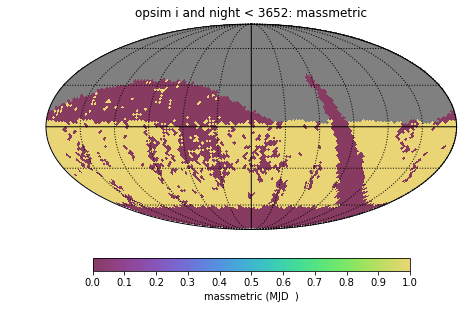

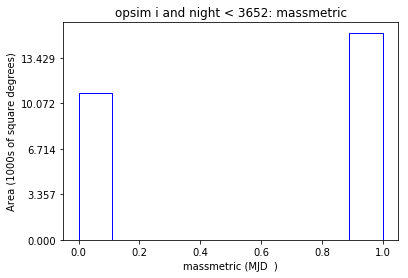

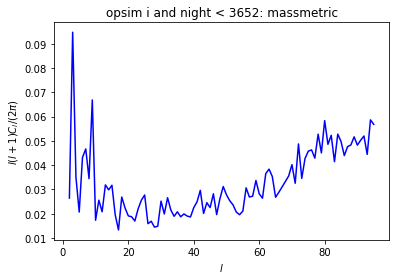

In [70]:
# Run the queries
bg.runAll()

# Create the plots
bg.plotAll(closefigs=False)

In [71]:
#dir = '/data/des40.a/data/marcelle/lsst-gw/OperationsSimulatorBenchmarkSurveys/'
dir = '/users/dagoret/DATA/Cadence/'
#opsdb = db.OpsimDatabase(dir+'astro_lsst_01_1064_sqlite.db')
#opsdb = db.OpsimDatabase(dir+'astro-lsst-01_2039.db')
outDir = 'notebook_output'

astro_lsst_01_1064.sqlite.db is the "hacked" rolling cadence from the SN group and Rahul Biswas.

In [72]:
# Initially let's just look at the number of observations in r-band after 2 years with default kwargs
nyears = 2.
mass = 100.
sql = 'filter="i" and night < %i' % int(365.25*nyears)

In [73]:
# Use the custom metric in the macho metrics file, which asks whether the light curve
# allows a detection of a mass solar_mass lens

detectable = metrics.massMetric(mass=mass)

# Let's look at the metric results in the galactic coordinate fram
#slicer = slicers.HealpixSlicer(latCol='galb', lonCol='gall', nside=32)
slicer = slicers.HealpixSlicer(nside=32)

plotDict_detectable = {'colorMin':0,'colorMax': 1.}
bundle_detectable = metricBundles.MetricBundle(detectable, slicer, sql, plotDict=plotDict_detectable)
# Create the query bundle dictonary to run all of the queries in the same run
bdict = {'detectable':bundle_detectable}
bg = metricBundles.MetricBundleGroup(bdict, opsdb, outDir=outDir)

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes


Querying database SummaryAllProps with constraint filter="i" and night < 730 for columns ['observationStartMJD', 'fieldDec', 'fieldRA']
Found 76659 visits
Running:  ['detectable']
nvisits 1 > 30 False
years 164.86791387811493 164.86791387811493
	 False
	 False
nvisits 4 > 30 False
years 164.2465117752934 164.93184716201486
year min 164.2465117752934 year max 165.2465117752934
nvisits in a year 4 > 10
	 False
	 False
nvisits 1 > 30 False
years 164.86791264227952 164.86791264227952
	 False
	 False
nvisits 10 > 30 False
years 164.15347865490403 165.8271944000811
year min 164.15347865490403 year max 165.15347865490403
nvisits in a year 6 > 10
year min 165.15347865490403 year max 166.15347865490403
nvisits in a year 4 > 10
	 False
	 False
nvisits 8 > 30 False
years 164.83063008593808 165.82720181509367
year min 164.83063008593808 year max 165.83063008593808
nvisits in a year 8 > 10
	 False
	 False
nvisits 6 > 30 False
years 164.92634211727128 164.93458295307627
year min 164.92634211727128 y

nvisits 5 > 30 False
years 164.2465007161508 164.931844690344
year min 164.2465007161508 year max 165.2465007161508
nvisits in a year 5 > 10
	 False
	 False
nvisits 5 > 30 False
years 164.24650933531066 164.93185578117476
year min 164.24650933531066 year max 165.24650933531066
nvisits in a year 5 > 10
	 False
	 False
nvisits 5 > 30 False
years 164.92636062311456 165.16404631530915
year min 164.92636062311456 year max 165.92636062311456
nvisits in a year 5 > 10
	 False
	 False
nvisits 7 > 30 False
years 164.0145051588207 165.28142805536544
year min 164.0145051588207 year max 165.0145051588207
nvisits in a year 3 > 10
year min 165.0145051588207 year max 166.0145051588207
nvisits in a year 4 > 10
	 False
	 False
nvisits 8 > 30 False
years 164.32310603467945 165.2814317628717
year min 164.32310603467945 year max 165.32310603467945
nvisits in a year 8 > 10
	 False
	 False
nvisits 16 > 30 False
years 164.32310112302582 165.16413982685629
year min 164.32310112302582 year max 165.3231011230258

nvisits 13 > 30 False
years 164.76226408218622 165.8217498162091
year min 164.76226408218622 year max 165.76226408218622
nvisits in a year 9 > 10
year min 165.76226408218622 year max 166.76226408218622
nvisits in a year 4 > 10
	 False
	 False
nvisits 12 > 30 False
years 164.15347374325043 165.82174734453824
year min 164.15347374325043 year max 165.15347374325043
nvisits in a year 7 > 10
year min 165.15347374325043 year max 166.15347374325043
nvisits in a year 5 > 10
	 False
	 False
nvisits 11 > 30 False
years 164.1534811265749 165.8217658820696
year min 164.1534811265749 year max 165.1534811265749
nvisits in a year 8 > 10
year min 165.1534811265749 year max 166.1534811265749
nvisits in a year 3 > 10
	 False
	 False
nvisits 10 > 30 False
years 164.83061779096002 165.8272030826172
year min 164.83061779096002 year max 165.83061779096002
nvisits in a year 10 > 10
	 False
	 False
nvisits 25 > 30 False
years 163.8696094443177 165.82719934342282
year min 163.8696094443177 year max 164.8696094

nvisits 6 > 30 False
years 164.08028332319313 165.1615490087966
year min 164.08028332319313 year max 165.08028332319313
nvisits in a year 4 > 10
year min 165.08028332319313 year max 166.08028332319313
nvisits in a year 2 > 10
	 False
	 False
nvisits 2 > 30 False
years 164.8679176173093 164.86791882145664
year min 164.8679176173093 year max 165.8679176173093
nvisits in a year 2 > 10
	 False
	 False
nvisits 14 > 30 False
years 164.77037803888763 165.79978642228815
year min 164.77037803888763 year max 165.77037803888763
nvisits in a year 12 > 10
year min 165.77037803888763 year max 166.77037803888763
nvisits in a year 2 > 10
	 False
	 False
nvisits 14 > 30 False
years 164.76225305473164 165.821651266256
year min 164.76225305473164 year max 165.76225305473164
nvisits in a year 10 > 10
year min 165.76225305473164 year max 166.76225305473164
nvisits in a year 4 > 10
	 False
	 False
nvisits 13 > 30 False
years 164.76224814307804 165.8162055416128
year min 164.76224814307804 year max 165.76224

year min 164.99206400359978 year max 165.99206400359978
nvisits in a year 9 > 10
	 False
	 False
nvisits 9 > 30 False
years 164.32309253555403 165.28145638451593
year min 164.32309253555403 year max 165.32309253555403
nvisits in a year 9 > 10
	 False
	 False
nvisits 8 > 30 False
years 164.32309744720766 165.28146253200498
year min 164.32309744720766 year max 165.32309744720766
nvisits in a year 8 > 10
	 False
	 False
nvisits 8 > 30 False
years 164.32311481227978 165.16413605597384
year min 164.32311481227978 year max 165.32311481227978
nvisits in a year 8 > 10
	 False
	 False
nvisits 7 > 30 False
years 164.3231630732375 165.16141810530587
year min 164.3231630732375 year max 165.3231630732375
nvisits in a year 7 > 10
	 False
	 False
nvisits 9 > 30 False
years 164.32317045656197 165.37714848404187
year min 164.32317045656197 year max 165.32317045656197
nvisits in a year 7 > 10
year min 165.32317045656197 year max 166.32317045656197
nvisits in a year 2 > 10
	 False
	 False
nvisits 10 > 30

nvisits 14 > 30 False
years 164.66918884832813 165.78593153471746
year min 164.66918884832813 year max 165.66918884832813
nvisits in a year 12 > 10
year min 165.66918884832813 year max 166.66918884832813
nvisits in a year 2 > 10
	 False
	 False
nvisits 30 > 30 True
years 164.66919619996452 165.78593400638832
year min 164.66919619996452 year max 165.66919619996452
nvisits in a year 26 > 10
year min 165.66919619996452 year max 166.66919619996452
nvisits in a year 4 > 10
	 False
	 False
nvisits 30 > 30 True
years 164.66919619996452 165.79968308743378
year min 164.66919619996452 year max 165.66919619996452
nvisits in a year 26 > 10
year min 165.66919619996452 year max 166.66919619996452
nvisits in a year 4 > 10
	 False
	 False
nvisits 15 > 30 False
years 164.66919990747078 165.79968308743378
year min 164.66919990747078 year max 165.66919990747078
nvisits in a year 13 > 10
year min 165.66919990747078 year max 166.66919990747078
nvisits in a year 2 > 10
	 False
	 False
nvisits 15 > 30 False


	 False
	 False
nvisits 10 > 30 False
years 164.32352910233985 165.53591242680054
year min 164.32352910233985 year max 165.32352910233985
nvisits in a year 8 > 10
year min 165.32352910233985 year max 166.32352910233985
nvisits in a year 2 > 10
	 False
	 False
nvisits 13 > 30 False
years 164.1980970986387 165.6235131315436
year min 164.1980970986387 year max 165.1980970986387
nvisits in a year 8 > 10
year min 165.1980970986387 year max 166.1980970986387
nvisits in a year 5 > 10
	 False
	 False
nvisits 3 > 30 False
years 164.48023154485765 165.45211603543996
year min 164.48023154485765 year max 165.48023154485765
nvisits in a year 3 > 10
	 False
	 False
nvisits 2 > 30 False
years 164.4802340165285 165.4521010786625
year min 164.4802340165285 year max 165.4802340165285
nvisits in a year 2 > 10
	 False
	 False
nvisits 3 > 30 False
years 164.48023772403477 165.45210595862804
year min 164.48023772403477 year max 165.48023772403477
nvisits in a year 3 > 10
	 False
	 False
nvisits 16 > 30 Fals

nvisits 25 > 30 False
years 164.15346883159683 165.82167585621215
year min 164.15346883159683 year max 165.15346883159683
nvisits in a year 16 > 10
year min 165.15346883159683 year max 166.15346883159683
nvisits in a year 9 > 10
	 False
	 False
nvisits 23 > 30 False
years 164.15345533247142 165.8272373374401
year min 164.15345533247142 year max 165.15345533247142
nvisits in a year 17 > 10
year min 165.15345533247142 year max 166.15345533247142
nvisits in a year 6 > 10
	 False
	 False
nvisits 12 > 30 False
years 163.86955116992422 165.82723362993386
year min 163.86955116992422 year max 164.86955116992422
nvisits in a year 6 > 10
year min 164.86955116992422 year max 165.86955116992422
nvisits in a year 6 > 10
	 False
	 False
nvisits 10 > 30 False
years 163.8695462582706 165.821775768753
year min 163.8695462582706 year max 164.8695462582706
nvisits in a year 6 > 10
year min 164.8695462582706 year max 165.8695462582706
nvisits in a year 4 > 10
	 False
	 False
nvisits 10 > 30 False
years 16

nvisits 23 > 30 False
years 164.15345412832409 165.8272311265749
year min 164.15345412832409 year max 165.15345412832409
nvisits in a year 17 > 10
year min 165.15345412832409 year max 166.15345412832409
nvisits in a year 6 > 10
	 False
	 False
nvisits 24 > 30 False
years 164.15345412832409 165.8272373374401
year min 164.15345412832409 year max 165.15345412832409
nvisits in a year 16 > 10
year min 165.15345412832409 year max 166.15345412832409
nvisits in a year 8 > 10
	 False
	 False
nvisits 23 > 30 False
years 163.86955116992422 165.82723362993386
year min 163.86955116992422 year max 164.86955116992422
nvisits in a year 12 > 10
year min 164.86955116992422 year max 165.86955116992422
nvisits in a year 11 > 10
	 False
	 False
nvisits 9 > 30 False
years 164.15355514994803 165.19383894846248
year min 164.15355514994803 year max 165.15355514994803
nvisits in a year 8 > 10
year min 165.15355514994803 year max 166.15355514994803
nvisits in a year 1 > 10
	 False
	 False
nvisits 7 > 30 False
ye

year min 165.01449777549624 year max 166.01449777549624
nvisits in a year 2 > 10
	 False
	 False
nvisits 9 > 30 False
years 164.01451251045705 165.28144158617891
year min 164.01451251045705 year max 165.01451251045705
nvisits in a year 5 > 10
year min 165.01451251045705 year max 166.01451251045705
nvisits in a year 4 > 10
	 False
	 False
nvisits 8 > 30 False
years 164.32308885973583 165.27871086521154
year min 164.32308885973583 year max 165.32308885973583
nvisits in a year 8 > 10
	 False
	 False
nvisits 10 > 30 False
years 164.9838685134484 165.2815076875301
year min 164.9838685134484 year max 165.9838685134484
nvisits in a year 10 > 10
	 False
	 False
nvisits 10 > 30 False
years 164.32311848809795 165.20519396278553
year min 164.32311848809795 year max 165.32311848809795
nvisits in a year 10 > 10
	 False
	 False
nvisits 19 > 30 False
years 164.32315939741932 165.2815150391665
year min 164.32315939741932 year max 165.32315939741932
nvisits in a year 19 > 10
	 False
	 False
nvisits 20 

nvisits 16 > 30 False
years 164.08027841153955 165.37720923010622
year min 164.08027841153955 year max 165.08027841153955
nvisits in a year 12 > 10
year min 165.08027841153955 year max 166.08027841153955
nvisits in a year 4 > 10
	 False
	 False
nvisits 14 > 30 False
years 164.08029194235303 165.16163180977009
year min 164.08029194235303 year max 165.08029194235303
nvisits in a year 8 > 10
year min 165.08029194235303 year max 166.08029194235303
nvisits in a year 6 > 10
	 False
	 False
nvisits 9 > 30 False
years 164.19770660633256 165.16157603873552
year min 164.19770660633256 year max 165.19770660633256
nvisits in a year 9 > 10
	 False
	 False
nvisits 7 > 30 False
years 164.4818639250133 165.363676388572
year min 164.4818639250133 year max 165.4818639250133
nvisits in a year 7 > 10
	 False
	 False
nvisits 21 > 30 False
years 164.4054753530053 165.5413501343575
year min 164.4054753530053 year max 165.4054753530053
nvisits in a year 18 > 10
year min 165.4054753530053 year max 166.40547535

nvisits 9 > 30 False
years 164.3231581615839 165.2052239080285
year min 164.3231581615839 year max 165.3231581615839
nvisits in a year 9 > 10
	 False
	 False
nvisits 10 > 30 False
years 164.32317536821557 165.20522637969933
year min 164.32317536821557 year max 165.32317536821557
nvisits in a year 10 > 10
	 False
	 False
nvisits 22 > 30 False
years 164.32317413238016 165.37715339569547
year min 164.32317413238016 year max 165.32317413238016
nvisits in a year 18 > 10
year min 165.32317413238016 year max 166.32317413238016
nvisits in a year 4 > 10
	 False
	 False
nvisits 8 > 30 False
years 164.1976929804548 165.3772079942708
year min 164.1976929804548 year max 165.1976929804548
nvisits in a year 6 > 10
year min 165.1976929804548 year max 166.1976929804548
nvisits in a year 2 > 10
	 False
	 False
nvisits 7 > 30 False
years 164.08029314650037 165.16163180977009
year min 164.08029314650037 year max 165.08029314650037
nvisits in a year 4 > 10
year min 165.08029314650037 year max 166.080293146

nvisits 19 > 30 False
years 164.3231581615839 165.27871584024135
year min 164.3231581615839 year max 165.3231581615839
nvisits in a year 19 > 10
	 False
	 False
nvisits 12 > 30 False
years 164.39420798793319 165.37715339569547
year min 164.39420798793319 year max 165.39420798793319
nvisits in a year 12 > 10
	 False
	 False
nvisits 12 > 30 False
years 164.23590694476133 165.3771583073491
year min 164.23590694476133 year max 165.23590694476133
nvisits in a year 10 > 10
year min 165.23590694476133 year max 166.23590694476133
nvisits in a year 2 > 10
	 False
	 False
nvisits 9 > 30 False
years 164.23588973812963 165.3771361890638
year min 164.23588973812963 year max 165.23588973812963
nvisits in a year 7 > 10
year min 165.23588973812963 year max 166.23588973812963
nvisits in a year 2 > 10
	 False
	 False
nvisits 8 > 30 False
years 164.23588729814688 165.37720675843536
year min 164.23588729814688 year max 165.23588729814688
nvisits in a year 6 > 10
year min 165.23588729814688 year max 166.23

nvisits 10 > 30 False
years 164.01441354855882 165.13116751590744
year min 164.01441354855882 year max 165.01441354855882
nvisits in a year 8 > 10
year min 165.01441354855882 year max 166.01441354855882
nvisits in a year 2 > 10
	 False
	 False
nvisits 15 > 30 False
years 164.01444061018583 165.011108544376
year min 164.01444061018583 year max 165.01444061018583
nvisits in a year 15 > 10
	 False
	 False
nvisits 15 > 30 False
years 164.01449409967805 165.09313651861993
year min 164.01449409967805 year max 165.01449409967805
nvisits in a year 13 > 10
year min 165.01449409967805 year max 166.01449409967805
nvisits in a year 2 > 10
	 False
	 False
nvisits 17 > 30 False
years 164.0144965713489 165.2814403503435
year min 164.0144965713489 year max 165.0144965713489
nvisits in a year 11 > 10
year min 165.0144965713489 year max 166.0144965713489
nvisits in a year 6 > 10
	 False
	 False
nvisits 19 > 30 False
years 164.0145137462925 165.27874832053135
year min 164.0145137462925 year max 165.01451

nvisits 3 > 30 False
years 164.48021924987958 165.45211353208103
year min 164.48021924987958 year max 165.48021924987958
nvisits in a year 3 > 10
	 False
	 False
nvisits 31 > 30 True
years 163.87420773442847 165.73934164828756
year min 163.87420773442847 year max 164.87420773442847
nvisits in a year 20 > 10
year min 164.87420773442847 year max 165.87420773442847
nvisits in a year 11 > 10
	 True
	 False
nvisits 16 > 30 False
years 163.87421267777017 165.84868646538393
year min 163.87421267777017 year max 164.87421267777017
nvisits in a year 10 > 10
year min 164.87421267777017 year max 165.87421267777017
nvisits in a year 6 > 10
	 False
	 False
nvisits 17 > 30 False
years 163.8742138819175 165.73935150328288
year min 163.8742138819175 year max 164.8742138819175
nvisits in a year 11 > 10
year min 164.8742138819175 year max 165.8742138819175
nvisits in a year 6 > 10
	 False
	 False
nvisits 19 > 30 False
years 163.87421758942378 165.84869147210182
year min 163.87421758942378 year max 164.87

year min 164.1924165335767 year max 165.1924165335767
nvisits in a year 16 > 10
year min 165.1924165335767 year max 166.1924165335767
nvisits in a year 7 > 10
	 False
	 False
nvisits 24 > 30 False
years 164.39723277435547 165.62352064162042
year min 164.39723277435547 year max 165.39723277435547
nvisits in a year 17 > 10
year min 165.39723277435547 year max 166.39723277435547
nvisits in a year 7 > 10
	 False
	 False
nvisits 28 > 30 False
years 164.4054716771871 165.6235658605217
year min 164.4054716771871 year max 165.4054716771871
nvisits in a year 15 > 10
year min 165.4054716771871 year max 166.4054716771871
nvisits in a year 13 > 10
	 False
	 False
nvisits 30 > 30 True
years 164.40548029634698 165.6235645929982
year min 164.40548029634698 year max 165.40548029634698
nvisits in a year 16 > 10
year min 165.40548029634698 year max 166.40548029634698
nvisits in a year 14 > 10
	 True
	 False
nvisits 17 > 30 False
years 164.17070955966233 165.62087465459985
year min 164.17070955966233 yea

nvisits in a year 8 > 10
year min 165.1536382044262 year max 166.1536382044262
nvisits in a year 1 > 10
	 False
	 False
nvisits 10 > 30 False
years 164.01440492939895 165.19951377798057
year min 164.01440492939895 year max 165.01440492939895
nvisits in a year 8 > 10
year min 165.01440492939895 year max 166.01440492939895
nvisits in a year 2 > 10
	 False
	 False
nvisits 9 > 30 False
years 164.014411076888 165.0411134877177
year min 164.014411076888 year max 165.014411076888
nvisits in a year 8 > 10
year min 165.014411076888 year max 166.014411076888
nvisits in a year 1 > 10
	 False
	 False
nvisits 11 > 30 False
years 164.01441846021243 165.19949650797273
year min 164.01441846021243 year max 165.01441846021243
nvisits in a year 7 > 10
year min 165.01441846021243 year max 166.01441846021243
nvisits in a year 4 > 10
	 False
	 False
nvisits 17 > 30 False
years 164.01444184602124 165.19948658960124
year min 164.01444184602124 year max 165.01444184602124
nvisits in a year 15 > 10
year min 165

nvisits 32 > 30 True
years 163.87419166856796 165.81575138793826
year min 163.87419166856796 year max 164.87419166856796
nvisits in a year 24 > 10
year min 164.87419166856796 year max 165.87419166856796
nvisits in a year 8 > 10
	 False
	 False
nvisits 20 > 30 False
years 163.87419661190967 165.79401038101756
year min 163.87419661190967 year max 164.87419661190967
nvisits in a year 16 > 10
year min 164.87419661190967 year max 165.87419661190967
nvisits in a year 4 > 10
	 False
	 False
nvisits 18 > 30 False
years 163.87419787943318 165.73933426496313
year min 163.87419787943318 year max 164.87419787943318
nvisits in a year 16 > 10
year min 164.87419787943318 year max 165.87419787943318
nvisits in a year 2 > 10
	 False
	 False
nvisits 23 > 30 False
years 164.6171263023804 165.81576507719217
year min 164.6171263023804 year max 165.6171263023804
nvisits in a year 15 > 10
year min 165.6171263023804 year max 166.6171263023804
nvisits in a year 8 > 10
	 False
	 False
nvisits 36 > 30 True
years

year min 164.406315309149 year max 165.406315309149
nvisits in a year 19 > 10
year min 165.406315309149 year max 166.406315309149
nvisits in a year 24 > 10
	 True
	 False
nvisits 40 > 30 True
years 164.40631778081985 165.793281618374
year min 164.40631778081985 year max 165.40631778081985
nvisits in a year 18 > 10
year min 165.40631778081985 year max 166.40631778081985
nvisits in a year 22 > 10
	 True
	 False
nvisits 8 > 30 False
years 164.48000576723197 165.79059288412301
year min 164.48000576723197 year max 165.48000576723197
nvisits in a year 5 > 10
year min 165.48000576723197 year max 166.48000576723197
nvisits in a year 3 > 10
	 False
	 False
nvisits 3 > 30 False
years 164.48021554237332 165.6486732514513
year min 164.48021554237332 year max 165.48021554237332
nvisits in a year 2 > 10
year min 165.48021554237332 year max 166.48021554237332
nvisits in a year 1 > 10
	 False
	 False
nvisits 29 > 30 False
years 164.4446496881892 165.7907281288818
year min 164.4446496881892 year max 16

nvisits 53 > 30 True
years 164.0145955966233 165.31695328542094
year min 164.0145955966233 year max 165.0145955966233
nvisits in a year 22 > 10
year min 165.0145955966233 year max 166.0145955966233
nvisits in a year 31 > 10
	 True
	 False
nvisits 48 > 30 True
years 164.07467212335538 165.31695829213882
year min 164.07467212335538 year max 165.07467212335538
nvisits in a year 20 > 10
year min 165.07467212335538 year max 166.07467212335538
nvisits in a year 28 > 10
	 True
	 False
nvisits 28 > 30 False
years 164.07473343980533 165.29238484548887
year min 164.07473343980533 year max 165.07473343980533
nvisits in a year 9 > 10
year min 165.07473343980533 year max 166.07473343980533
nvisits in a year 19 > 10
	 False
	 False
nvisits 58 > 30 True
years 164.1539268512181 165.35798951758056
year min 164.1539268512181 year max 165.1539268512181
nvisits in a year 22 > 10
year min 165.1539268512181 year max 166.1539268512181
nvisits in a year 36 > 10
	 True
	 False
nvisits 54 > 30 True
years 164.15

nvisits 51 > 30 True
years 163.8743119565493 165.80187251248512
year min 163.8743119565493 year max 164.8743119565493
nvisits in a year 22 > 10
year min 164.8743119565493 year max 165.8743119565493
nvisits in a year 29 > 10
	 True
	 False
nvisits 49 > 30 True
years 163.87431442822015 165.8183228128882
year min 163.87431442822015 year max 164.87431442822015
nvisits in a year 24 > 10
year min 164.87431442822015 year max 165.87431442822015
nvisits in a year 25 > 10
	 True
	 False
nvisits 51 > 30 True
years 163.87431813572644 165.81832528455902
year min 163.87431813572644 year max 164.87431813572644
nvisits in a year 22 > 10
year min 164.87431813572644 year max 165.87431813572644
nvisits in a year 29 > 10
	 True
	 False
nvisits 50 > 30 True
years 163.8742399612138 165.81832775622988
year min 163.8742399612138 year max 164.8742399612138
nvisits in a year 20 > 10
year min 164.8742399612138 year max 165.8742399612138
nvisits in a year 30 > 10
	 True
	 False
nvisits 18 > 30 False
years 164.685

year min 165.15696878089588 year max 166.15696878089588
nvisits in a year 30 > 10
	 True
	 False
nvisits 54 > 30 True
years 164.19242280781808 165.53589125915786
year min 164.19242280781808 year max 165.19242280781808
nvisits in a year 28 > 10
year min 165.19242280781808 year max 166.19242280781808
nvisits in a year 26 > 10
	 True
	 False
nvisits 55 > 30 True
years 164.39171945902095 165.53590621593528
year min 164.39171945902095 year max 165.39171945902095
nvisits in a year 35 > 10
year min 165.39171945902095 year max 166.39171945902095
nvisits in a year 20 > 10
	 True
	 False
nvisits 50 > 30 True
years 164.1706984688316 165.54135754937002
year min 164.1706984688316 year max 165.1706984688316
nvisits in a year 22 > 10
year min 165.1706984688316 year max 166.1706984688316
nvisits in a year 28 > 10
	 True
	 False
nvisits 26 > 30 False
years 164.17070711967958 165.54136005272898
year min 164.17070711967958 year max 165.17070711967958
nvisits in a year 13 > 10
year min 165.17070711967958 

nvisits 47 > 30 True
years 164.61721163840087 165.82148604456611
year min 164.61721163840087 year max 165.61721163840087
nvisits in a year 34 > 10
year min 165.61721163840087 year max 166.61721163840087
nvisits in a year 13 > 10
	 True
	 False
nvisits 46 > 30 True
years 164.61721411007173 165.84868402540116
year min 164.61721411007173 year max 165.61721411007173
nvisits in a year 30 > 10
year min 165.61721411007173 year max 166.61721411007173
nvisits in a year 16 > 10
	 True
	 False
nvisits 48 > 30 True
years 163.9074880535909 165.84870142216138
year min 163.9074880535909 year max 164.9074880535909
nvisits in a year 14 > 10
year min 164.9074880535909 year max 165.9074880535909
nvisits in a year 34 > 10
	 True
	 False
nvisits 25 > 30 False
years 163.9074880535909 165.84870142216138
year min 163.9074880535909 year max 164.9074880535909
nvisits in a year 7 > 10
year min 164.9074880535909 year max 165.9074880535909
nvisits in a year 18 > 10
	 False
	 False
nvisits 20 > 30 False
years 164.6

nvisits in a year 34 > 10
	 True
	 False
nvisits 30 > 30 True
years 164.18720105457956 165.55775417015235
year min 164.18720105457956 year max 165.18720105457956
nvisits in a year 14 > 10
year min 165.18720105457956 year max 166.18720105457956
nvisits in a year 16 > 10
	 True
	 False
nvisits 62 > 30 True
years 164.19264063173372 165.5659977945091
year min 164.19264063173372 year max 165.19264063173372
nvisits in a year 24 > 10
year min 165.19264063173372 year max 166.19264063173372
nvisits in a year 38 > 10
	 True
	 False
nvisits 30 > 30 True
years 164.27728277815802 165.54155626536874
year min 164.27728277815802 year max 165.27728277815802
nvisits in a year 11 > 10
year min 165.27728277815802 year max 166.27728277815802
nvisits in a year 19 > 10
	 True
	 False
nvisits 35 > 30 True
years 164.32101864527087 165.6207876074226
year min 164.32101864527087 year max 165.32101864527087
nvisits in a year 11 > 10
year min 165.32101864527087 year max 166.32101864527087
nvisits in a year 24 > 10


nvisits in a year 10 > 10
year min 164.9398676071691 year max 165.9398676071691
nvisits in a year 11 > 10
	 False
	 False
nvisits 20 > 30 False
years 163.93987131467537 165.81575262377368
year min 163.93987131467537 year max 164.93987131467537
nvisits in a year 8 > 10
year min 164.93987131467537 year max 165.93987131467537
nvisits in a year 12 > 10
	 False
	 False
nvisits 42 > 30 True
years 163.93987131467537 165.81575262377368
year min 163.93987131467537 year max 164.93987131467537
nvisits in a year 18 > 10
year min 164.93987131467537 year max 165.93987131467537
nvisits in a year 24 > 10
	 True
	 False
nvisits 43 > 30 True
years 163.9400000316881 165.79395511699244
year min 163.9400000316881 year max 164.9400000316881
nvisits in a year 23 > 10
year min 164.9400000316881 year max 165.9400000316881
nvisits in a year 20 > 10
	 True
	 False
nvisits 47 > 30 True
years 164.61712383070957 165.81576387304483
year min 164.61712383070957 year max 165.61712383070957
nvisits in a year 31 > 10
yea

years 164.08030182903644 165.37729985803736
year min 164.08030182903644 year max 165.08030182903644
nvisits in a year 31 > 10
year min 165.08030182903644 year max 166.08030182903644
nvisits in a year 28 > 10
	 True
	 False
nvisits 25 > 30 False
years 164.15687495246786 165.37728740461887
year min 164.15687495246786 year max 165.15687495246786
nvisits in a year 13 > 10
year min 165.15687495246786 year max 166.15687495246786
nvisits in a year 12 > 10
	 False
	 False
nvisits 24 > 30 False
years 164.1568712449616 165.37729111212514
year min 164.1568712449616 year max 165.1568712449616
nvisits in a year 11 > 10
year min 165.1568712449616 year max 166.1568712449616
nvisits in a year 13 > 10
	 False
	 False
nvisits 28 > 30 False
years 164.1569539508708 165.54134509595153
year min 164.1569539508708 year max 165.1569539508708
nvisits in a year 14 > 10
year min 165.1569539508708 year max 166.1569539508708
nvisits in a year 14 > 10
	 False
	 False
nvisits 57 > 30 True
years 164.1870631480214 165.

year min 164.8743156640556 year max 165.8743156640556
nvisits in a year 15 > 10
	 False
	 False
nvisits 28 > 30 False
years 163.87423872537835 165.79108854919258
year min 163.87423872537835 year max 164.87423872537835
nvisits in a year 15 > 10
year min 164.87423872537835 year max 165.87423872537835
nvisits in a year 13 > 10
	 False
	 False
nvisits 28 > 30 False
years 163.8742906621543 165.8183289920653
year min 163.8742906621543 year max 164.8742906621543
nvisits in a year 15 > 10
year min 164.8742906621543 year max 165.8742906621543
nvisits in a year 13 > 10
	 False
	 False
nvisits 24 > 30 False
years 163.8742263670241 165.79393274520243
year min 163.8742263670241 year max 164.8742263670241
nvisits in a year 10 > 10
year min 164.8742263670241 year max 165.8742263670241
nvisits in a year 14 > 10
	 False
	 False
nvisits 49 > 30 True
years 163.8742251311887 165.79393892437955
year min 163.8742251311887 year max 164.8742251311887
nvisits in a year 17 > 10
year min 164.8742251311887 year m

year min 165.0803055048546 year max 166.0803055048546
nvisits in a year 30 > 10
	 True
	 False
nvisits 55 > 30 True
years 164.15687495246786 165.37729862220195
year min 164.15687495246786 year max 165.15687495246786
nvisits in a year 29 > 10
year min 165.15687495246786 year max 166.15687495246786
nvisits in a year 26 > 10
	 True
	 False
nvisits 49 > 30 True
years 164.1568712449616 165.37729234796055
year min 164.1568712449616 year max 165.1568712449616
nvisits in a year 23 > 10
year min 165.1568712449616 year max 166.1568712449616
nvisits in a year 26 > 10
	 True
	 False
nvisits 25 > 30 False
years 164.15687000912615 165.541343828428
year min 164.15687000912615 year max 165.15687000912615
nvisits in a year 11 > 10
year min 165.15687000912615 year max 166.15687000912615
nvisits in a year 14 > 10
	 False
	 False
nvisits 28 > 30 False
years 164.15695518670623 165.53587021826755
year min 164.15695518670623 year max 165.15695518670623
nvisits in a year 12 > 10
year min 165.15695518670623 ye

	 False
nvisits 21 > 30 False
years 163.9398725188227 165.79394389940933
year min 163.9398725188227 year max 164.9398725188227
nvisits in a year 10 > 10
year min 164.9398725188227 year max 165.9398725188227
nvisits in a year 11 > 10
	 False
	 False
nvisits 23 > 30 False
years 163.93988500392933 165.8157538596091
year min 163.93988500392933 year max 164.93988500392933
nvisits in a year 10 > 10
year min 164.93988500392933 year max 165.93988500392933
nvisits in a year 13 > 10
	 False
	 False
nvisits 25 > 30 False
years 163.93999876416459 165.81574771212007
year min 163.93999876416459 year max 164.93999876416459
nvisits in a year 10 > 10
year min 164.93999876416459 year max 165.93999876416459
nvisits in a year 15 > 10
	 False
	 False
nvisits 22 > 30 False
years 163.94000123583544 165.8157613696859
year min 163.94000123583544 year max 164.94000123583544
nvisits in a year 12 > 10
year min 164.94000123583544 year max 165.94000123583544
nvisits in a year 10 > 10
	 False
	 False
nvisits 48 > 30

nvisits in a year 14 > 10
year min 165.17070090881435 year max 166.17070090881435
nvisits in a year 15 > 10
	 False
	 False
nvisits 26 > 30 False
years 164.17070464800872 165.5413674994296
year min 164.17070464800872 year max 165.17070464800872
nvisits in a year 14 > 10
year min 165.17070464800872 year max 166.17070464800872
nvisits in a year 12 > 10
	 False
	 False
nvisits 29 > 30 False
years 164.18713263999797 165.55774919512257
year min 164.18713263999797 year max 165.18713263999797
nvisits in a year 17 > 10
year min 165.18713263999797 year max 166.18713263999797
nvisits in a year 12 > 10
	 False
	 False
nvisits 33 > 30 True
years 164.18714002332243 165.5660128780389
year min 164.18714002332243 year max 165.18714002332243
nvisits in a year 17 > 10
year min 165.18714002332243 year max 166.18714002332243
nvisits in a year 16 > 10
	 True
	 False
nvisits 32 > 30 True
years 164.18719981874415 165.56599655867367
year min 164.18719981874415 year max 165.18719981874415
nvisits in a year 12 

nvisits 24 > 30 False
years 164.66640669759425 165.84873894085734
year min 164.66640669759425 year max 165.66640669759425
nvisits in a year 15 > 10
year min 165.66640669759425 year max 166.66640669759425
nvisits in a year 9 > 10
	 False
	 False
nvisits 50 > 30 True
years 164.66636816487946 165.84881103125713
year min 164.66636816487946 year max 165.66636816487946
nvisits in a year 38 > 10
year min 165.66636816487946 year max 166.66636816487946
nvisits in a year 12 > 10
	 True
	 False
nvisits 46 > 30 True
years 164.66635938727913 165.7940571526352
year min 164.66635938727913 year max 165.66635938727913
nvisits in a year 38 > 10
year min 165.66635938727913 year max 166.66635938727913
nvisits in a year 8 > 10
	 False
	 False
nvisits 51 > 30 True
years 164.61722149339622 165.84866735746698
year min 164.61722149339622 year max 165.61722149339622
nvisits in a year 37 > 10
year min 165.61722149339622 year max 166.61722149339622
nvisits in a year 14 > 10
	 True
	 False
nvisits 47 > 30 True
yea

nvisits 27 > 30 False
years 164.18706435216873 165.53589373082872
year min 164.18706435216873 year max 165.18706435216873
nvisits in a year 13 > 10
year min 165.18706435216873 year max 166.18706435216873
nvisits in a year 14 > 10
	 False
	 False
nvisits 26 > 30 False
years 164.17069723299616 165.53590254011712
year min 164.17069723299616 year max 165.17069723299616
nvisits in a year 11 > 10
year min 165.17069723299616 year max 166.17069723299616
nvisits in a year 15 > 10
	 False
	 False
nvisits 63 > 30 True
years 164.18713140416253 165.5660128780389
year min 164.18713140416253 year max 165.18713140416253
nvisits in a year 35 > 10
year min 165.18713140416253 year max 166.18713140416253
nvisits in a year 28 > 10
	 True
	 False
nvisits 28 > 30 False
years 164.18714129084594 165.56599529115016
year min 164.18714129084594 year max 165.18714129084594
nvisits in a year 14 > 10
year min 165.18714129084594 year max 166.18714129084594
nvisits in a year 14 > 10
	 False
	 False
nvisits 66 > 30 Tru

nvisits 43 > 30 True
years 163.93999131746395 165.81574771212007
year min 163.93999131746395 year max 164.93999131746395
nvisits in a year 19 > 10
year min 164.93999131746395 year max 165.93999131746395
nvisits in a year 24 > 10
	 True
	 False
nvisits 42 > 30 True
years 163.93999752832914 165.8157613696859
year min 163.93999752832914 year max 164.93999752832914
nvisits in a year 22 > 10
year min 164.93999752832914 year max 165.93999752832914
nvisits in a year 20 > 10
	 True
	 False
nvisits 44 > 30 True
years 163.94000250335895 165.81576884807464
year min 163.94000250335895 year max 164.94000250335895
nvisits in a year 19 > 10
year min 164.94000250335895 year max 165.94000250335895
nvisits in a year 25 > 10
	 True
	 False
nvisits 47 > 30 True
years 163.94000998174766 165.8487401766928
year min 163.94000998174766 year max 164.94000998174766
nvisits in a year 18 > 10
year min 164.94000998174766 year max 165.94000998174766
nvisits in a year 29 > 10
	 True
	 False
nvisits 51 > 30 True
years

nvisits in a year 26 > 10
	 True
	 False
nvisits 27 > 30 False
years 164.17069599716075 165.5331903566811
year min 164.17069599716075 year max 165.17069599716075
nvisits in a year 12 > 10
year min 165.17069599716075 year max 166.17069599716075
nvisits in a year 15 > 10
	 False
	 False
nvisits 29 > 30 False
years 164.1707021446498 165.54136876695313
year min 164.1707021446498 year max 165.1707021446498
nvisits in a year 12 > 10
year min 165.1707021446498 year max 166.1707021446498
nvisits in a year 17 > 10
	 False
	 False
nvisits 27 > 30 False
years 164.1871276649682 165.55774795928716
year min 164.1871276649682 year max 165.1871276649682
nvisits in a year 13 > 10
year min 165.1871276649682 year max 166.1871276649682
nvisits in a year 14 > 10
	 False
	 False
nvisits 30 > 30 True
years 164.18713140416253 165.5577566735113
year min 164.18713140416253 year max 165.18713140416253
nvisits in a year 18 > 10
year min 165.18713140416253 year max 166.18713140416253
nvisits in a year 12 > 10
	 Tr

years 163.94000250335895 165.81576884807464
year min 163.94000250335895 year max 164.94000250335895
nvisits in a year 9 > 10
year min 164.94000250335895 year max 165.94000250335895
nvisits in a year 11 > 10
	 False
	 False
nvisits 22 > 30 False
years 163.94001121758308 165.79399919512255
year min 163.94001121758308 year max 164.94001121758308
nvisits in a year 10 > 10
year min 164.94001121758308 year max 165.94001121758308
nvisits in a year 12 > 10
	 False
	 False
nvisits 46 > 30 True
years 163.94001121758308 165.84873894085734
year min 163.94001121758308 year max 164.94001121758308
nvisits in a year 17 > 10
year min 164.94001121758308 year max 165.94001121758308
nvisits in a year 29 > 10
	 True
	 False
nvisits 51 > 30 True
years 164.6172227609197 165.8488706682384
year min 164.6172227609197 year max 165.6172227609197
nvisits in a year 35 > 10
year min 165.6172227609197 year max 166.6172227609197
nvisits in a year 16 > 10
	 True
	 False
nvisits 25 > 30 False
years 164.61723157020813 16

nvisits 28 > 30 False
years 164.36509601490607 165.60465067051993
year min 164.36509601490607 year max 165.36509601490607
nvisits in a year 15 > 10
year min 165.36509601490607 year max 166.36509601490607
nvisits in a year 13 > 10
	 False
	 False
nvisits 30 > 30 True
years 164.36509975410044 165.60465688138515
year min 164.36509975410044 year max 165.36509975410044
nvisits in a year 13 > 10
year min 165.36509975410044 year max 166.36509975410044
nvisits in a year 17 > 10
	 True
	 False
nvisits 37 > 30 True
years 164.36510840494842 165.62659590716657
year min 164.36510840494842 year max 165.36510840494842
nvisits in a year 20 > 10
year min 165.36510840494842 year max 166.36510840494842
nvisits in a year 17 > 10
	 True
	 False
nvisits 68 > 30 True
years 164.40073224833318 165.62661970492053
year min 164.40073224833318 year max 165.40073224833318
nvisits in a year 37 > 10
year min 165.40073224833318 year max 166.40073224833318
nvisits in a year 31 > 10
	 True
	 False
nvisits 74 > 30 True
y

nvisits in a year 9 > 10
	 False
	 False
nvisits 53 > 30 True
years 163.92436981899763 165.28417427180773
year min 163.92436981899763 year max 164.92436981899763
nvisits in a year 20 > 10
year min 164.92436981899763 year max 165.92436981899763
nvisits in a year 33 > 10
	 True
	 False
nvisits 29 > 30 False
years 163.94070122569522 165.27593907648236
year min 163.94070122569522 year max 164.94070122569522
nvisits in a year 14 > 10
year min 164.94070122569522 year max 165.94070122569522
nvisits in a year 15 > 10
	 False
	 False
nvisits 28 > 30 False
years 164.01453114305272 165.28414492863843
year min 164.01453114305272 year max 165.01453114305272
nvisits in a year 12 > 10
year min 165.01453114305272 year max 166.01453114305272
nvisits in a year 16 > 10
	 False
	 False
nvisits 30 > 30 True
years 164.0145881499227 165.29237470530077
year min 164.0145881499227 year max 165.0145881499227
nvisits in a year 12 > 10
year min 165.0145881499227 year max 166.0145881499227
nvisits in a year 18 > 10

year min 165.35694415925167 year max 166.35694415925167
nvisits in a year 22 > 10
	 True
	 False
nvisits 42 > 30 True
years 164.4005848353487 165.7933695528177
year min 164.4005848353487 year max 165.4005848353487
nvisits in a year 18 > 10
year min 165.4005848353487 year max 166.4005848353487
nvisits in a year 24 > 10
	 True
	 False
nvisits 42 > 30 True
years 164.40065439070145 165.79326403148528
year min 164.40065439070145 year max 165.40065439070145
nvisits in a year 24 > 10
year min 165.40065439070145 year max 166.40065439070145
nvisits in a year 18 > 10
	 True
	 False
nvisits 85 > 30 True
years 164.40065315486603 165.7932753758207
year min 164.40065315486603 year max 165.40065315486603
nvisits in a year 43 > 10
year min 165.40065315486603 year max 166.40065315486603
nvisits in a year 42 > 10
	 True
	 False
nvisits 3 > 30 False
years 164.4800119780972 165.48480933277563
year min 164.4800119780972 year max 165.4800119780972
nvisits in a year 2 > 10
year min 165.4800119780972 year max

nvisits 22 > 30 False
years 164.844268543869 165.84886708748448
year min 164.844268543869 year max 165.844268543869
nvisits in a year 21 > 10
year min 165.844268543869 year max 166.844268543869
nvisits in a year 1 > 10
	 False
	 False
nvisits 15 > 30 False
years 164.89333621694934 165.13371913580247
year min 164.89333621694934 year max 165.89333621694934
nvisits in a year 15 > 10
	 False
	 False
nvisits 16 > 30 False
years 163.86943636398206 165.13370801328367
year min 163.86943636398206 year max 164.86943636398206
nvisits in a year 4 > 10
year min 164.86943636398206 year max 165.86943636398206
nvisits in a year 12 > 10
	 False
	 False
nvisits 19 > 30 False
years 163.86944498314193 165.82173406722944
year min 163.86944498314193 year max 164.86944498314193
nvisits in a year 5 > 10
year min 164.86944498314193 year max 165.86944498314193
nvisits in a year 14 > 10
	 False
	 False
nvisits 18 > 30 False
years 163.86951390473294 165.8217848632342
year min 163.86951390473294 year max 164.86951

nvisits 25 > 30 False
years 163.93977564833827 165.8183648629807
year min 163.93977564833827 year max 164.93977564833827
nvisits in a year 7 > 10
year min 164.93977564833827 year max 165.93977564833827
nvisits in a year 18 > 10
	 False
	 False
nvisits 21 > 30 False
years 163.93977311329127 165.8183711372221
year min 163.93977311329127 year max 164.93977311329127
nvisits in a year 3 > 10
year min 164.93977311329127 year max 165.93977311329127
nvisits in a year 18 > 10
	 False
	 False
nvisits 23 > 30 False
years 163.93988129642304 165.79392903769616
year min 163.93988129642304 year max 164.93988129642304
nvisits in a year 8 > 10
year min 164.93988129642304 year max 165.93988129642304
nvisits in a year 15 > 10
	 False
	 False
nvisits 40 > 30 True
years 163.93997883235735 165.8157551271326
year min 163.93997883235735 year max 164.93997883235735
nvisits in a year 14 > 10
year min 164.93997883235735 year max 165.93997883235735
nvisits in a year 26 > 10
	 True
	 False
nvisits 45 > 30 True
yea

nvisits in a year 7 > 10
year min 165.261141753492 year max 166.261141753492
nvisits in a year 20 > 10
	 False
	 False
nvisits 28 > 30 False
years 164.27486805080235 165.62365886505944
year min 164.27486805080235 year max 165.27486805080235
nvisits in a year 13 > 10
year min 165.27486805080235 year max 166.27486805080235
nvisits in a year 15 > 10
	 False
	 False
nvisits 28 > 30 False
years 164.3650823573402 165.52812815296474
year min 164.3650823573402 year max 165.3650823573402
nvisits in a year 16 > 10
year min 165.3650823573402 year max 166.3650823573402
nvisits in a year 12 > 10
	 False
	 False
nvisits 36 > 30 True
years 164.36510596496564 165.62659834714935
year min 164.36510596496564 year max 165.36510596496564
nvisits in a year 17 > 10
year min 165.36510596496564 year max 166.36510596496564
nvisits in a year 19 > 10
	 True
	 False
nvisits 33 > 30 True
years 164.40074726848684 165.6046767815043
year min 164.40074726848684 year max 165.40074726848684
nvisits in a year 18 > 10
year

nvisits 24 > 30 False
years 163.86941025299768 165.84897774228713
year min 163.86941025299768 year max 164.86941025299768
nvisits in a year 6 > 10
year min 164.86941025299768 year max 165.86941025299768
nvisits in a year 18 > 10
	 False
	 False
nvisits 18 > 30 False
years 163.90771097928868 165.7998804091566
year min 163.90771097928868 year max 164.90771097928868
nvisits in a year 7 > 10
year min 164.90771097928868 year max 165.90771097928868
nvisits in a year 11 > 10
	 False
	 False
nvisits 33 > 30 True
years 163.8694313255761 165.7998804091566
year min 163.8694313255761 year max 164.8694313255761
nvisits in a year 5 > 10
year min 164.8694313255761 year max 165.8694313255761
nvisits in a year 28 > 10
	 False
	 False
nvisits 15 > 30 False
years 163.8694313255761 165.13375789033387
year min 163.8694313255761 year max 164.8694313255761
nvisits in a year 2 > 10
year min 164.8694313255761 year max 165.8694313255761
nvisits in a year 13 > 10
	 False
	 False
nvisits 33 > 30 True
years 163.86

nvisits in a year 32 > 10
	 True
	 False
nvisits 33 > 30 True
years 164.50495753796233 165.8182440046138
year min 164.50495753796233 year max 165.50495753796233
nvisits in a year 14 > 10
year min 165.50495753796233 year max 166.50495753796233
nvisits in a year 19 > 10
	 True
	 False
nvisits 31 > 30 True
years 164.50494007782595 165.85106221639163
year min 164.50494007782595 year max 165.50494007782595
nvisits in a year 13 > 10
year min 165.50494007782595 year max 166.50494007782595
nvisits in a year 18 > 10
	 True
	 False
nvisits 31 > 30 True
years 164.50494381702032 165.85106842725682
year min 164.50494381702032 year max 165.50494381702032
nvisits in a year 13 > 10
year min 165.50494381702032 year max 166.50494381702032
nvisits in a year 18 > 10
	 True
	 False
nvisits 50 > 30 True
years 163.87423501787208 165.8183414771719
year min 163.87423501787208 year max 164.87423501787208
nvisits in a year 28 > 10
year min 164.87423501787208 year max 165.87423501787208
nvisits in a year 22 > 10


nvisits 29 > 30 False
years 164.1703962595381 165.35802678277182
year min 164.1703962595381 year max 165.1703962595381
nvisits in a year 23 > 10
year min 165.1703962595381 year max 166.1703962595381
nvisits in a year 6 > 10
	 False
	 False
nvisits 32 > 30 True
years 164.08310134484245 165.37731389586025
year min 164.08310134484245 year max 165.08310134484245
nvisits in a year 15 > 10
year min 165.08310134484245 year max 166.08310134484245
nvisits in a year 17 > 10
	 True
	 False
nvisits 32 > 30 True
years 164.0803104798844 165.36372693107208
year min 164.0803104798844 year max 165.0803104798844
nvisits in a year 10 > 10
year min 165.0803104798844 year max 166.0803104798844
nvisits in a year 22 > 10
	 True
	 False
nvisits 33 > 30 True
years 164.1569321177783 165.37738785585722
year min 164.1569321177783 year max 165.1569321177783
nvisits in a year 18 > 10
year min 165.1569321177783 year max 166.1569321177783
nvisits in a year 15 > 10
	 True
	 False
nvisits 30 > 30 True
years 164.1569295

year min 164.48286514183587 year max 165.48286514183587
nvisits in a year 10 > 10
year min 165.48286514183587 year max 166.48286514183587
nvisits in a year 23 > 10
	 True
	 False
nvisits 31 > 30 True
years 164.44465713488987 165.85084892387255
year min 164.44465713488987 year max 165.44465713488987
nvisits in a year 8 > 10
year min 165.44465713488987 year max 166.44465713488987
nvisits in a year 23 > 10
	 False
	 False
nvisits 25 > 30 False
years 164.48288523208356 165.83994527467235
year min 164.48288523208356 year max 165.48288523208356
nvisits in a year 17 > 10
year min 165.48288523208356 year max 166.48288523208356
nvisits in a year 8 > 10
	 False
	 False
nvisits 23 > 30 False
years 164.50484041878977 165.85105058686338
year min 164.50484041878977 year max 165.50484041878977
nvisits in a year 15 > 10
year min 165.50484041878977 year max 166.50484041878977
nvisits in a year 8 > 10
	 False
	 False
nvisits 61 > 30 True
years 164.5049313636018 165.85106221639163
year min 164.5049313636

nvisits 58 > 30 True
years 164.15696136588332 165.54133134332142
year min 164.15696136588332 year max 165.15696136588332
nvisits in a year 21 > 10
year min 165.15696136588332 year max 166.15696136588332
nvisits in a year 37 > 10
	 True
	 False
nvisits 28 > 30 False
years 164.17067977285978 165.54132998073365
year min 164.17067977285978 year max 165.17067977285978
nvisits in a year 12 > 10
year min 165.17067977285978 year max 166.17067977285978
nvisits in a year 16 > 10
	 False
	 False
nvisits 28 > 30 False
years 164.1706872829366 165.55779758283268
year min 164.1706872829366 year max 165.1706872829366
nvisits in a year 13 > 10
year min 165.1706872829366 year max 166.1706872829366
nvisits in a year 15 > 10
	 False
	 False
nvisits 28 > 30 False
years 164.1706934938018 165.5577311329125
year min 164.1706934938018 year max 165.1706934938018
nvisits in a year 16 > 10
year min 165.1706934938018 year max 166.1706934938018
nvisits in a year 12 > 10
	 False
	 False
nvisits 62 > 30 True
years 16

nvisits in a year 18 > 10
year min 165.6663631264735 year max 166.6663631264735
nvisits in a year 8 > 10
	 False
	 False
nvisits 25 > 30 False
years 164.6172277993257 165.84866986082594
year min 164.6172277993257 year max 165.6172277993257
nvisits in a year 20 > 10
year min 165.6172277993257 year max 166.6172277993257
nvisits in a year 5 > 10
	 False
	 False
nvisits 17 > 30 False
years 164.06035329049104 165.79956409866404
year min 164.06035329049104 year max 165.06035329049104
nvisits in a year 14 > 10
year min 165.06035329049104 year max 166.06035329049104
nvisits in a year 3 > 10
	 False
	 False
nvisits 19 > 30 False
years 164.06034945623242 165.8487502535047
year min 164.06034945623242 year max 165.06034945623242
nvisits in a year 14 > 10
year min 165.06034945623242 year max 166.06034945623242
nvisits in a year 5 > 10
	 False
	 False
nvisits 24 > 30 False
years 164.0603321228484 165.82146040890308
year min 164.0603321228484 year max 165.0603321228484
nvisits in a year 16 > 10
year 

years 164.1871138489619 165.55773493548307
year min 164.1871138489619 year max 165.1871138489619
nvisits in a year 14 > 10
year min 165.1871138489619 year max 166.1871138489619
nvisits in a year 14 > 10
	 False
	 False
nvisits 27 > 30 False
years 164.18711888736786 165.5577454559282
year min 164.18711888736786 year max 165.18711888736786
nvisits in a year 13 > 10
year min 165.18711888736786 year max 166.18711888736786
nvisits in a year 14 > 10
	 False
	 False
nvisits 30 > 30 True
years 164.19261930565062 165.55777245417903
year min 164.19261930565062 year max 165.19261930565062
nvisits in a year 14 > 10
year min 165.19261930565062 year max 166.19261930565062
nvisits in a year 16 > 10
	 True
	 False
nvisits 31 > 30 True
years 164.18719357619085 165.56598017593225
year min 164.18719357619085 year max 165.18719357619085
nvisits in a year 15 > 10
year min 165.18719357619085 year max 166.18719357619085
nvisits in a year 16 > 10
	 True
	 False
nvisits 36 > 30 True
years 164.18172966258524 16

nvisits 25 > 30 False
years 163.93988002889952 165.79392770679647
year min 163.93988002889952 year max 164.93988002889952
nvisits in a year 11 > 10
year min 164.93988002889952 year max 165.93988002889952
nvisits in a year 14 > 10
	 False
	 False
nvisits 24 > 30 False
years 163.93997626562222 165.8157825056405
year min 163.93997626562222 year max 164.93997626562222
nvisits in a year 10 > 10
year min 164.93997626562222 year max 165.93997626562222
nvisits in a year 14 > 10
	 False
	 False
nvisits 23 > 30 False
years 163.9399813040282 165.78849551296676
year min 163.9399813040282 year max 164.9399813040282
nvisits in a year 7 > 10
year min 164.9399813040282 year max 165.9399813040282
nvisits in a year 16 > 10
	 False
	 False
nvisits 20 > 30 False
years 163.93998634243414 165.81574517707304
year min 163.93998634243414 year max 164.93998634243414
nvisits in a year 7 > 10
year min 164.93998634243414 year max 165.93998634243414
nvisits in a year 13 > 10
	 False
	 False
nvisits 18 > 30 False
ye

nvisits 33 > 30 True
years 164.2746981075874 165.62074812406522
year min 164.2746981075874 year max 165.2746981075874
nvisits in a year 14 > 10
year min 165.2746981075874 year max 166.2746981075874
nvisits in a year 19 > 10
	 True
	 False
nvisits 71 > 30 True
years 164.27469433670495 165.62080494080666
year min 164.27469433670495 year max 165.27469433670495
nvisits in a year 34 > 10
year min 165.27469433670495 year max 166.27469433670495
nvisits in a year 37 > 10
	 True
	 False
nvisits 56 > 30 True
years 164.2773988516237 165.62357768017847
year min 164.2773988516237 year max 165.2773988516237
nvisits in a year 18 > 10
year min 165.2773988516237 year max 166.2773988516237
nvisits in a year 38 > 10
	 True
	 False
nvisits 58 > 30 True
years 164.26112717697163 165.62358024691358
year min 164.26112717697163 year max 165.26112717697163
nvisits in a year 23 > 10
year min 165.26112717697163 year max 166.26112717697163
nvisits in a year 35 > 10
	 True
	 False
nvisits 27 > 30 False
years 164.39

nvisits 17 > 30 False
years 163.90763461099704 165.07912429969326
year min 163.90763461099704 year max 164.90763461099704
nvisits in a year 7 > 10
year min 164.90763461099704 year max 165.90763461099704
nvisits in a year 10 > 10
	 False
	 False
nvisits 22 > 30 False
years 163.8694026795447 165.79986418485564
year min 163.8694026795447 year max 164.8694026795447
nvisits in a year 9 > 10
year min 164.8694026795447 year max 165.8694026795447
nvisits in a year 13 > 10
	 False
	 False
nvisits 23 > 30 False
years 163.86943256141151 165.79988288082745
year min 163.86943256141151 year max 164.86943256141151
nvisits in a year 7 > 10
year min 164.86943256141151 year max 165.86943256141151
nvisits in a year 16 > 10
	 False
	 False
nvisits 21 > 30 False
years 163.8695074720511 165.13375918954546
year min 163.8695074720511 year max 164.8695074720511
nvisits in a year 7 > 10
year min 164.8695074720511 year max 165.8695074720511
nvisits in a year 14 > 10
	 False
	 False
nvisits 15 > 30 False
years 16

nvisits in a year 19 > 10
year min 165.35693287829238 year max 166.35693287829238
nvisits in a year 19 > 10
	 True
	 False
nvisits 3 > 30 False
years 165.3781729282328 165.4901232983497
year min 165.3781729282328 year max 166.3781729282328
nvisits in a year 3 > 10
	 False
	 False
nvisits 44 > 30 True
years 164.40898908662254 165.7932537962329
year min 164.40898908662254 year max 165.40898908662254
nvisits in a year 16 > 10
year min 165.40898908662254 year max 166.40898908662254
nvisits in a year 28 > 10
	 True
	 False
nvisits 4 > 30 False
years 164.6055975105838 165.68425615382665
year min 164.6055975105838 year max 165.6055975105838
nvisits in a year 3 > 10
year min 165.6055975105838 year max 166.6055975105838
nvisits in a year 1 > 10
	 False
	 False
nvisits 5 > 30 False
years 164.60561509747257 165.68425738966206
year min 164.60561509747257 year max 165.60561509747257
nvisits in a year 4 > 10
year min 165.60561509747257 year max 166.60561509747257
nvisits in a year 1 > 10
	 False
	 F

year min 164.94070616903693 year max 165.94070616903693
nvisits in a year 17 > 10
	 False
	 False
nvisits 27 > 30 False
years 163.9243723223566 165.2842318173752
year min 163.9243723223566 year max 164.9243723223566
nvisits in a year 7 > 10
year min 164.9243723223566 year max 165.9243723223566
nvisits in a year 20 > 10
	 False
	 False
nvisits 26 > 30 False
years 164.07458669227066 165.2842331482749
year min 164.07458669227066 year max 165.07458669227066
nvisits in a year 17 > 10
year min 165.07458669227066 year max 166.07458669227066
nvisits in a year 9 > 10
	 False
	 False
nvisits 54 > 30 True
years 164.0145818756813 165.29237720865973
year min 164.0145818756813 year max 165.0145818756813
nvisits in a year 20 > 10
year min 165.0145818756813 year max 166.0145818756813
nvisits in a year 34 > 10
	 True
	 False
nvisits 60 > 30 True
years 164.01460808172993 165.3170805447816
year min 164.01460808172993 year max 165.01460808172993
nvisits in a year 20 > 10
year min 165.01460808172993 year m

nvisits in a year 15 > 10
year min 165.50483911957818 year max 166.50483911957818
nvisits in a year 15 > 10
	 True
	 False
nvisits 27 > 30 False
years 164.60590101908892 165.8510468793571
year min 164.60590101908892 year max 165.60590101908892
nvisits in a year 15 > 10
year min 165.60590101908892 year max 166.60590101908892
nvisits in a year 12 > 10
	 False
	 False
nvisits 28 > 30 False
years 164.50492993763783 165.85105309022234
year min 164.50492993763783 year max 165.50492993763783
nvisits in a year 14 > 10
year min 165.50492993763783 year max 166.50492993763783
nvisits in a year 14 > 10
	 False
	 False
nvisits 54 > 30 True
years 164.6059446852739 165.79088900930364
year min 164.6059446852739 year max 165.6059446852739
nvisits in a year 38 > 10
year min 165.6059446852739 year max 166.6059446852739
nvisits in a year 16 > 10
	 True
	 False
nvisits 46 > 30 True
years 163.939758948716 165.85102862701854
year min 163.939758948716 year max 164.939758948716
nvisits in a year 20 > 10
year m

nvisits 23 > 30 False
years 164.15694520495856 165.5249567774482
year min 164.15694520495856 year max 165.15694520495856
nvisits in a year 9 > 10
year min 165.15694520495856 year max 166.15694520495856
nvisits in a year 14 > 10
	 False
	 False
nvisits 27 > 30 False
years 164.15702756229877 165.54133755418664
year min 164.15702756229877 year max 165.15702756229877
nvisits in a year 10 > 10
year min 165.15702756229877 year max 166.15702756229877
nvisits in a year 17 > 10
	 False
	 False
nvisits 28 > 30 False
years 164.26081850330826 165.55773756559435
year min 164.26081850330826 year max 165.26081850330826
nvisits in a year 17 > 10
year min 165.26081850330826 year max 166.26081850330826
nvisits in a year 11 > 10
	 False
	 False
nvisits 27 > 30 False
years 164.18711632063275 165.5659699406799
year min 164.18711632063275 year max 165.18711632063275
nvisits in a year 12 > 10
year min 165.18711632063275 year max 166.18711632063275
nvisits in a year 15 > 10
	 False
	 False
nvisits 31 > 30 Tru

nvisits 45 > 30 True
years 163.94001498846552 165.81577258726898
year min 163.94001498846552 year max 164.94001498846552
nvisits in a year 16 > 10
year min 164.94001498846552 year max 165.94001498846552
nvisits in a year 29 > 10
	 True
	 False
nvisits 26 > 30 False
years 164.66366333307982 165.79403829822292
year min 164.66366333307982 year max 165.66366333307982
nvisits in a year 20 > 10
year min 165.66366333307982 year max 166.66366333307982
nvisits in a year 6 > 10
	 False
	 False
nvisits 25 > 30 False
years 164.66366716733845 165.79953621314675
year min 164.66366716733845 year max 165.66366716733845
nvisits in a year 19 > 10
year min 165.66366716733845 year max 166.66366716733845
nvisits in a year 6 > 10
	 False
	 False
nvisits 39 > 30 True
years 164.0603557304738 165.7995665703349
year min 164.0603557304738 year max 165.0603557304738
nvisits in a year 32 > 10
year min 165.0603557304738 year max 166.0603557304738
nvisits in a year 7 > 10
	 False
	 False
nvisits 37 > 30 True
years 1

year min 165.1570368469085 year max 166.1570368469085
nvisits in a year 11 > 10
	 False
	 False
nvisits 53 > 30 True
years 164.1570368469085 165.55773756559435
year min 164.1570368469085 year max 165.1570368469085
nvisits in a year 26 > 10
year min 165.1570368469085 year max 166.1570368469085
nvisits in a year 27 > 10
	 True
	 False
nvisits 55 > 30 True
years 164.18711632063275 165.5659699406799
year min 164.18711632063275 year max 165.18711632063275
nvisits in a year 25 > 10
year min 165.18711632063275 year max 166.18711632063275
nvisits in a year 30 > 10
	 True
	 False
nvisits 65 > 30 True
years 164.19261417218038 165.56597602479277
year min 164.19261417218038 year max 165.19261417218038
nvisits in a year 29 > 10
year min 165.19261417218038 year max 166.19261417218038
nvisits in a year 36 > 10
	 True
	 False
nvisits 67 > 30 True
years 164.19262187238573 165.56608401779602
year min 164.19262187238573 year max 165.19262187238573
nvisits in a year 22 > 10
year min 165.19262187238573 yea

year min 164.61723537277865 year max 165.61723537277865
nvisits in a year 22 > 10
year min 165.61723537277865 year max 166.61723537277865
nvisits in a year 14 > 10
	 True
	 False
nvisits 23 > 30 False
years 164.6637544997085 165.84890771161307
year min 164.6637544997085 year max 165.6637544997085
nvisits in a year 18 > 10
year min 165.6637544997085 year max 166.6637544997085
nvisits in a year 5 > 10
	 False
	 False
nvisits 42 > 30 True
years 164.06035699799733 165.84890771161307
year min 164.06035699799733 year max 165.06035699799733
nvisits in a year 31 > 10
year min 165.06035699799733 year max 166.06035699799733
nvisits in a year 11 > 10
	 True
	 False
nvisits 41 > 30 True
years 164.06033082363678 165.84893119248613
year min 164.06033082363678 year max 165.06033082363678
nvisits in a year 26 > 10
year min 165.06033082363678 year max 166.06033082363678
nvisits in a year 15 > 10
	 True
	 False
nvisits 43 > 30 True
years 163.90755437675867 165.84892992496262
year min 163.90755437675867 

nvisits in a year 14 > 10
year min 165.19261537632772 year max 166.19261537632772
nvisits in a year 20 > 10
	 True
	 False
nvisits 37 > 30 True
years 164.19262187238573 165.56608401779602
year min 164.19262187238573 year max 165.19262187238573
nvisits in a year 10 > 10
year min 165.19262187238573 year max 166.19262187238573
nvisits in a year 27 > 10
	 True
	 False
nvisits 31 > 30 True
years 164.32098496083353 165.55788830582807
year min 164.32098496083353 year max 165.32098496083353
nvisits in a year 16 > 10
year min 165.32098496083353 year max 166.32098496083353
nvisits in a year 15 > 10
	 True
	 False
nvisits 35 > 30 True
years 164.27462357720484 165.55789271047226
year min 164.27462357720484 year max 165.27462357720484
nvisits in a year 16 > 10
year min 165.27462357720484 year max 166.27462357720484
nvisits in a year 19 > 10
	 True
	 False
nvisits 35 > 30 True
years 164.27464135422213 165.6207441630542
year min 164.27464135422213 year max 165.27464135422213
nvisits in a year 16 > 10

nvisits in a year 30 > 10
	 True
	 False
nvisits 43 > 30 True
years 163.94001498846552 165.791354285497
year min 163.94001498846552 year max 164.94001498846552
nvisits in a year 14 > 10
year min 164.94001498846552 year max 165.94001498846552
nvisits in a year 29 > 10
	 True
	 False
nvisits 22 > 30 False
years 164.6062708190737 165.79953231551195
year min 164.6062708190737 year max 165.6062708190737
nvisits in a year 10 > 10
year min 165.6062708190737 year max 166.6062708190737
nvisits in a year 12 > 10
	 False
	 False
nvisits 47 > 30 True
years 164.6062708190737 165.79953358303547
year min 164.6062708190737 year max 165.6062708190737
nvisits in a year 22 > 10
year min 165.6062708190737 year max 166.6062708190737
nvisits in a year 25 > 10
	 True
	 False
nvisits 46 > 30 True
years 164.66366067128047 165.79953488224706
year min 164.66366067128047 year max 165.66366067128047
nvisits in a year 34 > 10
year min 165.66366067128047 year max 166.66366067128047
nvisits in a year 12 > 10
	 True
	

nvisits 56 > 30 True
years 164.08309139478288 165.36382066443582
year min 164.08309139478288 year max 165.08309139478288
nvisits in a year 16 > 10
year min 165.08309139478288 year max 166.08309139478288
nvisits in a year 40 > 10
	 True
	 False
nvisits 57 > 30 True
years 164.08309640150074 165.3773969820265
year min 164.08309640150074 year max 165.08309640150074
nvisits in a year 18 > 10
year min 165.08309640150074 year max 166.08309640150074
nvisits in a year 39 > 10
	 True
	 False
nvisits 29 > 30 False
years 164.19237391309858 165.3773969820265
year min 164.19237391309858 year max 165.19237391309858
nvisits in a year 19 > 10
year min 165.19237391309858 year max 166.19237391309858
nvisits in a year 10 > 10
	 False
	 False
nvisits 22 > 30 False
years 164.1705572350242 165.3638181293888
year min 164.1705572350242 year max 165.1705572350242
nvisits in a year 14 > 10
year min 165.1705572350242 year max 166.1705572350242
nvisits in a year 8 > 10
	 False
	 False
nvisits 27 > 30 False
years 1

years 164.5049362752554 165.79376486171319
year min 164.5049362752554 year max 165.5049362752554
nvisits in a year 19 > 10
year min 165.5049362752554 year max 166.5049362752554
nvisits in a year 34 > 10
	 True
	 False
nvisits 51 > 30 True
years 163.93976018455143 165.78836312013587
year min 163.93976018455143 year max 164.93976018455143
nvisits in a year 22 > 10
year min 164.93976018455143 year max 165.93976018455143
nvisits in a year 29 > 10
	 True
	 False
nvisits 45 > 30 True
years 163.93976164220345 165.78836448272364
year min 163.93976164220345 year max 164.93976164220345
nvisits in a year 27 > 10
year min 164.93976164220345 year max 165.93976164220345
nvisits in a year 18 > 10
	 True
	 False
nvisits 22 > 30 False
years 163.87429693639567 165.81835069840545
year min 163.87429693639567 year max 164.87429693639567
nvisits in a year 9 > 10
year min 164.87429693639567 year max 165.87429693639567
nvisits in a year 13 > 10
	 False
	 False
nvisits 26 > 30 False
years 163.87432824422643 16

nvisits 31 > 30 True
years 164.01465006844626 165.3580760260603
year min 164.01465006844626 year max 165.01465006844626
nvisits in a year 11 > 10
year min 165.01465006844626 year max 166.01465006844626
nvisits in a year 20 > 10
	 True
	 False
nvisits 58 > 30 True
years 164.07475349836488 165.35807479022486
year min 164.07475349836488 year max 165.07475349836488
nvisits in a year 25 > 10
year min 165.07475349836488 year max 166.07475349836488
nvisits in a year 33 > 10
	 True
	 False
nvisits 31 > 30 True
years 164.08298844018557 165.28175929094735
year min 164.08298844018557 year max 165.08298844018557
nvisits in a year 17 > 10
year min 165.08298844018557 year max 166.08298844018557
nvisits in a year 14 > 10
	 True
	 False
nvisits 29 > 30 False
years 164.15404035794865 165.36373133571627
year min 164.15404035794865 year max 165.15404035794865
nvisits in a year 22 > 10
year min 165.15404035794865 year max 166.15404035794865
nvisits in a year 7 > 10
	 False
	 False
nvisits 30 > 30 True
yea

nvisits 68 > 30 True
years 164.45009899358632 165.83996349532285
year min 164.45009899358632 year max 165.45009899358632
nvisits in a year 28 > 10
year min 165.45009899358632 year max 166.45009899358632
nvisits in a year 40 > 10
	 True
	 False
nvisits 30 > 30 True
years 164.48019953988896 165.8509150252237
year min 164.48019953988896 year max 165.48019953988896
nvisits in a year 10 > 10
year min 165.48019953988896 year max 166.48019953988896
nvisits in a year 20 > 10
	 True
	 False
nvisits 61 > 30 True
years 164.44464097396505 165.8509137893883
year min 164.44464097396505 year max 165.44464097396505
nvisits in a year 19 > 10
year min 165.44464097396505 year max 166.44464097396505
nvisits in a year 42 > 10
	 True
	 False
nvisits 59 > 30 True
years 164.45017019671965 165.85091252186479
year min 164.45017019671965 year max 165.45017019671965
nvisits in a year 16 > 10
year min 165.45017019671965 year max 166.45017019671965
nvisits in a year 43 > 10
	 True
	 False
nvisits 59 > 30 True
years

year min 165.36458114685527 year max 166.36458114685527
nvisits in a year 10 > 10
	 False
	 False
nvisits 63 > 30 True
years 164.2746289008036 165.55792135650367
year min 164.2746289008036 year max 165.2746289008036
nvisits in a year 31 > 10
year min 165.2746289008036 year max 166.2746289008036
nvisits in a year 32 > 10
	 True
	 False
nvisits 62 > 30 True
years 164.2611137095343 165.62366910031182
year min 164.2611137095343 year max 165.2611137095343
nvisits in a year 22 > 10
year min 165.2611137095343 year max 166.2611137095343
nvisits in a year 40 > 10
	 True
	 False
nvisits 61 > 30 True
years 164.2611137095343 165.60186775927193
year min 164.2611137095343 year max 165.2611137095343
nvisits in a year 26 > 10
year min 165.2611137095343 year max 166.2611137095343
nvisits in a year 35 > 10
	 True
	 False
nvisits 30 > 30 True
years 164.27481503663142 165.60186775927193
year min 164.27481503663142 year max 165.27481503663142
nvisits in a year 13 > 10
year min 165.27481503663142 year max 1

nvisits 19 > 30 False
years 164.60626419626334 165.7995285129414
year min 164.60626419626334 year max 165.60626419626334
nvisits in a year 7 > 10
year min 165.60626419626334 year max 166.60626419626334
nvisits in a year 12 > 10
	 False
	 False
nvisits 43 > 30 True
years 164.66365110147794 165.79952974877685
year min 164.66365110147794 year max 165.66365110147794
nvisits in a year 29 > 10
year min 165.66365110147794 year max 166.66365110147794
nvisits in a year 14 > 10
	 True
	 False
nvisits 42 > 30 True
years 163.94012985778386 165.79953098461226
year min 163.94012985778386 year max 164.94012985778386
nvisits in a year 21 > 10
year min 164.94012985778386 year max 165.94012985778386
nvisits in a year 21 > 10
	 True
	 False
nvisits 37 > 30 True
years 164.66372721626487 165.84891896088425
year min 164.66372721626487 year max 165.66372721626487
nvisits in a year 28 > 10
year min 165.66372721626487 year max 166.66372721626487
nvisits in a year 9 > 10
	 False
	 False
nvisits 21 > 30 False
ye

nvisits 66 > 30 True
years 164.19268762516796 165.56609308058916
year min 164.19268762516796 year max 165.19268762516796
nvisits in a year 20 > 10
year min 165.19268762516796 year max 166.19268762516796
nvisits in a year 46 > 10
	 True
	 False
nvisits 35 > 30 True
years 164.19268762516796 165.56609308058916
year min 164.19268762516796 year max 165.19268762516796
nvisits in a year 11 > 10
year min 165.19268762516796 year max 166.19268762516796
nvisits in a year 24 > 10
	 True
	 False
nvisits 28 > 30 False
years 164.19268898775573 165.52240392171777
year min 164.19268898775573 year max 165.19268898775573
nvisits in a year 12 > 10
year min 165.19268898775573 year max 166.19268898775573
nvisits in a year 16 > 10
	 False
	 False
nvisits 32 > 30 True
years 164.36458238269068 165.5361472989074
year min 164.36458238269068 year max 165.36458238269068
nvisits in a year 20 > 10
year min 165.36458238269068 year max 166.36458238269068
nvisits in a year 12 > 10
	 True
	 False
nvisits 29 > 30 False
y

nvisits 21 > 30 False
years 164.6060557837098 165.79391208456917
year min 164.6060557837098 year max 165.6060557837098
nvisits in a year 13 > 10
year min 165.6060557837098 year max 166.6060557837098
nvisits in a year 8 > 10
	 False
	 False
nvisits 21 > 30 False
years 164.60887960427917 165.79113601794813
year min 164.60887960427917 year max 165.60887960427917
nvisits in a year 13 > 10
year min 165.60887960427917 year max 166.60887960427917
nvisits in a year 8 > 10
	 False
	 False
nvisits 17 > 30 False
years 164.60888084011458 165.79113728547165
year min 164.60888084011458 year max 165.60888084011458
nvisits in a year 8 > 10
year min 165.60888084011458 year max 166.60888084011458
nvisits in a year 9 > 10
	 False
	 False
nvisits 11 > 30 False
years 164.7672680748853 165.73655775470885
year min 164.7672680748853 year max 165.7672680748853
nvisits in a year 11 > 10
	 False
	 False
nvisits 30 > 30 True
years 163.93996596699367 165.79951045073136
year min 163.93996596699367 year max 164.9399

nvisits in a year 20 > 10
year min 165.15704670190382 year max 166.15704670190382
nvisits in a year 41 > 10
	 True
	 False
nvisits 57 > 30 True
years 164.15704546606838 165.53044344310086
year min 164.15704546606838 year max 165.15704546606838
nvisits in a year 22 > 10
year min 165.15704546606838 year max 166.15704546606838
nvisits in a year 35 > 10
	 True
	 False
nvisits 53 > 30 True
years 164.15704419854487 165.52503137120692
year min 164.15704419854487 year max 165.15704419854487
nvisits in a year 29 > 10
year min 165.15704419854487 year max 166.15704419854487
nvisits in a year 24 > 10
	 True
	 False
nvisits 53 > 30 True
years 164.18709036808883 165.5224013866707
year min 164.18709036808883 year max 165.18709036808883
nvisits in a year 35 > 10
year min 165.18709036808883 year max 166.18709036808883
nvisits in a year 18 > 10
	 True
	 False
nvisits 26 > 30 False
years 164.18709166730042 165.5224013866707
year min 164.18709166730042 year max 165.18709166730042
nvisits in a year 15 > 10

year min 164.01729342535555 year max 165.01729342535555
nvisits in a year 25 > 10
year min 165.01729342535555 year max 166.01729342535555
nvisits in a year 35 > 10
	 True
	 False
nvisits 30 > 30 True
years 164.01733186300606 165.28424750297867
year min 164.01733186300606 year max 165.01733186300606
nvisits in a year 13 > 10
year min 165.01733186300606 year max 166.01733186300606
nvisits in a year 17 > 10
	 True
	 False
nvisits 31 > 30 True
years 164.01465954318454 165.2925403072477
year min 164.01465954318454 year max 165.01465954318454
nvisits in a year 14 > 10
year min 165.01465954318454 year max 166.01465954318454
nvisits in a year 17 > 10
	 True
	 False
nvisits 63 > 30 True
years 164.0146581172206 165.4071759259259
year min 164.0146581172206 year max 165.0146581172206
nvisits in a year 28 > 10
year min 165.0146581172206 year max 166.0146581172206
nvisits in a year 35 > 10
	 True
	 False
nvisits 58 > 30 True
years 164.0173717899967 165.31717820746823
year min 164.0173717899967 year 

nvisits in a year 15 > 10
	 False
	 False
nvisits 28 > 30 False
years 163.90783120389383 165.8491034489315
year min 163.90783120389383 year max 164.90783120389383
nvisits in a year 13 > 10
year min 164.90783120389383 year max 165.90783120389383
nvisits in a year 15 > 10
	 False
	 False
nvisits 55 > 30 True
years 163.90783120389383 165.8491034489315
year min 163.90783120389383 year max 164.90783120389383
nvisits in a year 24 > 10
year min 164.90783120389383 year max 165.90783120389383
nvisits in a year 31 > 10
	 True
	 False
nvisits 27 > 30 False
years 163.90793390498644 165.19672443405076
year min 163.90793390498644 year max 164.90793390498644
nvisits in a year 11 > 10
year min 164.90793390498644 year max 165.90793390498644
nvisits in a year 16 > 10
	 False
	 False
nvisits 31 > 30 True
years 163.90786324055063 165.19672563819807
year min 163.90786324055063 year max 164.90786324055063
nvisits in a year 11 > 10
year min 164.90786324055063 year max 165.90786324055063
nvisits in a year 20 

nvisits 42 > 30 True
years 164.35674189418714 165.60186481227979
year min 164.35674189418714 year max 165.35674189418714
nvisits in a year 25 > 10
year min 165.35674189418714 year max 166.35674189418714
nvisits in a year 17 > 10
	 True
	 False
nvisits 80 > 30 True
years 164.35676464623418 165.62103902071132
year min 164.35676464623418 year max 165.35676464623418
nvisits in a year 45 > 10
year min 165.35676464623418 year max 166.35676464623418
nvisits in a year 35 > 10
	 True
	 False
nvisits 38 > 30 True
years 164.35681702664334 165.62105337541513
year min 164.35681702664334 year max 165.35681702664334
nvisits in a year 18 > 10
year min 165.35681702664334 year max 166.35681702664334
nvisits in a year 20 > 10
	 True
	 False
nvisits 38 > 30 True
years 164.35682216011355 165.60481018835398
year min 164.35682216011355 year max 165.35682216011355
nvisits in a year 20 > 10
year min 165.35682216011355 year max 166.35682216011355
nvisits in a year 18 > 10
	 True
	 False
nvisits 41 > 30 True
yea

year min 164.04747163916142 year max 165.04747163916142
nvisits in a year 15 > 10
year min 165.04747163916142 year max 166.04747163916142
nvisits in a year 14 > 10
	 False
	 False
nvisits 27 > 30 False
years 164.04747550510814 165.4455820151089
year min 164.04747550510814 year max 165.04747550510814
nvisits in a year 12 > 10
year min 165.04747550510814 year max 166.04747550510814
nvisits in a year 15 > 10
	 False
	 False
nvisits 61 > 30 True
years 164.07487163155628 165.44558074758535
year min 164.07487163155628 year max 165.07487163155628
nvisits in a year 26 > 10
year min 165.07487163155628 year max 166.07487163155628
nvisits in a year 35 > 10
	 True
	 False
nvisits 58 > 30 True
years 164.07213457297132 165.44564757776257
year min 164.07213457297132 year max 165.07213457297132
nvisits in a year 30 > 10
year min 165.07213457297132 year max 166.07213457297132
nvisits in a year 28 > 10
	 True
	 False
nvisits 59 > 30 True
years 164.0885326197176 165.44565195071868
year min 164.0885326197

nvisits 33 > 30 True
years 164.48572106243822 165.79102986285397
year min 164.48572106243822 year max 165.48572106243822
nvisits in a year 15 > 10
year min 165.48572106243822 year max 166.48572106243822
nvisits in a year 18 > 10
	 True
	 False
nvisits 32 > 30 True
years 164.6060198811063 165.80194853220777
year min 164.6060198811063 year max 165.6060198811063
nvisits in a year 26 > 10
year min 165.6060198811063 year max 166.6060198811063
nvisits in a year 6 > 10
	 False
	 False
nvisits 24 > 30 False
years 164.60606113899664 165.79377798058152
year min 164.60606113899664 year max 165.60606113899664
nvisits in a year 16 > 10
year min 165.60606113899664 year max 166.60606113899664
nvisits in a year 8 > 10
	 False
	 False
nvisits 54 > 30 True
years 164.60606237483205 165.8019895682815
year min 164.60606237483205 year max 165.60606237483205
nvisits in a year 30 > 10
year min 165.60606237483205 year max 166.60606237483205
nvisits in a year 24 > 10
	 True
	 False
nvisits 52 > 30 True
years 16

	 False
nvisits 35 > 30 True
years 164.01736250538696 165.4071887596015
year min 164.01736250538696 year max 165.01736250538696
nvisits in a year 17 > 10
year min 165.01736250538696 year max 166.01736250538696
nvisits in a year 18 > 10
	 True
	 False
nvisits 27 > 30 False
years 164.0173676705453 165.31718337262657
year min 164.0173676705453 year max 165.0173676705453
nvisits in a year 13 > 10
year min 165.0173676705453 year max 166.0173676705453
nvisits in a year 14 > 10
	 False
	 False
nvisits 29 > 30 False
years 164.07487163155628 165.44557818085028
year min 164.07487163155628 year max 165.07487163155628
nvisits in a year 13 > 10
year min 165.07487163155628 year max 166.07487163155628
nvisits in a year 16 > 10
	 False
	 False
nvisits 27 > 30 False
years 164.07213457297132 165.44564504271554
year min 164.07213457297132 year max 165.07213457297132
nvisits in a year 15 > 10
year min 165.07213457297132 year max 166.07213457297132
nvisits in a year 12 > 10
	 False
	 False
nvisits 55 > 30 

year min 165.40889316678073 year max 166.40889316678073
nvisits in a year 4 > 10
	 False
	 False
nvisits 9 > 30 False
years 164.40895999695795 165.68415525895506
year min 164.40895999695795 year max 165.40895999695795
nvisits in a year 2 > 10
year min 165.40895999695795 year max 166.40895999695795
nvisits in a year 7 > 10
	 False
	 False
nvisits 9 > 30 False
years 164.4089587611225 165.68415525895506
year min 164.4089587611225 year max 165.4089587611225
nvisits in a year 2 > 10
year min 165.4089587611225 year max 166.4089587611225
nvisits in a year 7 > 10
	 False
	 False
nvisits 37 > 30 True
years 164.4090435584455 165.7361758181864
year min 164.4090435584455 year max 165.4090435584455
nvisits in a year 13 > 10
year min 165.4090435584455 year max 166.4090435584455
nvisits in a year 24 > 10
	 True
	 False
nvisits 79 > 30 True
years 164.4090435584455 165.793482235658
year min 164.4090435584455 year max 165.4090435584455
nvisits in a year 28 > 10
year min 165.4090435584455 year max 166.40

nvisits 49 > 30 True
years 163.90782993637032 165.84913253859608
year min 163.90782993637032 year max 164.90782993637032
nvisits in a year 27 > 10
year min 164.90782993637032 year max 165.90782993637032
nvisits in a year 22 > 10
	 True
	 False
nvisits 51 > 30 True
years 163.90784324536722 165.84913510533121
year min 163.90784324536722 year max 164.90784324536722
nvisits in a year 29 > 10
year min 164.90784324536722 year max 165.90784324536722
nvisits in a year 22 > 10
	 True
	 False
nvisits 27 > 30 False
years 163.90784958298477 165.12567185083785
year min 163.90784958298477 year max 164.90784958298477
nvisits in a year 17 > 10
year min 164.90784958298477 year max 165.90784958298477
nvisits in a year 10 > 10
	 False
	 False
nvisits 28 > 30 False
years 163.90786080056785 165.19673188075137
year min 163.90786080056785 year max 164.90786080056785
nvisits in a year 12 > 10
year min 164.90786080056785 year max 165.90786080056785
nvisits in a year 16 > 10
	 False
	 False
nvisits 57 > 30 True

year min 165.26095032575356 year max 166.26095032575356
nvisits in a year 14 > 10
	 True
	 False
nvisits 74 > 30 True
years 164.26100280122697 165.56613360965346
year min 164.26100280122697 year max 165.26100280122697
nvisits in a year 43 > 10
year min 165.26100280122697 year max 166.26100280122697
nvisits in a year 31 > 10
	 True
	 False
nvisits 37 > 30 True
years 164.2610079346972 165.53067825183157
year min 164.2610079346972 year max 165.2610079346972
nvisits in a year 21 > 10
year min 165.2610079346972 year max 166.2610079346972
nvisits in a year 16 > 10
	 True
	 False
nvisits 35 > 30 True
years 164.27471347630998 165.56619860192157
year min 164.27471347630998 year max 165.27471347630998
nvisits in a year 17 > 10
year min 165.27471347630998 year max 166.27471347630998
nvisits in a year 18 > 10
	 True
	 False
nvisits 39 > 30 True
years 164.26104256977717 165.56621263974446
year min 164.26104256977717 year max 165.26104256977717
nvisits in a year 21 > 10
year min 165.26104256977717 y

year min 163.9078458437904 year max 164.9078458437904
nvisits in a year 13 > 10
year min 164.9078458437904 year max 165.9078458437904
nvisits in a year 11 > 10
	 False
	 False
nvisits 55 > 30 True
years 163.90784958298477 165.19673188075137
year min 163.90784958298477 year max 164.90784958298477
nvisits in a year 29 > 10
year min 164.90784958298477 year max 165.90784958298477
nvisits in a year 26 > 10
	 True
	 False
nvisits 28 > 30 False
years 163.9079106142419 165.19392409435446
year min 163.9079106142419 year max 164.9079106142419
nvisits in a year 17 > 10
year min 164.9079106142419 year max 165.9079106142419
nvisits in a year 11 > 10
	 False
	 False
nvisits 54 > 30 True
years 163.9079168251071 165.1939227000786
year min 163.9079168251071 year max 164.9079168251071
nvisits in a year 29 > 10
year min 164.9079168251071 year max 165.9079168251071
nvisits in a year 25 > 10
	 True
	 False
nvisits 54 > 30 True
years 163.93796134687048 165.19675456942227
year min 163.93796134687048 year max

nvisits 78 > 30 True
years 164.45005469363957 165.83998196947803
year min 164.45005469363957 year max 165.45005469363957
nvisits in a year 29 > 10
year min 165.45005469363957 year max 166.45005469363957
nvisits in a year 49 > 10
	 True
	 False
nvisits 42 > 30 True
years 164.45007586128222 165.83998833878368
year min 164.45007586128222 year max 165.45007586128222
nvisits in a year 10 > 10
year min 165.45007586128222 year max 166.45007586128222
nvisits in a year 32 > 10
	 True
	 False
nvisits 85 > 30 True
years 164.450178625751 165.850928112404
year min 164.450178625751 year max 165.450178625751
nvisits in a year 17 > 10
year min 165.450178625751 year max 166.450178625751
nvisits in a year 68 > 10
	 True
	 False
nvisits 40 > 30 True
years 164.4830291910665 165.8509621137222
year min 164.4830291910665 year max 165.4830291910665
nvisits in a year 16 > 10
year min 165.4830291910665 year max 166.4830291910665
nvisits in a year 24 > 10
	 True
	 False
nvisits 37 > 30 True
years 164.48303914112

year min 165.04747297006108 year max 166.04747297006108
nvisits in a year 11 > 10
	 False
	 False
nvisits 53 > 30 True
years 164.04747297006108 165.44555628438158
year min 164.04747297006108 year max 165.04747297006108
nvisits in a year 31 > 10
year min 165.04747297006108 year max 166.04747297006108
nvisits in a year 22 > 10
	 True
	 False
nvisits 28 > 30 False
years 164.0721358721829 165.44555628438158
year min 164.0721358721829 year max 165.0721358721829
nvisits in a year 17 > 10
year min 165.0721358721829 year max 166.0721358721829
nvisits in a year 11 > 10
	 False
	 False
nvisits 30 > 30 True
years 164.0721320696124 165.36384012092174
year min 164.0721320696124 year max 165.0721320696124
nvisits in a year 16 > 10
year min 165.0721320696124 year max 166.0721320696124
nvisits in a year 14 > 10
	 True
	 False
nvisits 30 > 30 True
years 164.08853955940882 165.44563474408702
year min 164.08853955940882 year max 165.08853955940882
nvisits in a year 22 > 10
year min 165.08853955940882 yea

nvisits 36 > 30 True
years 164.40628317742795 165.7278978122544
year min 164.40628317742795 year max 165.40628317742795
nvisits in a year 14 > 10
year min 165.40628317742795 year max 166.40628317742795
nvisits in a year 22 > 10
	 True
	 False
nvisits 42 > 30 True
years 164.409042290922 165.72789404137197
year min 164.409042290922 year max 165.409042290922
nvisits in a year 18 > 10
year min 165.409042290922 year max 166.409042290922
nvisits in a year 24 > 10
	 True
	 False
nvisits 43 > 30 True
years 164.40904609349255 165.73620924911907
year min 164.40904609349255 year max 165.40904609349255
nvisits in a year 16 > 10
year min 165.40904609349255 year max 166.40904609349255
nvisits in a year 27 > 10
	 True
	 False
nvisits 41 > 30 True
years 164.44997176591377 165.7934899675514
year min 164.44997176591377 year max 165.44997176591377
nvisits in a year 18 > 10
year min 165.44997176591377 year max 166.44997176591377
nvisits in a year 23 > 10
	 True
	 False
nvisits 40 > 30 True
years 164.45005

	 True
	 False
nvisits 75 > 30 True
years 164.26104523157656 165.56619996450934
year min 164.26104523157656 year max 165.26104523157656
nvisits in a year 41 > 10
year min 165.26104523157656 year max 166.26104523157656
nvisits in a year 34 > 10
	 True
	 False
nvisits 82 > 30 True
years 164.2775431591756 165.52823234339746
year min 164.2775431591756 year max 165.2775431591756
nvisits in a year 46 > 10
year min 165.2775431591756 year max 166.2775431591756
nvisits in a year 36 > 10
	 True
	 False
nvisits 81 > 30 True
years 164.27760631353462 165.62104703779755
year min 164.27760631353462 year max 165.27760631353462
nvisits in a year 41 > 10
year min 165.27760631353462 year max 166.27760631353462
nvisits in a year 40 > 10
	 True
	 False
nvisits 82 > 30 True
years 164.27761667553932 165.62104703779755
year min 164.27761667553932 year max 165.27761667553932
nvisits in a year 35 > 10
year min 165.27761667553932 year max 166.27761667553932
nvisits in a year 47 > 10
	 True
	 False
nvisits 41 > 3

year min 164.94025540598778 year max 165.94025540598778
nvisits in a year 12 > 10
	 False
	 False
nvisits 29 > 30 False
years 163.94028297462418 165.8490667224377
year min 163.94028297462418 year max 164.94028297462418
nvisits in a year 10 > 10
year min 164.94028297462418 year max 165.94028297462418
nvisits in a year 19 > 10
	 False
	 False
nvisits 33 > 30 True
years 163.93768423454256 165.84907049332014
year min 163.93768423454256 year max 164.93768423454256
nvisits in a year 13 > 10
year min 164.93768423454256 year max 165.93768423454256
nvisits in a year 20 > 10
	 True
	 False
nvisits 31 > 30 True
years 163.93766943620554 165.84911827895658
year min 163.93766943620554 year max 164.93766943620554
nvisits in a year 17 > 10
year min 164.93766943620554 year max 165.93766943620554
nvisits in a year 14 > 10
	 True
	 False
nvisits 61 > 30 True
years 163.93766943620554 165.84911827895658
year min 163.93766943620554 year max 164.93766943620554
nvisits in a year 34 > 10
year min 164.937669436

year min 164.27761667553932 year max 165.27761667553932
nvisits in a year 19 > 10
year min 165.27761667553932 year max 166.27761667553932
nvisits in a year 21 > 10
	 True
	 False
nvisits 47 > 30 True
years 164.32133105812864 165.62105077699192
year min 164.32133105812864 year max 165.32133105812864
nvisits in a year 19 > 10
year min 165.32133105812864 year max 166.32133105812864
nvisits in a year 28 > 10
	 True
	 False
nvisits 6 > 30 False
years 164.35676084366364 165.49801163586585
year min 164.35676084366364 year max 165.35676084366364
nvisits in a year 3 > 10
year min 165.35676084366364 year max 166.35676084366364
nvisits in a year 3 > 10
	 False
	 False
nvisits 6 > 30 False
years 164.35685505234872 165.4981227976779
year min 164.35685505234872 year max 165.35685505234872
nvisits in a year 4 > 10
year min 165.35685505234872 year max 166.35685505234872
nvisits in a year 2 > 10
	 False
	 False
nvisits 6 > 30 False
years 164.35691212259488 165.6812312723401
year min 164.35691212259488 

nvisits 39 > 30 True
years 164.15421499100057 165.53037718330924
year min 164.15421499100057 year max 165.15421499100057
nvisits in a year 20 > 10
year min 165.15421499100057 year max 166.15421499100057
nvisits in a year 19 > 10
	 True
	 False
nvisits 77 > 30 True
years 164.15421499100057 165.53038773544247
year min 164.15421499100057 year max 165.15421499100057
nvisits in a year 41 > 10
year min 165.15421499100057 year max 166.15421499100057
nvisits in a year 36 > 10
	 True
	 False
nvisits 72 > 30 True
years 164.1542809655994 165.53045016097548
year min 164.1542809655994 year max 165.1542809655994
nvisits in a year 39 > 10
year min 165.1542809655994 year max 166.1542809655994
nvisits in a year 33 > 10
	 True
	 False
nvisits 39 > 30 True
years 164.15428470479378 165.45951542576114
year min 164.15428470479378 year max 165.15428470479378
nvisits in a year 19 > 10
year min 165.15428470479378 year max 166.15428470479378
nvisits in a year 20 > 10
	 True
	 False
nvisits 35 > 30 True
years 16

nvisits in a year 388 > 10
year min 164.86911048368697 year max 165.86911048368697
nvisits in a year 488 > 10
	 True
	 False
nvisits 27 > 30 False
years 164.60892777017264 165.80210180748853
year min 164.60892777017264 year max 165.60892777017264
nvisits in a year 17 > 10
year min 165.60892777017264 year max 166.60892777017264
nvisits in a year 10 > 10
	 False
	 False
nvisits 54 > 30 True
years 163.94014307171648 165.80210180748853
year min 163.94014307171648 year max 164.94014307171648
nvisits in a year 33 > 10
year min 164.94014307171648 year max 165.94014307171648
nvisits in a year 21 > 10
	 True
	 False
nvisits 27 > 30 False
years 163.94014307171648 165.79946599234415
year min 163.94014307171648 year max 164.94014307171648
nvisits in a year 16 > 10
year min 164.94014307171648 year max 165.94014307171648
nvisits in a year 11 > 10
	 False
	 False
nvisits 48 > 30 True
years 163.94016179937637 165.7941629591604
year min 163.94016179937637 year max 164.94016179937637
nvisits in a year 2

	 False
nvisits 42 > 30 True
years 164.26115588637919 165.5662606155094
year min 164.26115588637919 year max 165.26115588637919
nvisits in a year 21 > 10
year min 165.26115588637919 year max 166.26115588637919
nvisits in a year 21 > 10
	 True
	 False
nvisits 79 > 30 True
years 164.26115588637919 165.5662606155094
year min 164.26115588637919 year max 165.26115588637919
nvisits in a year 43 > 10
year min 165.26115588637919 year max 166.26115588637919
nvisits in a year 36 > 10
	 True
	 False
nvisits 37 > 30 True
years 164.27761017948131 165.5281758435369
year min 164.27761017948131 year max 165.27761017948131
nvisits in a year 22 > 10
year min 165.27761017948131 year max 166.27761017948131
nvisits in a year 15 > 10
	 True
	 False
nvisits 40 > 30 True
years 164.27759395518038 165.52822984003853
year min 164.27759395518038 year max 165.27759395518038
nvisits in a year 21 > 10
year min 165.27759395518038 year max 166.27759395518038
nvisits in a year 19 > 10
	 True
	 False
nvisits 6 > 30 Fals

nvisits 32 > 30 True
years 163.9378697682967 165.19674839024512
year min 163.9378697682967 year max 164.9378697682967
nvisits in a year 13 > 10
year min 164.9378697682967 year max 165.9378697682967
nvisits in a year 19 > 10
	 True
	 False
nvisits 31 > 30 True
years 163.9379462316526 165.19675086191597
year min 163.9379462316526 year max 164.9379462316526
nvisits in a year 14 > 10
year min 164.9379462316526 year max 165.9379462316526
nvisits in a year 17 > 10
	 True
	 False
nvisits 57 > 30 True
years 163.9379462316526 165.19676214287526
year min 163.9379462316526 year max 164.9379462316526
nvisits in a year 24 > 10
year min 164.9379462316526 year max 165.9379462316526
nvisits in a year 33 > 10
	 True
	 False
nvisits 26 > 30 False
years 163.93795494587673 165.19676214287526
year min 163.93795494587673 year max 164.93795494587673
nvisits in a year 10 > 10
year min 164.93795494587673 year max 165.93795494587673
nvisits in a year 16 > 10
	 False
	 False
nvisits 31 > 30 True
years 163.938015

years 164.35690965092402 165.68123247648745
year min 164.35690965092402 year max 165.35690965092402
nvisits in a year 6 > 10
year min 165.35690965092402 year max 166.35690965092402
nvisits in a year 5 > 10
	 False
	 False
nvisits 5 > 30 False
years 164.3569133584303 165.6812237622633
year min 164.3569133584303 year max 165.3569133584303
nvisits in a year 3 > 10
year min 165.3569133584303 year max 166.3569133584303
nvisits in a year 2 > 10
	 False
	 False
nvisits 39 > 30 True
years 164.35702325271885 165.68424325677492
year min 164.35702325271885 year max 165.35702325271885
nvisits in a year 20 > 10
year min 165.35702325271885 year max 166.35702325271885
nvisits in a year 19 > 10
	 True
	 False
nvisits 39 > 30 True
years 164.40082997439603 165.68119014120214
year min 164.40082997439603 year max 165.40082997439603
nvisits in a year 20 > 10
year min 165.40082997439603 year max 166.40082997439603
nvisits in a year 19 > 10
	 True
	 False
nvisits 78 > 30 True
years 164.40082997439603 165.684

	 True
	 False
nvisits 61 > 30 True
years 163.93781475777624 165.85460741628006
year min 163.93781475777624 year max 164.93781475777624
nvisits in a year 32 > 10
year min 164.93781475777624 year max 165.93781475777624
nvisits in a year 29 > 10
	 True
	 False
nvisits 32 > 30 True
years 163.9378234720004 165.85460741628006
year min 163.9378234720004 year max 164.9378234720004
nvisits in a year 15 > 10
year min 164.9378234720004 year max 165.9378234720004
nvisits in a year 17 > 10
	 True
	 False
nvisits 60 > 30 True
years 163.93787601085 165.19675086191597
year min 163.93787601085 year max 164.93787601085
nvisits in a year 30 > 10
year min 164.93787601085 year max 165.93787601085
nvisits in a year 30 > 10
	 True
	 False
nvisits 57 > 30 True
years 163.9379462316526 165.19675086191597
year min 163.9379462316526 year max 164.9379462316526
nvisits in a year 23 > 10
year min 164.9379462316526 year max 165.9379462316526
nvisits in a year 34 > 10
	 True
	 False
nvisits 27 > 30 False
years 163.92

nvisits 62 > 30 True
years 164.68521589094226 165.80199340254012
year min 164.68521589094226 year max 165.68521589094226
nvisits in a year 46 > 10
year min 165.68521589094226 year max 166.68521589094226
nvisits in a year 16 > 10
	 True
	 False
nvisits 29 > 30 False
years 164.68520346921184 165.80197911121252
year min 164.68520346921184 year max 165.68520346921184
nvisits in a year 25 > 10
year min 165.68520346921184 year max 166.68520346921184
nvisits in a year 4 > 10
	 False
	 False
nvisits 25 > 30 False
years 164.5323471049763 165.80204061779096
year min 164.5323471049763 year max 165.5323471049763
nvisits in a year 15 > 10
year min 165.5323471049763 year max 166.5323471049763
nvisits in a year 10 > 10
	 False
	 False
nvisits 47 > 30 True
years 164.60608997515652 165.8020508530433
year min 164.60608997515652 year max 165.60608997515652
nvisits in a year 33 > 10
year min 165.60608997515652 year max 166.60608997515652
nvisits in a year 14 > 10
	 True
	 False
nvisits 52 > 30 True
years 

nvisits 34 > 30 True
years 164.23628178315207 165.56611361447005
year min 164.23628178315207 year max 165.23628178315207
nvisits in a year 15 > 10
year min 165.23628178315207 year max 166.23628178315207
nvisits in a year 19 > 10
	 True
	 False
nvisits 39 > 30 True
years 164.26102029305144 165.5662050346034
year min 164.26102029305144 year max 165.26102029305144
nvisits in a year 24 > 10
year min 165.26102029305144 year max 166.26102029305144
nvisits in a year 15 > 10
	 True
	 False
nvisits 40 > 30 True
years 164.2610289755875 165.56621549167238
year min 164.2610289755875 year max 165.2610289755875
nvisits in a year 23 > 10
year min 165.2610289755875 year max 166.2610289755875
nvisits in a year 17 > 10
	 True
	 False
nvisits 42 > 30 True
years 164.2747436116815 165.5662494613025
year min 164.2747436116815 year max 165.2747436116815
nvisits in a year 19 > 10
year min 165.2747436116815 year max 166.2747436116815
nvisits in a year 23 > 10
	 True
	 False
nvisits 42 > 30 True
years 164.26115

year min 163.94017545694223 year max 164.94017545694223
nvisits in a year 27 > 10
year min 164.94017545694223 year max 165.94017545694223
nvisits in a year 17 > 10
	 True
	 False
nvisits 26 > 30 False
years 163.94026795447056 165.79418916520902
year min 163.94026795447056 year max 164.94026795447056
nvisits in a year 11 > 10
year min 164.94026795447056 year max 165.94026795447056
nvisits in a year 15 > 10
	 False
	 False
nvisits 25 > 30 False
years 163.940279298806 165.79981684285244
year min 163.940279298806 year max 164.940279298806
nvisits in a year 11 > 10
year min 164.940279298806 year max 165.940279298806
nvisits in a year 14 > 10
	 False
	 False
nvisits 22 > 30 False
years 163.9376879737369 165.7998205503587
year min 163.9376879737369 year max 164.9376879737369
nvisits in a year 11 > 10
year min 164.9376879737369 year max 165.9376879737369
nvisits in a year 11 > 10
	 False
	 False
nvisits 47 > 30 True
years 163.9376805270363 165.7998254937004
year min 163.9376805270363 year max 

nvisits 30 > 30 True
years 163.93781105026997 165.85460491292113
year min 163.93781105026997 year max 164.93781105026997
nvisits in a year 18 > 10
year min 164.93781105026997 year max 165.93781105026997
nvisits in a year 12 > 10
	 True
	 False
nvisits 27 > 30 False
years 163.9378247395239 165.8546086521155
year min 163.9378247395239 year max 164.9378247395239
nvisits in a year 14 > 10
year min 164.9378247395239 year max 165.9378247395239
nvisits in a year 13 > 10
	 False
	 False
nvisits 56 > 30 True
years 163.9378247395239 165.8546086521155
year min 163.9378247395239 year max 164.9378247395239
nvisits in a year 28 > 10
year min 164.9378247395239 year max 165.9378247395239
nvisits in a year 28 > 10
	 True
	 False
nvisits 29 > 30 False
years 163.9378685007732 165.12848664030219
year min 163.9378685007732 year max 164.9378685007732
nvisits in a year 14 > 10
year min 164.9378685007732 year max 165.9378685007732
nvisits in a year 15 > 10
	 False
	 False
nvisits 52 > 30 True
years 163.937952

nvisits in a year 14 > 10
	 True
	 False
nvisits 65 > 30 True
years 164.04744660557205 165.29256074606434
year min 164.04744660557205 year max 165.04744660557205
nvisits in a year 36 > 10
year min 165.04744660557205 year max 166.04744660557205
nvisits in a year 29 > 10
	 True
	 False
nvisits 30 > 30 True
years 164.04745031307831 165.29256074606434
year min 164.04745031307831 year max 165.04745031307831
nvisits in a year 15 > 10
year min 165.04745031307831 year max 166.04745031307831
nvisits in a year 15 > 10
	 True
	 False
nvisits 28 > 30 False
years 164.04746146728522 165.44556785053362
year min 164.04746146728522 year max 165.04746146728522
nvisits in a year 14 > 10
year min 165.04746146728522 year max 166.04746146728522
nvisits in a year 14 > 10
	 False
	 False
nvisits 57 > 30 True
years 164.0474653966081 165.4455666146982
year min 164.0474653966081 year max 165.0474653966081
nvisits in a year 28 > 10
year min 165.0474653966081 year max 166.0474653966081
nvisits in a year 29 > 10
	 

nvisits in a year 17 > 10
year min 165.40084857530357 year max 166.40084857530357
nvisits in a year 23 > 10
	 True
	 False
nvisits 40 > 30 True
years 164.4008510786625 165.85093815752782
year min 164.4008510786625 year max 165.4008510786625
nvisits in a year 12 > 10
year min 165.4008510786625 year max 166.4008510786625
nvisits in a year 28 > 10
	 True
	 False
nvisits 39 > 30 True
years 164.40085478616876 165.8509493751109
year min 164.40085478616876 year max 165.40085478616876
nvisits in a year 14 > 10
year min 165.40085478616876 year max 166.40085478616876
nvisits in a year 25 > 10
	 True
	 False
nvisits 32 > 30 True
years 164.485735068573 165.79105115724897
year min 164.485735068573 year max 165.485735068573
nvisits in a year 16 > 10
year min 165.485735068573 year max 166.485735068573
nvisits in a year 16 > 10
	 True
	 False
nvisits 62 > 30 True
years 164.485735068573 165.80196672117017
year min 164.485735068573 year max 165.485735068573
nvisits in a year 29 > 10
year min 165.4857350

	 False
nvisits 23 > 30 False
years 164.6881236215682 165.79125427789185
year min 164.6881236215682 year max 165.6881236215682
nvisits in a year 19 > 10
year min 165.6881236215682 year max 166.6881236215682
nvisits in a year 4 > 10
	 False
	 False
nvisits 22 > 30 False
years 163.94017171774786 165.794167870814
year min 163.94017171774786 year max 164.94017171774786
nvisits in a year 13 > 10
year min 164.94017171774786 year max 165.94017171774786
nvisits in a year 9 > 10
	 False
	 False
nvisits 41 > 30 True
years 163.94017171774786 165.79417161000836
year min 163.94017171774786 year max 164.94017171774786
nvisits in a year 27 > 10
year min 164.94017171774786 year max 165.94017171774786
nvisits in a year 14 > 10
	 True
	 False
nvisits 19 > 30 False
years 163.94017301695948 165.79417161000836
year min 163.94017301695948 year max 164.94017301695948
nvisits in a year 14 > 10
year min 164.94017301695948 year max 165.94017301695948
nvisits in a year 5 > 10
	 False
	 False
nvisits 42 > 30 True

nvisits 35 > 30 True
years 164.35696047861688 165.68117654701246
year min 164.35696047861688 year max 165.35696047861688
nvisits in a year 19 > 10
year min 165.35696047861688 year max 166.35696047861688
nvisits in a year 16 > 10
	 True
	 False
nvisits 68 > 30 True
years 164.3570257243897 165.68118025451872
year min 164.3570257243897 year max 165.3570257243897
nvisits in a year 37 > 10
year min 165.3570257243897 year max 166.3570257243897
nvisits in a year 31 > 10
	 True
	 False
nvisits 34 > 30 True
years 164.36526770096586 165.6485018822724
year min 164.36526770096586 year max 165.36526770096586
nvisits in a year 16 > 10
year min 165.36526770096586 year max 166.36526770096586
nvisits in a year 18 > 10
	 True
	 False
nvisits 68 > 30 True
years 164.36526770096586 165.6485031497959
year min 164.36526770096586 year max 165.36526770096586
nvisits in a year 27 > 10
year min 165.36526770096586 year max 166.36526770096586
nvisits in a year 41 > 10
	 True
	 False
nvisits 34 > 30 True
years 164.

nvisits in a year 17 > 10
	 False
	 False
nvisits 40 > 30 True
years 164.35690344005883 165.6811727444419
year min 164.35690344005883 year max 165.35690344005883
nvisits in a year 21 > 10
year min 165.35690344005883 year max 166.35690344005883
nvisits in a year 19 > 10
	 True
	 False
nvisits 6 > 30 False
years 164.36505206352828 165.53368640200776
year min 164.36505206352828 year max 165.36505206352828
nvisits in a year 3 > 10
year min 165.36505206352828 year max 166.36505206352828
nvisits in a year 3 > 10
	 False
	 False
nvisits 33 > 30 True
years 164.3570269602251 165.64847650011407
year min 164.3570269602251 year max 165.3570269602251
nvisits in a year 18 > 10
year min 165.3570269602251 year max 166.3570269602251
nvisits in a year 15 > 10
	 True
	 False
nvisits 38 > 30 True
years 164.3570269602251 165.64847650011407
year min 164.3570269602251 year max 165.3570269602251
nvisits in a year 20 > 10
year min 165.3570269602251 year max 166.3570269602251
nvisits in a year 18 > 10
	 True
	 

nvisits 7 > 30 False
years 164.36503102263796 165.49813959236442
year min 164.36503102263796 year max 165.36503102263796
nvisits in a year 4 > 10
year min 165.36503102263796 year max 166.36503102263796
nvisits in a year 3 > 10
	 False
	 False
nvisits 6 > 30 False
years 164.36500468983698 165.49813712069357
year min 164.36500468983698 year max 165.36500468983698
nvisits in a year 4 > 10
year min 165.36500468983698 year max 166.36500468983698
nvisits in a year 2 > 10
	 False
	 False
nvisits 4 > 30 False
years 164.36521212005982 165.49806414302736
year min 164.36521212005982 year max 165.36521212005982
nvisits in a year 3 > 10
year min 165.36521212005982 year max 166.36521212005982
nvisits in a year 1 > 10
	 False
	 False
nvisits 11 > 30 False
years 164.4500348568966 165.6213488351459
year min 164.4500348568966 year max 165.4500348568966
nvisits in a year 7 > 10
year min 165.4500348568966 year max 166.4500348568966
nvisits in a year 4 > 10
	 False
	 False
nvisits 6 > 30 False
years 164.44

nvisits 6 > 30 False
years 164.45003362106118 165.62135007098132
year min 164.45003362106118 year max 165.45003362106118
nvisits in a year 3 > 10
year min 165.45003362106118 year max 166.45003362106118
nvisits in a year 3 > 10
	 False
	 False
nvisits 12 > 30 False
years 164.44989013739956 165.6432102251122
year min 164.44989013739956 year max 165.44989013739956
nvisits in a year 6 > 10
year min 165.44989013739956 year max 166.44989013739956
nvisits in a year 6 > 10
	 False
	 False
nvisits 11 > 30 False
years 164.45002503358938 165.64863963039014
year min 164.45002503358938 year max 165.45002503358938
nvisits in a year 6 > 10
year min 165.45002503358938 year max 166.45002503358938
nvisits in a year 5 > 10
	 False
	 False
nvisits 5 > 30 False
years 164.45002379775394 165.64864086622555
year min 164.45002379775394 year max 165.45002379775394
nvisits in a year 3 > 10
year min 165.45002379775394 year max 166.45002379775394
nvisits in a year 2 > 10
	 False
	 False
nvisits 9 > 30 False
years 

nvisits in a year 2 > 10
	 False
	 False
nvisits 9 > 30 False
years 164.2363758650848 165.4457325018379
year min 164.2363758650848 year max 165.2363758650848
nvisits in a year 8 > 10
year min 165.2363758650848 year max 166.2363758650848
nvisits in a year 1 > 10
	 False
	 False
nvisits 4 > 30 False
years 164.236370890055 165.2056305612594
year min 164.236370890055 year max 165.236370890055
nvisits in a year 4 > 10
	 False
	 False
nvisits 8 > 30 False
years 164.23633831470073 165.56625332724923
year min 164.23633831470073 year max 165.23633831470073
nvisits in a year 6 > 10
year min 165.23633831470073 year max 166.23633831470073
nvisits in a year 2 > 10
	 False
	 False
nvisits 5 > 30 False
years 164.23633337135902 165.56618503942
year min 164.23633337135902 year max 165.23633337135902
nvisits in a year 3 > 10
year min 165.23633337135902 year max 166.23633337135902
nvisits in a year 2 > 10
	 False
	 False
nvisits 4 > 30 False
years 164.2363321038355 165.5661678327883
year min 164.23633210

nvisits in a year 4 > 10
year min 165.45003853271479 year max 166.45003853271479
nvisits in a year 1 > 10
	 False
	 False
nvisits 11 > 30 False
years 164.45003238522577 165.6213636017948
year min 164.45003238522577 year max 165.45003238522577
nvisits in a year 7 > 10
year min 165.45003238522577 year max 166.45003238522577
nvisits in a year 4 > 10
	 False
	 False
nvisits 9 > 30 False
years 164.45002747357213 165.6432114609476
year min 164.45002747357213 year max 165.45002747357213
nvisits in a year 6 > 10
year min 165.45002747357213 year max 166.45002747357213
nvisits in a year 3 > 10
	 False
	 False
nvisits 10 > 30 False
years 164.45002747357213 165.64321269678302
year min 164.45002747357213 year max 165.45002747357213
nvisits in a year 6 > 10
year min 165.45002747357213 year max 166.45002747357213
nvisits in a year 4 > 10
	 False
	 False
nvisits 7 > 30 False
years 164.45004591603924 165.6432249917611
year min 164.45004591603924 year max 165.45004591603924
nvisits in a year 5 > 10
year

nvisits 1 > 30 False
years 165.66025733896115 165.66025733896115
	 False
	 False
nvisits 2 > 30 False
years 165.6602634547621 165.66027204223388
year min 165.6602634547621 year max 166.6602634547621
nvisits in a year 2 > 10
	 False
	 False
nvisits 1 > 30 False
years 165.66028842497528 165.66028842497528
	 False
	 False
nvisits 1 > 30 False
years 164.82518328389992 164.82518328389992
	 False
	 False
nvisits 2 > 30 False
years 164.82518451973533 164.82518575557077
year min 164.82518451973533 year max 165.82518451973533
nvisits in a year 2 > 10
	 False
	 False
nvisits 3 > 30 False
years 163.93783215453647 164.8251992230081
year min 163.93783215453647 year max 164.93783215453647
nvisits in a year 3 > 10
	 False
	 False
nvisits 1 > 30 False
years 164.82519798717266 164.82519798717266
	 False
	 False
nvisits 4 > 30 False
years 164.19207556975184 165.1285513473775
year min 164.19207556975184 year max 165.19207556975184
nvisits in a year 4 > 10
	 False
	 False
nvisits 8 > 30 False
years 164.08

nvisits in a year 4 > 10
	 False
	 False
nvisits 4 > 30 False
years 164.36521703171346 165.53370611199838
year min 164.36521703171346 year max 165.36521703171346
nvisits in a year 2 > 10
year min 165.36521703171346 year max 166.36521703171346
nvisits in a year 2 > 10
	 False
	 False
nvisits 8 > 30 False
years 164.4500397685502 165.62136236595938
year min 164.4500397685502 year max 165.4500397685502
nvisits in a year 6 > 10
year min 165.4500397685502 year max 166.4500397685502
nvisits in a year 2 > 10
	 False
	 False
nvisits 4 > 30 False
years 164.4500446802038 165.64321390093036
year min 164.4500446802038 year max 165.4500446802038
nvisits in a year 3 > 10
year min 165.4500446802038 year max 166.4500446802038
nvisits in a year 1 > 10
	 False
	 False
nvisits 2 > 30 False
years 165.5614980543514 165.61877645955332
year min 165.5614980543514 year max 166.5614980543514
nvisits in a year 2 > 10
	 False
	 False
nvisits 3 > 30 False
years 164.6878936611149 165.56156840190636
year min 164.6878

year min 165.4500410043856 year max 166.4500410043856
nvisits in a year 3 > 10
	 False
	 False
nvisits 10 > 30 False
years 164.45004220853295 165.64321637260122
year min 164.45004220853295 year max 165.45004220853295
nvisits in a year 6 > 10
year min 165.45004220853295 year max 166.45004220853295
nvisits in a year 4 > 10
	 False
	 False
nvisits 5 > 30 False
years 164.48550558344107 165.6432213159429
year min 164.48550558344107 year max 165.48550558344107
nvisits in a year 2 > 10
year min 165.48550558344107 year max 166.48550558344107
nvisits in a year 3 > 10
	 False
	 False
nvisits 7 > 30 False
years 164.4855357188126 165.64322252009023
year min 164.4855357188126 year max 165.4855357188126
nvisits in a year 3 > 10
year min 165.4855357188126 year max 166.4855357188126
nvisits in a year 4 > 10
	 False
	 False
nvisits 3 > 30 False
years 164.5046978223946 165.56150052602226
year min 164.5046978223946 year max 165.5046978223946
nvisits in a year 1 > 10
year min 165.5046978223946 year max 16

years 164.27694745481278 165.4457275901843
year min 164.27694745481278 year max 165.27694745481278
nvisits in a year 4 > 10
year min 165.27694745481278 year max 166.27694745481278
nvisits in a year 1 > 10
	 False
	 False
nvisits 4 > 30 False
years 164.2744624432783 165.56617889193095
year min 164.2744624432783 year max 165.2744624432783
nvisits in a year 2 > 10
year min 165.2744624432783 year max 166.2744624432783
nvisits in a year 2 > 10
	 False
	 False
nvisits 7 > 30 False
years 165.38059098283773 165.56617398027734
year min 165.38059098283773 year max 166.38059098283773
nvisits in a year 7 > 10
	 False
	 False
nvisits 10 > 30 False
years 164.3650384693386 165.5336974611504
year min 164.3650384693386 year max 165.3650384693386
nvisits in a year 7 > 10
year min 165.3650384693386 year max 166.3650384693386
nvisits in a year 3 > 10
	 False
	 False
nvisits 6 > 30 False
years 164.3650421768449 165.53370116865668
year min 164.3650421768449 year max 165.3650421768449
nvisits in a year 4 > 1

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter="i" and night < 730" constraint now.


/cvmfs/sw.lsst.eu/darwin-x86_64/lsst_sims/sims_w_2020_31/stack/miniconda3-py37_4.8.2-1a1d771/DarwinX86/sims_maf/2.13.0.sims-59-g0a27faef/python/lsst/sims/maf/plots/spatialPlotters.py:332: UserWarning: Histogram range was single-valued; expanding default range.
  warnings.warn('Histogram range was single-valued; expanding default range.')
/cvmfs/sw.lsst.eu/darwin-x86_64/lsst_sims/sims_w_2020_31/stack/miniconda3-py37_4.8.2-1a1d771/DarwinX86/sims_maf/2.13.0.sims-59-g0a27faef/python/lsst/sims/maf/utils/mafUtils.py:56: RuntimeWarning: invalid value encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/cvmfs/sw.lsst.eu/darwin-x86_64/lsst_sims/sims_w_2020_31/stack/miniconda3-py37_4.8.2-1a1d771/DarwinX86/sims_maf/2.13.0.sims-59-g0a27faef/python/lsst/sims/maf/utils/mafUtils.py:64: UserWarning: Optimal bin calculation calculated NaN: returning 200
  warnings.warn('Optimal bin calculation calculated NaN: returning %i' %(nbinMax))
/cvmfs/sw.lsst.eu/darwin-x86_64/lsst_sims/sims_w_20

monopole: 0  dipole: lon: 0, lat: nan, amp: 0
Plotting complete.


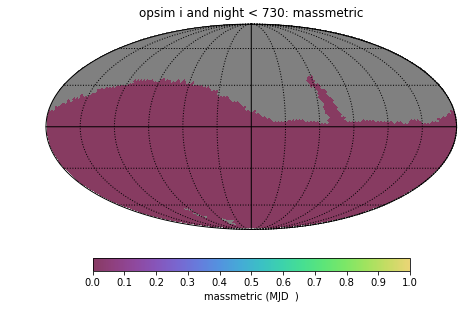

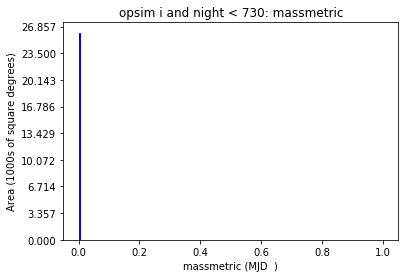

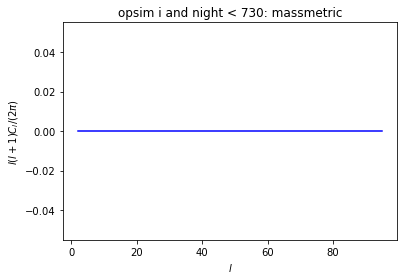

In [74]:
# Run the queries
bg.runAll()

# Create the plots
bg.plotAll(closefigs=False)